In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

In [2]:
import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [3]:
#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

In [4]:
def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [5]:
#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [6]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [7]:
#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [8]:
#VGG19 
#We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer. 
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications import VGG19

In [9]:
def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [10]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [11]:
# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 

In [11]:
#Load first n number of images (to train on a subset of all images)
#For demo purposes, let us use 5000 images
n=5000
lr_list = os.listdir("data/lr_images")[:n]

In [ ]:
!pip list

In [ ]:
!pip uninstall opencv-python
!pip uninstall opencv-contrib-python
!pip uninstall opencv-contrib-python-headless

^C


In [12]:
lr_images = []
for img in lr_list:
    img_lr = cv2.imread("data/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir("data/hr_images")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("data/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

AttributeError: module 'cv2' has no attribute 'imread'

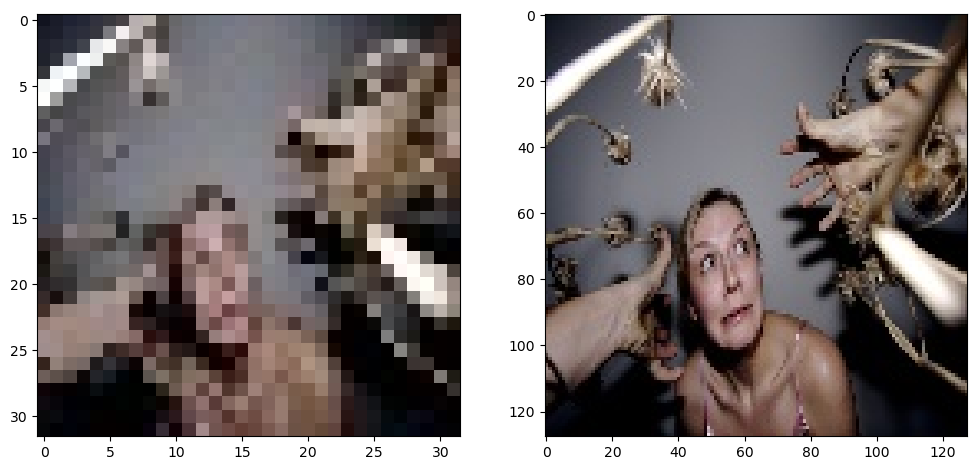

In [14]:
#Sanity check, view few images
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [15]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

In [16]:
generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 64)   36928       ['add_4[0][0]']                  
                                                                                                  
 batch_normalization_10 (BatchN  (None, 32, 32, 64)  256         ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 p_re_lu_6 (PReLU)              (None, 32, 32, 64)   64          ['batch_normalization_10[0][0]'] 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 32, 32, 64)   36928       ['p_re_lu_6[0][0]']              
                                                                                                  
 batch_nor

 conv2d_22 (Conv2D)             (None, 32, 32, 64)   36928       ['p_re_lu_11[0][0]']             
                                                                                                  
 batch_normalization_21 (BatchN  (None, 32, 32, 64)  256         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_10 (Add)                   (None, 32, 32, 64)   0           ['add_9[0][0]',                  
                                                                  'batch_normalization_21[0][0]'] 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 32, 32, 64)   36928       ['add_10[0][0]']                 
                                                                                                  
 batch_nor

 conv2d_33 (Conv2D)             (None, 32, 32, 64)   36928       ['add_15[0][0]']                 
                                                                                                  
 batch_normalization_32 (BatchN  (None, 32, 32, 64)  256         ['conv2d_33[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_16 (Add)                   (None, 32, 32, 64)   0           ['batch_normalization_32[0][0]', 
                                                                  'p_re_lu[0][0]']                
                                                                                                  
 conv2d_34 (Conv2D)             (None, 32, 32, 256)  147712      ['add_16[0][0]']                 
                                                                                                  
 up_sampli

                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 32, 32, 256)       295168    
                                                                 
 block3_conv2 (Conv2D)       (None, 32, 32, 256)       590080    
                                                                 
 block3_conv3 (Conv2D)       (None, 32, 32, 256)       590080    
                                                                 
 block3_conv4 (Conv2D)       (None, 32, 32, 256)       590080    
                                                                 
Total params: 2,325,568
Trainable params: 2,325,568
Non-trainable params: 0
_________________________________________________________________


In [17]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            38249281    ['model[0][0]']            

In [19]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [20]:
epochs = 5
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")


  0%|                                                                                        | 0/16750 [00:00<?, ?it/s]

1/1 [==============================] - 0s 111ms/step


  0%|                                                                             | 1/16750 [00:17<82:22:00, 17.70s/it]

1/1 [==============================] - 0s 46ms/step


  0%|                                                                             | 2/16750 [00:20<41:51:00,  9.00s/it]

1/1 [==============================] - 0s 45ms/step


  0%|                                                                             | 3/16750 [00:23<29:07:56,  6.26s/it]

1/1 [==============================] - 0s 44ms/step


  0%|                                                                             | 4/16750 [00:26<23:05:59,  4.97s/it]

1/1 [==============================] - 0s 44ms/step


  0%|                                                                             | 5/16750 [00:29<19:49:25,  4.26s/it]

1/1 [==============================] - 0s 46ms/step


  0%|                                                                             | 6/16750 [00:32<17:29:33,  3.76s/it]

1/1 [==============================] - 0s 43ms/step


  0%|                                                                             | 7/16750 [00:35<16:03:54,  3.45s/it]

1/1 [==============================] - 0s 44ms/step


  0%|                                                                             | 8/16750 [00:38<15:04:21,  3.24s/it]

1/1 [==============================] - 0s 44ms/step


  0%|                                                                             | 9/16750 [00:40<14:30:27,  3.12s/it]

1/1 [==============================] - 0s 44ms/step


  0%|                                                                            | 10/16750 [00:43<14:08:56,  3.04s/it]

1/1 [==============================] - 0s 45ms/step


  0%|                                                                            | 11/16750 [00:46<14:03:56,  3.03s/it]

1/1 [==============================] - 0s 44ms/step


  0%|                                                                            | 12/16750 [00:49<13:51:15,  2.98s/it]

1/1 [==============================] - 0s 55ms/step


  0%|                                                                            | 13/16750 [00:52<13:47:48,  2.97s/it]

1/1 [==============================] - 0s 45ms/step


  0%|                                                                            | 14/16750 [00:55<13:42:01,  2.95s/it]

1/1 [==============================] - 0s 45ms/step


  0%|                                                                            | 15/16750 [00:58<13:49:07,  2.97s/it]

1/1 [==============================] - 0s 45ms/step


  0%|                                                                            | 16/16750 [01:01<13:44:16,  2.96s/it]

1/1 [==============================] - 0s 59ms/step


  0%|                                                                            | 17/16750 [01:04<13:51:53,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  0%|                                                                            | 18/16750 [01:07<13:48:38,  2.97s/it]

1/1 [==============================] - 0s 44ms/step


  0%|                                                                            | 19/16750 [01:10<13:47:11,  2.97s/it]

1/1 [==============================] - 0s 48ms/step


  0%|                                                                            | 20/16750 [01:13<13:53:50,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  0%|                                                                            | 21/16750 [01:16<13:48:28,  2.97s/it]

1/1 [==============================] - 0s 55ms/step


  0%|                                                                            | 22/16750 [01:19<13:50:45,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  0%|                                                                            | 23/16750 [01:22<13:46:19,  2.96s/it]

1/1 [==============================] - 0s 44ms/step


  0%|                                                                            | 24/16750 [01:25<13:48:33,  2.97s/it]

1/1 [==============================] - 0s 44ms/step


  0%|                                                                            | 25/16750 [01:28<13:48:19,  2.97s/it]

1/1 [==============================] - 0s 44ms/step


  0%|                                                                            | 26/16750 [01:31<13:47:26,  2.97s/it]

1/1 [==============================] - 0s 44ms/step


  0%|                                                                            | 27/16750 [01:34<13:44:04,  2.96s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▏                                                                           | 28/16750 [01:37<13:42:39,  2.95s/it]

1/1 [==============================] - 0s 44ms/step


  0%|▏                                                                           | 29/16750 [01:40<13:45:45,  2.96s/it]

1/1 [==============================] - 0s 44ms/step


  0%|▏                                                                           | 30/16750 [01:42<13:47:53,  2.97s/it]

1/1 [==============================] - 0s 44ms/step


  0%|▏                                                                           | 31/16750 [01:45<13:48:36,  2.97s/it]

1/1 [==============================] - 0s 44ms/step


  0%|▏                                                                           | 32/16750 [01:48<13:50:04,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▏                                                                           | 33/16750 [01:51<13:49:23,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  0%|▏                                                                           | 34/16750 [01:54<13:50:15,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▏                                                                           | 35/16750 [01:57<13:52:02,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▏                                                                           | 36/16750 [02:00<13:50:33,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  0%|▏                                                                           | 37/16750 [02:03<13:49:08,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▏                                                                           | 38/16750 [02:06<13:50:16,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▏                                                                           | 39/16750 [02:09<13:50:26,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  0%|▏                                                                           | 40/16750 [02:12<13:52:17,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▏                                                                           | 41/16750 [02:15<13:50:59,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▏                                                                           | 42/16750 [02:18<13:52:49,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  0%|▏                                                                           | 43/16750 [02:21<13:54:45,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▏                                                                           | 44/16750 [02:24<13:56:26,  3.00s/it]

1/1 [==============================] - 0s 49ms/step


  0%|▏                                                                           | 45/16750 [02:27<13:57:06,  3.01s/it]

1/1 [==============================] - 0s 44ms/step


  0%|▏                                                                           | 46/16750 [02:30<13:54:37,  3.00s/it]

1/1 [==============================] - 0s 43ms/step


  0%|▏                                                                           | 47/16750 [02:33<13:53:12,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  0%|▏                                                                           | 48/16750 [02:36<13:53:19,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  0%|▏                                                                           | 49/16750 [02:39<13:55:30,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▏                                                                           | 50/16750 [02:42<13:54:49,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▏                                                                           | 51/16750 [02:45<13:54:15,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  0%|▏                                                                           | 52/16750 [02:48<13:53:19,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▏                                                                           | 53/16750 [02:51<13:53:37,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  0%|▏                                                                           | 54/16750 [02:54<13:54:43,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  0%|▏                                                                           | 55/16750 [02:57<13:53:55,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▎                                                                           | 56/16750 [03:00<14:04:01,  3.03s/it]

1/1 [==============================] - 0s 49ms/step


  0%|▎                                                                           | 57/16750 [03:04<14:19:47,  3.09s/it]

1/1 [==============================] - 0s 50ms/step


  0%|▎                                                                           | 58/16750 [03:07<14:25:13,  3.11s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▎                                                                           | 59/16750 [03:10<14:40:08,  3.16s/it]

1/1 [==============================] - 0s 47ms/step


  0%|▎                                                                           | 60/16750 [03:13<14:40:10,  3.16s/it]

1/1 [==============================] - 0s 47ms/step


  0%|▎                                                                           | 61/16750 [03:16<14:39:17,  3.16s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▎                                                                           | 62/16750 [03:19<14:23:49,  3.11s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▎                                                                           | 63/16750 [03:22<14:16:54,  3.08s/it]

1/1 [==============================] - 0s 46ms/step


  0%|▎                                                                           | 64/16750 [03:26<14:23:18,  3.10s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▎                                                                           | 65/16750 [03:29<14:25:10,  3.11s/it]

1/1 [==============================] - 0s 44ms/step


  0%|▎                                                                           | 66/16750 [03:32<14:12:06,  3.06s/it]

1/1 [==============================] - 0s 56ms/step


  0%|▎                                                                           | 67/16750 [03:35<13:59:30,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▎                                                                           | 68/16750 [03:38<13:56:57,  3.01s/it]

1/1 [==============================] - 0s 44ms/step


  0%|▎                                                                           | 69/16750 [03:41<13:53:11,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▎                                                                           | 70/16750 [03:43<13:50:16,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  0%|▎                                                                           | 71/16750 [03:46<13:49:24,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  0%|▎                                                                           | 72/16750 [03:49<13:49:51,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  0%|▎                                                                           | 73/16750 [03:52<13:48:03,  2.98s/it]

1/1 [==============================] - 0s 52ms/step


  0%|▎                                                                           | 74/16750 [03:56<14:01:50,  3.03s/it]

1/1 [==============================] - 0s 44ms/step


  0%|▎                                                                           | 75/16750 [03:59<13:59:42,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▎                                                                           | 76/16750 [04:02<13:56:39,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  0%|▎                                                                           | 77/16750 [04:05<13:54:31,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▎                                                                           | 78/16750 [04:08<13:53:51,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▎                                                                           | 79/16750 [04:11<13:52:02,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  0%|▎                                                                           | 80/16750 [04:13<13:50:22,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▎                                                                           | 81/16750 [04:16<13:51:16,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▎                                                                           | 82/16750 [04:19<13:49:30,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  0%|▍                                                                           | 83/16750 [04:22<13:50:45,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  1%|▍                                                                           | 84/16750 [04:25<13:50:52,  2.99s/it]

1/1 [==============================] - 0s 52ms/step


  1%|▍                                                                           | 85/16750 [04:29<13:57:10,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  1%|▍                                                                           | 86/16750 [04:31<13:53:13,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▍                                                                           | 87/16750 [04:35<13:54:17,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▍                                                                           | 88/16750 [04:38<13:53:46,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  1%|▍                                                                           | 89/16750 [04:41<13:53:50,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  1%|▍                                                                           | 90/16750 [04:43<13:51:52,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▍                                                                           | 91/16750 [04:46<13:50:32,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  1%|▍                                                                           | 92/16750 [04:49<13:50:08,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▍                                                                           | 93/16750 [04:52<13:52:58,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  1%|▍                                                                           | 94/16750 [04:55<13:50:37,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▍                                                                           | 95/16750 [04:58<13:50:45,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▍                                                                           | 96/16750 [05:01<13:50:01,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▍                                                                           | 97/16750 [05:04<13:51:23,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  1%|▍                                                                           | 98/16750 [05:07<13:50:03,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  1%|▍                                                                           | 99/16750 [05:10<13:49:45,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  1%|▍                                                                          | 100/16750 [05:13<13:49:12,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▍                                                                          | 101/16750 [05:16<13:50:57,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▍                                                                          | 102/16750 [05:19<13:49:44,  2.99s/it]

1/1 [==============================] - 0s 55ms/step


  1%|▍                                                                          | 103/16750 [05:22<13:49:28,  2.99s/it]

1/1 [==============================] - 0s 57ms/step


  1%|▍                                                                          | 104/16750 [05:26<14:12:23,  3.07s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▍                                                                          | 105/16750 [05:29<14:11:14,  3.07s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▍                                                                          | 106/16750 [05:32<14:01:03,  3.03s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▍                                                                          | 107/16750 [05:35<13:58:18,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▍                                                                          | 108/16750 [05:38<13:52:47,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▍                                                                          | 109/16750 [05:41<13:49:47,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  1%|▍                                                                          | 110/16750 [05:44<13:46:56,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▍                                                                          | 111/16750 [05:46<13:46:09,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▌                                                                          | 112/16750 [05:49<13:48:01,  2.99s/it]

1/1 [==============================] - 0s 55ms/step


  1%|▌                                                                          | 113/16750 [05:52<13:47:07,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▌                                                                          | 114/16750 [05:55<13:48:58,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  1%|▌                                                                          | 115/16750 [05:58<13:48:19,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▌                                                                          | 116/16750 [06:01<13:47:42,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  1%|▌                                                                          | 117/16750 [06:04<13:49:26,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▌                                                                          | 118/16750 [06:09<16:06:54,  3.49s/it]

1/1 [==============================] - 0s 95ms/step


  1%|▌                                                                          | 119/16750 [06:13<16:38:52,  3.60s/it]

1/1 [==============================] - 0s 98ms/step


  1%|▌                                                                          | 120/16750 [06:17<17:03:35,  3.69s/it]

1/1 [==============================] - 0s 67ms/step


  1%|▌                                                                          | 121/16750 [06:21<17:11:02,  3.72s/it]

1/1 [==============================] - 0s 88ms/step


  1%|▌                                                                          | 122/16750 [06:25<17:24:24,  3.77s/it]

1/1 [==============================] - 0s 108ms/step


  1%|▌                                                                          | 123/16750 [06:28<17:36:13,  3.81s/it]

1/1 [==============================] - 0s 97ms/step


  1%|▌                                                                          | 124/16750 [06:32<17:43:26,  3.84s/it]

1/1 [==============================] - 0s 103ms/step


  1%|▌                                                                          | 125/16750 [06:36<17:54:24,  3.88s/it]

1/1 [==============================] - 0s 99ms/step


  1%|▌                                                                          | 126/16750 [06:40<17:59:25,  3.90s/it]

1/1 [==============================] - 0s 100ms/step


  1%|▌                                                                          | 127/16750 [06:44<17:50:20,  3.86s/it]

1/1 [==============================] - 0s 98ms/step


  1%|▌                                                                          | 128/16750 [06:48<17:58:16,  3.89s/it]

1/1 [==============================] - 0s 97ms/step


  1%|▌                                                                          | 129/16750 [06:52<18:02:41,  3.91s/it]

1/1 [==============================] - 0s 96ms/step


  1%|▌                                                                          | 130/16750 [06:56<17:54:13,  3.88s/it]

1/1 [==============================] - 0s 57ms/step


  1%|▌                                                                          | 131/16750 [06:59<17:24:24,  3.77s/it]

1/1 [==============================] - 0s 54ms/step


  1%|▌                                                                          | 132/16750 [07:02<16:37:58,  3.60s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▌                                                                          | 133/16750 [07:05<15:47:59,  3.42s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▌                                                                          | 134/16750 [07:09<15:17:31,  3.31s/it]

1/1 [==============================] - 0s 46ms/step


  1%|▌                                                                          | 135/16750 [07:12<14:53:07,  3.23s/it]

1/1 [==============================] - 0s 43ms/step


  1%|▌                                                                          | 136/16750 [07:15<14:32:56,  3.15s/it]

1/1 [==============================] - 0s 46ms/step


  1%|▌                                                                          | 137/16750 [07:18<14:18:49,  3.10s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▌                                                                          | 138/16750 [07:21<14:09:40,  3.07s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▌                                                                          | 139/16750 [07:24<14:02:55,  3.04s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▋                                                                          | 140/16750 [07:26<13:56:50,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▋                                                                          | 141/16750 [07:29<13:54:22,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▋                                                                          | 142/16750 [07:32<13:52:14,  3.01s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▋                                                                          | 143/16750 [07:35<13:49:31,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▋                                                                          | 144/16750 [07:38<13:49:20,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▋                                                                          | 145/16750 [07:41<13:46:50,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▋                                                                          | 146/16750 [07:44<13:46:18,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▋                                                                          | 147/16750 [07:47<13:47:08,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▋                                                                          | 148/16750 [07:50<13:48:18,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▋                                                                          | 149/16750 [07:53<13:46:05,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▋                                                                          | 150/16750 [07:56<13:43:37,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  1%|▋                                                                          | 151/16750 [07:59<13:43:09,  2.98s/it]

1/1 [==============================] - 0s 47ms/step


  1%|▋                                                                          | 152/16750 [08:02<13:49:12,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  1%|▋                                                                          | 153/16750 [08:05<14:02:43,  3.05s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▋                                                                          | 154/16750 [08:09<13:59:51,  3.04s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▋                                                                          | 155/16750 [08:12<13:57:25,  3.03s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▋                                                                          | 156/16750 [08:15<13:56:41,  3.03s/it]

1/1 [==============================] - 0s 46ms/step


  1%|▋                                                                          | 157/16750 [08:18<13:52:43,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▋                                                                          | 158/16750 [08:21<13:51:48,  3.01s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▋                                                                          | 159/16750 [08:23<13:49:08,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▋                                                                          | 160/16750 [08:27<13:50:57,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▋                                                                          | 161/16750 [08:30<13:50:24,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▋                                                                          | 162/16750 [08:32<13:47:52,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▋                                                                          | 163/16750 [08:35<13:48:57,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▋                                                                          | 164/16750 [08:38<13:48:12,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▋                                                                          | 165/16750 [08:41<13:48:57,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▋                                                                          | 166/16750 [08:44<13:48:12,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▋                                                                          | 167/16750 [08:47<13:46:35,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▊                                                                          | 168/16750 [08:50<13:44:44,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▊                                                                          | 169/16750 [08:53<13:51:17,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▊                                                                          | 170/16750 [08:57<14:00:52,  3.04s/it]

1/1 [==============================] - 0s 50ms/step


  1%|▊                                                                          | 171/16750 [09:00<14:01:53,  3.05s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▊                                                                          | 172/16750 [09:03<13:55:09,  3.02s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▊                                                                          | 173/16750 [09:06<13:50:38,  3.01s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▊                                                                          | 174/16750 [09:09<13:47:40,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▊                                                                          | 175/16750 [09:12<13:44:57,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▊                                                                          | 176/16750 [09:15<13:43:11,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▊                                                                          | 177/16750 [09:18<13:45:14,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▊                                                                          | 178/16750 [09:20<13:43:00,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▊                                                                          | 179/16750 [09:23<13:42:01,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▊                                                                          | 180/16750 [09:26<13:42:46,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▊                                                                          | 181/16750 [09:29<13:44:57,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▊                                                                          | 182/16750 [09:32<13:45:20,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▊                                                                          | 183/16750 [09:35<13:45:57,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▊                                                                          | 184/16750 [09:38<13:44:10,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▊                                                                          | 185/16750 [09:41<13:44:02,  2.98s/it]

1/1 [==============================] - 0s 43ms/step


  1%|▊                                                                          | 186/16750 [09:44<13:43:10,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▊                                                                          | 187/16750 [09:47<13:42:24,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▊                                                                          | 188/16750 [09:50<13:39:54,  2.97s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▊                                                                          | 189/16750 [09:53<13:44:03,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▊                                                                          | 190/16750 [09:56<13:40:50,  2.97s/it]

1/1 [==============================] - 0s 46ms/step


  1%|▊                                                                          | 191/16750 [09:59<13:39:55,  2.97s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▊                                                                          | 192/16750 [10:02<13:42:52,  2.98s/it]

1/1 [==============================] - 0s 42ms/step


  1%|▊                                                                          | 193/16750 [10:05<13:44:05,  2.99s/it]

1/1 [==============================] - 0s 43ms/step


  1%|▊                                                                          | 194/16750 [10:08<13:39:09,  2.97s/it]

1/1 [==============================] - 0s 43ms/step


  1%|▊                                                                          | 195/16750 [10:11<13:38:26,  2.97s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▉                                                                          | 196/16750 [10:14<13:35:10,  2.95s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▉                                                                          | 197/16750 [10:17<13:35:15,  2.96s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▉                                                                          | 198/16750 [10:20<13:35:12,  2.96s/it]

1/1 [==============================] - 0s 43ms/step


  1%|▉                                                                          | 199/16750 [10:23<13:32:54,  2.95s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▉                                                                          | 200/16750 [10:26<13:37:48,  2.96s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▉                                                                          | 201/16750 [10:29<13:32:38,  2.95s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▉                                                                          | 202/16750 [10:32<13:33:02,  2.95s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▉                                                                          | 203/16750 [10:35<13:34:21,  2.95s/it]

1/1 [==============================] - 0s 46ms/step


  1%|▉                                                                          | 204/16750 [10:38<13:35:06,  2.96s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▉                                                                          | 205/16750 [10:41<13:36:13,  2.96s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▉                                                                          | 206/16750 [10:44<13:36:41,  2.96s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▉                                                                          | 207/16750 [10:47<13:39:43,  2.97s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▉                                                                          | 208/16750 [10:50<13:43:45,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▉                                                                          | 209/16750 [10:53<13:42:29,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▉                                                                          | 210/16750 [10:56<13:43:10,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▉                                                                          | 211/16750 [10:59<13:42:14,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▉                                                                          | 212/16750 [11:02<13:42:44,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▉                                                                          | 213/16750 [11:05<13:42:02,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▉                                                                          | 214/16750 [11:08<13:43:08,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▉                                                                          | 215/16750 [11:11<13:43:16,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▉                                                                          | 216/16750 [11:14<13:44:27,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▉                                                                          | 217/16750 [11:17<13:44:49,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  1%|▉                                                                          | 218/16750 [11:19<13:43:17,  2.99s/it]

1/1 [==============================] - 0s 43ms/step


  1%|▉                                                                          | 219/16750 [11:22<13:43:05,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▉                                                                          | 220/16750 [11:25<13:42:35,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▉                                                                          | 221/16750 [11:28<13:41:34,  2.98s/it]

1/1 [==============================] - 0s 48ms/step


  1%|▉                                                                          | 222/16750 [11:31<13:47:31,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  1%|▉                                                                          | 223/16750 [11:34<13:43:12,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  1%|█                                                                          | 224/16750 [11:37<13:41:47,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  1%|█                                                                          | 225/16750 [11:40<13:41:02,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  1%|█                                                                          | 226/16750 [11:43<13:40:22,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  1%|█                                                                          | 227/16750 [11:46<13:45:37,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  1%|█                                                                          | 228/16750 [11:49<13:39:36,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  1%|█                                                                          | 229/16750 [11:52<13:36:54,  2.97s/it]

1/1 [==============================] - 0s 45ms/step


  1%|█                                                                          | 230/16750 [11:55<13:33:43,  2.96s/it]

1/1 [==============================] - 0s 44ms/step


  1%|█                                                                          | 231/16750 [11:58<13:41:21,  2.98s/it]

1/1 [==============================] - 0s 50ms/step


  1%|█                                                                          | 232/16750 [12:01<13:50:34,  3.02s/it]

1/1 [==============================] - 0s 44ms/step


  1%|█                                                                          | 233/16750 [12:04<13:44:50,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  1%|█                                                                          | 234/16750 [12:07<13:38:36,  2.97s/it]

1/1 [==============================] - 0s 45ms/step


  1%|█                                                                          | 235/16750 [12:10<13:35:10,  2.96s/it]

1/1 [==============================] - 0s 44ms/step


  1%|█                                                                          | 236/16750 [12:13<13:33:12,  2.95s/it]

1/1 [==============================] - 0s 44ms/step


  1%|█                                                                          | 237/16750 [12:16<13:31:04,  2.95s/it]

1/1 [==============================] - 0s 43ms/step


  1%|█                                                                          | 238/16750 [12:19<13:28:47,  2.94s/it]

1/1 [==============================] - 0s 44ms/step


  1%|█                                                                          | 239/16750 [12:22<13:25:29,  2.93s/it]

1/1 [==============================] - 0s 44ms/step


  1%|█                                                                          | 240/16750 [12:25<13:30:22,  2.95s/it]

1/1 [==============================] - 0s 46ms/step


  1%|█                                                                          | 241/16750 [12:28<13:33:03,  2.95s/it]

1/1 [==============================] - 0s 44ms/step


  1%|█                                                                          | 242/16750 [12:31<13:38:53,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  1%|█                                                                          | 243/16750 [12:34<13:38:49,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  1%|█                                                                          | 244/16750 [12:37<13:37:57,  2.97s/it]

1/1 [==============================] - 0s 42ms/step


  1%|█                                                                          | 245/16750 [12:40<13:39:40,  2.98s/it]

1/1 [==============================] - 0s 43ms/step


  1%|█                                                                          | 246/16750 [12:43<13:38:30,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  1%|█                                                                          | 247/16750 [12:46<13:38:20,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  1%|█                                                                          | 248/16750 [12:49<13:37:40,  2.97s/it]

1/1 [==============================] - 0s 46ms/step


  1%|█                                                                          | 249/16750 [12:52<13:37:52,  2.97s/it]

1/1 [==============================] - 0s 44ms/step


  1%|█                                                                          | 250/16750 [12:55<13:39:45,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  1%|█                                                                          | 251/16750 [12:58<13:40:53,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▏                                                                         | 252/16750 [13:01<13:39:20,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▏                                                                         | 253/16750 [13:04<13:47:51,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▏                                                                         | 254/16750 [13:07<13:54:07,  3.03s/it]

1/1 [==============================] - 0s 46ms/step


  2%|█▏                                                                         | 255/16750 [13:10<13:48:36,  3.01s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▏                                                                         | 256/16750 [13:13<13:47:59,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▏                                                                         | 257/16750 [13:16<13:46:34,  3.01s/it]

1/1 [==============================] - 0s 43ms/step


  2%|█▏                                                                         | 258/16750 [13:19<13:44:19,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▏                                                                         | 259/16750 [13:22<13:43:06,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  2%|█▏                                                                         | 260/16750 [13:25<13:44:36,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▏                                                                         | 261/16750 [13:28<13:42:28,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▏                                                                         | 262/16750 [13:31<13:41:53,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  2%|█▏                                                                         | 263/16750 [13:34<13:45:51,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  2%|█▏                                                                         | 264/16750 [13:37<13:43:52,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▏                                                                         | 265/16750 [13:40<13:45:29,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▏                                                                         | 266/16750 [13:43<13:42:16,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▏                                                                         | 267/16750 [13:46<13:41:36,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▏                                                                         | 268/16750 [13:49<13:43:52,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▏                                                                         | 269/16750 [13:52<13:48:18,  3.02s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▏                                                                         | 270/16750 [13:55<13:50:39,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▏                                                                         | 271/16750 [13:58<13:46:39,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  2%|█▏                                                                         | 272/16750 [14:01<13:44:25,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▏                                                                         | 273/16750 [14:04<13:43:06,  3.00s/it]

1/1 [==============================] - 0s 43ms/step


  2%|█▏                                                                         | 274/16750 [14:07<13:41:39,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▏                                                                         | 275/16750 [14:10<13:42:24,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▏                                                                         | 276/16750 [14:13<13:40:06,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▏                                                                         | 277/16750 [14:16<13:41:39,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▏                                                                         | 278/16750 [14:19<13:40:43,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▏                                                                         | 279/16750 [14:22<13:39:36,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▎                                                                         | 280/16750 [14:25<13:41:21,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▎                                                                         | 281/16750 [14:28<13:40:58,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▎                                                                         | 282/16750 [14:31<13:38:30,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▎                                                                         | 283/16750 [14:34<13:42:45,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▎                                                                         | 284/16750 [14:37<13:40:12,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▎                                                                         | 285/16750 [14:40<13:38:23,  2.98s/it]

1/1 [==============================] - 0s 43ms/step


  2%|█▎                                                                         | 286/16750 [14:43<13:35:39,  2.97s/it]

1/1 [==============================] - 0s 46ms/step


  2%|█▎                                                                         | 287/16750 [14:46<13:36:21,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▎                                                                         | 288/16750 [14:48<13:34:49,  2.97s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▎                                                                         | 289/16750 [14:52<13:41:04,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▎                                                                         | 290/16750 [14:54<13:35:25,  2.97s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▎                                                                         | 291/16750 [14:57<13:30:44,  2.96s/it]

1/1 [==============================] - 0s 46ms/step


  2%|█▎                                                                         | 292/16750 [15:00<13:29:21,  2.95s/it]

1/1 [==============================] - 0s 43ms/step


  2%|█▎                                                                         | 293/16750 [15:03<13:29:23,  2.95s/it]

1/1 [==============================] - 0s 46ms/step


  2%|█▎                                                                         | 294/16750 [15:06<13:27:39,  2.94s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▎                                                                         | 295/16750 [15:09<13:26:42,  2.94s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▎                                                                         | 296/16750 [15:12<13:25:44,  2.94s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▎                                                                         | 297/16750 [15:15<13:28:40,  2.95s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▎                                                                         | 298/16750 [15:18<13:26:27,  2.94s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▎                                                                         | 299/16750 [15:21<13:27:39,  2.95s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▎                                                                         | 300/16750 [15:24<13:30:40,  2.96s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▎                                                                         | 301/16750 [15:27<13:31:48,  2.96s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▎                                                                         | 302/16750 [15:30<13:32:29,  2.96s/it]

1/1 [==============================] - 0s 46ms/step


  2%|█▎                                                                         | 303/16750 [15:33<13:31:52,  2.96s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▎                                                                         | 304/16750 [15:36<13:38:02,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▎                                                                         | 305/16750 [15:39<13:37:59,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  2%|█▎                                                                         | 306/16750 [15:42<13:37:18,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▎                                                                         | 307/16750 [15:45<13:37:32,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▍                                                                         | 308/16750 [15:48<13:36:58,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▍                                                                         | 309/16750 [15:51<13:36:37,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▍                                                                         | 310/16750 [15:54<13:36:42,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▍                                                                         | 311/16750 [15:57<13:34:09,  2.97s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▍                                                                         | 312/16750 [16:00<13:35:26,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▍                                                                         | 313/16750 [16:03<13:35:33,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▍                                                                         | 314/16750 [16:06<13:38:56,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▍                                                                         | 315/16750 [16:09<13:35:51,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▍                                                                         | 316/16750 [16:12<13:35:51,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▍                                                                         | 317/16750 [16:15<13:37:30,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▍                                                                         | 318/16750 [16:18<13:35:10,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  2%|█▍                                                                         | 319/16750 [16:20<13:30:06,  2.96s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▍                                                                         | 320/16750 [16:23<13:28:20,  2.95s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▍                                                                         | 321/16750 [16:26<13:27:44,  2.95s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▍                                                                         | 322/16750 [16:29<13:27:20,  2.95s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▍                                                                         | 323/16750 [16:32<13:28:46,  2.95s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▍                                                                         | 324/16750 [16:35<13:29:15,  2.96s/it]

1/1 [==============================] - 0s 46ms/step


  2%|█▍                                                                         | 325/16750 [16:38<13:26:31,  2.95s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▍                                                                         | 326/16750 [16:41<13:25:45,  2.94s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▍                                                                         | 327/16750 [16:44<13:26:08,  2.95s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▍                                                                         | 328/16750 [16:47<13:27:32,  2.95s/it]

1/1 [==============================] - 0s 46ms/step


  2%|█▍                                                                         | 329/16750 [16:50<13:28:30,  2.95s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▍                                                                         | 330/16750 [16:53<13:28:14,  2.95s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▍                                                                         | 331/16750 [16:56<13:29:56,  2.96s/it]

1/1 [==============================] - 0s 46ms/step


  2%|█▍                                                                         | 332/16750 [16:59<13:32:21,  2.97s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▍                                                                         | 333/16750 [17:02<13:37:13,  2.99s/it]

1/1 [==============================] - 0s 42ms/step


  2%|█▍                                                                         | 334/16750 [17:05<13:40:57,  3.00s/it]

1/1 [==============================] - 0s 53ms/step


  2%|█▌                                                                         | 335/16750 [17:08<13:40:38,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▌                                                                         | 336/16750 [17:11<13:37:41,  2.99s/it]

1/1 [==============================] - 0s 49ms/step


  2%|█▌                                                                         | 337/16750 [17:14<13:36:29,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▌                                                                         | 338/16750 [17:17<13:35:03,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▌                                                                         | 339/16750 [17:20<13:35:58,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▌                                                                         | 340/16750 [17:23<13:34:39,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▌                                                                         | 341/16750 [17:26<13:34:20,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▌                                                                         | 342/16750 [17:29<13:34:21,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▌                                                                         | 343/16750 [17:32<13:34:51,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▌                                                                         | 344/16750 [17:35<13:36:47,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▌                                                                         | 345/16750 [17:38<13:40:20,  3.00s/it]

1/1 [==============================] - 0s 53ms/step


  2%|█▌                                                                         | 346/16750 [17:41<13:41:27,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▌                                                                         | 347/16750 [17:44<13:40:53,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▌                                                                         | 348/16750 [17:47<13:39:50,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▌                                                                         | 349/16750 [17:50<13:39:54,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▌                                                                         | 350/16750 [17:53<13:37:47,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▌                                                                         | 351/16750 [17:56<13:38:55,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▌                                                                         | 352/16750 [17:59<13:37:24,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▌                                                                         | 353/16750 [18:02<13:36:59,  2.99s/it]

1/1 [==============================] - 0s 48ms/step


  2%|█▌                                                                         | 354/16750 [18:05<13:43:31,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  2%|█▌                                                                         | 355/16750 [18:08<13:46:59,  3.03s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▌                                                                         | 356/16750 [18:11<13:45:22,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▌                                                                         | 357/16750 [18:14<13:45:48,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▌                                                                         | 358/16750 [18:17<13:43:21,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  2%|█▌                                                                         | 359/16750 [18:20<13:42:38,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▌                                                                         | 360/16750 [18:23<13:43:34,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▌                                                                         | 361/16750 [18:26<13:48:04,  3.03s/it]

1/1 [==============================] - 0s 43ms/step


  2%|█▌                                                                         | 362/16750 [18:29<13:43:15,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  2%|█▋                                                                         | 363/16750 [18:32<13:42:27,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▋                                                                         | 364/16750 [18:35<13:37:26,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  2%|█▋                                                                         | 365/16750 [18:38<13:42:34,  3.01s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▋                                                                         | 366/16750 [18:41<13:40:07,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  2%|█▋                                                                         | 367/16750 [18:44<13:39:49,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▋                                                                         | 368/16750 [18:47<13:37:23,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▋                                                                         | 369/16750 [18:50<13:36:25,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▋                                                                         | 370/16750 [18:53<13:37:03,  2.99s/it]

1/1 [==============================] - 0s 49ms/step


  2%|█▋                                                                         | 371/16750 [18:56<13:47:04,  3.03s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▋                                                                         | 372/16750 [18:59<13:41:50,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▋                                                                         | 373/16750 [19:02<13:39:15,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  2%|█▋                                                                         | 374/16750 [19:05<13:38:04,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▋                                                                         | 375/16750 [19:08<13:37:27,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▋                                                                         | 376/16750 [19:11<13:37:04,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▋                                                                         | 377/16750 [19:14<13:35:51,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▋                                                                         | 378/16750 [19:17<13:33:42,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▋                                                                         | 379/16750 [19:20<13:32:40,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▋                                                                         | 380/16750 [19:23<13:33:02,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▋                                                                         | 381/16750 [19:26<13:34:40,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▋                                                                         | 382/16750 [19:29<13:34:43,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▋                                                                         | 383/16750 [19:32<13:34:34,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▋                                                                         | 384/16750 [19:35<13:36:03,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▋                                                                         | 385/16750 [19:38<13:39:54,  3.01s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▋                                                                         | 386/16750 [19:41<13:38:30,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▋                                                                         | 387/16750 [19:44<13:37:28,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▋                                                                         | 388/16750 [19:47<13:35:12,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▋                                                                         | 389/16750 [19:50<13:34:01,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▋                                                                         | 390/16750 [19:53<13:33:27,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▊                                                                         | 391/16750 [19:56<13:33:02,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▊                                                                         | 392/16750 [19:59<13:31:22,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▊                                                                         | 393/16750 [20:02<13:33:53,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▊                                                                         | 394/16750 [20:05<13:33:02,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▊                                                                         | 395/16750 [20:08<13:35:53,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▊                                                                         | 396/16750 [20:11<13:30:42,  2.97s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▊                                                                         | 397/16750 [20:14<13:27:57,  2.96s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▊                                                                         | 398/16750 [20:16<13:25:31,  2.96s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▊                                                                         | 399/16750 [20:19<13:23:41,  2.95s/it]

1/1 [==============================] - 0s 42ms/step


  2%|█▊                                                                         | 400/16750 [20:22<13:27:18,  2.96s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▊                                                                         | 401/16750 [20:25<13:24:49,  2.95s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▊                                                                         | 402/16750 [20:28<13:24:58,  2.95s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▊                                                                         | 403/16750 [20:31<13:22:55,  2.95s/it]

1/1 [==============================] - 0s 42ms/step


  2%|█▊                                                                         | 404/16750 [20:34<13:27:54,  2.97s/it]

1/1 [==============================] - 0s 43ms/step


  2%|█▊                                                                         | 405/16750 [20:37<13:27:41,  2.96s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▊                                                                         | 406/16750 [20:40<13:32:55,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▊                                                                         | 407/16750 [20:43<13:31:30,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▊                                                                         | 408/16750 [20:46<13:26:56,  2.96s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▊                                                                         | 409/16750 [20:49<13:28:50,  2.97s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▊                                                                         | 410/16750 [20:52<13:28:23,  2.97s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▊                                                                         | 411/16750 [20:55<13:26:16,  2.96s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▊                                                                         | 412/16750 [20:58<13:27:10,  2.96s/it]

1/1 [==============================] - 0s 46ms/step


  2%|█▊                                                                         | 413/16750 [21:01<13:27:13,  2.96s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▊                                                                         | 414/16750 [21:04<13:30:30,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▊                                                                         | 415/16750 [21:07<13:30:55,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▊                                                                         | 416/16750 [21:10<13:31:14,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  2%|█▊                                                                         | 417/16750 [21:13<13:30:12,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  2%|█▊                                                                         | 418/16750 [21:16<13:33:44,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  3%|█▉                                                                         | 419/16750 [21:19<13:32:25,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  3%|█▉                                                                         | 420/16750 [21:22<13:30:37,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  3%|█▉                                                                         | 421/16750 [21:25<13:30:46,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  3%|█▉                                                                         | 422/16750 [21:28<13:29:47,  2.98s/it]

1/1 [==============================] - 0s 51ms/step


  3%|█▉                                                                         | 423/16750 [21:31<13:32:47,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  3%|█▉                                                                         | 424/16750 [21:34<13:33:07,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  3%|█▉                                                                         | 425/16750 [21:37<13:30:36,  2.98s/it]

1/1 [==============================] - 0s 52ms/step


  3%|█▉                                                                         | 426/16750 [21:40<13:36:17,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  3%|█▉                                                                         | 427/16750 [21:43<13:33:03,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  3%|█▉                                                                         | 428/16750 [21:46<13:33:25,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  3%|█▉                                                                         | 429/16750 [21:49<13:30:47,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  3%|█▉                                                                         | 430/16750 [21:52<13:32:49,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  3%|█▉                                                                         | 431/16750 [21:55<13:38:41,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  3%|█▉                                                                         | 432/16750 [21:58<13:41:36,  3.02s/it]

1/1 [==============================] - 0s 44ms/step


  3%|█▉                                                                         | 433/16750 [22:01<13:43:29,  3.03s/it]

1/1 [==============================] - 0s 44ms/step


  3%|█▉                                                                         | 434/16750 [22:04<13:43:04,  3.03s/it]

1/1 [==============================] - 0s 47ms/step


  3%|█▉                                                                         | 435/16750 [22:07<13:40:11,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


  3%|█▉                                                                         | 436/16750 [22:10<13:37:47,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  3%|█▉                                                                         | 437/16750 [22:13<13:34:50,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  3%|█▉                                                                         | 438/16750 [22:16<13:35:01,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  3%|█▉                                                                         | 439/16750 [22:19<13:33:02,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  3%|█▉                                                                         | 440/16750 [22:22<13:31:43,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  3%|█▉                                                                         | 441/16750 [22:25<13:30:23,  2.98s/it]

1/1 [==============================] - 0s 43ms/step


  3%|█▉                                                                         | 442/16750 [22:28<13:31:11,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  3%|█▉                                                                         | 443/16750 [22:31<13:31:23,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  3%|█▉                                                                         | 444/16750 [22:34<13:31:09,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  3%|█▉                                                                         | 445/16750 [22:37<13:31:07,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  3%|█▉                                                                         | 446/16750 [22:40<13:33:52,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██                                                                         | 447/16750 [22:43<13:34:38,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██                                                                         | 448/16750 [22:46<13:35:02,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██                                                                         | 449/16750 [22:49<13:33:15,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██                                                                         | 450/16750 [22:52<13:26:58,  2.97s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██                                                                         | 451/16750 [22:55<13:26:09,  2.97s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██                                                                         | 452/16750 [22:57<13:21:32,  2.95s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██                                                                         | 453/16750 [23:00<13:21:58,  2.95s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██                                                                         | 454/16750 [23:03<13:22:15,  2.95s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██                                                                         | 455/16750 [23:06<13:26:55,  2.97s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██                                                                         | 456/16750 [23:09<13:23:32,  2.96s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██                                                                         | 457/16750 [23:12<13:23:16,  2.96s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██                                                                         | 458/16750 [23:15<13:21:29,  2.95s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██                                                                         | 459/16750 [23:18<13:21:28,  2.95s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██                                                                         | 460/16750 [23:21<13:21:01,  2.95s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██                                                                         | 461/16750 [23:24<13:22:46,  2.96s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██                                                                         | 462/16750 [23:27<13:24:02,  2.96s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██                                                                         | 463/16750 [23:30<13:25:31,  2.97s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██                                                                         | 464/16750 [23:33<13:25:49,  2.97s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██                                                                         | 465/16750 [23:36<13:26:42,  2.97s/it]

1/1 [==============================] - 0s 48ms/step


  3%|██                                                                         | 466/16750 [23:39<13:30:22,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██                                                                         | 467/16750 [23:42<13:33:26,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██                                                                         | 468/16750 [23:45<13:31:59,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██                                                                         | 469/16750 [23:48<13:33:11,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██                                                                         | 470/16750 [23:51<13:31:56,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██                                                                         | 471/16750 [23:54<13:37:27,  3.01s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██                                                                         | 472/16750 [23:57<13:35:30,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██                                                                         | 473/16750 [24:00<13:34:33,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██                                                                         | 474/16750 [24:03<13:33:06,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▏                                                                        | 475/16750 [24:06<13:33:25,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▏                                                                        | 476/16750 [24:09<13:32:47,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▏                                                                        | 477/16750 [24:12<13:32:58,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██▏                                                                        | 478/16750 [24:15<13:33:52,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▏                                                                        | 479/16750 [24:18<13:35:10,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██▏                                                                        | 480/16750 [24:21<13:31:53,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▏                                                                        | 481/16750 [24:24<13:32:09,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██▏                                                                        | 482/16750 [24:27<13:30:51,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▏                                                                        | 483/16750 [24:30<13:31:38,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▏                                                                        | 484/16750 [24:33<13:29:28,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▏                                                                        | 485/16750 [24:36<13:29:01,  2.98s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▏                                                                        | 486/16750 [24:39<13:28:22,  2.98s/it]

1/1 [==============================] - 0s 53ms/step


  3%|██▏                                                                        | 487/16750 [24:42<13:33:56,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▏                                                                        | 488/16750 [24:45<13:33:21,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▏                                                                        | 489/16750 [24:48<13:31:29,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██▏                                                                        | 490/16750 [24:51<13:30:04,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▏                                                                        | 491/16750 [24:54<13:29:41,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▏                                                                        | 492/16750 [24:57<13:29:27,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▏                                                                        | 493/16750 [25:00<13:27:53,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██▏                                                                        | 494/16750 [25:03<13:28:25,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▏                                                                        | 495/16750 [25:06<13:26:51,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▏                                                                        | 496/16750 [25:09<13:28:51,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▏                                                                        | 497/16750 [25:12<13:31:43,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▏                                                                        | 498/16750 [25:15<13:32:26,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▏                                                                        | 499/16750 [25:18<13:31:44,  3.00s/it]

1/1 [==============================] - 0s 51ms/step


  3%|██▏                                                                        | 500/16750 [25:21<13:33:39,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▏                                                                        | 501/16750 [25:24<13:32:51,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▏                                                                        | 502/16750 [25:27<13:31:25,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▎                                                                        | 503/16750 [25:30<13:29:42,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██▎                                                                        | 504/16750 [25:33<13:28:25,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██▎                                                                        | 505/16750 [25:36<13:27:57,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▎                                                                        | 506/16750 [25:39<13:31:06,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▎                                                                        | 507/16750 [25:42<13:34:08,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▎                                                                        | 508/16750 [25:45<13:34:21,  3.01s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▎                                                                        | 509/16750 [25:48<13:34:34,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▎                                                                        | 510/16750 [25:51<13:31:40,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▎                                                                        | 511/16750 [25:54<13:29:29,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▎                                                                        | 512/16750 [25:57<13:29:22,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▎                                                                        | 513/16750 [26:00<13:33:28,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██▎                                                                        | 514/16750 [26:03<13:35:04,  3.01s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▎                                                                        | 515/16750 [26:06<13:37:01,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██▎                                                                        | 516/16750 [26:09<13:36:14,  3.02s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▎                                                                        | 517/16750 [26:12<13:34:52,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▎                                                                        | 518/16750 [26:15<13:35:35,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██▎                                                                        | 519/16750 [26:18<13:34:31,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██▎                                                                        | 520/16750 [26:21<13:32:35,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▎                                                                        | 521/16750 [26:24<13:30:55,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▎                                                                        | 522/16750 [26:27<13:28:45,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▎                                                                        | 523/16750 [26:30<13:27:29,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██▎                                                                        | 524/16750 [26:33<13:27:46,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▎                                                                        | 525/16750 [26:36<13:25:42,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██▎                                                                        | 526/16750 [26:39<13:31:10,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▎                                                                        | 527/16750 [26:42<13:25:05,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▎                                                                        | 528/16750 [26:45<13:29:00,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▎                                                                        | 529/16750 [26:48<13:29:18,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▎                                                                        | 530/16750 [26:51<13:28:56,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▍                                                                        | 531/16750 [26:54<13:28:17,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▍                                                                        | 532/16750 [26:57<13:28:38,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▍                                                                        | 533/16750 [27:00<13:26:08,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▍                                                                        | 534/16750 [27:03<13:26:55,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▍                                                                        | 535/16750 [27:06<13:27:50,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▍                                                                        | 536/16750 [27:09<13:26:12,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▍                                                                        | 537/16750 [27:12<13:22:29,  2.97s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▍                                                                        | 538/16750 [27:15<13:22:20,  2.97s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▍                                                                        | 539/16750 [27:18<13:20:32,  2.96s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▍                                                                        | 540/16750 [27:21<13:22:01,  2.97s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▍                                                                        | 541/16750 [27:23<13:19:11,  2.96s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▍                                                                        | 542/16750 [27:26<13:19:27,  2.96s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▍                                                                        | 543/16750 [27:29<13:16:28,  2.95s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▍                                                                        | 544/16750 [27:32<13:15:33,  2.95s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▍                                                                        | 545/16750 [27:35<13:12:59,  2.94s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▍                                                                        | 546/16750 [27:38<13:16:20,  2.95s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██▍                                                                        | 547/16750 [27:41<13:17:36,  2.95s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▍                                                                        | 548/16750 [27:44<13:24:23,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▍                                                                        | 549/16750 [27:47<13:23:20,  2.98s/it]

1/1 [==============================] - 0s 59ms/step


  3%|██▍                                                                        | 550/16750 [27:50<13:23:32,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▍                                                                        | 551/16750 [27:53<13:24:00,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▍                                                                        | 552/16750 [27:56<13:23:21,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██▍                                                                        | 553/16750 [27:59<13:23:03,  2.97s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▍                                                                        | 554/16750 [28:02<13:24:36,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▍                                                                        | 555/16750 [28:05<13:28:51,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▍                                                                        | 556/16750 [28:08<13:35:58,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▍                                                                        | 557/16750 [28:11<13:33:47,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▍                                                                        | 558/16750 [28:14<13:31:45,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▌                                                                        | 559/16750 [28:17<13:30:01,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▌                                                                        | 560/16750 [28:20<13:31:26,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▌                                                                        | 561/16750 [28:23<13:30:29,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▌                                                                        | 562/16750 [28:26<13:28:39,  3.00s/it]

1/1 [==============================] - 0s 48ms/step


  3%|██▌                                                                        | 563/16750 [28:29<13:28:17,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▌                                                                        | 564/16750 [28:32<13:28:02,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██▌                                                                        | 565/16750 [28:35<13:27:32,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▌                                                                        | 566/16750 [28:38<13:29:03,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██▌                                                                        | 567/16750 [28:41<13:29:29,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▌                                                                        | 568/16750 [28:44<13:32:58,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██▌                                                                        | 569/16750 [28:47<13:32:04,  3.01s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▌                                                                        | 570/16750 [28:50<13:28:10,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▌                                                                        | 571/16750 [28:53<13:29:27,  3.00s/it]

1/1 [==============================] - 0s 49ms/step


  3%|██▌                                                                        | 572/16750 [28:56<13:40:01,  3.04s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▌                                                                        | 573/16750 [28:59<13:40:23,  3.04s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██▌                                                                        | 574/16750 [29:02<13:31:10,  3.01s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▌                                                                        | 575/16750 [29:05<13:25:29,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▌                                                                        | 576/16750 [29:08<13:23:19,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██▌                                                                        | 577/16750 [29:11<13:26:57,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▌                                                                        | 578/16750 [29:14<13:25:28,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▌                                                                        | 579/16750 [29:17<13:25:07,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▌                                                                        | 580/16750 [29:20<13:23:21,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▌                                                                        | 581/16750 [29:23<13:24:55,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  3%|██▌                                                                        | 582/16750 [29:26<13:24:17,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██▌                                                                        | 583/16750 [29:29<13:23:44,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▌                                                                        | 584/16750 [29:32<13:23:57,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  3%|██▌                                                                        | 585/16750 [29:35<13:24:45,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  3%|██▌                                                                        | 586/16750 [29:38<13:24:32,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▋                                                                        | 587/16750 [29:41<13:24:36,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▋                                                                        | 588/16750 [29:44<13:23:36,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▋                                                                        | 589/16750 [29:47<13:27:27,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▋                                                                        | 590/16750 [29:50<13:25:15,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▋                                                                        | 591/16750 [29:53<13:26:21,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▋                                                                        | 592/16750 [29:56<13:25:38,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  4%|██▋                                                                        | 593/16750 [29:59<13:24:51,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▋                                                                        | 594/16750 [30:02<13:22:34,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  4%|██▋                                                                        | 595/16750 [30:05<13:21:28,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▋                                                                        | 596/16750 [30:08<13:21:55,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▋                                                                        | 597/16750 [30:11<13:21:49,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▋                                                                        | 598/16750 [30:14<13:20:41,  2.97s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▋                                                                        | 599/16750 [30:17<13:21:37,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▋                                                                        | 600/16750 [30:20<13:21:39,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▋                                                                        | 601/16750 [30:23<13:21:11,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▋                                                                        | 602/16750 [30:26<13:20:14,  2.97s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▋                                                                        | 603/16750 [30:29<13:23:31,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  4%|██▋                                                                        | 604/16750 [30:32<13:21:28,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▋                                                                        | 605/16750 [30:35<13:19:23,  2.97s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▋                                                                        | 606/16750 [30:38<13:16:09,  2.96s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▋                                                                        | 607/16750 [30:41<13:13:55,  2.95s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▋                                                                        | 608/16750 [30:44<13:13:13,  2.95s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▋                                                                        | 609/16750 [30:47<13:18:19,  2.97s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▋                                                                        | 610/16750 [30:49<13:15:52,  2.96s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▋                                                                        | 611/16750 [30:52<13:13:13,  2.95s/it]

1/1 [==============================] - 0s 46ms/step


  4%|██▋                                                                        | 612/16750 [30:55<13:14:42,  2.95s/it]

1/1 [==============================] - 0s 42ms/step


  4%|██▋                                                                        | 613/16750 [30:58<13:17:42,  2.97s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▋                                                                        | 614/16750 [31:01<13:15:39,  2.96s/it]

1/1 [==============================] - 0s 46ms/step


  4%|██▊                                                                        | 615/16750 [31:04<13:13:53,  2.95s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▊                                                                        | 616/16750 [31:07<13:16:58,  2.96s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▊                                                                        | 617/16750 [31:10<13:19:10,  2.97s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▊                                                                        | 618/16750 [31:13<13:19:39,  2.97s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▊                                                                        | 619/16750 [31:16<13:21:26,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▊                                                                        | 620/16750 [31:19<13:26:21,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▊                                                                        | 621/16750 [31:22<13:27:46,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▊                                                                        | 622/16750 [31:25<13:25:52,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▊                                                                        | 623/16750 [31:28<13:22:40,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  4%|██▊                                                                        | 624/16750 [31:31<13:23:58,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▊                                                                        | 625/16750 [31:34<13:21:16,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▊                                                                        | 626/16750 [31:37<13:21:08,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▊                                                                        | 627/16750 [31:40<13:21:36,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▊                                                                        | 628/16750 [31:43<13:20:46,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▊                                                                        | 629/16750 [31:46<13:21:04,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▊                                                                        | 630/16750 [31:49<13:25:37,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▊                                                                        | 631/16750 [31:52<13:24:52,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▊                                                                        | 632/16750 [31:55<13:22:59,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▊                                                                        | 633/16750 [31:58<13:21:58,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▊                                                                        | 634/16750 [32:01<13:20:48,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▊                                                                        | 635/16750 [32:04<13:21:05,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▊                                                                        | 636/16750 [32:07<13:21:08,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▊                                                                        | 637/16750 [32:10<13:21:24,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▊                                                                        | 638/16750 [32:13<13:22:17,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▊                                                                        | 639/16750 [32:16<13:23:11,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▊                                                                        | 640/16750 [32:19<13:22:10,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  4%|██▊                                                                        | 641/16750 [32:22<13:21:33,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▊                                                                        | 642/16750 [32:25<13:21:10,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▉                                                                        | 643/16750 [32:28<13:21:39,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▉                                                                        | 644/16750 [32:31<13:20:41,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▉                                                                        | 645/16750 [32:34<13:21:17,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▉                                                                        | 646/16750 [32:37<13:21:26,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▉                                                                        | 647/16750 [32:40<13:23:33,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▉                                                                        | 648/16750 [32:43<13:22:28,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  4%|██▉                                                                        | 649/16750 [32:46<13:20:56,  2.98s/it]

1/1 [==============================] - 0s 49ms/step


  4%|██▉                                                                        | 650/16750 [32:49<13:24:41,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  4%|██▉                                                                        | 651/16750 [32:52<13:22:38,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  4%|██▉                                                                        | 652/16750 [32:55<13:22:12,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▉                                                                        | 653/16750 [32:58<13:28:04,  3.01s/it]

1/1 [==============================] - 0s 49ms/step


  4%|██▉                                                                        | 654/16750 [33:01<13:28:21,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  4%|██▉                                                                        | 655/16750 [33:04<13:37:24,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


  4%|██▉                                                                        | 656/16750 [33:07<13:33:08,  3.03s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▉                                                                        | 657/16750 [33:10<13:33:17,  3.03s/it]

1/1 [==============================] - 0s 46ms/step


  4%|██▉                                                                        | 658/16750 [33:13<13:30:47,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▉                                                                        | 659/16750 [33:16<13:28:25,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▉                                                                        | 660/16750 [33:19<13:34:46,  3.04s/it]

1/1 [==============================] - 0s 51ms/step


  4%|██▉                                                                        | 661/16750 [33:22<13:38:14,  3.05s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▉                                                                        | 662/16750 [33:25<13:33:16,  3.03s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▉                                                                        | 663/16750 [33:28<13:29:29,  3.02s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▉                                                                        | 664/16750 [33:31<13:26:35,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▉                                                                        | 665/16750 [33:34<13:22:24,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  4%|██▉                                                                        | 666/16750 [33:37<13:24:01,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  4%|██▉                                                                        | 667/16750 [33:40<13:24:03,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▉                                                                        | 668/16750 [33:43<13:23:34,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  4%|██▉                                                                        | 669/16750 [33:46<13:22:05,  2.99s/it]

1/1 [==============================] - 0s 52ms/step


  4%|███                                                                        | 670/16750 [33:49<13:28:19,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  4%|███                                                                        | 671/16750 [33:52<13:27:40,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  4%|███                                                                        | 672/16750 [33:55<13:30:23,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███                                                                        | 673/16750 [33:58<13:25:34,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███                                                                        | 674/16750 [34:01<13:23:44,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███                                                                        | 675/16750 [34:04<13:20:59,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  4%|███                                                                        | 676/16750 [34:07<13:21:49,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███                                                                        | 677/16750 [34:10<13:21:04,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███                                                                        | 678/16750 [34:13<13:21:49,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███                                                                        | 679/16750 [34:16<13:20:34,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  4%|███                                                                        | 680/16750 [34:19<13:21:26,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███                                                                        | 681/16750 [34:22<13:23:42,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  4%|███                                                                        | 682/16750 [34:25<13:22:29,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███                                                                        | 683/16750 [34:28<13:24:06,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███                                                                        | 684/16750 [34:31<13:23:32,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███                                                                        | 685/16750 [34:34<13:21:11,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███                                                                        | 686/16750 [34:37<13:19:46,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███                                                                        | 687/16750 [34:40<13:21:13,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███                                                                        | 688/16750 [34:43<13:20:39,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███                                                                        | 689/16750 [34:46<13:19:40,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███                                                                        | 690/16750 [34:49<13:23:51,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███                                                                        | 691/16750 [34:52<13:22:34,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███                                                                        | 692/16750 [34:55<13:22:34,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███                                                                        | 693/16750 [34:58<13:20:06,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  4%|███                                                                        | 694/16750 [35:01<13:19:04,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  4%|███                                                                        | 695/16750 [35:04<13:19:26,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███                                                                        | 696/16750 [35:07<13:19:28,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  4%|███                                                                        | 697/16750 [35:10<13:20:04,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▏                                                                       | 698/16750 [35:13<13:20:07,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  4%|███▏                                                                       | 699/16750 [35:16<13:17:52,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  4%|███▏                                                                       | 700/16750 [35:19<13:19:02,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▏                                                                       | 701/16750 [35:22<13:18:57,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███▏                                                                       | 702/16750 [35:25<13:16:50,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  4%|███▏                                                                       | 703/16750 [35:28<13:17:05,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  4%|███▏                                                                       | 704/16750 [35:31<13:19:44,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▏                                                                       | 705/16750 [35:34<13:22:10,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▏                                                                       | 706/16750 [35:37<13:19:47,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▏                                                                       | 707/16750 [35:40<13:21:45,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  4%|███▏                                                                       | 708/16750 [35:43<13:18:42,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▏                                                                       | 709/16750 [35:46<13:15:50,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  4%|███▏                                                                       | 710/16750 [35:49<13:12:44,  2.97s/it]

1/1 [==============================] - 0s 46ms/step


  4%|███▏                                                                       | 711/16750 [35:52<13:14:03,  2.97s/it]

1/1 [==============================] - 0s 44ms/step


  4%|███▏                                                                       | 712/16750 [35:55<13:13:46,  2.97s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▏                                                                       | 713/16750 [35:58<13:13:36,  2.97s/it]

1/1 [==============================] - 0s 44ms/step


  4%|███▏                                                                       | 714/16750 [36:01<13:14:11,  2.97s/it]

1/1 [==============================] - 0s 46ms/step


  4%|███▏                                                                       | 715/16750 [36:04<13:10:35,  2.96s/it]

1/1 [==============================] - 0s 51ms/step


  4%|███▏                                                                       | 716/16750 [36:07<13:11:29,  2.96s/it]

1/1 [==============================] - 0s 44ms/step


  4%|███▏                                                                       | 717/16750 [36:10<13:11:16,  2.96s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▏                                                                       | 718/16750 [36:12<13:08:54,  2.95s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▏                                                                       | 719/16750 [36:15<13:08:00,  2.95s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▏                                                                       | 720/16750 [36:18<13:05:36,  2.94s/it]

1/1 [==============================] - 0s 50ms/step


  4%|███▏                                                                       | 721/16750 [36:21<13:08:28,  2.95s/it]

1/1 [==============================] - 0s 46ms/step


  4%|███▏                                                                       | 722/16750 [36:24<13:11:57,  2.96s/it]

1/1 [==============================] - 0s 46ms/step


  4%|███▏                                                                       | 723/16750 [36:27<13:12:46,  2.97s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▏                                                                       | 724/16750 [36:30<13:15:32,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▏                                                                       | 725/16750 [36:33<13:16:26,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  4%|███▎                                                                       | 726/16750 [36:36<13:15:55,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▎                                                                       | 727/16750 [36:39<13:16:23,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  4%|███▎                                                                       | 728/16750 [36:42<13:19:37,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▎                                                                       | 729/16750 [36:45<13:18:55,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▎                                                                       | 730/16750 [36:48<13:17:35,  2.99s/it]

1/1 [==============================] - 0s 50ms/step


  4%|███▎                                                                       | 731/16750 [36:51<13:24:37,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▎                                                                       | 732/16750 [36:54<13:23:14,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▎                                                                       | 733/16750 [36:57<13:21:27,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▎                                                                       | 734/16750 [37:00<13:18:16,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▎                                                                       | 735/16750 [37:03<13:16:17,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  4%|███▎                                                                       | 736/16750 [37:06<13:18:23,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▎                                                                       | 737/16750 [37:09<13:19:50,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  4%|███▎                                                                       | 738/16750 [37:12<13:20:20,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  4%|███▎                                                                       | 739/16750 [37:15<13:17:38,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▎                                                                       | 740/16750 [37:18<13:16:31,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▎                                                                       | 741/16750 [37:21<13:15:53,  2.98s/it]

1/1 [==============================] - 0s 42ms/step


  4%|███▎                                                                       | 742/16750 [37:24<13:20:25,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▎                                                                       | 743/16750 [37:27<13:18:01,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  4%|███▎                                                                       | 744/16750 [37:30<13:17:21,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▎                                                                       | 745/16750 [37:33<13:17:03,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  4%|███▎                                                                       | 746/16750 [37:36<13:16:35,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▎                                                                       | 747/16750 [37:39<13:17:36,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  4%|███▎                                                                       | 748/16750 [37:42<13:17:10,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▎                                                                       | 749/16750 [37:45<13:17:37,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▎                                                                       | 750/16750 [37:48<13:15:34,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  4%|███▎                                                                       | 751/16750 [37:51<13:19:24,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███▎                                                                       | 752/16750 [37:54<13:24:22,  3.02s/it]

1/1 [==============================] - 0s 44ms/step


  4%|███▎                                                                       | 753/16750 [37:57<13:24:47,  3.02s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▍                                                                       | 754/16750 [38:00<13:23:33,  3.01s/it]

1/1 [==============================] - 0s 43ms/step


  5%|███▍                                                                       | 755/16750 [38:03<13:25:33,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▍                                                                       | 756/16750 [38:06<13:25:34,  3.02s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▍                                                                       | 757/16750 [38:09<13:30:50,  3.04s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▍                                                                       | 758/16750 [38:12<13:25:45,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▍                                                                       | 759/16750 [38:15<13:22:55,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▍                                                                       | 760/16750 [38:18<13:20:14,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▍                                                                       | 761/16750 [38:21<13:19:09,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▍                                                                       | 762/16750 [38:24<13:19:02,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▍                                                                       | 763/16750 [38:27<13:18:26,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▍                                                                       | 764/16750 [38:30<13:17:32,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▍                                                                       | 765/16750 [38:33<13:18:15,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▍                                                                       | 766/16750 [38:36<13:16:14,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▍                                                                       | 767/16750 [38:39<13:17:24,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▍                                                                       | 768/16750 [38:42<13:16:13,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▍                                                                       | 769/16750 [38:45<13:17:37,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▍                                                                       | 770/16750 [38:48<13:22:03,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▍                                                                       | 771/16750 [38:51<13:19:40,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▍                                                                       | 772/16750 [38:54<13:30:18,  3.04s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▍                                                                       | 773/16750 [38:57<13:24:16,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▍                                                                       | 774/16750 [39:00<13:20:23,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▍                                                                       | 775/16750 [39:03<13:17:58,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▍                                                                       | 776/16750 [39:06<13:18:44,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▍                                                                       | 777/16750 [39:09<13:19:03,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▍                                                                       | 778/16750 [39:12<13:16:02,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▍                                                                       | 779/16750 [39:15<13:15:20,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▍                                                                       | 780/16750 [39:18<13:15:35,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▍                                                                       | 781/16750 [39:21<13:16:56,  2.99s/it]

1/1 [==============================] - 0s 51ms/step


  5%|███▌                                                                       | 782/16750 [39:24<13:20:29,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▌                                                                       | 783/16750 [39:27<13:19:08,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▌                                                                       | 784/16750 [39:30<13:19:14,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▌                                                                       | 785/16750 [39:33<13:17:24,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▌                                                                       | 786/16750 [39:36<13:16:24,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▌                                                                       | 787/16750 [39:39<13:17:10,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▌                                                                       | 788/16750 [39:42<13:16:45,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▌                                                                       | 789/16750 [39:45<13:17:02,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▌                                                                       | 790/16750 [39:48<13:17:23,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▌                                                                       | 791/16750 [39:51<13:17:59,  3.00s/it]

1/1 [==============================] - 0s 54ms/step


  5%|███▌                                                                       | 792/16750 [39:54<13:24:22,  3.02s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▌                                                                       | 793/16750 [39:57<13:22:33,  3.02s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▌                                                                       | 794/16750 [40:02<15:45:39,  3.56s/it]

1/1 [==============================] - 0s 54ms/step


  5%|███▌                                                                       | 795/16750 [40:05<15:16:55,  3.45s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▌                                                                       | 796/16750 [40:08<14:36:07,  3.29s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▌                                                                       | 797/16750 [40:11<14:09:57,  3.20s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▌                                                                       | 798/16750 [40:14<13:51:35,  3.13s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▌                                                                       | 799/16750 [40:17<13:39:42,  3.08s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▌                                                                       | 800/16750 [40:20<13:31:33,  3.05s/it]

1/1 [==============================] - 0s 50ms/step


  5%|███▌                                                                       | 801/16750 [40:23<13:24:18,  3.03s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▌                                                                       | 802/16750 [40:26<13:19:08,  3.01s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▌                                                                       | 803/16750 [40:29<13:15:23,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▌                                                                       | 804/16750 [40:32<13:13:53,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▌                                                                       | 805/16750 [40:35<13:13:42,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▌                                                                       | 806/16750 [40:38<13:15:01,  2.99s/it]

1/1 [==============================] - 0s 48ms/step


  5%|███▌                                                                       | 807/16750 [40:41<13:17:27,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▌                                                                       | 808/16750 [40:44<13:15:48,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▌                                                                       | 809/16750 [40:47<13:13:19,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▋                                                                       | 810/16750 [40:50<13:13:44,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▋                                                                       | 811/16750 [40:53<13:13:15,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▋                                                                       | 812/16750 [40:56<13:15:12,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▋                                                                       | 813/16750 [40:59<13:13:28,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▋                                                                       | 814/16750 [41:02<13:14:25,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▋                                                                       | 815/16750 [41:05<13:13:53,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▋                                                                       | 816/16750 [41:08<13:14:11,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▋                                                                       | 817/16750 [41:11<13:14:19,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▋                                                                       | 818/16750 [41:14<13:14:52,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▋                                                                       | 819/16750 [41:17<13:12:49,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▋                                                                       | 820/16750 [41:20<13:13:02,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▋                                                                       | 821/16750 [41:23<13:13:28,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▋                                                                       | 822/16750 [41:26<13:17:15,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▋                                                                       | 823/16750 [41:29<13:15:16,  3.00s/it]

1/1 [==============================] - 0s 74ms/step


  5%|███▋                                                                       | 824/16750 [41:32<13:16:48,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▋                                                                       | 825/16750 [41:35<13:14:22,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▋                                                                       | 826/16750 [41:38<13:13:45,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▋                                                                       | 827/16750 [41:41<13:13:52,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▋                                                                       | 828/16750 [41:44<13:15:43,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▋                                                                       | 829/16750 [41:47<13:13:46,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▋                                                                       | 830/16750 [41:50<13:14:26,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▋                                                                       | 831/16750 [41:53<13:16:05,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▋                                                                       | 832/16750 [41:56<13:24:15,  3.03s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▋                                                                       | 833/16750 [41:59<13:21:32,  3.02s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▋                                                                       | 834/16750 [42:02<13:20:35,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▋                                                                       | 835/16750 [42:05<13:17:23,  3.01s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▋                                                                       | 836/16750 [42:08<13:15:42,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▋                                                                       | 837/16750 [42:11<13:14:08,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▊                                                                       | 838/16750 [42:14<13:16:51,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▊                                                                       | 839/16750 [42:17<13:17:38,  3.01s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▊                                                                       | 840/16750 [42:20<13:17:27,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▊                                                                       | 841/16750 [42:23<13:16:51,  3.01s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▊                                                                       | 842/16750 [42:26<13:14:36,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▊                                                                       | 843/16750 [42:29<13:12:25,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▊                                                                       | 844/16750 [42:32<13:13:27,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▊                                                                       | 845/16750 [42:35<13:10:58,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▊                                                                       | 846/16750 [42:38<13:11:53,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▊                                                                       | 847/16750 [42:41<13:11:59,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▊                                                                       | 848/16750 [42:44<13:11:34,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▊                                                                       | 849/16750 [42:47<13:11:45,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▊                                                                       | 850/16750 [42:50<13:10:42,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▊                                                                       | 851/16750 [42:53<13:10:38,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▊                                                                       | 852/16750 [42:56<13:16:15,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▊                                                                       | 853/16750 [42:59<13:15:23,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▊                                                                       | 854/16750 [43:02<13:16:06,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▊                                                                       | 855/16750 [43:05<13:13:29,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▊                                                                       | 856/16750 [43:08<13:23:58,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


  5%|███▊                                                                       | 857/16750 [43:11<13:28:53,  3.05s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▊                                                                       | 858/16750 [43:14<13:25:38,  3.04s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▊                                                                       | 859/16750 [43:17<13:21:42,  3.03s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▊                                                                       | 860/16750 [43:20<13:18:50,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▊                                                                       | 861/16750 [43:23<13:16:07,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▊                                                                       | 862/16750 [43:26<13:16:02,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▊                                                                       | 863/16750 [43:29<13:16:37,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▊                                                                       | 864/16750 [43:32<13:14:51,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▊                                                                       | 865/16750 [43:35<13:13:48,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▉                                                                       | 866/16750 [43:38<13:12:54,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▉                                                                       | 867/16750 [43:41<13:11:34,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▉                                                                       | 868/16750 [43:44<13:12:33,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▉                                                                       | 869/16750 [43:47<13:11:19,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▉                                                                       | 870/16750 [43:50<13:10:43,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▉                                                                       | 871/16750 [43:53<13:11:18,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▉                                                                       | 872/16750 [43:56<13:23:03,  3.03s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▉                                                                       | 873/16750 [43:59<13:25:12,  3.04s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▉                                                                       | 874/16750 [44:02<13:19:10,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▉                                                                       | 875/16750 [44:05<13:13:40,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▉                                                                       | 876/16750 [44:08<13:11:54,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▉                                                                       | 877/16750 [44:11<13:12:31,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▉                                                                       | 878/16750 [44:14<13:13:48,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▉                                                                       | 879/16750 [44:17<13:12:44,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▉                                                                       | 880/16750 [44:20<13:11:01,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▉                                                                       | 881/16750 [44:23<13:12:32,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▉                                                                       | 882/16750 [44:26<13:13:20,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▉                                                                       | 883/16750 [44:29<13:11:04,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▉                                                                       | 884/16750 [44:32<13:14:39,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▉                                                                       | 885/16750 [44:35<13:12:06,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▉                                                                       | 886/16750 [44:38<13:11:33,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▉                                                                       | 887/16750 [44:41<13:11:53,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▉                                                                       | 888/16750 [44:44<13:11:12,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▉                                                                       | 889/16750 [44:47<13:10:19,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▉                                                                       | 890/16750 [44:50<13:11:05,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▉                                                                       | 891/16750 [44:53<13:12:21,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▉                                                                       | 892/16750 [44:56<13:11:46,  3.00s/it]

1/1 [==============================] - 0s 58ms/step


  5%|███▉                                                                       | 893/16750 [44:59<13:15:46,  3.01s/it]

1/1 [==============================] - 0s 44ms/step


  5%|████                                                                       | 894/16750 [45:02<13:14:40,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  5%|████                                                                       | 895/16750 [45:05<13:13:15,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|████                                                                       | 896/16750 [45:08<13:12:27,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  5%|████                                                                       | 897/16750 [45:11<13:11:52,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|████                                                                       | 898/16750 [45:14<13:12:01,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  5%|████                                                                       | 899/16750 [45:17<13:11:46,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  5%|████                                                                       | 900/16750 [45:20<13:10:41,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|████                                                                       | 901/16750 [45:23<13:10:39,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|████                                                                       | 902/16750 [45:26<13:10:57,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|████                                                                       | 903/16750 [45:29<13:11:00,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|████                                                                       | 904/16750 [45:32<13:13:38,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  5%|████                                                                       | 905/16750 [45:35<13:12:15,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  5%|████                                                                       | 906/16750 [45:38<13:11:50,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|████                                                                       | 907/16750 [45:41<13:10:27,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  5%|████                                                                       | 908/16750 [45:44<13:09:48,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|████                                                                       | 909/16750 [45:47<13:09:58,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  5%|████                                                                       | 910/16750 [45:50<13:11:12,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  5%|████                                                                       | 911/16750 [45:53<13:10:47,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  5%|████                                                                       | 912/16750 [45:56<13:10:41,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|████                                                                       | 913/16750 [45:59<13:12:31,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|████                                                                       | 914/16750 [46:02<13:13:17,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  5%|████                                                                       | 915/16750 [46:05<13:11:39,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  5%|████                                                                       | 916/16750 [46:08<13:11:56,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  5%|████                                                                       | 917/16750 [46:11<13:09:12,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  5%|████                                                                       | 918/16750 [46:14<13:11:13,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  5%|████                                                                       | 919/16750 [46:17<13:16:32,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


  5%|████                                                                       | 920/16750 [46:20<13:13:43,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  5%|████                                                                       | 921/16750 [46:23<13:11:25,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  6%|████▏                                                                      | 922/16750 [46:26<13:11:35,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▏                                                                      | 923/16750 [46:29<13:11:10,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▏                                                                      | 924/16750 [46:32<13:10:54,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▏                                                                      | 925/16750 [46:35<13:11:31,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▏                                                                      | 926/16750 [46:38<13:10:51,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▏                                                                      | 927/16750 [46:41<13:10:01,  3.00s/it]

1/1 [==============================] - 0s 44ms/step


  6%|████▏                                                                      | 928/16750 [46:44<13:10:09,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▏                                                                      | 929/16750 [46:47<13:08:07,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  6%|████▏                                                                      | 930/16750 [46:50<13:09:31,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▏                                                                      | 931/16750 [46:53<13:08:01,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▏                                                                      | 932/16750 [46:56<13:08:45,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▏                                                                      | 933/16750 [46:59<13:12:14,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▏                                                                      | 934/16750 [47:02<13:14:13,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▏                                                                      | 935/16750 [47:05<13:13:15,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▏                                                                      | 936/16750 [47:08<13:13:22,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▏                                                                      | 937/16750 [47:11<13:11:38,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▏                                                                      | 938/16750 [47:14<13:10:27,  3.00s/it]

1/1 [==============================] - 0s 50ms/step


  6%|████▏                                                                      | 939/16750 [47:17<13:08:30,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▏                                                                      | 940/16750 [47:20<13:10:23,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▏                                                                      | 941/16750 [47:23<13:08:33,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  6%|████▏                                                                      | 942/16750 [47:26<13:09:08,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▏                                                                      | 943/16750 [47:29<13:07:26,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  6%|████▏                                                                      | 944/16750 [47:32<13:07:13,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▏                                                                      | 945/16750 [47:35<13:07:26,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  6%|████▏                                                                      | 946/16750 [47:38<13:09:33,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▏                                                                      | 947/16750 [47:41<13:08:52,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▏                                                                      | 948/16750 [47:44<13:08:16,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▏                                                                      | 949/16750 [47:47<13:08:28,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▎                                                                      | 950/16750 [47:50<13:07:49,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▎                                                                      | 951/16750 [47:53<13:07:42,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  6%|████▎                                                                      | 952/16750 [47:56<13:09:25,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▎                                                                      | 953/16750 [47:59<13:11:39,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▎                                                                      | 954/16750 [48:02<13:13:05,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▎                                                                      | 955/16750 [48:05<13:11:05,  3.01s/it]

1/1 [==============================] - 0s 44ms/step


  6%|████▎                                                                      | 956/16750 [48:08<13:15:38,  3.02s/it]

1/1 [==============================] - 0s 52ms/step


  6%|████▎                                                                      | 957/16750 [48:11<13:23:43,  3.05s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▎                                                                      | 958/16750 [48:14<13:20:17,  3.04s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▎                                                                      | 959/16750 [48:17<13:15:15,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▎                                                                      | 960/16750 [48:20<13:15:56,  3.02s/it]

1/1 [==============================] - 0s 50ms/step


  6%|████▎                                                                      | 961/16750 [48:23<13:13:42,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▎                                                                      | 962/16750 [48:26<13:13:32,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▎                                                                      | 963/16750 [48:29<13:12:53,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▎                                                                      | 964/16750 [48:32<13:10:51,  3.01s/it]

1/1 [==============================] - 0s 51ms/step


  6%|████▎                                                                      | 965/16750 [48:35<13:09:31,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▎                                                                      | 966/16750 [48:38<13:10:37,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▎                                                                      | 967/16750 [48:41<13:08:38,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▎                                                                      | 968/16750 [48:44<13:09:02,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▎                                                                      | 969/16750 [48:47<13:07:12,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▎                                                                      | 970/16750 [48:50<13:06:47,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▎                                                                      | 971/16750 [48:53<13:08:54,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▎                                                                      | 972/16750 [48:56<13:23:38,  3.06s/it]

1/1 [==============================] - 0s 52ms/step


  6%|████▎                                                                      | 973/16750 [48:59<13:22:45,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


  6%|████▎                                                                      | 974/16750 [49:02<13:25:33,  3.06s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▎                                                                      | 975/16750 [49:05<13:17:08,  3.03s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▎                                                                      | 976/16750 [49:08<13:10:57,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▎                                                                      | 977/16750 [49:11<13:06:30,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▍                                                                      | 978/16750 [49:14<13:05:42,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▍                                                                      | 979/16750 [49:17<13:04:02,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▍                                                                      | 980/16750 [49:20<13:05:03,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▍                                                                      | 981/16750 [49:23<13:03:19,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▍                                                                      | 982/16750 [49:26<13:02:48,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▍                                                                      | 983/16750 [49:29<13:02:34,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▍                                                                      | 984/16750 [49:32<13:04:28,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▍                                                                      | 985/16750 [49:35<13:04:56,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▍                                                                      | 986/16750 [49:38<13:05:28,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▍                                                                      | 987/16750 [49:41<13:06:48,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▍                                                                      | 988/16750 [49:44<13:05:28,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▍                                                                      | 989/16750 [49:47<13:05:41,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▍                                                                      | 990/16750 [49:50<13:07:51,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▍                                                                      | 991/16750 [49:53<13:06:20,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▍                                                                      | 992/16750 [49:56<13:05:53,  2.99s/it]

1/1 [==============================] - 0s 48ms/step


  6%|████▍                                                                      | 993/16750 [49:59<13:05:55,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▍                                                                      | 994/16750 [50:02<13:09:43,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▍                                                                      | 995/16750 [50:05<13:08:03,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▍                                                                      | 996/16750 [50:08<13:09:04,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▍                                                                      | 997/16750 [50:11<13:07:56,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▍                                                                      | 998/16750 [50:14<13:06:48,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▍                                                                      | 999/16750 [50:17<13:06:53,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▍                                                                     | 1000/16750 [50:20<13:07:22,  3.00s/it]

1/1 [==============================] - 0s 48ms/step


  6%|████▍                                                                     | 1001/16750 [50:23<13:06:45,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▍                                                                     | 1002/16750 [50:26<13:06:14,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▍                                                                     | 1003/16750 [50:29<13:05:42,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  6%|████▍                                                                     | 1004/16750 [50:32<13:05:15,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▍                                                                     | 1005/16750 [50:35<13:05:13,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▍                                                                     | 1006/16750 [50:38<13:03:55,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▍                                                                     | 1007/16750 [50:41<13:04:55,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▍                                                                     | 1008/16750 [50:44<13:05:34,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▍                                                                     | 1009/16750 [50:47<13:05:48,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▍                                                                     | 1010/16750 [50:50<13:04:15,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▍                                                                     | 1011/16750 [50:53<13:04:56,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  6%|████▍                                                                     | 1012/16750 [50:56<13:05:27,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▍                                                                     | 1013/16750 [50:59<13:05:14,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▍                                                                     | 1014/16750 [51:02<13:07:30,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▍                                                                     | 1015/16750 [51:05<13:11:43,  3.02s/it]

1/1 [==============================] - 0s 44ms/step


  6%|████▍                                                                     | 1016/16750 [51:08<13:09:23,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▍                                                                     | 1017/16750 [51:11<13:09:18,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▍                                                                     | 1018/16750 [51:14<13:09:44,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▌                                                                     | 1019/16750 [51:17<13:08:47,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▌                                                                     | 1020/16750 [51:20<13:07:13,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▌                                                                     | 1021/16750 [51:23<13:06:04,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▌                                                                     | 1022/16750 [51:26<13:05:39,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▌                                                                     | 1023/16750 [51:29<13:04:50,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  6%|████▌                                                                     | 1024/16750 [51:32<13:04:44,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▌                                                                     | 1025/16750 [51:35<13:04:17,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▌                                                                     | 1026/16750 [51:38<13:06:27,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▌                                                                     | 1027/16750 [51:41<13:05:34,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▌                                                                     | 1028/16750 [51:44<13:04:19,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▌                                                                     | 1029/16750 [51:47<13:04:24,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▌                                                                     | 1030/16750 [51:50<13:04:25,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▌                                                                     | 1031/16750 [51:53<13:04:21,  2.99s/it]

1/1 [==============================] - 0s 43ms/step


  6%|████▌                                                                     | 1032/16750 [51:56<13:07:00,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▌                                                                     | 1033/16750 [51:59<13:05:20,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▌                                                                     | 1034/16750 [52:02<13:04:20,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▌                                                                     | 1035/16750 [52:05<13:07:21,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▌                                                                     | 1036/16750 [52:08<13:05:45,  3.00s/it]

1/1 [==============================] - 0s 48ms/step


  6%|████▌                                                                     | 1037/16750 [52:11<13:08:04,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▌                                                                     | 1038/16750 [52:14<13:07:44,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▌                                                                     | 1039/16750 [52:17<13:07:32,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▌                                                                     | 1040/16750 [52:20<13:06:32,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▌                                                                     | 1041/16750 [52:23<13:08:03,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▌                                                                     | 1042/16750 [52:26<13:06:43,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▌                                                                     | 1043/16750 [52:29<13:04:59,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▌                                                                     | 1044/16750 [52:32<13:03:47,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▌                                                                     | 1045/16750 [52:35<13:05:00,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▌                                                                     | 1046/16750 [52:38<13:03:37,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▋                                                                     | 1047/16750 [52:41<13:05:20,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▋                                                                     | 1048/16750 [52:44<13:05:15,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▋                                                                     | 1049/16750 [52:47<13:07:19,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▋                                                                     | 1050/16750 [52:50<13:05:12,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▋                                                                     | 1051/16750 [52:53<13:04:27,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▋                                                                     | 1052/16750 [52:56<13:06:00,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▋                                                                     | 1053/16750 [52:59<13:04:53,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▋                                                                     | 1054/16750 [53:02<13:04:09,  3.00s/it]

1/1 [==============================] - 0s 56ms/step


  6%|████▋                                                                     | 1055/16750 [53:05<13:09:42,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▋                                                                     | 1056/16750 [53:08<13:07:36,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▋                                                                     | 1057/16750 [53:11<13:15:16,  3.04s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▋                                                                     | 1058/16750 [53:14<13:09:33,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▋                                                                     | 1059/16750 [53:17<13:05:31,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▋                                                                     | 1060/16750 [53:20<13:04:32,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▋                                                                     | 1061/16750 [53:23<13:04:06,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▋                                                                     | 1062/16750 [53:26<13:03:46,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▋                                                                     | 1063/16750 [53:29<13:03:30,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▋                                                                     | 1064/16750 [53:32<13:01:24,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▋                                                                     | 1065/16750 [53:35<13:01:06,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▋                                                                     | 1066/16750 [53:38<13:03:04,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▋                                                                     | 1067/16750 [53:41<13:03:57,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▋                                                                     | 1068/16750 [53:44<13:03:01,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▋                                                                     | 1069/16750 [53:47<13:03:16,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▋                                                                     | 1070/16750 [53:50<13:02:46,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▋                                                                     | 1071/16750 [53:53<13:06:30,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▋                                                                     | 1072/16750 [53:56<13:07:23,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▋                                                                     | 1073/16750 [53:59<13:06:32,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▋                                                                     | 1074/16750 [54:02<13:03:48,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▋                                                                     | 1075/16750 [54:05<13:08:49,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▊                                                                     | 1076/16750 [54:08<13:05:10,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▊                                                                     | 1077/16750 [54:11<13:05:24,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▊                                                                     | 1078/16750 [54:14<13:04:48,  3.00s/it]

1/1 [==============================] - 0s 58ms/step


  6%|████▊                                                                     | 1079/16750 [54:17<13:05:09,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▊                                                                     | 1080/16750 [54:20<13:06:00,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▊                                                                     | 1081/16750 [54:23<13:04:27,  3.00s/it]

1/1 [==============================] - 0s 43ms/step


  6%|████▊                                                                     | 1082/16750 [54:26<13:06:08,  3.01s/it]

1/1 [==============================] - 0s 43ms/step


  6%|████▊                                                                     | 1083/16750 [54:29<13:06:45,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▊                                                                     | 1084/16750 [54:32<13:02:03,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▊                                                                     | 1085/16750 [54:35<13:02:33,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▊                                                                     | 1086/16750 [54:38<13:03:07,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  6%|████▊                                                                     | 1087/16750 [54:41<13:01:08,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  6%|████▊                                                                     | 1088/16750 [54:44<13:00:51,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|████▊                                                                     | 1089/16750 [54:47<13:00:34,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|████▊                                                                     | 1090/16750 [54:50<13:02:16,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  7%|████▊                                                                     | 1091/16750 [54:53<13:02:48,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  7%|████▊                                                                     | 1092/16750 [54:56<13:01:53,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  7%|████▊                                                                     | 1093/16750 [54:59<13:03:10,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  7%|████▊                                                                     | 1094/16750 [55:02<13:03:10,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|████▊                                                                     | 1095/16750 [55:05<13:09:12,  3.02s/it]

1/1 [==============================] - 0s 44ms/step


  7%|████▊                                                                     | 1096/16750 [55:08<13:06:32,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


  7%|████▊                                                                     | 1097/16750 [55:11<13:03:27,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  7%|████▊                                                                     | 1098/16750 [55:14<13:00:05,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|████▊                                                                     | 1099/16750 [55:17<13:00:32,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|████▊                                                                     | 1100/16750 [55:20<12:59:05,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|████▊                                                                     | 1101/16750 [55:23<12:59:23,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|████▊                                                                     | 1102/16750 [55:26<13:00:32,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|████▊                                                                     | 1103/16750 [55:29<13:00:17,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|████▉                                                                     | 1104/16750 [55:32<13:01:36,  3.00s/it]

1/1 [==============================] - 0s 43ms/step


  7%|████▉                                                                     | 1105/16750 [55:35<13:05:52,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  7%|████▉                                                                     | 1106/16750 [55:38<13:02:56,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|████▉                                                                     | 1107/16750 [55:41<13:03:06,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  7%|████▉                                                                     | 1108/16750 [55:44<13:03:27,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


  7%|████▉                                                                     | 1109/16750 [55:47<13:02:28,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|████▉                                                                     | 1110/16750 [55:50<13:03:55,  3.01s/it]

1/1 [==============================] - 0s 48ms/step


  7%|████▉                                                                     | 1111/16750 [55:53<13:03:27,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  7%|████▉                                                                     | 1112/16750 [55:56<13:01:39,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|████▉                                                                     | 1113/16750 [55:59<13:03:52,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  7%|████▉                                                                     | 1114/16750 [56:02<13:08:07,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


  7%|████▉                                                                     | 1115/16750 [56:05<13:03:31,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  7%|████▉                                                                     | 1116/16750 [56:08<13:04:31,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  7%|████▉                                                                     | 1117/16750 [56:11<13:01:19,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|████▉                                                                     | 1118/16750 [56:14<12:59:01,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|████▉                                                                     | 1119/16750 [56:17<12:59:27,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|████▉                                                                     | 1120/16750 [56:20<13:00:10,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|████▉                                                                     | 1121/16750 [56:23<13:00:26,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  7%|████▉                                                                     | 1122/16750 [56:26<12:59:25,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  7%|████▉                                                                     | 1123/16750 [56:29<12:59:17,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|████▉                                                                     | 1124/16750 [56:32<13:01:36,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|████▉                                                                     | 1125/16750 [56:35<13:01:27,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  7%|████▉                                                                     | 1126/16750 [56:38<13:01:52,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|████▉                                                                     | 1127/16750 [56:41<13:01:01,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|████▉                                                                     | 1128/16750 [56:44<12:59:17,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|████▉                                                                     | 1129/16750 [56:47<13:01:37,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  7%|████▉                                                                     | 1130/16750 [56:50<13:06:34,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  7%|████▉                                                                     | 1131/16750 [56:53<13:03:38,  3.01s/it]

1/1 [==============================] - 0s 44ms/step


  7%|█████                                                                     | 1132/16750 [56:56<12:59:19,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████                                                                     | 1133/16750 [56:59<12:58:31,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████                                                                     | 1134/16750 [57:02<12:59:02,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████                                                                     | 1135/16750 [57:05<12:59:43,  3.00s/it]

1/1 [==============================] - 0s 54ms/step


  7%|█████                                                                     | 1136/16750 [57:08<13:04:24,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████                                                                     | 1137/16750 [57:11<13:03:44,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████                                                                     | 1138/16750 [57:14<13:01:53,  3.00s/it]

1/1 [==============================] - 0s 50ms/step


  7%|█████                                                                     | 1139/16750 [57:17<13:00:30,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████                                                                     | 1140/16750 [57:20<12:59:06,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████                                                                     | 1141/16750 [57:23<12:59:06,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████                                                                     | 1142/16750 [57:26<12:59:40,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████                                                                     | 1143/16750 [57:29<13:03:21,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████                                                                     | 1144/16750 [57:32<13:00:01,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████                                                                     | 1145/16750 [57:35<12:58:34,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████                                                                     | 1146/16750 [57:38<12:57:27,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████                                                                     | 1147/16750 [57:41<13:01:05,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████                                                                     | 1148/16750 [57:44<13:02:01,  3.01s/it]

1/1 [==============================] - 0s 48ms/step


  7%|█████                                                                     | 1149/16750 [57:47<13:05:57,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████                                                                     | 1150/16750 [57:50<13:01:05,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████                                                                     | 1151/16750 [57:53<13:01:21,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████                                                                     | 1152/16750 [57:56<12:59:45,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████                                                                     | 1153/16750 [57:59<13:01:00,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████                                                                     | 1154/16750 [58:02<12:58:32,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████                                                                     | 1155/16750 [58:05<12:59:19,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████                                                                     | 1156/16750 [58:08<13:05:38,  3.02s/it]

1/1 [==============================] - 0s 57ms/step


  7%|█████                                                                     | 1157/16750 [58:11<13:03:17,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████                                                                     | 1158/16750 [58:14<12:59:39,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████                                                                     | 1159/16750 [58:17<13:00:21,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████                                                                     | 1160/16750 [58:20<12:58:53,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▏                                                                    | 1161/16750 [58:23<12:58:16,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▏                                                                    | 1162/16750 [58:26<12:55:39,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                    | 1163/16750 [58:29<12:55:12,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                    | 1164/16750 [58:32<13:01:24,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                    | 1165/16750 [58:35<13:00:28,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                    | 1166/16750 [58:38<12:57:55,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                    | 1167/16750 [58:41<13:00:42,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                    | 1168/16750 [58:44<13:00:29,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                    | 1169/16750 [58:47<12:59:32,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                    | 1170/16750 [58:50<12:56:11,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                    | 1171/16750 [58:53<13:02:41,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                    | 1172/16750 [58:56<13:05:49,  3.03s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                    | 1173/16750 [58:59<13:03:52,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                    | 1174/16750 [59:02<13:01:13,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                    | 1175/16750 [59:05<13:00:07,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▏                                                                    | 1176/16750 [59:08<12:59:27,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                    | 1177/16750 [59:11<13:00:56,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                    | 1178/16750 [59:14<12:57:29,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                    | 1179/16750 [59:17<12:56:31,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                    | 1180/16750 [59:20<12:54:42,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▏                                                                    | 1181/16750 [59:23<12:56:42,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                    | 1182/16750 [59:26<12:55:23,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▏                                                                    | 1183/16750 [59:29<12:54:52,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▏                                                                    | 1184/16750 [59:32<12:54:00,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                    | 1185/16750 [59:35<12:55:50,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  7%|█████▏                                                                    | 1186/16750 [59:38<12:55:11,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▏                                                                    | 1187/16750 [59:41<12:55:29,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                    | 1188/16750 [59:44<12:55:29,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  7%|█████▎                                                                    | 1189/16750 [59:47<12:55:39,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▎                                                                    | 1190/16750 [59:50<13:05:20,  3.03s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▎                                                                    | 1191/16750 [59:53<13:03:09,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▎                                                                    | 1192/16750 [59:56<12:59:12,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▎                                                                    | 1193/16750 [59:59<12:59:38,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                  | 1194/16750 [1:00:02<12:55:13,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▏                                                                  | 1195/16750 [1:00:05<12:55:16,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▏                                                                  | 1196/16750 [1:00:08<12:54:29,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▏                                                                  | 1197/16750 [1:00:11<12:58:02,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▏                                                                  | 1198/16750 [1:00:14<12:57:42,  3.00s/it]

1/1 [==============================] - 0s 49ms/step


  7%|█████▏                                                                  | 1199/16750 [1:00:17<12:57:06,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▏                                                                  | 1200/16750 [1:00:20<12:54:23,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▏                                                                  | 1201/16750 [1:00:23<12:59:16,  3.01s/it]

1/1 [==============================] - 0s 42ms/step


  7%|█████▏                                                                  | 1202/16750 [1:00:26<13:04:31,  3.03s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                  | 1203/16750 [1:00:29<13:03:06,  3.02s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▏                                                                  | 1204/16750 [1:00:32<13:01:53,  3.02s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▏                                                                  | 1205/16750 [1:00:35<12:59:22,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▏                                                                  | 1206/16750 [1:00:38<12:56:16,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                  | 1207/16750 [1:00:41<12:53:22,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                  | 1208/16750 [1:00:44<12:53:28,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▏                                                                  | 1209/16750 [1:00:47<12:55:36,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                  | 1210/16750 [1:00:50<12:54:37,  2.99s/it]

1/1 [==============================] - 0s 44ms/step


  7%|█████▏                                                                  | 1211/16750 [1:00:53<12:53:53,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                  | 1212/16750 [1:00:56<12:56:00,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▏                                                                  | 1213/16750 [1:00:59<12:55:42,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▏                                                                  | 1214/16750 [1:01:02<12:55:06,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                  | 1215/16750 [1:01:05<12:54:30,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                  | 1216/16750 [1:01:08<12:54:41,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▏                                                                  | 1217/16750 [1:01:11<13:02:00,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▏                                                                  | 1218/16750 [1:01:14<13:00:45,  3.02s/it]

1/1 [==============================] - 0s 49ms/step


  7%|█████▏                                                                  | 1219/16750 [1:01:17<13:05:27,  3.03s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▏                                                                  | 1220/16750 [1:01:20<13:00:33,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▏                                                                  | 1221/16750 [1:01:23<12:55:44,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▎                                                                  | 1222/16750 [1:01:26<12:54:04,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▎                                                                  | 1223/16750 [1:01:29<12:52:58,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▎                                                                  | 1224/16750 [1:01:32<12:52:29,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▎                                                                  | 1225/16750 [1:01:35<12:53:45,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▎                                                                  | 1226/16750 [1:01:38<12:52:42,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▎                                                                  | 1227/16750 [1:01:41<12:53:46,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▎                                                                  | 1228/16750 [1:01:44<12:56:52,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▎                                                                  | 1229/16750 [1:01:47<13:01:09,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▎                                                                  | 1230/16750 [1:01:50<12:56:15,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▎                                                                  | 1231/16750 [1:01:53<12:54:50,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▎                                                                  | 1232/16750 [1:01:56<12:55:20,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▎                                                                  | 1233/16750 [1:01:59<12:55:10,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▎                                                                  | 1234/16750 [1:02:02<12:54:30,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▎                                                                  | 1235/16750 [1:02:05<12:53:38,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▎                                                                  | 1236/16750 [1:02:08<12:53:49,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▎                                                                  | 1237/16750 [1:02:11<13:01:26,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▎                                                                  | 1238/16750 [1:02:14<12:57:01,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▎                                                                  | 1239/16750 [1:02:17<12:56:27,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▎                                                                  | 1240/16750 [1:02:20<12:59:13,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▎                                                                  | 1241/16750 [1:02:23<12:56:05,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▎                                                                  | 1242/16750 [1:02:26<12:53:29,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▎                                                                  | 1243/16750 [1:02:29<12:54:04,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▎                                                                  | 1244/16750 [1:02:32<12:53:02,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▎                                                                  | 1245/16750 [1:02:35<12:53:23,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▎                                                                  | 1246/16750 [1:02:38<12:52:32,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▎                                                                  | 1247/16750 [1:02:41<12:51:32,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▎                                                                  | 1248/16750 [1:02:44<12:52:33,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▎                                                                  | 1249/16750 [1:02:47<12:52:35,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▎                                                                  | 1250/16750 [1:02:50<12:52:04,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▍                                                                  | 1251/16750 [1:02:53<12:52:53,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▍                                                                  | 1252/16750 [1:02:56<12:53:05,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▍                                                                  | 1253/16750 [1:02:59<12:56:29,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▍                                                                  | 1254/16750 [1:03:02<12:56:15,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▍                                                                  | 1255/16750 [1:03:05<12:54:54,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▍                                                                  | 1256/16750 [1:03:08<12:56:19,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▍                                                                  | 1257/16750 [1:03:11<12:57:27,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▍                                                                  | 1258/16750 [1:03:14<13:02:44,  3.03s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▍                                                                  | 1259/16750 [1:03:17<12:58:25,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▍                                                                  | 1260/16750 [1:03:20<12:55:55,  3.01s/it]

1/1 [==============================] - 0s 49ms/step


  8%|█████▍                                                                  | 1261/16750 [1:03:23<13:00:20,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▍                                                                  | 1262/16750 [1:03:26<12:56:17,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▍                                                                  | 1263/16750 [1:03:29<12:53:37,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  8%|█████▍                                                                  | 1264/16750 [1:03:32<12:51:53,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▍                                                                  | 1265/16750 [1:03:35<13:01:18,  3.03s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▍                                                                  | 1266/16750 [1:03:38<12:57:30,  3.01s/it]

1/1 [==============================] - 0s 50ms/step


  8%|█████▍                                                                  | 1267/16750 [1:03:41<12:59:54,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▍                                                                  | 1268/16750 [1:03:44<12:56:27,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▍                                                                  | 1269/16750 [1:03:47<12:52:25,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▍                                                                  | 1270/16750 [1:03:51<12:58:22,  3.02s/it]

1/1 [==============================] - 0s 49ms/step


  8%|█████▍                                                                  | 1271/16750 [1:03:54<13:12:51,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


  8%|█████▍                                                                  | 1272/16750 [1:03:57<13:28:57,  3.14s/it]

1/1 [==============================] - 0s 47ms/step


  8%|█████▍                                                                  | 1273/16750 [1:04:00<13:27:07,  3.13s/it]

1/1 [==============================] - 0s 47ms/step


  8%|█████▍                                                                  | 1274/16750 [1:04:03<13:20:06,  3.10s/it]

1/1 [==============================] - 0s 47ms/step


  8%|█████▍                                                                  | 1275/16750 [1:04:06<13:15:13,  3.08s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▍                                                                  | 1276/16750 [1:04:09<13:13:16,  3.08s/it]

1/1 [==============================] - 0s 47ms/step


  8%|█████▍                                                                  | 1277/16750 [1:04:12<13:22:34,  3.11s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▍                                                                  | 1278/16750 [1:04:16<13:29:52,  3.14s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▍                                                                  | 1279/16750 [1:04:19<13:24:36,  3.12s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▌                                                                  | 1280/16750 [1:04:22<13:15:22,  3.08s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▌                                                                  | 1281/16750 [1:04:25<13:07:47,  3.06s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▌                                                                  | 1282/16750 [1:04:28<13:05:15,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


  8%|█████▌                                                                  | 1283/16750 [1:04:31<12:58:59,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▌                                                                  | 1284/16750 [1:04:34<12:56:41,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▌                                                                  | 1285/16750 [1:04:37<12:54:23,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▌                                                                  | 1286/16750 [1:04:40<12:53:12,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▌                                                                  | 1287/16750 [1:04:43<12:51:50,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▌                                                                  | 1288/16750 [1:04:46<12:51:21,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▌                                                                  | 1289/16750 [1:04:49<12:49:03,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▌                                                                  | 1290/16750 [1:04:52<12:50:04,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  8%|█████▌                                                                  | 1291/16750 [1:04:55<12:47:58,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▌                                                                  | 1292/16750 [1:04:58<12:48:05,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▌                                                                  | 1293/16750 [1:05:01<12:48:01,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▌                                                                  | 1294/16750 [1:05:03<12:46:56,  2.98s/it]

1/1 [==============================] - 0s 43ms/step


  8%|█████▌                                                                  | 1295/16750 [1:05:07<12:50:50,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▌                                                                  | 1296/16750 [1:05:09<12:49:00,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  8%|█████▌                                                                  | 1297/16750 [1:05:12<12:48:24,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▌                                                                  | 1298/16750 [1:05:15<12:51:33,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▌                                                                  | 1299/16750 [1:05:18<12:50:51,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  8%|█████▌                                                                  | 1300/16750 [1:05:21<12:50:52,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▌                                                                  | 1301/16750 [1:05:24<12:48:09,  2.98s/it]

1/1 [==============================] - 0s 47ms/step


  8%|█████▌                                                                  | 1302/16750 [1:05:27<12:47:32,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▌                                                                  | 1303/16750 [1:05:30<12:47:33,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▌                                                                  | 1304/16750 [1:05:33<12:48:16,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▌                                                                  | 1305/16750 [1:05:36<12:48:13,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▌                                                                  | 1306/16750 [1:05:39<12:51:51,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▌                                                                  | 1307/16750 [1:05:42<12:49:17,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▌                                                                  | 1308/16750 [1:05:45<12:52:06,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▋                                                                  | 1309/16750 [1:05:48<12:50:00,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▋                                                                  | 1310/16750 [1:05:51<12:53:23,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▋                                                                  | 1311/16750 [1:05:54<12:51:13,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▋                                                                  | 1312/16750 [1:05:57<12:48:48,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▋                                                                  | 1313/16750 [1:06:00<12:50:28,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▋                                                                  | 1314/16750 [1:06:03<12:52:28,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▋                                                                  | 1315/16750 [1:06:06<12:55:25,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▋                                                                  | 1316/16750 [1:06:09<12:53:29,  3.01s/it]

1/1 [==============================] - 0s 48ms/step


  8%|█████▋                                                                  | 1317/16750 [1:06:12<12:50:49,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▋                                                                  | 1318/16750 [1:06:15<12:58:44,  3.03s/it]

1/1 [==============================] - 0s 47ms/step


  8%|█████▋                                                                  | 1319/16750 [1:06:18<12:54:30,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▋                                                                  | 1320/16750 [1:06:21<12:52:40,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▋                                                                  | 1321/16750 [1:06:24<12:49:57,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  8%|█████▋                                                                  | 1322/16750 [1:06:27<12:49:50,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▋                                                                  | 1323/16750 [1:06:30<12:50:17,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▋                                                                  | 1324/16750 [1:06:33<12:50:16,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▋                                                                  | 1325/16750 [1:06:36<12:50:07,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▋                                                                  | 1326/16750 [1:06:39<12:48:50,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▋                                                                  | 1327/16750 [1:06:42<12:47:31,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▋                                                                  | 1328/16750 [1:06:45<12:48:26,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▋                                                                  | 1329/16750 [1:06:48<12:50:55,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▋                                                                  | 1330/16750 [1:06:51<12:51:14,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▋                                                                  | 1331/16750 [1:06:54<12:51:56,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▋                                                                  | 1332/16750 [1:06:57<12:50:53,  3.00s/it]

1/1 [==============================] - 0s 57ms/step


  8%|█████▋                                                                  | 1333/16750 [1:07:01<13:13:01,  3.09s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▋                                                                  | 1334/16750 [1:07:04<13:07:29,  3.06s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▋                                                                  | 1335/16750 [1:07:07<13:01:04,  3.04s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▋                                                                  | 1336/16750 [1:07:10<12:55:09,  3.02s/it]

1/1 [==============================] - 0s 47ms/step


  8%|█████▋                                                                  | 1337/16750 [1:07:13<12:51:30,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▊                                                                  | 1338/16750 [1:07:16<12:54:09,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▊                                                                  | 1339/16750 [1:07:19<12:52:50,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▊                                                                  | 1340/16750 [1:07:22<12:51:35,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  8%|█████▊                                                                  | 1341/16750 [1:07:25<12:50:05,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▊                                                                  | 1342/16750 [1:07:28<12:49:38,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▊                                                                  | 1343/16750 [1:07:31<12:51:58,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▊                                                                  | 1344/16750 [1:07:34<12:53:31,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


  8%|█████▊                                                                  | 1345/16750 [1:07:37<12:47:13,  2.99s/it]

1/1 [==============================] - 0s 56ms/step


  8%|█████▊                                                                  | 1346/16750 [1:07:40<12:48:08,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▊                                                                  | 1347/16750 [1:07:43<12:47:14,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▊                                                                  | 1348/16750 [1:07:46<12:47:01,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▊                                                                  | 1349/16750 [1:07:49<12:45:09,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▊                                                                  | 1350/16750 [1:07:52<12:46:24,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▊                                                                  | 1351/16750 [1:07:55<12:48:02,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▊                                                                  | 1352/16750 [1:07:58<12:48:18,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▊                                                                  | 1353/16750 [1:08:01<12:48:59,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▊                                                                  | 1354/16750 [1:08:04<12:53:30,  3.01s/it]

1/1 [==============================] - 0s 54ms/step


  8%|█████▊                                                                  | 1355/16750 [1:08:07<12:53:28,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▊                                                                  | 1356/16750 [1:08:10<12:51:08,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▊                                                                  | 1357/16750 [1:08:13<12:53:30,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▊                                                                  | 1358/16750 [1:08:16<13:01:33,  3.05s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▊                                                                  | 1359/16750 [1:08:19<13:02:04,  3.05s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▊                                                                  | 1360/16750 [1:08:22<12:58:21,  3.03s/it]

1/1 [==============================] - 0s 47ms/step


  8%|█████▊                                                                  | 1361/16750 [1:08:25<12:53:25,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▊                                                                  | 1362/16750 [1:08:28<12:52:14,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


  8%|█████▊                                                                  | 1363/16750 [1:08:31<12:49:29,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▊                                                                  | 1364/16750 [1:08:34<12:49:11,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▊                                                                  | 1365/16750 [1:08:37<12:49:05,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▊                                                                  | 1366/16750 [1:08:40<12:48:32,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  8%|█████▉                                                                  | 1367/16750 [1:08:43<12:48:56,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▉                                                                  | 1368/16750 [1:08:46<12:48:12,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▉                                                                  | 1369/16750 [1:08:49<12:46:39,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▉                                                                  | 1370/16750 [1:08:52<12:46:30,  2.99s/it]

1/1 [==============================] - 0s 61ms/step


  8%|█████▉                                                                  | 1371/16750 [1:08:55<12:53:26,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▉                                                                  | 1372/16750 [1:08:58<12:52:01,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


  8%|█████▉                                                                  | 1373/16750 [1:09:01<12:50:13,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▉                                                                  | 1374/16750 [1:09:04<12:49:47,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▉                                                                  | 1375/16750 [1:09:07<12:47:54,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▉                                                                  | 1376/16750 [1:09:10<12:48:03,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  8%|█████▉                                                                  | 1377/16750 [1:09:13<12:46:57,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▉                                                                  | 1378/16750 [1:09:16<12:47:40,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▉                                                                  | 1379/16750 [1:09:19<12:48:43,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▉                                                                  | 1380/16750 [1:09:22<12:48:54,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▉                                                                  | 1381/16750 [1:09:25<12:46:53,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▉                                                                  | 1382/16750 [1:09:28<12:44:28,  2.98s/it]

1/1 [==============================] - 0s 47ms/step


  8%|█████▉                                                                  | 1383/16750 [1:09:31<12:44:47,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▉                                                                  | 1384/16750 [1:09:34<12:44:00,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▉                                                                  | 1385/16750 [1:09:37<12:46:40,  2.99s/it]

1/1 [==============================] - 0s 43ms/step


  8%|█████▉                                                                  | 1386/16750 [1:09:40<12:48:37,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▉                                                                  | 1387/16750 [1:09:43<12:49:48,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▉                                                                  | 1388/16750 [1:09:46<12:47:31,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  8%|█████▉                                                                  | 1389/16750 [1:09:49<12:46:18,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▉                                                                  | 1390/16750 [1:09:52<12:44:39,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▉                                                                  | 1391/16750 [1:09:55<12:42:44,  2.98s/it]

1/1 [==============================] - 0s 47ms/step


  8%|█████▉                                                                  | 1392/16750 [1:09:58<12:41:45,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  8%|█████▉                                                                  | 1393/16750 [1:10:01<12:44:29,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  8%|█████▉                                                                  | 1394/16750 [1:10:04<12:43:54,  2.98s/it]

1/1 [==============================] - 0s 47ms/step


  8%|█████▉                                                                  | 1395/16750 [1:10:07<12:42:25,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  8%|██████                                                                  | 1396/16750 [1:10:10<12:42:21,  2.98s/it]

1/1 [==============================] - 0s 43ms/step


  8%|██████                                                                  | 1397/16750 [1:10:13<12:46:21,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  8%|██████                                                                  | 1398/16750 [1:10:16<12:45:41,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  8%|██████                                                                  | 1399/16750 [1:10:19<12:51:31,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  8%|██████                                                                  | 1400/16750 [1:10:22<12:48:15,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████                                                                  | 1401/16750 [1:10:25<12:48:16,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  8%|██████                                                                  | 1402/16750 [1:10:28<12:47:20,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|██████                                                                  | 1403/16750 [1:10:31<12:45:39,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  8%|██████                                                                  | 1404/16750 [1:10:34<12:44:23,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████                                                                  | 1405/16750 [1:10:37<12:46:29,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|██████                                                                  | 1406/16750 [1:10:40<12:45:51,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  8%|██████                                                                  | 1407/16750 [1:10:43<12:46:43,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|██████                                                                  | 1408/16750 [1:10:46<12:46:38,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|██████                                                                  | 1409/16750 [1:10:49<12:48:59,  3.01s/it]

1/1 [==============================] - 0s 45ms/step


  8%|██████                                                                  | 1410/16750 [1:10:52<12:47:15,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████                                                                  | 1411/16750 [1:10:55<12:46:42,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|██████                                                                  | 1412/16750 [1:10:58<12:46:13,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|██████                                                                  | 1413/16750 [1:11:01<12:47:28,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|██████                                                                  | 1414/16750 [1:11:04<12:48:28,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████                                                                  | 1415/16750 [1:11:07<12:47:34,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  8%|██████                                                                  | 1416/16750 [1:11:10<12:46:04,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|██████                                                                  | 1417/16750 [1:11:13<12:46:21,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  8%|██████                                                                  | 1418/16750 [1:11:16<12:48:55,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████                                                                  | 1419/16750 [1:11:19<12:54:19,  3.03s/it]

1/1 [==============================] - 0s 46ms/step


  8%|██████                                                                  | 1420/16750 [1:11:22<12:53:51,  3.03s/it]

1/1 [==============================] - 0s 45ms/step


  8%|██████                                                                  | 1421/16750 [1:11:25<12:56:04,  3.04s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████                                                                  | 1422/16750 [1:11:28<12:51:40,  3.02s/it]

1/1 [==============================] - 0s 47ms/step


  8%|██████                                                                  | 1423/16750 [1:11:31<12:50:38,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████                                                                  | 1424/16750 [1:11:34<12:47:02,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▏                                                                 | 1425/16750 [1:11:37<12:46:56,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▏                                                                 | 1426/16750 [1:11:40<12:44:37,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▏                                                                 | 1427/16750 [1:11:43<12:44:52,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▏                                                                 | 1428/16750 [1:11:46<12:42:59,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▏                                                                 | 1429/16750 [1:11:49<12:43:40,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▏                                                                 | 1430/16750 [1:11:52<12:42:43,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▏                                                                 | 1431/16750 [1:11:55<12:42:07,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▏                                                                 | 1432/16750 [1:11:58<12:40:57,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  9%|██████▏                                                                 | 1433/16750 [1:12:01<12:43:38,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  9%|██████▏                                                                 | 1434/16750 [1:12:04<12:41:41,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▏                                                                 | 1435/16750 [1:12:07<12:46:03,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▏                                                                 | 1436/16750 [1:12:10<12:43:07,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▏                                                                 | 1437/16750 [1:12:13<12:46:18,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▏                                                                 | 1438/16750 [1:12:16<12:43:54,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▏                                                                 | 1439/16750 [1:12:19<12:45:47,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▏                                                                 | 1440/16750 [1:12:22<12:48:55,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▏                                                                 | 1441/16750 [1:12:25<12:48:30,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▏                                                                 | 1442/16750 [1:12:28<12:47:34,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▏                                                                 | 1443/16750 [1:12:31<12:46:30,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▏                                                                 | 1444/16750 [1:12:34<12:43:10,  2.99s/it]

1/1 [==============================] - 0s 48ms/step


  9%|██████▏                                                                 | 1445/16750 [1:12:37<12:42:04,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  9%|██████▏                                                                 | 1446/16750 [1:12:40<12:40:36,  2.98s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▏                                                                 | 1447/16750 [1:12:43<12:43:28,  2.99s/it]

1/1 [==============================] - 0s 52ms/step


  9%|██████▏                                                                 | 1448/16750 [1:12:46<12:42:23,  2.99s/it]

1/1 [==============================] - 0s 59ms/step


  9%|██████▏                                                                 | 1449/16750 [1:12:49<12:44:21,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  9%|██████▏                                                                 | 1450/16750 [1:12:52<12:45:06,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▏                                                                 | 1451/16750 [1:12:55<12:44:21,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  9%|██████▏                                                                 | 1452/16750 [1:12:58<12:45:07,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▏                                                                 | 1453/16750 [1:13:01<12:45:49,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▎                                                                 | 1454/16750 [1:13:04<12:45:37,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▎                                                                 | 1455/16750 [1:13:07<12:45:52,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▎                                                                 | 1456/16750 [1:13:10<12:42:19,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▎                                                                 | 1457/16750 [1:13:13<12:43:39,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▎                                                                 | 1458/16750 [1:13:16<12:51:01,  3.03s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▎                                                                 | 1459/16750 [1:13:19<12:49:33,  3.02s/it]

1/1 [==============================] - 0s 51ms/step


  9%|██████▎                                                                 | 1460/16750 [1:13:22<12:53:15,  3.03s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▎                                                                 | 1461/16750 [1:13:25<12:49:57,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▎                                                                 | 1462/16750 [1:13:28<12:46:29,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▎                                                                 | 1463/16750 [1:13:31<12:46:40,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▎                                                                 | 1464/16750 [1:13:34<12:46:03,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▎                                                                 | 1465/16750 [1:13:37<12:45:59,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▎                                                                 | 1466/16750 [1:13:40<12:46:34,  3.01s/it]

1/1 [==============================] - 0s 48ms/step


  9%|██████▎                                                                 | 1467/16750 [1:13:43<12:47:50,  3.01s/it]

1/1 [==============================] - 0s 44ms/step


  9%|██████▎                                                                 | 1468/16750 [1:13:46<12:48:26,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▎                                                                 | 1469/16750 [1:13:49<12:46:53,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▎                                                                 | 1470/16750 [1:13:52<12:43:43,  3.00s/it]

1/1 [==============================] - 0s 64ms/step


  9%|██████▎                                                                 | 1471/16750 [1:13:55<12:55:00,  3.04s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▎                                                                 | 1472/16750 [1:13:58<12:51:03,  3.03s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▎                                                                 | 1473/16750 [1:14:01<12:47:30,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▎                                                                 | 1474/16750 [1:14:04<12:46:39,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▎                                                                 | 1475/16750 [1:14:07<12:45:34,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▎                                                                 | 1476/16750 [1:14:10<12:44:05,  3.00s/it]

1/1 [==============================] - 0s 48ms/step


  9%|██████▎                                                                 | 1477/16750 [1:14:13<12:43:22,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▎                                                                 | 1478/16750 [1:14:16<12:41:41,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▎                                                                 | 1479/16750 [1:14:19<12:42:25,  3.00s/it]

1/1 [==============================] - 0s 53ms/step


  9%|██████▎                                                                 | 1480/16750 [1:14:22<12:46:33,  3.01s/it]

1/1 [==============================] - 0s 49ms/step


  9%|██████▎                                                                 | 1481/16750 [1:14:25<12:46:29,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▎                                                                 | 1482/16750 [1:14:28<12:42:31,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▎                                                                 | 1483/16750 [1:14:31<12:40:45,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▍                                                                 | 1484/16750 [1:14:34<12:41:00,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▍                                                                 | 1485/16750 [1:14:37<12:43:06,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▍                                                                 | 1486/16750 [1:14:40<12:44:51,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▍                                                                 | 1487/16750 [1:14:43<12:42:51,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


  9%|██████▍                                                                 | 1488/16750 [1:14:46<12:40:29,  2.99s/it]

1/1 [==============================] - 0s 48ms/step


  9%|██████▍                                                                 | 1489/16750 [1:14:49<12:39:39,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▍                                                                 | 1490/16750 [1:14:52<12:38:11,  2.98s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▍                                                                 | 1491/16750 [1:14:55<12:38:39,  2.98s/it]

1/1 [==============================] - 0s 45ms/step


  9%|██████▍                                                                 | 1492/16750 [1:14:58<12:38:56,  2.98s/it]

1/1 [==============================] - 0s 44ms/step


  9%|██████▍                                                                 | 1493/16750 [1:15:01<12:45:03,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▍                                                                 | 1494/16750 [1:15:04<12:45:11,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▍                                                                 | 1495/16750 [1:15:07<12:43:39,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▍                                                                 | 1496/16750 [1:15:10<12:47:44,  3.02s/it]

1/1 [==============================] - 0s 48ms/step


  9%|██████▍                                                                 | 1497/16750 [1:15:13<12:48:51,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


  9%|██████▍                                                                 | 1498/16750 [1:15:16<12:45:43,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▍                                                                 | 1499/16750 [1:15:19<12:43:59,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▍                                                                 | 1500/16750 [1:15:22<12:46:06,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▍                                                                 | 1501/16750 [1:15:25<12:46:51,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▍                                                                 | 1502/16750 [1:15:28<12:43:18,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▍                                                                 | 1503/16750 [1:15:31<12:41:52,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▍                                                                 | 1504/16750 [1:15:34<12:40:37,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▍                                                                 | 1505/16750 [1:15:37<12:40:07,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


  9%|██████▍                                                                 | 1506/16750 [1:15:40<12:40:12,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▍                                                                 | 1507/16750 [1:15:43<12:39:56,  2.99s/it]

1/1 [==============================] - 0s 68ms/step


  9%|██████▍                                                                 | 1508/16750 [1:15:46<12:44:01,  3.01s/it]

1/1 [==============================] - 0s 48ms/step


  9%|██████▍                                                                 | 1509/16750 [1:15:49<12:42:19,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▍                                                                 | 1510/16750 [1:15:52<12:43:39,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▍                                                                 | 1511/16750 [1:15:55<12:40:06,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▍                                                                 | 1512/16750 [1:15:58<12:39:32,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▌                                                                 | 1513/16750 [1:16:01<12:39:23,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▌                                                                 | 1514/16750 [1:16:04<12:39:02,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▌                                                                 | 1515/16750 [1:16:07<12:42:51,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▌                                                                 | 1516/16750 [1:16:10<12:41:22,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▌                                                                 | 1517/16750 [1:16:13<12:40:07,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▌                                                                 | 1518/16750 [1:16:16<12:38:19,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▌                                                                 | 1519/16750 [1:16:19<12:39:46,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▌                                                                 | 1520/16750 [1:16:22<12:42:39,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▌                                                                 | 1521/16750 [1:16:25<12:45:25,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▌                                                                 | 1522/16750 [1:16:28<12:43:01,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▌                                                                 | 1523/16750 [1:16:31<12:45:18,  3.02s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▌                                                                 | 1524/16750 [1:16:34<12:42:19,  3.00s/it]

1/1 [==============================] - 0s 53ms/step


  9%|██████▌                                                                 | 1525/16750 [1:16:37<12:44:12,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▌                                                                 | 1526/16750 [1:16:40<12:40:57,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▌                                                                 | 1527/16750 [1:16:43<12:40:01,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▌                                                                 | 1528/16750 [1:16:46<12:41:55,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▌                                                                 | 1529/16750 [1:16:49<12:40:05,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▌                                                                 | 1530/16750 [1:16:52<12:40:48,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▌                                                                 | 1531/16750 [1:16:55<12:39:44,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▌                                                                 | 1532/16750 [1:16:58<12:38:36,  2.99s/it]

1/1 [==============================] - 0s 58ms/step


  9%|██████▌                                                                 | 1533/16750 [1:17:01<12:37:36,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▌                                                                 | 1534/16750 [1:17:04<12:37:38,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▌                                                                 | 1535/16750 [1:17:07<12:39:30,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▌                                                                 | 1536/16750 [1:17:10<12:39:33,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▌                                                                 | 1537/16750 [1:17:13<12:40:35,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▌                                                                 | 1538/16750 [1:17:16<12:37:42,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▌                                                                 | 1539/16750 [1:17:19<12:39:47,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▌                                                                 | 1540/16750 [1:17:22<12:39:12,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▌                                                                 | 1541/16750 [1:17:25<12:42:50,  3.01s/it]

1/1 [==============================] - 0s 62ms/step


  9%|██████▋                                                                 | 1542/16750 [1:17:28<12:42:21,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▋                                                                 | 1543/16750 [1:17:31<12:40:46,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▋                                                                 | 1544/16750 [1:17:34<12:39:35,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▋                                                                 | 1545/16750 [1:17:37<12:38:11,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▋                                                                 | 1546/16750 [1:17:40<12:37:32,  2.99s/it]

1/1 [==============================] - 0s 48ms/step


  9%|██████▋                                                                 | 1547/16750 [1:17:43<12:37:40,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▋                                                                 | 1548/16750 [1:17:46<12:36:57,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▋                                                                 | 1549/16750 [1:17:49<12:36:55,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▋                                                                 | 1550/16750 [1:17:52<12:35:43,  2.98s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▋                                                                 | 1551/16750 [1:17:55<12:37:21,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▋                                                                 | 1552/16750 [1:17:58<12:38:38,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▋                                                                 | 1553/16750 [1:18:01<12:37:33,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▋                                                                 | 1554/16750 [1:18:04<12:37:00,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▋                                                                 | 1555/16750 [1:18:07<12:39:10,  3.00s/it]

1/1 [==============================] - 0s 48ms/step


  9%|██████▋                                                                 | 1556/16750 [1:18:10<12:39:28,  3.00s/it]

1/1 [==============================] - 0s 49ms/step


  9%|██████▋                                                                 | 1557/16750 [1:18:13<12:39:48,  3.00s/it]

1/1 [==============================] - 0s 57ms/step


  9%|██████▋                                                                 | 1558/16750 [1:18:16<12:41:19,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▋                                                                 | 1559/16750 [1:18:19<12:45:20,  3.02s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▋                                                                 | 1560/16750 [1:18:22<12:41:59,  3.01s/it]

1/1 [==============================] - 0s 60ms/step


  9%|██████▋                                                                 | 1561/16750 [1:18:25<12:52:08,  3.05s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▋                                                                 | 1562/16750 [1:18:28<12:49:28,  3.04s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▋                                                                 | 1563/16750 [1:18:31<12:51:57,  3.05s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▋                                                                 | 1564/16750 [1:18:34<12:49:03,  3.04s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▋                                                                 | 1565/16750 [1:18:37<12:49:49,  3.04s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▋                                                                 | 1566/16750 [1:18:40<12:48:05,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


  9%|██████▋                                                                 | 1567/16750 [1:18:43<12:49:59,  3.04s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▋                                                                 | 1568/16750 [1:18:46<12:47:34,  3.03s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▋                                                                 | 1569/16750 [1:18:49<12:52:59,  3.06s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▋                                                                 | 1570/16750 [1:18:52<12:45:18,  3.02s/it]

1/1 [==============================] - 0s 48ms/step


  9%|██████▊                                                                 | 1571/16750 [1:18:55<12:50:27,  3.05s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▊                                                                 | 1572/16750 [1:18:58<12:50:36,  3.05s/it]

1/1 [==============================] - 0s 51ms/step


  9%|██████▊                                                                 | 1573/16750 [1:19:01<12:52:17,  3.05s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▊                                                                 | 1574/16750 [1:19:04<12:50:08,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


  9%|██████▊                                                                 | 1575/16750 [1:19:07<12:47:59,  3.04s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▊                                                                 | 1576/16750 [1:19:10<12:46:32,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


  9%|██████▊                                                                 | 1577/16750 [1:19:13<12:44:40,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▊                                                                 | 1578/16750 [1:19:17<12:45:28,  3.03s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▊                                                                 | 1579/16750 [1:19:20<12:43:34,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▊                                                                 | 1580/16750 [1:19:23<12:47:16,  3.03s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▊                                                                 | 1581/16750 [1:19:26<12:48:26,  3.04s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▊                                                                 | 1582/16750 [1:19:29<12:44:51,  3.03s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▊                                                                 | 1583/16750 [1:19:32<12:41:16,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▊                                                                 | 1584/16750 [1:19:35<12:41:05,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▊                                                                 | 1585/16750 [1:19:38<12:37:30,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▊                                                                 | 1586/16750 [1:19:41<12:38:32,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▊                                                                 | 1587/16750 [1:19:44<12:36:27,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▊                                                                 | 1588/16750 [1:19:47<12:43:03,  3.02s/it]

1/1 [==============================] - 0s 44ms/step


  9%|██████▊                                                                 | 1589/16750 [1:19:50<12:44:20,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


  9%|██████▊                                                                 | 1590/16750 [1:19:53<12:42:01,  3.02s/it]

1/1 [==============================] - 0s 47ms/step


  9%|██████▊                                                                 | 1591/16750 [1:19:56<12:42:33,  3.02s/it]

1/1 [==============================] - 0s 48ms/step


 10%|██████▊                                                                 | 1592/16750 [1:19:59<12:43:01,  3.02s/it]

1/1 [==============================] - 0s 47ms/step


 10%|██████▊                                                                 | 1593/16750 [1:20:02<12:38:56,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


 10%|██████▊                                                                 | 1594/16750 [1:20:05<12:37:29,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


 10%|██████▊                                                                 | 1595/16750 [1:20:08<12:36:14,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


 10%|██████▊                                                                 | 1596/16750 [1:20:11<12:36:13,  2.99s/it]

1/1 [==============================] - 0s 50ms/step


 10%|██████▊                                                                 | 1597/16750 [1:20:14<12:35:35,  2.99s/it]

1/1 [==============================] - 0s 43ms/step


 10%|██████▊                                                                 | 1598/16750 [1:20:17<12:39:22,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


 10%|██████▊                                                                 | 1599/16750 [1:20:20<12:37:32,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


 10%|██████▉                                                                 | 1600/16750 [1:20:23<12:37:19,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


 10%|██████▉                                                                 | 1601/16750 [1:20:26<12:41:47,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


 10%|██████▉                                                                 | 1602/16750 [1:20:29<12:40:47,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


 10%|██████▉                                                                 | 1603/16750 [1:20:32<12:38:10,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


 10%|██████▉                                                                 | 1604/16750 [1:20:35<12:38:09,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


 10%|██████▉                                                                 | 1605/16750 [1:20:38<12:37:18,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


 10%|██████▉                                                                 | 1606/16750 [1:20:41<12:36:06,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


 10%|██████▉                                                                 | 1607/16750 [1:20:44<12:36:28,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


 10%|██████▉                                                                 | 1608/16750 [1:20:47<12:35:51,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


 10%|██████▉                                                                 | 1609/16750 [1:20:50<12:35:56,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


 10%|██████▉                                                                 | 1610/16750 [1:20:53<12:35:50,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


 10%|██████▉                                                                 | 1611/16750 [1:20:56<12:35:24,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


 10%|██████▉                                                                 | 1612/16750 [1:20:59<12:35:16,  2.99s/it]

1/1 [==============================] - 0s 49ms/step


 10%|██████▉                                                                 | 1613/16750 [1:21:02<12:35:12,  2.99s/it]

1/1 [==============================] - 0s 45ms/step


 10%|██████▉                                                                 | 1614/16750 [1:21:05<12:35:15,  2.99s/it]

1/1 [==============================] - 0s 48ms/step


 10%|██████▉                                                                 | 1615/16750 [1:21:08<12:35:50,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


 10%|██████▉                                                                 | 1616/16750 [1:21:11<12:37:08,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


 10%|██████▉                                                                 | 1617/16750 [1:21:14<12:36:20,  3.00s/it]

1/1 [==============================] - 0s 55ms/step


 10%|██████▉                                                                 | 1618/16750 [1:21:17<12:38:35,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


 10%|██████▉                                                                 | 1619/16750 [1:21:20<12:36:27,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


 10%|██████▉                                                                 | 1620/16750 [1:21:23<12:35:06,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


 10%|██████▉                                                                 | 1621/16750 [1:21:26<12:34:17,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


 10%|██████▉                                                                 | 1622/16750 [1:21:29<12:39:18,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


 10%|██████▉                                                                 | 1623/16750 [1:21:32<12:39:49,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


 10%|██████▉                                                                 | 1624/16750 [1:21:35<12:38:29,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


 10%|██████▉                                                                 | 1625/16750 [1:21:38<12:36:38,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


 10%|██████▉                                                                 | 1626/16750 [1:21:41<12:36:36,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


 10%|██████▉                                                                 | 1627/16750 [1:21:44<12:35:04,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


 10%|██████▉                                                                 | 1628/16750 [1:21:47<12:38:01,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


 10%|███████                                                                 | 1629/16750 [1:21:50<12:37:50,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████                                                                 | 1630/16750 [1:21:53<12:37:59,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████                                                                 | 1631/16750 [1:21:56<12:35:38,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████                                                                 | 1632/16750 [1:21:59<12:34:32,  2.99s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████                                                                 | 1633/16750 [1:22:02<12:34:39,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


 10%|███████                                                                 | 1634/16750 [1:22:05<12:33:33,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


 10%|███████                                                                 | 1635/16750 [1:22:08<12:34:48,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████                                                                 | 1636/16750 [1:22:11<12:33:45,  2.99s/it]

1/1 [==============================] - 0s 46ms/step


 10%|███████                                                                 | 1637/16750 [1:22:14<12:34:18,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████                                                                 | 1638/16750 [1:22:17<12:33:31,  2.99s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████                                                                 | 1639/16750 [1:22:20<12:33:42,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████                                                                 | 1640/16750 [1:22:23<12:33:55,  2.99s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████                                                                 | 1641/16750 [1:22:26<12:33:30,  2.99s/it]

1/1 [==============================] - 0s 49ms/step


 10%|███████                                                                 | 1642/16750 [1:22:29<12:37:35,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████                                                                 | 1643/16750 [1:22:32<12:35:49,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████                                                                 | 1644/16750 [1:22:35<12:34:29,  3.00s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████                                                                 | 1645/16750 [1:22:38<12:35:43,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████                                                                 | 1646/16750 [1:22:41<12:37:00,  3.01s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████                                                                 | 1647/16750 [1:22:44<12:35:32,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████                                                                 | 1648/16750 [1:22:47<12:36:26,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████                                                                 | 1649/16750 [1:22:50<12:39:59,  3.02s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████                                                                 | 1650/16750 [1:22:53<12:40:43,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


 10%|███████                                                                 | 1651/16750 [1:22:56<12:38:36,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████                                                                 | 1652/16750 [1:22:59<12:39:07,  3.02s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████                                                                 | 1653/16750 [1:23:02<12:34:47,  3.00s/it]

1/1 [==============================] - 0s 46ms/step


 10%|███████                                                                 | 1654/16750 [1:23:05<12:35:20,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████                                                                 | 1655/16750 [1:23:08<12:34:53,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████                                                                 | 1656/16750 [1:23:11<12:39:43,  3.02s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████                                                                 | 1657/16750 [1:23:14<12:36:12,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


 10%|███████▏                                                                | 1658/16750 [1:23:17<12:43:41,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████▏                                                                | 1659/16750 [1:23:20<12:41:38,  3.03s/it]

1/1 [==============================] - 0s 46ms/step


 10%|███████▏                                                                | 1660/16750 [1:23:23<12:43:11,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████▏                                                                | 1661/16750 [1:23:26<12:44:24,  3.04s/it]

1/1 [==============================] - 0s 55ms/step


 10%|███████▏                                                                | 1662/16750 [1:23:29<12:50:44,  3.07s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▏                                                                | 1663/16750 [1:23:32<12:48:41,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████▏                                                                | 1664/16750 [1:23:35<12:49:13,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 10%|███████▏                                                                | 1665/16750 [1:23:38<12:49:37,  3.06s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▏                                                                | 1666/16750 [1:23:41<12:48:05,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████▏                                                                | 1667/16750 [1:23:44<12:46:24,  3.05s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▏                                                                | 1668/16750 [1:23:47<12:45:17,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████▏                                                                | 1669/16750 [1:23:50<12:43:10,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████▏                                                                | 1670/16750 [1:23:54<12:47:45,  3.05s/it]

1/1 [==============================] - 0s 55ms/step


 10%|███████▏                                                                | 1671/16750 [1:23:57<13:01:44,  3.11s/it]

1/1 [==============================] - 0s 54ms/step


 10%|███████▏                                                                | 1672/16750 [1:24:00<13:00:33,  3.11s/it]

1/1 [==============================] - 0s 46ms/step


 10%|███████▏                                                                | 1673/16750 [1:24:03<12:52:22,  3.07s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▏                                                                | 1674/16750 [1:24:06<12:46:25,  3.05s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▏                                                                | 1675/16750 [1:24:09<12:40:50,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████▏                                                                | 1676/16750 [1:24:12<12:38:43,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


 10%|███████▏                                                                | 1677/16750 [1:24:15<12:38:14,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


 10%|███████▏                                                                | 1678/16750 [1:24:18<12:48:11,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████▏                                                                | 1679/16750 [1:24:21<12:46:01,  3.05s/it]

1/1 [==============================] - 0s 50ms/step


 10%|███████▏                                                                | 1680/16750 [1:24:24<12:46:13,  3.05s/it]

1/1 [==============================] - 0s 58ms/step


 10%|███████▏                                                                | 1681/16750 [1:24:27<12:44:41,  3.04s/it]

1/1 [==============================] - 0s 55ms/step


 10%|███████▏                                                                | 1682/16750 [1:24:30<12:49:42,  3.06s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▏                                                                | 1683/16750 [1:24:33<12:51:22,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████▏                                                                | 1684/16750 [1:24:36<12:50:30,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████▏                                                                | 1685/16750 [1:24:39<12:48:33,  3.06s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▏                                                                | 1686/16750 [1:24:42<12:48:04,  3.06s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▎                                                                | 1687/16750 [1:24:46<12:46:53,  3.05s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▎                                                                | 1688/16750 [1:24:49<12:44:04,  3.04s/it]

1/1 [==============================] - 0s 58ms/step


 10%|███████▎                                                                | 1689/16750 [1:24:52<12:43:44,  3.04s/it]

1/1 [==============================] - 0s 45ms/step


 10%|███████▎                                                                | 1690/16750 [1:24:55<12:48:36,  3.06s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▎                                                                | 1691/16750 [1:24:58<12:45:23,  3.05s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▎                                                                | 1692/16750 [1:25:01<12:40:37,  3.03s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▎                                                                | 1693/16750 [1:25:04<12:39:39,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████▎                                                                | 1694/16750 [1:25:07<12:35:34,  3.01s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████▎                                                                | 1695/16750 [1:25:10<12:35:18,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


 10%|███████▎                                                                | 1696/16750 [1:25:13<12:36:49,  3.02s/it]

1/1 [==============================] - 0s 49ms/step


 10%|███████▎                                                                | 1697/16750 [1:25:16<12:35:33,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


 10%|███████▎                                                                | 1698/16750 [1:25:19<12:34:41,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▎                                                                | 1699/16750 [1:25:22<12:33:51,  3.01s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████▎                                                                | 1700/16750 [1:25:25<12:32:14,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▎                                                                | 1701/16750 [1:25:28<12:33:31,  3.00s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▎                                                                | 1702/16750 [1:25:31<12:37:39,  3.02s/it]

1/1 [==============================] - 0s 49ms/step


 10%|███████▎                                                                | 1703/16750 [1:25:34<12:36:45,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


 10%|███████▎                                                                | 1704/16750 [1:25:37<12:35:11,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▎                                                                | 1705/16750 [1:25:40<12:34:55,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


 10%|███████▎                                                                | 1706/16750 [1:25:43<12:34:39,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▎                                                                | 1707/16750 [1:25:46<12:35:36,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


 10%|███████▎                                                                | 1708/16750 [1:25:49<12:34:57,  3.01s/it]

1/1 [==============================] - 0s 49ms/step


 10%|███████▎                                                                | 1709/16750 [1:25:52<12:34:46,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▎                                                                | 1710/16750 [1:25:55<12:34:25,  3.01s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████▎                                                                | 1711/16750 [1:25:58<12:34:15,  3.01s/it]

1/1 [==============================] - 0s 46ms/step


 10%|███████▎                                                                | 1712/16750 [1:26:01<12:37:16,  3.02s/it]

1/1 [==============================] - 0s 62ms/step


 10%|███████▎                                                                | 1713/16750 [1:26:04<13:08:35,  3.15s/it]

1/1 [==============================] - 0s 49ms/step


 10%|███████▎                                                                | 1714/16750 [1:26:08<13:30:23,  3.23s/it]

1/1 [==============================] - 0s 58ms/step


 10%|███████▎                                                                | 1715/16750 [1:26:11<13:56:38,  3.34s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████▍                                                                | 1716/16750 [1:26:14<13:40:02,  3.27s/it]

1/1 [==============================] - 0s 46ms/step


 10%|███████▍                                                                | 1717/16750 [1:26:18<13:25:43,  3.22s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▍                                                                | 1718/16750 [1:26:21<13:13:07,  3.17s/it]

1/1 [==============================] - 0s 51ms/step


 10%|███████▍                                                                | 1719/16750 [1:26:24<13:24:43,  3.21s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▍                                                                | 1720/16750 [1:26:27<13:15:20,  3.18s/it]

1/1 [==============================] - 0s 50ms/step


 10%|███████▍                                                                | 1721/16750 [1:26:30<13:11:03,  3.16s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████▍                                                                | 1722/16750 [1:26:34<13:34:02,  3.25s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▍                                                                | 1723/16750 [1:26:37<13:34:02,  3.25s/it]

1/1 [==============================] - 0s 49ms/step


 10%|███████▍                                                                | 1724/16750 [1:26:40<13:41:21,  3.28s/it]

1/1 [==============================] - 0s 53ms/step


 10%|███████▍                                                                | 1725/16750 [1:26:43<13:26:25,  3.22s/it]

1/1 [==============================] - 0s 52ms/step


 10%|███████▍                                                                | 1726/16750 [1:26:46<13:21:29,  3.20s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▍                                                                | 1727/16750 [1:26:50<13:14:34,  3.17s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▍                                                                | 1728/16750 [1:26:53<13:03:24,  3.13s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▍                                                                | 1729/16750 [1:26:56<12:57:48,  3.11s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▍                                                                | 1730/16750 [1:26:59<12:51:18,  3.08s/it]

1/1 [==============================] - 0s 55ms/step


 10%|███████▍                                                                | 1731/16750 [1:27:02<12:45:49,  3.06s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▍                                                                | 1732/16750 [1:27:05<12:41:53,  3.04s/it]

1/1 [==============================] - 0s 46ms/step


 10%|███████▍                                                                | 1733/16750 [1:27:08<12:40:25,  3.04s/it]

1/1 [==============================] - 0s 46ms/step


 10%|███████▍                                                                | 1734/16750 [1:27:11<12:36:47,  3.02s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▍                                                                | 1735/16750 [1:27:14<12:38:56,  3.03s/it]

1/1 [==============================] - 0s 46ms/step


 10%|███████▍                                                                | 1736/16750 [1:27:17<12:37:27,  3.03s/it]

1/1 [==============================] - 0s 46ms/step


 10%|███████▍                                                                | 1737/16750 [1:27:20<12:39:22,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████▍                                                                | 1738/16750 [1:27:23<12:38:51,  3.03s/it]

1/1 [==============================] - 0s 49ms/step


 10%|███████▍                                                                | 1739/16750 [1:27:26<12:38:19,  3.03s/it]

1/1 [==============================] - 0s 46ms/step


 10%|███████▍                                                                | 1740/16750 [1:27:29<12:35:37,  3.02s/it]

1/1 [==============================] - 0s 50ms/step


 10%|███████▍                                                                | 1741/16750 [1:27:32<12:40:12,  3.04s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▍                                                                | 1742/16750 [1:27:35<12:36:28,  3.02s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████▍                                                                | 1743/16750 [1:27:38<12:36:22,  3.02s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▍                                                                | 1744/16750 [1:27:41<12:34:20,  3.02s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▌                                                                | 1745/16750 [1:27:44<12:34:42,  3.02s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▌                                                                | 1746/16750 [1:27:47<12:31:17,  3.00s/it]

1/1 [==============================] - 0s 43ms/step


 10%|███████▌                                                                | 1747/16750 [1:27:53<16:37:41,  3.99s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▌                                                                | 1748/16750 [1:27:56<15:25:17,  3.70s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▌                                                                | 1749/16750 [1:27:59<14:32:14,  3.49s/it]

1/1 [==============================] - 0s 49ms/step


 10%|███████▌                                                                | 1750/16750 [1:28:02<13:58:38,  3.35s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████▌                                                                | 1751/16750 [1:28:05<13:34:46,  3.26s/it]

1/1 [==============================] - 0s 49ms/step


 10%|███████▌                                                                | 1752/16750 [1:28:08<13:17:51,  3.19s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████▌                                                                | 1753/16750 [1:28:11<13:06:00,  3.14s/it]

1/1 [==============================] - 0s 49ms/step


 10%|███████▌                                                                | 1754/16750 [1:28:14<12:56:08,  3.11s/it]

1/1 [==============================] - 0s 47ms/step


 10%|███████▌                                                                | 1755/16750 [1:28:17<12:52:08,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 10%|███████▌                                                                | 1756/16750 [1:28:21<12:52:41,  3.09s/it]

1/1 [==============================] - 0s 48ms/step


 10%|███████▌                                                                | 1757/16750 [1:28:24<12:52:02,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 10%|███████▌                                                                | 1758/16750 [1:28:27<12:46:53,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▌                                                                | 1759/16750 [1:28:30<12:51:49,  3.09s/it]

1/1 [==============================] - 0s 50ms/step


 11%|███████▌                                                                | 1760/16750 [1:28:33<12:57:27,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▌                                                                | 1761/16750 [1:28:36<12:54:16,  3.10s/it]

1/1 [==============================] - 0s 50ms/step


 11%|███████▌                                                                | 1762/16750 [1:28:39<12:49:16,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▌                                                                | 1763/16750 [1:28:42<12:46:13,  3.07s/it]

1/1 [==============================] - 0s 47ms/step


 11%|███████▌                                                                | 1764/16750 [1:28:45<12:41:39,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▌                                                                | 1765/16750 [1:28:48<12:43:09,  3.06s/it]

1/1 [==============================] - 0s 47ms/step


 11%|███████▌                                                                | 1766/16750 [1:28:51<12:42:42,  3.05s/it]

1/1 [==============================] - 0s 50ms/step


 11%|███████▌                                                                | 1767/16750 [1:28:54<12:45:16,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▌                                                                | 1768/16750 [1:28:57<12:41:54,  3.05s/it]

1/1 [==============================] - 0s 50ms/step


 11%|███████▌                                                                | 1769/16750 [1:29:00<12:38:24,  3.04s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▌                                                                | 1770/16750 [1:29:03<12:35:54,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▌                                                                | 1771/16750 [1:29:06<12:34:41,  3.02s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▌                                                                | 1772/16750 [1:29:09<12:34:21,  3.02s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▌                                                                | 1773/16750 [1:29:12<12:34:15,  3.02s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▋                                                                | 1774/16750 [1:29:15<12:33:11,  3.02s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▋                                                                | 1775/16750 [1:29:18<12:34:24,  3.02s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▋                                                                | 1776/16750 [1:29:21<12:34:50,  3.02s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▋                                                                | 1777/16750 [1:29:25<12:36:07,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▋                                                                | 1778/16750 [1:29:28<12:35:42,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▋                                                                | 1779/16750 [1:29:31<12:34:08,  3.02s/it]

1/1 [==============================] - 0s 47ms/step


 11%|███████▋                                                                | 1780/16750 [1:29:34<12:39:13,  3.04s/it]

1/1 [==============================] - 0s 58ms/step


 11%|███████▋                                                                | 1781/16750 [1:29:37<12:40:13,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▋                                                                | 1782/16750 [1:29:40<12:41:00,  3.05s/it]

1/1 [==============================] - 0s 50ms/step


 11%|███████▋                                                                | 1783/16750 [1:29:43<12:40:59,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▋                                                                | 1784/16750 [1:29:46<12:41:30,  3.05s/it]

1/1 [==============================] - 0s 52ms/step


 11%|███████▋                                                                | 1785/16750 [1:29:49<12:40:34,  3.05s/it]

1/1 [==============================] - 0s 47ms/step


 11%|███████▋                                                                | 1786/16750 [1:29:52<12:40:12,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▋                                                                | 1787/16750 [1:29:55<12:40:04,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▋                                                                | 1788/16750 [1:29:58<12:39:54,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▋                                                                | 1789/16750 [1:30:01<12:39:18,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▋                                                                | 1790/16750 [1:30:04<12:38:01,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▋                                                                | 1791/16750 [1:30:07<12:36:21,  3.03s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▋                                                                | 1792/16750 [1:30:10<12:36:57,  3.04s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▋                                                                | 1793/16750 [1:30:13<12:34:48,  3.03s/it]

1/1 [==============================] - 0s 51ms/step


 11%|███████▋                                                                | 1794/16750 [1:30:16<12:48:28,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▋                                                                | 1795/16750 [1:30:19<12:40:32,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▋                                                                | 1796/16750 [1:30:22<12:38:11,  3.04s/it]

1/1 [==============================] - 0s 50ms/step


 11%|███████▋                                                                | 1797/16750 [1:30:25<12:38:32,  3.04s/it]

1/1 [==============================] - 0s 51ms/step


 11%|███████▋                                                                | 1798/16750 [1:30:28<12:37:01,  3.04s/it]

1/1 [==============================] - 0s 59ms/step


 11%|███████▋                                                                | 1799/16750 [1:30:32<12:36:52,  3.04s/it]

1/1 [==============================] - 0s 119ms/step


 11%|███████▋                                                                | 1800/16750 [1:30:35<12:46:41,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▋                                                                | 1801/16750 [1:30:38<12:47:23,  3.08s/it]

1/1 [==============================] - 0s 67ms/step


 11%|███████▋                                                                | 1802/16750 [1:30:41<12:47:18,  3.08s/it]

1/1 [==============================] - 0s 47ms/step


 11%|███████▊                                                                | 1803/16750 [1:30:44<12:47:46,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▊                                                                | 1804/16750 [1:30:47<12:45:22,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▊                                                                | 1805/16750 [1:30:50<12:43:34,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▊                                                                | 1806/16750 [1:30:53<12:41:41,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▊                                                                | 1807/16750 [1:30:56<12:43:39,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▊                                                                | 1808/16750 [1:30:59<12:39:49,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▊                                                                | 1809/16750 [1:31:02<12:38:21,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▊                                                                | 1810/16750 [1:31:05<12:35:24,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▊                                                                | 1811/16750 [1:31:08<12:34:58,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▊                                                                | 1812/16750 [1:31:11<12:33:10,  3.03s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▊                                                                | 1813/16750 [1:31:14<12:33:06,  3.03s/it]

1/1 [==============================] - 0s 47ms/step


 11%|███████▊                                                                | 1814/16750 [1:31:17<12:33:32,  3.03s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▊                                                                | 1815/16750 [1:31:20<12:35:24,  3.03s/it]

1/1 [==============================] - 0s 47ms/step


 11%|███████▊                                                                | 1816/16750 [1:31:23<12:34:53,  3.03s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▊                                                                | 1817/16750 [1:31:26<12:32:42,  3.02s/it]

1/1 [==============================] - 0s 47ms/step


 11%|███████▊                                                                | 1818/16750 [1:31:29<12:32:22,  3.02s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▊                                                                | 1819/16750 [1:31:32<12:32:12,  3.02s/it]

1/1 [==============================] - 0s 54ms/step


 11%|███████▊                                                                | 1820/16750 [1:31:36<12:36:28,  3.04s/it]

1/1 [==============================] - 0s 71ms/step


 11%|███████▊                                                                | 1821/16750 [1:31:39<12:35:18,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▊                                                                | 1822/16750 [1:31:42<12:35:32,  3.04s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▊                                                                | 1823/16750 [1:31:45<12:36:26,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▊                                                                | 1824/16750 [1:31:48<12:38:20,  3.05s/it]

1/1 [==============================] - 0s 52ms/step


 11%|███████▊                                                                | 1825/16750 [1:31:51<12:41:39,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▊                                                                | 1826/16750 [1:31:54<12:43:32,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▊                                                                | 1827/16750 [1:31:57<12:40:41,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▊                                                                | 1828/16750 [1:32:00<12:40:56,  3.06s/it]

1/1 [==============================] - 0s 50ms/step


 11%|███████▊                                                                | 1829/16750 [1:32:03<12:39:54,  3.06s/it]

1/1 [==============================] - 0s 47ms/step


 11%|███████▊                                                                | 1830/16750 [1:32:06<12:38:25,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▊                                                                | 1831/16750 [1:32:09<12:37:02,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▊                                                                | 1832/16750 [1:32:12<12:36:00,  3.04s/it]

1/1 [==============================] - 0s 55ms/step


 11%|███████▉                                                                | 1833/16750 [1:32:15<12:41:07,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▉                                                                | 1834/16750 [1:32:18<12:35:02,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▉                                                                | 1835/16750 [1:32:21<12:31:47,  3.02s/it]

1/1 [==============================] - 0s 47ms/step


 11%|███████▉                                                                | 1836/16750 [1:32:24<12:32:50,  3.03s/it]

1/1 [==============================] - 0s 50ms/step


 11%|███████▉                                                                | 1837/16750 [1:32:27<12:33:19,  3.03s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▉                                                                | 1838/16750 [1:32:30<12:36:01,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▉                                                                | 1839/16750 [1:32:33<12:35:03,  3.04s/it]

1/1 [==============================] - 0s 53ms/step


 11%|███████▉                                                                | 1840/16750 [1:32:36<12:39:18,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▉                                                                | 1841/16750 [1:32:39<12:34:46,  3.04s/it]

1/1 [==============================] - 0s 50ms/step


 11%|███████▉                                                                | 1842/16750 [1:32:43<12:36:00,  3.04s/it]

1/1 [==============================] - 0s 47ms/step


 11%|███████▉                                                                | 1843/16750 [1:32:46<12:33:56,  3.03s/it]

1/1 [==============================] - 0s 51ms/step


 11%|███████▉                                                                | 1844/16750 [1:32:49<12:33:15,  3.03s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▉                                                                | 1845/16750 [1:32:52<12:31:32,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▉                                                                | 1846/16750 [1:32:55<12:31:48,  3.03s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▉                                                                | 1847/16750 [1:32:58<12:36:49,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▉                                                                | 1848/16750 [1:33:01<12:36:08,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▉                                                                | 1849/16750 [1:33:04<12:36:11,  3.04s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▉                                                                | 1850/16750 [1:33:07<12:38:10,  3.05s/it]

1/1 [==============================] - 0s 47ms/step


 11%|███████▉                                                                | 1851/16750 [1:33:10<12:37:44,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▉                                                                | 1852/16750 [1:33:13<12:37:11,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▉                                                                | 1853/16750 [1:33:16<12:35:44,  3.04s/it]

1/1 [==============================] - 0s 50ms/step


 11%|███████▉                                                                | 1854/16750 [1:33:19<12:41:18,  3.07s/it]

1/1 [==============================] - 0s 51ms/step


 11%|███████▉                                                                | 1855/16750 [1:33:22<12:41:05,  3.07s/it]

1/1 [==============================] - 0s 51ms/step


 11%|███████▉                                                                | 1856/16750 [1:33:25<12:43:15,  3.07s/it]

1/1 [==============================] - 0s 53ms/step


 11%|███████▉                                                                | 1857/16750 [1:33:28<12:47:20,  3.09s/it]

1/1 [==============================] - 0s 54ms/step


 11%|███████▉                                                                | 1858/16750 [1:33:31<12:44:20,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 11%|███████▉                                                                | 1859/16750 [1:33:34<12:41:40,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 11%|███████▉                                                                | 1860/16750 [1:33:38<12:45:20,  3.08s/it]

1/1 [==============================] - 0s 50ms/step


 11%|███████▉                                                                | 1861/16750 [1:33:41<12:45:24,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████                                                                | 1862/16750 [1:33:44<12:40:18,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 11%|████████                                                                | 1863/16750 [1:33:47<12:43:21,  3.08s/it]

1/1 [==============================] - 0s 50ms/step


 11%|████████                                                                | 1864/16750 [1:33:50<12:41:41,  3.07s/it]

1/1 [==============================] - 0s 51ms/step


 11%|████████                                                                | 1865/16750 [1:33:53<12:39:32,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 11%|████████                                                                | 1866/16750 [1:33:56<12:46:29,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 11%|████████                                                                | 1867/16750 [1:33:59<12:47:04,  3.09s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████                                                                | 1868/16750 [1:34:02<12:40:08,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████                                                                | 1869/16750 [1:34:05<12:37:57,  3.06s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████                                                                | 1870/16750 [1:34:08<12:35:51,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 11%|████████                                                                | 1871/16750 [1:34:11<12:36:55,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████                                                                | 1872/16750 [1:34:14<12:32:02,  3.03s/it]

1/1 [==============================] - 0s 49ms/step


 11%|████████                                                                | 1873/16750 [1:34:17<12:30:25,  3.03s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████                                                                | 1874/16750 [1:34:20<12:34:46,  3.04s/it]

1/1 [==============================] - 0s 54ms/step


 11%|████████                                                                | 1875/16750 [1:34:23<12:31:57,  3.03s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████                                                                | 1876/16750 [1:34:26<12:30:56,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████                                                                | 1877/16750 [1:34:29<12:29:48,  3.02s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████                                                                | 1878/16750 [1:34:32<12:32:24,  3.04s/it]

1/1 [==============================] - 0s 49ms/step


 11%|████████                                                                | 1879/16750 [1:34:35<12:29:41,  3.02s/it]

1/1 [==============================] - 0s 45ms/step


 11%|████████                                                                | 1880/16750 [1:34:39<12:36:26,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 11%|████████                                                                | 1881/16750 [1:34:42<12:33:29,  3.04s/it]

1/1 [==============================] - 0s 49ms/step


 11%|████████                                                                | 1882/16750 [1:34:45<12:31:04,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████                                                                | 1883/16750 [1:34:48<12:36:01,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 11%|████████                                                                | 1884/16750 [1:34:51<12:39:30,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████                                                                | 1885/16750 [1:34:54<12:40:37,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 11%|████████                                                                | 1886/16750 [1:34:57<12:42:43,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████                                                                | 1887/16750 [1:35:00<12:41:36,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 11%|████████                                                                | 1888/16750 [1:35:03<12:37:46,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████                                                                | 1889/16750 [1:35:06<12:36:26,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████                                                                | 1890/16750 [1:35:09<12:32:56,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████▏                                                               | 1891/16750 [1:35:12<12:30:58,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████▏                                                               | 1892/16750 [1:35:15<12:30:40,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████▏                                                               | 1893/16750 [1:35:18<12:29:33,  3.03s/it]

1/1 [==============================] - 0s 49ms/step


 11%|████████▏                                                               | 1894/16750 [1:35:21<12:28:35,  3.02s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████▏                                                               | 1895/16750 [1:35:24<12:28:37,  3.02s/it]

1/1 [==============================] - 0s 49ms/step


 11%|████████▏                                                               | 1896/16750 [1:35:27<12:27:01,  3.02s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████▏                                                               | 1897/16750 [1:35:30<12:28:54,  3.03s/it]

1/1 [==============================] - 0s 49ms/step


 11%|████████▏                                                               | 1898/16750 [1:35:33<12:29:43,  3.03s/it]

1/1 [==============================] - 0s 49ms/step


 11%|████████▏                                                               | 1899/16750 [1:35:36<12:32:03,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████▏                                                               | 1900/16750 [1:35:39<12:35:19,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████▏                                                               | 1901/16750 [1:35:42<12:32:08,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████▏                                                               | 1902/16750 [1:35:45<12:29:54,  3.03s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▏                                                               | 1903/16750 [1:35:49<12:30:14,  3.03s/it]

1/1 [==============================] - 0s 51ms/step


 11%|████████▏                                                               | 1904/16750 [1:35:52<12:38:18,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████▏                                                               | 1905/16750 [1:35:55<12:37:42,  3.06s/it]

1/1 [==============================] - 0s 50ms/step


 11%|████████▏                                                               | 1906/16750 [1:35:58<12:35:50,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████▏                                                               | 1907/16750 [1:36:01<12:35:48,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████▏                                                               | 1908/16750 [1:36:04<12:35:19,  3.05s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▏                                                               | 1909/16750 [1:36:07<12:35:44,  3.06s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▏                                                               | 1910/16750 [1:36:10<12:33:08,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 11%|████████▏                                                               | 1911/16750 [1:36:13<12:33:30,  3.05s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▏                                                               | 1912/16750 [1:36:16<12:34:01,  3.05s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▏                                                               | 1913/16750 [1:36:19<12:33:59,  3.05s/it]

1/1 [==============================] - 0s 62ms/step


 11%|████████▏                                                               | 1914/16750 [1:36:22<12:33:11,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████▏                                                               | 1915/16750 [1:36:25<12:33:16,  3.05s/it]

1/1 [==============================] - 0s 46ms/step


 11%|████████▏                                                               | 1916/16750 [1:36:28<12:31:57,  3.04s/it]

1/1 [==============================] - 0s 49ms/step


 11%|████████▏                                                               | 1917/16750 [1:36:31<12:33:58,  3.05s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▏                                                               | 1918/16750 [1:36:34<12:30:12,  3.03s/it]

1/1 [==============================] - 0s 56ms/step


 11%|████████▏                                                               | 1919/16750 [1:36:37<12:28:17,  3.03s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▎                                                               | 1920/16750 [1:36:40<12:30:50,  3.04s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▎                                                               | 1921/16750 [1:36:43<12:30:06,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████▎                                                               | 1922/16750 [1:36:46<12:28:08,  3.03s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▎                                                               | 1923/16750 [1:36:49<12:29:24,  3.03s/it]

1/1 [==============================] - 0s 47ms/step


 11%|████████▎                                                               | 1924/16750 [1:36:52<12:27:26,  3.02s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████▎                                                               | 1925/16750 [1:36:55<12:26:29,  3.02s/it]

1/1 [==============================] - 0s 48ms/step


 11%|████████▎                                                               | 1926/16750 [1:36:58<12:26:56,  3.02s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▎                                                               | 1927/16750 [1:37:01<12:24:45,  3.01s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▎                                                               | 1928/16750 [1:37:05<12:25:24,  3.02s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████▎                                                               | 1929/16750 [1:37:08<12:24:09,  3.01s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▎                                                               | 1930/16750 [1:37:11<12:24:18,  3.01s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▎                                                               | 1931/16750 [1:37:14<12:24:40,  3.02s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████▎                                                               | 1932/16750 [1:37:17<12:25:11,  3.02s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▎                                                               | 1933/16750 [1:37:20<12:24:23,  3.01s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████▎                                                               | 1934/16750 [1:37:23<12:25:01,  3.02s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▎                                                               | 1935/16750 [1:37:26<12:25:34,  3.02s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▎                                                               | 1936/16750 [1:37:29<12:25:55,  3.02s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▎                                                               | 1937/16750 [1:37:32<12:28:22,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▎                                                               | 1938/16750 [1:37:35<12:31:56,  3.05s/it]

1/1 [==============================] - 0s 59ms/step


 12%|████████▎                                                               | 1939/16750 [1:37:38<12:37:06,  3.07s/it]

1/1 [==============================] - 0s 51ms/step


 12%|████████▎                                                               | 1940/16750 [1:37:41<12:40:45,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▎                                                               | 1941/16750 [1:37:44<12:38:43,  3.07s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████▎                                                               | 1942/16750 [1:37:47<12:38:23,  3.07s/it]

1/1 [==============================] - 0s 54ms/step


 12%|████████▎                                                               | 1943/16750 [1:37:50<12:34:10,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▎                                                               | 1944/16750 [1:37:53<12:32:38,  3.05s/it]

1/1 [==============================] - 0s 50ms/step


 12%|████████▎                                                               | 1945/16750 [1:37:56<12:34:55,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▎                                                               | 1946/16750 [1:37:59<12:35:00,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▎                                                               | 1947/16750 [1:38:02<12:31:12,  3.04s/it]

1/1 [==============================] - 0s 50ms/step


 12%|████████▎                                                               | 1948/16750 [1:38:05<12:33:01,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▍                                                               | 1949/16750 [1:38:08<12:33:25,  3.05s/it]

1/1 [==============================] - 0s 50ms/step


 12%|████████▍                                                               | 1950/16750 [1:38:12<12:37:44,  3.07s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████▍                                                               | 1951/16750 [1:38:15<12:38:13,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▍                                                               | 1952/16750 [1:38:18<12:40:21,  3.08s/it]

1/1 [==============================] - 0s 52ms/step


 12%|████████▍                                                               | 1953/16750 [1:38:21<12:43:15,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▍                                                               | 1954/16750 [1:38:24<12:43:21,  3.10s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▍                                                               | 1955/16750 [1:38:27<12:41:41,  3.09s/it]

1/1 [==============================] - 0s 50ms/step


 12%|████████▍                                                               | 1956/16750 [1:38:30<12:38:48,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▍                                                               | 1957/16750 [1:38:33<12:37:16,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▍                                                               | 1958/16750 [1:38:36<12:36:26,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 12%|████████▍                                                               | 1959/16750 [1:38:39<12:35:34,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▍                                                               | 1960/16750 [1:38:42<12:35:06,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▍                                                               | 1961/16750 [1:38:45<12:32:51,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▍                                                               | 1962/16750 [1:38:48<12:29:14,  3.04s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▍                                                               | 1963/16750 [1:38:51<12:29:49,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▍                                                               | 1964/16750 [1:38:55<12:36:35,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 12%|████████▍                                                               | 1965/16750 [1:38:58<12:33:38,  3.06s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████▍                                                               | 1966/16750 [1:39:01<12:32:24,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▍                                                               | 1967/16750 [1:39:04<12:34:48,  3.06s/it]

1/1 [==============================] - 0s 51ms/step


 12%|████████▍                                                               | 1968/16750 [1:39:07<12:35:33,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▍                                                               | 1969/16750 [1:39:10<12:34:56,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▍                                                               | 1970/16750 [1:39:13<12:34:25,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▍                                                               | 1971/16750 [1:39:16<12:33:51,  3.06s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████▍                                                               | 1972/16750 [1:39:19<12:34:16,  3.06s/it]

1/1 [==============================] - 0s 50ms/step


 12%|████████▍                                                               | 1973/16750 [1:39:22<12:34:50,  3.06s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████▍                                                               | 1974/16750 [1:39:25<12:34:35,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▍                                                               | 1975/16750 [1:39:28<12:34:17,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▍                                                               | 1976/16750 [1:39:31<12:32:12,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▍                                                               | 1977/16750 [1:39:34<12:31:53,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▌                                                               | 1978/16750 [1:39:37<12:31:42,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▌                                                               | 1979/16750 [1:39:40<12:31:22,  3.05s/it]

1/1 [==============================] - 0s 46ms/step


 12%|████████▌                                                               | 1980/16750 [1:39:44<12:35:57,  3.07s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████▌                                                               | 1981/16750 [1:39:47<12:31:30,  3.05s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████▌                                                               | 1982/16750 [1:39:50<12:28:52,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▌                                                               | 1983/16750 [1:39:53<12:27:14,  3.04s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▌                                                               | 1984/16750 [1:39:56<12:26:38,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▌                                                               | 1985/16750 [1:39:59<12:26:40,  3.03s/it]

1/1 [==============================] - 0s 57ms/step


 12%|████████▌                                                               | 1986/16750 [1:40:02<12:33:29,  3.06s/it]

1/1 [==============================] - 0s 65ms/step


 12%|████████▌                                                               | 1987/16750 [1:40:05<12:53:02,  3.14s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▌                                                               | 1988/16750 [1:40:08<12:46:14,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▌                                                               | 1989/16750 [1:40:11<12:41:52,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▌                                                               | 1990/16750 [1:40:14<12:37:52,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▌                                                               | 1991/16750 [1:40:17<12:36:34,  3.08s/it]

1/1 [==============================] - 0s 50ms/step


 12%|████████▌                                                               | 1992/16750 [1:40:20<12:32:27,  3.06s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████▌                                                               | 1993/16750 [1:40:23<12:31:45,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▌                                                               | 1994/16750 [1:40:26<12:31:43,  3.06s/it]

1/1 [==============================] - 0s 50ms/step


 12%|████████▌                                                               | 1995/16750 [1:40:30<12:32:29,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▌                                                               | 1996/16750 [1:40:33<12:30:23,  3.05s/it]

1/1 [==============================] - 0s 50ms/step


 12%|████████▌                                                               | 1997/16750 [1:40:36<12:29:55,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▌                                                               | 1998/16750 [1:40:39<12:30:49,  3.05s/it]

1/1 [==============================] - 0s 50ms/step


 12%|████████▌                                                               | 1999/16750 [1:40:42<12:29:03,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▌                                                               | 2000/16750 [1:40:45<12:37:16,  3.08s/it]

1/1 [==============================] - 0s 50ms/step


 12%|████████▌                                                               | 2001/16750 [1:40:48<12:30:54,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▌                                                               | 2002/16750 [1:40:51<12:33:16,  3.06s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████▌                                                               | 2003/16750 [1:40:54<12:35:07,  3.07s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████▌                                                               | 2004/16750 [1:40:57<12:35:13,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▌                                                               | 2005/16750 [1:41:00<12:33:00,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▌                                                               | 2006/16750 [1:41:03<12:35:31,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 12%|████████▋                                                               | 2007/16750 [1:41:06<12:33:45,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▋                                                               | 2008/16750 [1:41:09<12:31:58,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▋                                                               | 2009/16750 [1:41:12<12:32:46,  3.06s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████▋                                                               | 2010/16750 [1:41:15<12:33:01,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▋                                                               | 2011/16750 [1:41:18<12:28:50,  3.05s/it]

1/1 [==============================] - 0s 46ms/step


 12%|████████▋                                                               | 2012/16750 [1:41:22<12:28:03,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▋                                                               | 2013/16750 [1:41:25<12:26:43,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▋                                                               | 2014/16750 [1:41:28<12:26:06,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▋                                                               | 2015/16750 [1:41:31<12:22:59,  3.03s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▋                                                               | 2016/16750 [1:41:34<12:24:12,  3.03s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████▋                                                               | 2017/16750 [1:41:37<12:23:20,  3.03s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▋                                                               | 2018/16750 [1:41:40<12:24:03,  3.03s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▋                                                               | 2019/16750 [1:41:43<12:25:22,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▋                                                               | 2020/16750 [1:41:46<12:27:35,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▋                                                               | 2021/16750 [1:41:49<12:27:57,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▋                                                               | 2022/16750 [1:41:52<12:29:30,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▋                                                               | 2023/16750 [1:41:55<12:28:33,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▋                                                               | 2024/16750 [1:41:58<12:33:45,  3.07s/it]

1/1 [==============================] - 0s 51ms/step


 12%|████████▋                                                               | 2025/16750 [1:42:01<12:37:02,  3.08s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████▋                                                               | 2026/16750 [1:42:04<12:36:04,  3.08s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████▋                                                               | 2027/16750 [1:42:07<12:31:25,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▋                                                               | 2028/16750 [1:42:10<12:29:20,  3.05s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████▋                                                               | 2029/16750 [1:42:13<12:28:19,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▋                                                               | 2030/16750 [1:42:16<12:28:38,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▋                                                               | 2031/16750 [1:42:19<12:25:19,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▋                                                               | 2032/16750 [1:42:22<12:23:37,  3.03s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████▋                                                               | 2033/16750 [1:42:25<12:21:49,  3.02s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▋                                                               | 2034/16750 [1:42:28<12:21:27,  3.02s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▋                                                               | 2035/16750 [1:42:31<12:19:44,  3.02s/it]

1/1 [==============================] - 0s 50ms/step


 12%|████████▊                                                               | 2036/16750 [1:42:34<12:20:33,  3.02s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████▊                                                               | 2037/16750 [1:42:38<12:20:31,  3.02s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▊                                                               | 2038/16750 [1:42:41<12:19:48,  3.02s/it]

1/1 [==============================] - 0s 46ms/step


 12%|████████▊                                                               | 2039/16750 [1:42:44<12:22:51,  3.03s/it]

1/1 [==============================] - 0s 50ms/step


 12%|████████▊                                                               | 2040/16750 [1:42:47<12:23:28,  3.03s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▊                                                               | 2041/16750 [1:42:50<12:23:06,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▊                                                               | 2042/16750 [1:42:53<12:21:52,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▊                                                               | 2043/16750 [1:42:56<12:22:38,  3.03s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▊                                                               | 2044/16750 [1:42:59<12:20:53,  3.02s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▊                                                               | 2045/16750 [1:43:02<12:23:58,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▊                                                               | 2046/16750 [1:43:05<12:28:54,  3.06s/it]

1/1 [==============================] - 0s 50ms/step


 12%|████████▊                                                               | 2047/16750 [1:43:08<12:31:04,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▊                                                               | 2048/16750 [1:43:11<12:31:51,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▊                                                               | 2049/16750 [1:43:14<12:33:01,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▊                                                               | 2050/16750 [1:43:17<12:32:18,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▊                                                               | 2051/16750 [1:43:20<12:37:32,  3.09s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████▊                                                               | 2052/16750 [1:43:23<12:38:06,  3.09s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▊                                                               | 2053/16750 [1:43:26<12:35:35,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▊                                                               | 2054/16750 [1:43:30<12:32:57,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 12%|████████▊                                                               | 2055/16750 [1:43:33<12:29:48,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▊                                                               | 2056/16750 [1:43:36<12:28:37,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▊                                                               | 2057/16750 [1:43:39<12:27:39,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▊                                                               | 2058/16750 [1:43:42<12:29:31,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▊                                                               | 2059/16750 [1:43:45<12:32:29,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▊                                                               | 2060/16750 [1:43:48<12:34:04,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▊                                                               | 2061/16750 [1:43:51<12:32:26,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 12%|████████▊                                                               | 2062/16750 [1:43:54<12:42:44,  3.12s/it]

1/1 [==============================] - 0s 56ms/step


 12%|████████▊                                                               | 2063/16750 [1:43:57<12:52:16,  3.15s/it]

1/1 [==============================] - 0s 45ms/step


 12%|████████▊                                                               | 2064/16750 [1:44:01<12:48:58,  3.14s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▉                                                               | 2065/16750 [1:44:04<12:42:37,  3.12s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▉                                                               | 2066/16750 [1:44:07<12:35:36,  3.09s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████▉                                                               | 2067/16750 [1:44:10<12:31:46,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 12%|████████▉                                                               | 2068/16750 [1:44:13<12:28:45,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▉                                                               | 2069/16750 [1:44:16<12:27:40,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▉                                                               | 2070/16750 [1:44:19<12:31:08,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▉                                                               | 2071/16750 [1:44:22<12:22:19,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▉                                                               | 2072/16750 [1:44:25<12:27:34,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▉                                                               | 2073/16750 [1:44:28<12:28:21,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▉                                                               | 2074/16750 [1:44:31<12:27:41,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▉                                                               | 2075/16750 [1:44:34<12:27:26,  3.06s/it]

1/1 [==============================] - 0s 47ms/step


 12%|████████▉                                                               | 2076/16750 [1:44:37<12:27:33,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▉                                                               | 2077/16750 [1:44:40<12:28:04,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▉                                                               | 2078/16750 [1:44:43<12:29:45,  3.07s/it]

1/1 [==============================] - 0s 53ms/step


 12%|████████▉                                                               | 2079/16750 [1:44:46<12:30:33,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▉                                                               | 2080/16750 [1:44:49<12:28:33,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▉                                                               | 2081/16750 [1:44:52<12:25:14,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▉                                                               | 2082/16750 [1:44:55<12:25:47,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▉                                                               | 2083/16750 [1:44:59<12:23:36,  3.04s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▉                                                               | 2084/16750 [1:45:02<12:22:41,  3.04s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▉                                                               | 2085/16750 [1:45:05<12:21:48,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▉                                                               | 2086/16750 [1:45:08<12:21:10,  3.03s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▉                                                               | 2087/16750 [1:45:11<12:20:58,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▉                                                               | 2088/16750 [1:45:14<12:20:27,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▉                                                               | 2089/16750 [1:45:17<12:22:34,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▉                                                               | 2090/16750 [1:45:20<12:21:37,  3.04s/it]

1/1 [==============================] - 0s 49ms/step


 12%|████████▉                                                               | 2091/16750 [1:45:23<12:24:25,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▉                                                               | 2092/16750 [1:45:26<12:20:52,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 12%|████████▉                                                               | 2093/16750 [1:45:29<12:29:11,  3.07s/it]

1/1 [==============================] - 0s 51ms/step


 13%|█████████                                                               | 2094/16750 [1:45:32<12:30:48,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████                                                               | 2095/16750 [1:45:35<12:31:29,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████                                                               | 2096/16750 [1:45:38<12:33:52,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████                                                               | 2097/16750 [1:45:41<12:30:45,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████                                                               | 2098/16750 [1:45:44<12:29:52,  3.07s/it]

1/1 [==============================] - 0s 52ms/step


 13%|█████████                                                               | 2099/16750 [1:45:47<12:30:06,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████                                                               | 2100/16750 [1:45:51<12:30:55,  3.08s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████                                                               | 2101/16750 [1:45:54<12:29:41,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████                                                               | 2102/16750 [1:45:57<12:26:33,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████                                                               | 2103/16750 [1:46:00<12:24:01,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████                                                               | 2104/16750 [1:46:03<12:21:50,  3.04s/it]

1/1 [==============================] - 0s 47ms/step


 13%|█████████                                                               | 2105/16750 [1:46:06<12:22:23,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████                                                               | 2106/16750 [1:46:09<12:20:48,  3.04s/it]

1/1 [==============================] - 0s 47ms/step


 13%|█████████                                                               | 2107/16750 [1:46:12<12:20:46,  3.04s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████                                                               | 2108/16750 [1:46:15<12:21:12,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████                                                               | 2109/16750 [1:46:18<12:20:07,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████                                                               | 2110/16750 [1:46:21<12:22:34,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████                                                               | 2111/16750 [1:46:24<12:32:36,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████                                                               | 2112/16750 [1:46:27<12:34:13,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████                                                               | 2113/16750 [1:46:30<12:32:26,  3.08s/it]

1/1 [==============================] - 0s 47ms/step


 13%|█████████                                                               | 2114/16750 [1:46:33<12:30:08,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████                                                               | 2115/16750 [1:46:36<12:30:14,  3.08s/it]

1/1 [==============================] - 0s 47ms/step


 13%|█████████                                                               | 2116/16750 [1:46:39<12:27:53,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████                                                               | 2117/16750 [1:46:42<12:25:56,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████                                                               | 2118/16750 [1:46:45<12:25:19,  3.06s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████                                                               | 2119/16750 [1:46:49<12:27:05,  3.06s/it]

1/1 [==============================] - 0s 47ms/step


 13%|█████████                                                               | 2120/16750 [1:46:52<12:24:21,  3.05s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████                                                               | 2121/16750 [1:46:55<12:24:04,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████                                                               | 2122/16750 [1:46:58<12:23:44,  3.05s/it]

1/1 [==============================] - 0s 46ms/step


 13%|█████████▏                                                              | 2123/16750 [1:47:01<12:27:39,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▏                                                              | 2124/16750 [1:47:04<12:29:42,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▏                                                              | 2125/16750 [1:47:07<12:23:27,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▏                                                              | 2126/16750 [1:47:10<12:26:15,  3.06s/it]

1/1 [==============================] - 0s 51ms/step


 13%|█████████▏                                                              | 2127/16750 [1:47:13<12:27:29,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▏                                                              | 2128/16750 [1:47:16<12:28:43,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▏                                                              | 2129/16750 [1:47:19<12:28:35,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████▏                                                              | 2130/16750 [1:47:22<12:28:35,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▏                                                              | 2131/16750 [1:47:25<12:27:14,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▏                                                              | 2132/16750 [1:47:28<12:26:51,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▏                                                              | 2133/16750 [1:47:31<12:24:30,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▏                                                              | 2134/16750 [1:47:35<12:26:47,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▏                                                              | 2135/16750 [1:47:38<12:24:17,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▏                                                              | 2136/16750 [1:47:41<12:22:59,  3.05s/it]

1/1 [==============================] - 0s 47ms/step


 13%|█████████▏                                                              | 2137/16750 [1:47:44<12:20:23,  3.04s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▏                                                              | 2138/16750 [1:47:47<12:21:41,  3.05s/it]

1/1 [==============================] - 0s 47ms/step


 13%|█████████▏                                                              | 2139/16750 [1:47:50<12:23:08,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▏                                                              | 2140/16750 [1:47:53<12:22:33,  3.05s/it]

1/1 [==============================] - 0s 47ms/step


 13%|█████████▏                                                              | 2141/16750 [1:47:56<12:25:26,  3.06s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████▏                                                              | 2142/16750 [1:47:59<12:20:56,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▏                                                              | 2143/16750 [1:48:02<12:22:19,  3.05s/it]

1/1 [==============================] - 0s 51ms/step


 13%|█████████▏                                                              | 2144/16750 [1:48:05<12:23:03,  3.05s/it]

1/1 [==============================] - 0s 47ms/step


 13%|█████████▏                                                              | 2145/16750 [1:48:08<12:27:49,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████▏                                                              | 2146/16750 [1:48:11<12:27:03,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▏                                                              | 2147/16750 [1:48:14<12:27:30,  3.07s/it]

1/1 [==============================] - 0s 51ms/step


 13%|█████████▏                                                              | 2148/16750 [1:48:17<12:26:30,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▏                                                              | 2149/16750 [1:48:20<12:30:34,  3.08s/it]

1/1 [==============================] - 0s 51ms/step


 13%|█████████▏                                                              | 2150/16750 [1:48:24<12:32:12,  3.09s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████▏                                                              | 2151/16750 [1:48:27<12:30:04,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▎                                                              | 2152/16750 [1:48:30<12:25:44,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████▎                                                              | 2153/16750 [1:48:33<12:24:50,  3.06s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████▎                                                              | 2154/16750 [1:48:36<12:23:53,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▎                                                              | 2155/16750 [1:48:39<12:26:48,  3.07s/it]

1/1 [==============================] - 0s 47ms/step


 13%|█████████▎                                                              | 2156/16750 [1:48:42<12:24:29,  3.06s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████▎                                                              | 2157/16750 [1:48:45<12:23:31,  3.06s/it]

1/1 [==============================] - 0s 51ms/step


 13%|█████████▎                                                              | 2158/16750 [1:48:48<12:31:21,  3.09s/it]

1/1 [==============================] - 0s 51ms/step


 13%|█████████▎                                                              | 2159/16750 [1:48:51<12:33:37,  3.10s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▎                                                              | 2160/16750 [1:48:54<12:37:45,  3.12s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▎                                                              | 2161/16750 [1:48:57<12:34:29,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▎                                                              | 2162/16750 [1:49:00<12:30:51,  3.09s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▎                                                              | 2163/16750 [1:49:04<12:28:41,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▎                                                              | 2164/16750 [1:49:07<12:27:31,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▎                                                              | 2165/16750 [1:49:10<12:26:09,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████▎                                                              | 2166/16750 [1:49:13<12:26:11,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▎                                                              | 2167/16750 [1:49:16<12:33:04,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▎                                                              | 2168/16750 [1:49:19<12:28:56,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▎                                                              | 2169/16750 [1:49:22<12:29:50,  3.09s/it]

1/1 [==============================] - 0s 53ms/step


 13%|█████████▎                                                              | 2170/16750 [1:49:25<12:31:17,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▎                                                              | 2171/16750 [1:49:28<12:30:26,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▎                                                              | 2172/16750 [1:49:31<12:28:33,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▎                                                              | 2173/16750 [1:49:34<12:28:38,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▎                                                              | 2174/16750 [1:49:37<12:24:41,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▎                                                              | 2175/16750 [1:49:41<12:30:31,  3.09s/it]

1/1 [==============================] - 0s 54ms/step


 13%|█████████▎                                                              | 2176/16750 [1:49:44<12:28:11,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▎                                                              | 2177/16750 [1:49:47<12:25:23,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▎                                                              | 2178/16750 [1:49:50<12:26:44,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████▎                                                              | 2179/16750 [1:49:53<12:24:37,  3.07s/it]

1/1 [==============================] - 0s 47ms/step


 13%|█████████▎                                                              | 2180/16750 [1:49:56<12:22:35,  3.06s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████▍                                                              | 2181/16750 [1:49:59<12:22:46,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▍                                                              | 2182/16750 [1:50:02<12:23:47,  3.06s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████▍                                                              | 2183/16750 [1:50:05<12:25:42,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▍                                                              | 2184/16750 [1:50:08<12:26:21,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▍                                                              | 2185/16750 [1:50:11<12:27:21,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▍                                                              | 2186/16750 [1:50:14<12:26:43,  3.08s/it]

1/1 [==============================] - 0s 55ms/step


 13%|█████████▍                                                              | 2187/16750 [1:50:17<12:26:24,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▍                                                              | 2188/16750 [1:50:20<12:24:13,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▍                                                              | 2189/16750 [1:50:24<12:27:18,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▍                                                              | 2190/16750 [1:50:27<12:24:01,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▍                                                              | 2191/16750 [1:50:30<12:22:41,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▍                                                              | 2192/16750 [1:50:33<12:21:38,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▍                                                              | 2193/16750 [1:50:36<12:19:52,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▍                                                              | 2194/16750 [1:50:39<12:19:09,  3.05s/it]

1/1 [==============================] - 0s 47ms/step


 13%|█████████▍                                                              | 2195/16750 [1:50:42<12:17:59,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▍                                                              | 2196/16750 [1:50:45<12:17:20,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▍                                                              | 2197/16750 [1:50:48<12:17:29,  3.04s/it]

1/1 [==============================] - 0s 57ms/step


 13%|█████████▍                                                              | 2198/16750 [1:50:51<12:20:12,  3.05s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████▍                                                              | 2199/16750 [1:50:54<12:21:53,  3.06s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████▍                                                              | 2200/16750 [1:50:57<12:22:39,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▍                                                              | 2201/16750 [1:51:00<12:23:48,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▍                                                              | 2202/16750 [1:51:03<12:25:28,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▍                                                              | 2203/16750 [1:51:06<12:26:38,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▍                                                              | 2204/16750 [1:51:09<12:24:38,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▍                                                              | 2205/16750 [1:51:12<12:25:34,  3.08s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████▍                                                              | 2206/16750 [1:51:16<12:23:52,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▍                                                              | 2207/16750 [1:51:19<12:23:14,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▍                                                              | 2208/16750 [1:51:22<12:21:09,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▍                                                              | 2209/16750 [1:51:25<12:18:23,  3.05s/it]

1/1 [==============================] - 0s 51ms/step


 13%|█████████▍                                                              | 2210/16750 [1:51:28<12:16:43,  3.04s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▌                                                              | 2211/16750 [1:51:31<12:16:29,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▌                                                              | 2212/16750 [1:51:34<12:17:42,  3.04s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▌                                                              | 2213/16750 [1:51:37<12:19:05,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▌                                                              | 2214/16750 [1:51:40<12:18:46,  3.05s/it]

1/1 [==============================] - 0s 51ms/step


 13%|█████████▌                                                              | 2215/16750 [1:51:43<12:18:54,  3.05s/it]

1/1 [==============================] - 0s 47ms/step


 13%|█████████▌                                                              | 2216/16750 [1:51:46<12:21:25,  3.06s/it]

1/1 [==============================] - 0s 51ms/step


 13%|█████████▌                                                              | 2217/16750 [1:51:49<12:27:14,  3.08s/it]

1/1 [==============================] - 0s 53ms/step


 13%|█████████▌                                                              | 2218/16750 [1:51:52<12:33:24,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▌                                                              | 2219/16750 [1:51:55<12:30:29,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▌                                                              | 2220/16750 [1:51:58<12:26:29,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▌                                                              | 2221/16750 [1:52:01<12:23:31,  3.07s/it]

1/1 [==============================] - 0s 47ms/step


 13%|█████████▌                                                              | 2222/16750 [1:52:05<12:22:39,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████▌                                                              | 2223/16750 [1:52:08<12:22:58,  3.07s/it]

1/1 [==============================] - 0s 47ms/step


 13%|█████████▌                                                              | 2224/16750 [1:52:11<12:22:47,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▌                                                              | 2225/16750 [1:52:14<12:27:02,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▌                                                              | 2226/16750 [1:52:17<12:21:59,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▌                                                              | 2227/16750 [1:52:20<12:24:08,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▌                                                              | 2228/16750 [1:52:23<12:19:34,  3.06s/it]

1/1 [==============================] - 0s 63ms/step


 13%|█████████▌                                                              | 2229/16750 [1:52:26<12:22:33,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▌                                                              | 2230/16750 [1:52:29<12:23:53,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▌                                                              | 2231/16750 [1:52:32<12:25:29,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▌                                                              | 2232/16750 [1:52:35<12:25:19,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▌                                                              | 2233/16750 [1:52:38<12:24:39,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▌                                                              | 2234/16750 [1:52:41<12:22:52,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▌                                                              | 2235/16750 [1:52:44<12:21:49,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▌                                                              | 2236/16750 [1:52:48<12:19:53,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▌                                                              | 2237/16750 [1:52:51<12:18:13,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▌                                                              | 2238/16750 [1:52:54<12:20:21,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▌                                                              | 2239/16750 [1:52:57<12:19:54,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▋                                                              | 2240/16750 [1:53:00<12:18:09,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▋                                                              | 2241/16750 [1:53:03<12:16:51,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▋                                                              | 2242/16750 [1:53:06<12:16:38,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▋                                                              | 2243/16750 [1:53:09<12:17:09,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▋                                                              | 2244/16750 [1:53:12<12:14:55,  3.04s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▋                                                              | 2245/16750 [1:53:15<12:12:47,  3.03s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▋                                                              | 2246/16750 [1:53:18<12:16:32,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▋                                                              | 2247/16750 [1:53:21<12:21:17,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▋                                                              | 2248/16750 [1:53:24<12:25:25,  3.08s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████▋                                                              | 2249/16750 [1:53:27<12:26:19,  3.09s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▋                                                              | 2250/16750 [1:53:30<12:34:21,  3.12s/it]

1/1 [==============================] - 0s 51ms/step


 13%|█████████▋                                                              | 2251/16750 [1:53:34<12:31:25,  3.11s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▋                                                              | 2252/16750 [1:53:37<12:29:23,  3.10s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████▋                                                              | 2253/16750 [1:53:40<12:28:07,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▋                                                              | 2254/16750 [1:53:43<12:28:39,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█████████▋                                                              | 2255/16750 [1:53:46<12:27:41,  3.09s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████▋                                                              | 2256/16750 [1:53:49<12:24:33,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▋                                                              | 2257/16750 [1:53:52<12:25:14,  3.09s/it]

1/1 [==============================] - 0s 56ms/step


 13%|█████████▋                                                              | 2258/16750 [1:53:55<12:41:12,  3.15s/it]

1/1 [==============================] - 0s 48ms/step


 13%|█████████▋                                                              | 2259/16750 [1:53:58<12:34:58,  3.13s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█████████▋                                                              | 2260/16750 [1:54:01<12:29:09,  3.10s/it]

1/1 [==============================] - 0s 55ms/step


 13%|█████████▋                                                              | 2261/16750 [1:54:05<12:27:54,  3.10s/it]

1/1 [==============================] - 0s 50ms/step


 14%|█████████▋                                                              | 2262/16750 [1:54:08<12:25:43,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▋                                                              | 2263/16750 [1:54:11<12:24:24,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 14%|█████████▋                                                              | 2264/16750 [1:54:14<12:20:41,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 14%|█████████▋                                                              | 2265/16750 [1:54:17<12:19:09,  3.06s/it]

1/1 [==============================] - 0s 47ms/step


 14%|█████████▋                                                              | 2266/16750 [1:54:20<12:16:22,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▋                                                              | 2267/16750 [1:54:23<12:16:10,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▋                                                              | 2268/16750 [1:54:26<12:12:34,  3.04s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▊                                                              | 2269/16750 [1:54:29<12:17:53,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 14%|█████████▊                                                              | 2270/16750 [1:54:32<12:17:49,  3.06s/it]

1/1 [==============================] - 0s 50ms/step


 14%|█████████▊                                                              | 2271/16750 [1:54:35<12:20:00,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▊                                                              | 2272/16750 [1:54:38<12:21:01,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▊                                                              | 2273/16750 [1:54:41<12:21:48,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▊                                                              | 2274/16750 [1:54:44<12:21:27,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 14%|█████████▊                                                              | 2275/16750 [1:54:48<12:28:13,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▊                                                              | 2276/16750 [1:54:51<12:23:45,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 14%|█████████▊                                                              | 2277/16750 [1:54:54<12:28:26,  3.10s/it]

1/1 [==============================] - 0s 48ms/step


 14%|█████████▊                                                              | 2278/16750 [1:54:57<12:24:12,  3.09s/it]

1/1 [==============================] - 0s 50ms/step


 14%|█████████▊                                                              | 2279/16750 [1:55:00<12:22:41,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▊                                                              | 2280/16750 [1:55:03<12:20:13,  3.07s/it]

1/1 [==============================] - 0s 51ms/step


 14%|█████████▊                                                              | 2281/16750 [1:55:06<12:18:22,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▊                                                              | 2282/16750 [1:55:09<12:25:14,  3.09s/it]

1/1 [==============================] - 0s 48ms/step


 14%|█████████▊                                                              | 2283/16750 [1:55:12<12:27:59,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▊                                                              | 2284/16750 [1:55:15<12:28:38,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▊                                                              | 2285/16750 [1:55:18<12:28:47,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▊                                                              | 2286/16750 [1:55:21<12:25:08,  3.09s/it]

1/1 [==============================] - 0s 48ms/step


 14%|█████████▊                                                              | 2287/16750 [1:55:25<12:23:11,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▊                                                              | 2288/16750 [1:55:28<12:22:01,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 14%|█████████▊                                                              | 2289/16750 [1:55:31<12:21:07,  3.08s/it]

1/1 [==============================] - 0s 50ms/step


 14%|█████████▊                                                              | 2290/16750 [1:55:34<12:23:42,  3.09s/it]

1/1 [==============================] - 0s 48ms/step


 14%|█████████▊                                                              | 2291/16750 [1:55:37<12:21:48,  3.08s/it]

1/1 [==============================] - 0s 50ms/step


 14%|█████████▊                                                              | 2292/16750 [1:55:40<12:22:40,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 14%|█████████▊                                                              | 2293/16750 [1:55:43<12:22:18,  3.08s/it]

1/1 [==============================] - 0s 50ms/step


 14%|█████████▊                                                              | 2294/16750 [1:55:46<12:23:10,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▊                                                              | 2295/16750 [1:55:49<12:24:04,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▊                                                              | 2296/16750 [1:55:52<12:23:42,  3.09s/it]

1/1 [==============================] - 0s 59ms/step


 14%|█████████▊                                                              | 2297/16750 [1:55:55<12:28:33,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▉                                                              | 2298/16750 [1:55:59<12:25:07,  3.09s/it]

1/1 [==============================] - 0s 48ms/step


 14%|█████████▉                                                              | 2299/16750 [1:56:02<12:23:10,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▉                                                              | 2300/16750 [1:56:05<12:19:58,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 14%|█████████▉                                                              | 2301/16750 [1:56:08<12:18:02,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▉                                                              | 2302/16750 [1:56:11<12:17:54,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▉                                                              | 2303/16750 [1:56:14<12:17:01,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▉                                                              | 2304/16750 [1:56:17<12:15:32,  3.05s/it]

1/1 [==============================] - 0s 48ms/step


 14%|█████████▉                                                              | 2305/16750 [1:56:20<12:16:18,  3.06s/it]

1/1 [==============================] - 0s 47ms/step


 14%|█████████▉                                                              | 2306/16750 [1:56:23<12:17:27,  3.06s/it]

1/1 [==============================] - 0s 50ms/step


 14%|█████████▉                                                              | 2307/16750 [1:56:26<12:13:23,  3.05s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▉                                                              | 2308/16750 [1:56:29<12:16:51,  3.06s/it]

1/1 [==============================] - 0s 50ms/step


 14%|█████████▉                                                              | 2309/16750 [1:56:32<12:17:57,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▉                                                              | 2310/16750 [1:56:35<12:20:38,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 14%|█████████▉                                                              | 2311/16750 [1:56:38<12:20:06,  3.08s/it]

1/1 [==============================] - 0s 52ms/step


 14%|█████████▉                                                              | 2312/16750 [1:56:41<12:20:21,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▉                                                              | 2313/16750 [1:56:45<12:23:16,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▉                                                              | 2314/16750 [1:56:48<12:19:08,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▉                                                              | 2315/16750 [1:56:51<12:20:30,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▉                                                              | 2316/16750 [1:56:54<12:17:38,  3.07s/it]

1/1 [==============================] - 0s 52ms/step


 14%|█████████▉                                                              | 2317/16750 [1:56:57<12:22:12,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▉                                                              | 2318/16750 [1:57:00<12:21:33,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▉                                                              | 2319/16750 [1:57:03<12:17:58,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 14%|█████████▉                                                              | 2320/16750 [1:57:06<12:15:18,  3.06s/it]

1/1 [==============================] - 0s 50ms/step


 14%|█████████▉                                                              | 2321/16750 [1:57:09<12:18:12,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 14%|█████████▉                                                              | 2322/16750 [1:57:12<12:18:18,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 14%|█████████▉                                                              | 2323/16750 [1:57:15<12:20:19,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 14%|█████████▉                                                              | 2324/16750 [1:57:18<12:20:58,  3.08s/it]

1/1 [==============================] - 0s 51ms/step


 14%|█████████▉                                                              | 2325/16750 [1:57:22<12:31:27,  3.13s/it]

1/1 [==============================] - 0s 48ms/step


 14%|█████████▉                                                              | 2326/16750 [1:57:25<12:29:50,  3.12s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████                                                              | 2327/16750 [1:57:28<12:22:49,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████                                                              | 2328/16750 [1:57:31<12:19:24,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 14%|██████████                                                              | 2329/16750 [1:57:34<12:18:51,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 14%|██████████                                                              | 2330/16750 [1:57:37<12:20:42,  3.08s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████                                                              | 2331/16750 [1:57:40<12:17:18,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 14%|██████████                                                              | 2332/16750 [1:57:43<12:16:33,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████                                                              | 2333/16750 [1:57:46<12:24:20,  3.10s/it]

1/1 [==============================] - 0s 48ms/step


 14%|██████████                                                              | 2334/16750 [1:57:49<12:25:53,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████                                                              | 2335/16750 [1:57:52<12:23:49,  3.10s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████                                                              | 2336/16750 [1:57:55<12:24:31,  3.10s/it]

1/1 [==============================] - 0s 47ms/step


 14%|██████████                                                              | 2337/16750 [1:57:59<12:29:38,  3.12s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████                                                              | 2338/16750 [1:58:02<12:28:08,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████                                                              | 2339/16750 [1:58:05<12:27:44,  3.11s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████                                                              | 2340/16750 [1:58:08<12:32:57,  3.14s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████                                                              | 2341/16750 [1:58:11<12:28:09,  3.12s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████                                                              | 2342/16750 [1:58:14<12:26:25,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████                                                              | 2343/16750 [1:58:17<12:24:18,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████                                                              | 2344/16750 [1:58:20<12:22:37,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████                                                              | 2345/16750 [1:58:24<12:29:26,  3.12s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████                                                              | 2346/16750 [1:58:27<12:29:54,  3.12s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████                                                              | 2347/16750 [1:58:30<12:25:06,  3.10s/it]

1/1 [==============================] - 0s 59ms/step


 14%|██████████                                                              | 2348/16750 [1:58:33<12:23:24,  3.10s/it]

1/1 [==============================] - 0s 53ms/step


 14%|██████████                                                              | 2349/16750 [1:58:36<12:22:42,  3.09s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████                                                              | 2350/16750 [1:58:39<12:22:55,  3.10s/it]

1/1 [==============================] - 0s 51ms/step


 14%|██████████                                                              | 2351/16750 [1:58:42<12:22:54,  3.10s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████                                                              | 2352/16750 [1:58:45<12:24:07,  3.10s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████                                                              | 2353/16750 [1:58:48<12:24:32,  3.10s/it]

1/1 [==============================] - 0s 48ms/step


 14%|██████████                                                              | 2354/16750 [1:58:51<12:22:17,  3.09s/it]

1/1 [==============================] - 0s 48ms/step


 14%|██████████                                                              | 2355/16750 [1:58:55<12:28:43,  3.12s/it]

1/1 [==============================] - 0s 48ms/step


 14%|██████████▏                                                             | 2356/16750 [1:58:58<12:32:46,  3.14s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▏                                                             | 2357/16750 [1:59:01<12:24:21,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▏                                                             | 2358/16750 [1:59:04<12:26:55,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▏                                                             | 2359/16750 [1:59:07<12:29:37,  3.13s/it]

1/1 [==============================] - 0s 51ms/step


 14%|██████████▏                                                             | 2360/16750 [1:59:10<12:22:23,  3.10s/it]

1/1 [==============================] - 0s 48ms/step


 14%|██████████▏                                                             | 2361/16750 [1:59:13<12:22:46,  3.10s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▏                                                             | 2362/16750 [1:59:16<12:22:07,  3.09s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▏                                                             | 2363/16750 [1:59:19<12:25:20,  3.11s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▏                                                             | 2364/16750 [1:59:23<12:28:00,  3.12s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▏                                                             | 2365/16750 [1:59:26<12:25:02,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▏                                                             | 2366/16750 [1:59:29<12:22:09,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▏                                                             | 2367/16750 [1:59:32<12:20:59,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▏                                                             | 2368/16750 [1:59:35<12:19:28,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▏                                                             | 2369/16750 [1:59:38<12:20:40,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▏                                                             | 2370/16750 [1:59:41<12:20:49,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▏                                                             | 2371/16750 [1:59:44<12:21:11,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▏                                                             | 2372/16750 [1:59:47<12:29:14,  3.13s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▏                                                             | 2373/16750 [1:59:50<12:25:33,  3.11s/it]

1/1 [==============================] - 0s 48ms/step


 14%|██████████▏                                                             | 2374/16750 [1:59:53<12:22:37,  3.10s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▏                                                             | 2375/16750 [1:59:57<12:19:28,  3.09s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▏                                                             | 2376/16750 [2:00:00<12:20:25,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▏                                                             | 2377/16750 [2:00:03<12:18:07,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▏                                                             | 2378/16750 [2:00:06<12:16:20,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 14%|██████████▏                                                             | 2379/16750 [2:00:09<12:16:18,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▏                                                             | 2380/16750 [2:00:12<12:15:13,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 14%|██████████▏                                                             | 2381/16750 [2:00:15<12:13:53,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▏                                                             | 2382/16750 [2:00:18<12:13:45,  3.06s/it]

1/1 [==============================] - 0s 48ms/step


 14%|██████████▏                                                             | 2383/16750 [2:00:21<12:15:54,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▏                                                             | 2384/16750 [2:00:24<12:15:42,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 14%|██████████▎                                                             | 2385/16750 [2:00:27<12:18:48,  3.09s/it]

1/1 [==============================] - 0s 55ms/step


 14%|██████████▎                                                             | 2386/16750 [2:00:30<12:23:41,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▎                                                             | 2387/16750 [2:00:34<12:21:31,  3.10s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▎                                                             | 2388/16750 [2:00:37<12:19:02,  3.09s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▎                                                             | 2389/16750 [2:00:40<12:18:06,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▎                                                             | 2390/16750 [2:00:43<12:14:18,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▎                                                             | 2391/16750 [2:00:46<12:13:35,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 14%|██████████▎                                                             | 2392/16750 [2:00:49<12:12:10,  3.06s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▎                                                             | 2393/16750 [2:00:52<12:13:46,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▎                                                             | 2394/16750 [2:00:55<12:11:40,  3.06s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▎                                                             | 2395/16750 [2:00:58<12:08:56,  3.05s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▎                                                             | 2396/16750 [2:01:01<12:16:55,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▎                                                             | 2397/16750 [2:01:04<12:15:26,  3.07s/it]

1/1 [==============================] - 0s 48ms/step


 14%|██████████▎                                                             | 2398/16750 [2:01:07<12:18:11,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▎                                                             | 2399/16750 [2:01:10<12:24:27,  3.11s/it]

1/1 [==============================] - 0s 55ms/step


 14%|██████████▎                                                             | 2400/16750 [2:01:14<12:24:59,  3.11s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▎                                                             | 2401/16750 [2:01:17<12:20:27,  3.10s/it]

1/1 [==============================] - 0s 48ms/step


 14%|██████████▎                                                             | 2402/16750 [2:01:20<12:17:00,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▎                                                             | 2403/16750 [2:01:23<12:15:15,  3.07s/it]

1/1 [==============================] - 0s 51ms/step


 14%|██████████▎                                                             | 2404/16750 [2:01:26<12:16:22,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 14%|██████████▎                                                             | 2405/16750 [2:01:29<12:12:19,  3.06s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▎                                                             | 2406/16750 [2:01:32<12:13:06,  3.07s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▎                                                             | 2407/16750 [2:01:35<12:13:42,  3.07s/it]

1/1 [==============================] - 0s 51ms/step


 14%|██████████▎                                                             | 2408/16750 [2:01:38<12:20:59,  3.10s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▎                                                             | 2409/16750 [2:01:41<12:23:19,  3.11s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▎                                                             | 2410/16750 [2:01:44<12:22:16,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▎                                                             | 2411/16750 [2:01:47<12:20:55,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▎                                                             | 2412/16750 [2:01:51<12:20:42,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▎                                                             | 2413/16750 [2:01:54<12:20:45,  3.10s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▍                                                             | 2414/16750 [2:01:57<12:19:07,  3.09s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▍                                                             | 2415/16750 [2:02:00<12:28:36,  3.13s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▍                                                             | 2416/16750 [2:02:03<12:22:13,  3.11s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▍                                                             | 2417/16750 [2:02:06<12:22:55,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▍                                                             | 2418/16750 [2:02:09<12:22:41,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▍                                                             | 2419/16750 [2:02:12<12:27:44,  3.13s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▍                                                             | 2420/16750 [2:02:16<12:28:12,  3.13s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▍                                                             | 2421/16750 [2:02:19<12:29:04,  3.14s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▍                                                             | 2422/16750 [2:02:22<12:23:33,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▍                                                             | 2423/16750 [2:02:25<12:22:09,  3.11s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▍                                                             | 2424/16750 [2:02:28<12:23:18,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 14%|██████████▍                                                             | 2425/16750 [2:02:31<12:20:47,  3.10s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▍                                                             | 2426/16750 [2:02:34<12:20:49,  3.10s/it]

1/1 [==============================] - 0s 48ms/step


 14%|██████████▍                                                             | 2427/16750 [2:02:37<12:19:43,  3.10s/it]

1/1 [==============================] - 0s 50ms/step


 14%|██████████▍                                                             | 2428/16750 [2:02:40<12:19:10,  3.10s/it]

1/1 [==============================] - 0s 48ms/step


 15%|██████████▍                                                             | 2429/16750 [2:02:43<12:18:11,  3.09s/it]

1/1 [==============================] - 0s 48ms/step


 15%|██████████▍                                                             | 2430/16750 [2:02:47<12:24:15,  3.12s/it]

1/1 [==============================] - 0s 48ms/step


 15%|██████████▍                                                             | 2431/16750 [2:02:50<12:19:24,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▍                                                             | 2432/16750 [2:02:53<12:16:06,  3.08s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▍                                                             | 2433/16750 [2:02:56<12:14:41,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 15%|██████████▍                                                             | 2434/16750 [2:02:59<12:13:05,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▍                                                             | 2435/16750 [2:03:02<12:15:56,  3.08s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▍                                                             | 2436/16750 [2:03:05<12:20:51,  3.11s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▍                                                             | 2437/16750 [2:03:08<12:24:23,  3.12s/it]

1/1 [==============================] - 0s 51ms/step


 15%|██████████▍                                                             | 2438/16750 [2:03:11<12:25:12,  3.12s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▍                                                             | 2439/16750 [2:03:15<12:25:12,  3.12s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▍                                                             | 2440/16750 [2:03:18<12:25:55,  3.13s/it]

1/1 [==============================] - 0s 51ms/step


 15%|██████████▍                                                             | 2441/16750 [2:03:21<12:24:53,  3.12s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▍                                                             | 2442/16750 [2:03:24<12:25:45,  3.13s/it]

1/1 [==============================] - 0s 48ms/step


 15%|██████████▌                                                             | 2443/16750 [2:03:27<12:25:27,  3.13s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▌                                                             | 2444/16750 [2:03:30<12:26:02,  3.13s/it]

1/1 [==============================] - 0s 51ms/step


 15%|██████████▌                                                             | 2445/16750 [2:03:33<12:25:39,  3.13s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▌                                                             | 2446/16750 [2:03:36<12:24:03,  3.12s/it]

1/1 [==============================] - 0s 48ms/step


 15%|██████████▌                                                             | 2447/16750 [2:03:40<12:24:16,  3.12s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▌                                                             | 2448/16750 [2:03:43<12:20:24,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▌                                                             | 2449/16750 [2:03:46<12:19:12,  3.10s/it]

1/1 [==============================] - 0s 51ms/step


 15%|██████████▌                                                             | 2450/16750 [2:03:49<12:20:30,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▌                                                             | 2451/16750 [2:03:52<12:20:18,  3.11s/it]

1/1 [==============================] - 0s 54ms/step


 15%|██████████▌                                                             | 2452/16750 [2:03:55<12:32:57,  3.16s/it]

1/1 [==============================] - 0s 59ms/step


 15%|██████████▌                                                             | 2453/16750 [2:03:58<12:35:10,  3.17s/it]

1/1 [==============================] - 0s 54ms/step


 15%|██████████▌                                                             | 2454/16750 [2:04:02<12:41:30,  3.20s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▌                                                             | 2455/16750 [2:04:05<12:33:04,  3.16s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▌                                                             | 2456/16750 [2:04:08<12:27:29,  3.14s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▌                                                             | 2457/16750 [2:04:11<12:24:11,  3.12s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▌                                                             | 2458/16750 [2:04:14<12:26:44,  3.13s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▌                                                             | 2459/16750 [2:04:17<12:22:21,  3.12s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▌                                                             | 2460/16750 [2:04:20<12:21:54,  3.12s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▌                                                             | 2461/16750 [2:04:23<12:20:44,  3.11s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▌                                                             | 2462/16750 [2:04:26<12:21:38,  3.11s/it]

1/1 [==============================] - 0s 48ms/step


 15%|██████████▌                                                             | 2463/16750 [2:04:30<12:18:17,  3.10s/it]

1/1 [==============================] - 0s 51ms/step


 15%|██████████▌                                                             | 2464/16750 [2:04:33<12:17:25,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▌                                                             | 2465/16750 [2:04:36<12:16:48,  3.09s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▌                                                             | 2466/16750 [2:04:39<12:15:29,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▌                                                             | 2467/16750 [2:04:42<12:15:12,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▌                                                             | 2468/16750 [2:04:45<12:18:10,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▌                                                             | 2469/16750 [2:04:48<12:13:09,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▌                                                             | 2470/16750 [2:04:51<12:15:18,  3.09s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▌                                                             | 2471/16750 [2:04:54<12:16:34,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▋                                                             | 2472/16750 [2:04:57<12:16:46,  3.10s/it]

1/1 [==============================] - 0s 56ms/step


 15%|██████████▋                                                             | 2473/16750 [2:05:01<12:35:33,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 15%|██████████▋                                                             | 2474/16750 [2:05:04<12:44:40,  3.21s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▋                                                             | 2475/16750 [2:05:07<12:44:00,  3.21s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▋                                                             | 2476/16750 [2:05:10<12:37:04,  3.18s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▋                                                             | 2477/16750 [2:05:13<12:31:44,  3.16s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▋                                                             | 2478/16750 [2:05:17<12:27:36,  3.14s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▋                                                             | 2479/16750 [2:05:20<12:29:14,  3.15s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▋                                                             | 2480/16750 [2:05:23<12:19:57,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▋                                                             | 2481/16750 [2:05:26<12:27:44,  3.14s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▋                                                             | 2482/16750 [2:05:29<12:25:23,  3.13s/it]

1/1 [==============================] - 0s 51ms/step


 15%|██████████▋                                                             | 2483/16750 [2:05:32<12:24:34,  3.13s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▋                                                             | 2484/16750 [2:05:35<12:25:51,  3.14s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▋                                                             | 2485/16750 [2:05:38<12:22:44,  3.12s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▋                                                             | 2486/16750 [2:05:42<12:24:00,  3.13s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▋                                                             | 2487/16750 [2:05:45<12:17:42,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▋                                                             | 2488/16750 [2:05:48<12:16:13,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▋                                                             | 2489/16750 [2:05:51<12:14:01,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▋                                                             | 2490/16750 [2:05:54<12:13:09,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▋                                                             | 2491/16750 [2:05:57<12:16:05,  3.10s/it]

1/1 [==============================] - 0s 48ms/step


 15%|██████████▋                                                             | 2492/16750 [2:06:00<12:20:21,  3.12s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▋                                                             | 2493/16750 [2:06:03<12:25:38,  3.14s/it]

1/1 [==============================] - 0s 51ms/step


 15%|██████████▋                                                             | 2494/16750 [2:06:06<12:24:49,  3.13s/it]

1/1 [==============================] - 0s 48ms/step


 15%|██████████▋                                                             | 2495/16750 [2:06:10<12:26:19,  3.14s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▋                                                             | 2496/16750 [2:06:13<12:21:33,  3.12s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▋                                                             | 2497/16750 [2:06:16<12:17:15,  3.10s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▋                                                             | 2498/16750 [2:06:19<12:15:04,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▋                                                             | 2499/16750 [2:06:22<12:15:18,  3.10s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▋                                                             | 2500/16750 [2:06:25<12:11:39,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▊                                                             | 2501/16750 [2:06:28<12:09:37,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▊                                                             | 2502/16750 [2:06:31<12:13:24,  3.09s/it]

1/1 [==============================] - 0s 48ms/step


 15%|██████████▊                                                             | 2503/16750 [2:06:34<12:20:19,  3.12s/it]

1/1 [==============================] - 0s 48ms/step


 15%|██████████▊                                                             | 2504/16750 [2:06:37<12:21:34,  3.12s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▊                                                             | 2505/16750 [2:06:41<12:18:54,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▊                                                             | 2506/16750 [2:06:44<12:16:15,  3.10s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▊                                                             | 2507/16750 [2:06:47<12:16:29,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▊                                                             | 2508/16750 [2:06:50<12:14:31,  3.09s/it]

1/1 [==============================] - 0s 51ms/step


 15%|██████████▊                                                             | 2509/16750 [2:06:53<12:12:57,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▊                                                             | 2510/16750 [2:06:56<12:12:52,  3.09s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▊                                                             | 2511/16750 [2:06:59<12:10:15,  3.08s/it]

1/1 [==============================] - 0s 51ms/step


 15%|██████████▊                                                             | 2512/16750 [2:07:02<12:11:43,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▊                                                             | 2513/16750 [2:07:05<12:16:52,  3.11s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▊                                                             | 2514/16750 [2:07:08<12:19:33,  3.12s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▊                                                             | 2515/16750 [2:07:12<12:19:08,  3.12s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▊                                                             | 2516/16750 [2:07:15<12:15:46,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▊                                                             | 2517/16750 [2:07:18<12:12:24,  3.09s/it]

1/1 [==============================] - 0s 55ms/step


 15%|██████████▊                                                             | 2518/16750 [2:07:21<12:11:00,  3.08s/it]

1/1 [==============================] - 0s 48ms/step


 15%|██████████▊                                                             | 2519/16750 [2:07:24<12:10:50,  3.08s/it]

1/1 [==============================] - 0s 51ms/step


 15%|██████████▊                                                             | 2520/16750 [2:07:27<12:09:24,  3.08s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▊                                                             | 2521/16750 [2:07:30<12:11:50,  3.09s/it]

1/1 [==============================] - 0s 51ms/step


 15%|██████████▊                                                             | 2522/16750 [2:07:33<12:12:08,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▊                                                             | 2523/16750 [2:07:36<12:06:48,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▊                                                             | 2524/16750 [2:07:39<12:10:12,  3.08s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▊                                                             | 2525/16750 [2:07:42<12:12:22,  3.09s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▊                                                             | 2526/16750 [2:07:45<12:12:15,  3.09s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▊                                                             | 2527/16750 [2:07:49<12:13:20,  3.09s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▊                                                             | 2528/16750 [2:07:52<12:12:41,  3.09s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▊                                                             | 2529/16750 [2:07:55<12:11:28,  3.09s/it]

1/1 [==============================] - 0s 51ms/step


 15%|██████████▉                                                             | 2530/16750 [2:07:58<12:10:47,  3.08s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▉                                                             | 2531/16750 [2:08:01<12:10:38,  3.08s/it]

1/1 [==============================] - 0s 56ms/step


 15%|██████████▉                                                             | 2532/16750 [2:08:04<12:23:17,  3.14s/it]

1/1 [==============================] - 0s 51ms/step


 15%|██████████▉                                                             | 2533/16750 [2:08:07<12:26:43,  3.15s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▉                                                             | 2534/16750 [2:08:10<12:23:37,  3.14s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▉                                                             | 2535/16750 [2:08:14<12:22:36,  3.13s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▉                                                             | 2536/16750 [2:08:17<12:20:29,  3.13s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▉                                                             | 2537/16750 [2:08:20<12:18:19,  3.12s/it]

1/1 [==============================] - 0s 51ms/step


 15%|██████████▉                                                             | 2538/16750 [2:08:23<12:16:43,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▉                                                             | 2539/16750 [2:08:26<12:20:59,  3.13s/it]

1/1 [==============================] - 0s 51ms/step


 15%|██████████▉                                                             | 2540/16750 [2:08:29<12:20:44,  3.13s/it]

1/1 [==============================] - 0s 51ms/step


 15%|██████████▉                                                             | 2541/16750 [2:08:32<12:21:26,  3.13s/it]

1/1 [==============================] - 0s 51ms/step


 15%|██████████▉                                                             | 2542/16750 [2:08:35<12:20:53,  3.13s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▉                                                             | 2543/16750 [2:08:39<12:22:13,  3.13s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▉                                                             | 2544/16750 [2:08:42<12:19:40,  3.12s/it]

1/1 [==============================] - 0s 51ms/step


 15%|██████████▉                                                             | 2545/16750 [2:08:45<12:15:56,  3.11s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▉                                                             | 2546/16750 [2:08:48<12:13:31,  3.10s/it]

1/1 [==============================] - 0s 62ms/step


 15%|██████████▉                                                             | 2547/16750 [2:08:51<12:24:44,  3.15s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▉                                                             | 2548/16750 [2:08:54<12:20:53,  3.13s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▉                                                             | 2549/16750 [2:08:57<12:19:19,  3.12s/it]

1/1 [==============================] - 0s 48ms/step


 15%|██████████▉                                                             | 2550/16750 [2:09:00<12:18:43,  3.12s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▉                                                             | 2551/16750 [2:09:03<12:17:17,  3.12s/it]

1/1 [==============================] - 0s 55ms/step


 15%|██████████▉                                                             | 2552/16750 [2:09:07<12:20:26,  3.13s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▉                                                             | 2553/16750 [2:09:10<12:15:34,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▉                                                             | 2554/16750 [2:09:13<12:12:53,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▉                                                             | 2555/16750 [2:09:16<12:10:28,  3.09s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▉                                                             | 2556/16750 [2:09:19<12:08:44,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 15%|██████████▉                                                             | 2557/16750 [2:09:22<12:08:16,  3.08s/it]

1/1 [==============================] - 0s 50ms/step


 15%|██████████▉                                                             | 2558/16750 [2:09:25<12:10:00,  3.09s/it]

1/1 [==============================] - 0s 59ms/step


 15%|██████████▉                                                             | 2559/16750 [2:09:28<12:05:49,  3.07s/it]

1/1 [==============================] - 0s 50ms/step


 15%|███████████                                                             | 2560/16750 [2:09:31<12:08:33,  3.08s/it]

1/1 [==============================] - 0s 49ms/step


 15%|███████████                                                             | 2561/16750 [2:09:34<12:11:38,  3.09s/it]

1/1 [==============================] - 0s 50ms/step


 15%|███████████                                                             | 2562/16750 [2:09:37<12:13:32,  3.10s/it]

1/1 [==============================] - 0s 50ms/step


 15%|███████████                                                             | 2563/16750 [2:09:41<12:14:59,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 15%|███████████                                                             | 2564/16750 [2:09:44<12:13:11,  3.10s/it]

1/1 [==============================] - 0s 50ms/step


 15%|███████████                                                             | 2565/16750 [2:09:47<12:13:16,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 15%|███████████                                                             | 2566/16750 [2:09:50<12:13:54,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 15%|███████████                                                             | 2567/16750 [2:09:53<12:11:51,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 15%|███████████                                                             | 2568/16750 [2:09:56<12:23:57,  3.15s/it]

1/1 [==============================] - 0s 51ms/step


 15%|███████████                                                             | 2569/16750 [2:09:59<12:23:14,  3.14s/it]

1/1 [==============================] - 0s 51ms/step


 15%|███████████                                                             | 2570/16750 [2:10:02<12:21:27,  3.14s/it]

1/1 [==============================] - 0s 49ms/step


 15%|███████████                                                             | 2571/16750 [2:10:06<12:22:45,  3.14s/it]

1/1 [==============================] - 0s 60ms/step


 15%|███████████                                                             | 2572/16750 [2:10:09<12:22:45,  3.14s/it]

1/1 [==============================] - 0s 49ms/step


 15%|███████████                                                             | 2573/16750 [2:10:12<12:19:31,  3.13s/it]

1/1 [==============================] - 0s 51ms/step


 15%|███████████                                                             | 2574/16750 [2:10:15<12:18:10,  3.12s/it]

1/1 [==============================] - 0s 50ms/step


 15%|███████████                                                             | 2575/16750 [2:10:18<12:20:19,  3.13s/it]

1/1 [==============================] - 0s 51ms/step


 15%|███████████                                                             | 2576/16750 [2:10:21<12:23:00,  3.15s/it]

1/1 [==============================] - 0s 49ms/step


 15%|███████████                                                             | 2577/16750 [2:10:24<12:25:07,  3.15s/it]

1/1 [==============================] - 0s 50ms/step


 15%|███████████                                                             | 2578/16750 [2:10:28<12:20:24,  3.13s/it]

1/1 [==============================] - 0s 50ms/step


 15%|███████████                                                             | 2579/16750 [2:10:31<12:18:42,  3.13s/it]

1/1 [==============================] - 0s 50ms/step


 15%|███████████                                                             | 2580/16750 [2:10:34<12:14:09,  3.11s/it]

1/1 [==============================] - 0s 50ms/step


 15%|███████████                                                             | 2581/16750 [2:10:37<12:14:49,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 15%|███████████                                                             | 2582/16750 [2:10:40<12:13:18,  3.11s/it]

1/1 [==============================] - 0s 51ms/step


 15%|███████████                                                             | 2583/16750 [2:10:43<12:17:09,  3.12s/it]

1/1 [==============================] - 0s 50ms/step


 15%|███████████                                                             | 2584/16750 [2:10:46<12:10:37,  3.09s/it]

1/1 [==============================] - 0s 51ms/step


 15%|███████████                                                             | 2585/16750 [2:10:49<12:12:32,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 15%|███████████                                                             | 2586/16750 [2:10:52<12:13:15,  3.11s/it]

1/1 [==============================] - 0s 50ms/step


 15%|███████████                                                             | 2587/16750 [2:10:55<12:13:07,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 15%|███████████                                                             | 2588/16750 [2:10:59<12:15:11,  3.11s/it]

1/1 [==============================] - 0s 50ms/step


 15%|███████████▏                                                            | 2589/16750 [2:11:02<12:14:18,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 15%|███████████▏                                                            | 2590/16750 [2:11:05<12:12:07,  3.10s/it]

1/1 [==============================] - 0s 56ms/step


 15%|███████████▏                                                            | 2591/16750 [2:11:08<12:14:07,  3.11s/it]

1/1 [==============================] - 0s 50ms/step


 15%|███████████▏                                                            | 2592/16750 [2:11:11<12:12:42,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 15%|███████████▏                                                            | 2593/16750 [2:11:14<12:08:42,  3.09s/it]

1/1 [==============================] - 0s 52ms/step


 15%|███████████▏                                                            | 2594/16750 [2:11:17<12:10:48,  3.10s/it]

1/1 [==============================] - 0s 49ms/step


 15%|███████████▏                                                            | 2595/16750 [2:11:20<12:13:24,  3.11s/it]

1/1 [==============================] - 0s 50ms/step


 15%|███████████▏                                                            | 2596/16750 [2:11:23<12:17:56,  3.13s/it]

1/1 [==============================] - 0s 49ms/step


 16%|███████████▏                                                            | 2597/16750 [2:11:27<12:17:13,  3.13s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▏                                                            | 2598/16750 [2:11:30<12:15:22,  3.12s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▏                                                            | 2599/16750 [2:11:33<12:12:44,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 16%|███████████▏                                                            | 2600/16750 [2:11:36<12:11:06,  3.10s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▏                                                            | 2601/16750 [2:11:39<12:10:19,  3.10s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▏                                                            | 2602/16750 [2:11:42<12:10:03,  3.10s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▏                                                            | 2603/16750 [2:11:45<12:14:04,  3.11s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▏                                                            | 2604/16750 [2:11:48<12:18:30,  3.13s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▏                                                            | 2605/16750 [2:11:51<12:16:45,  3.13s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▏                                                            | 2606/16750 [2:11:55<12:20:28,  3.14s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▏                                                            | 2607/16750 [2:11:58<12:16:19,  3.12s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▏                                                            | 2608/16750 [2:12:01<12:15:44,  3.12s/it]

1/1 [==============================] - 0s 49ms/step


 16%|███████████▏                                                            | 2609/16750 [2:12:04<12:17:23,  3.13s/it]

1/1 [==============================] - 0s 52ms/step


 16%|███████████▏                                                            | 2610/16750 [2:12:07<12:23:33,  3.16s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▏                                                            | 2611/16750 [2:12:10<12:16:05,  3.12s/it]

1/1 [==============================] - 0s 52ms/step


 16%|███████████▏                                                            | 2612/16750 [2:12:13<12:16:36,  3.13s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▏                                                            | 2613/16750 [2:12:17<12:17:06,  3.13s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▏                                                            | 2614/16750 [2:12:20<12:14:01,  3.12s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▏                                                            | 2615/16750 [2:12:23<12:12:58,  3.11s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▏                                                            | 2616/16750 [2:12:26<12:11:08,  3.10s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▏                                                            | 2617/16750 [2:12:29<12:12:28,  3.11s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▎                                                            | 2618/16750 [2:12:32<12:17:31,  3.13s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▎                                                            | 2619/16750 [2:12:35<12:11:53,  3.11s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▎                                                            | 2620/16750 [2:12:38<12:14:21,  3.12s/it]

1/1 [==============================] - 0s 53ms/step


 16%|███████████▎                                                            | 2621/16750 [2:12:42<12:19:53,  3.14s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▎                                                            | 2622/16750 [2:12:45<12:19:59,  3.14s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▎                                                            | 2623/16750 [2:12:48<12:17:29,  3.13s/it]

1/1 [==============================] - 0s 53ms/step


 16%|███████████▎                                                            | 2624/16750 [2:12:51<12:14:02,  3.12s/it]

1/1 [==============================] - 0s 49ms/step


 16%|███████████▎                                                            | 2625/16750 [2:12:54<12:12:24,  3.11s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▎                                                            | 2626/16750 [2:12:57<12:10:29,  3.10s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▎                                                            | 2627/16750 [2:13:00<12:11:22,  3.11s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▎                                                            | 2628/16750 [2:13:03<12:13:51,  3.12s/it]

1/1 [==============================] - 0s 59ms/step


 16%|███████████▎                                                            | 2629/16750 [2:13:06<12:15:18,  3.12s/it]

1/1 [==============================] - 0s 58ms/step


 16%|███████████▎                                                            | 2630/16750 [2:13:10<12:19:56,  3.14s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▎                                                            | 2631/16750 [2:13:13<12:15:15,  3.12s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▎                                                            | 2632/16750 [2:13:16<12:12:25,  3.11s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▎                                                            | 2633/16750 [2:13:19<12:11:51,  3.11s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▎                                                            | 2634/16750 [2:13:22<12:08:57,  3.10s/it]

1/1 [==============================] - 0s 60ms/step


 16%|███████████▎                                                            | 2635/16750 [2:13:25<12:11:59,  3.11s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▎                                                            | 2636/16750 [2:13:28<12:18:56,  3.14s/it]

1/1 [==============================] - 0s 52ms/step


 16%|███████████▎                                                            | 2637/16750 [2:13:32<12:24:19,  3.16s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▎                                                            | 2638/16750 [2:13:35<12:24:02,  3.16s/it]

1/1 [==============================] - 0s 71ms/step


 16%|███████████▎                                                            | 2639/16750 [2:13:38<12:29:37,  3.19s/it]

1/1 [==============================] - 0s 56ms/step


 16%|███████████▎                                                            | 2640/16750 [2:13:41<12:31:54,  3.20s/it]

1/1 [==============================] - 0s 54ms/step


 16%|███████████▎                                                            | 2641/16750 [2:13:44<12:33:35,  3.20s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▎                                                            | 2642/16750 [2:13:48<12:27:31,  3.18s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▎                                                            | 2643/16750 [2:13:51<12:25:14,  3.17s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▎                                                            | 2644/16750 [2:13:54<12:26:07,  3.17s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▎                                                            | 2645/16750 [2:13:57<12:21:15,  3.15s/it]

1/1 [==============================] - 0s 49ms/step


 16%|███████████▎                                                            | 2646/16750 [2:14:00<12:21:09,  3.15s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▍                                                            | 2647/16750 [2:14:03<12:14:19,  3.12s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▍                                                            | 2648/16750 [2:14:06<12:15:36,  3.13s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▍                                                            | 2649/16750 [2:14:09<12:18:27,  3.14s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▍                                                            | 2650/16750 [2:14:13<12:17:40,  3.14s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▍                                                            | 2651/16750 [2:14:16<12:14:12,  3.12s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▍                                                            | 2652/16750 [2:14:19<12:13:28,  3.12s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▍                                                            | 2653/16750 [2:14:22<12:09:08,  3.10s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▍                                                            | 2654/16750 [2:14:25<12:12:35,  3.12s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▍                                                            | 2655/16750 [2:14:28<12:07:24,  3.10s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▍                                                            | 2656/16750 [2:14:31<12:09:06,  3.10s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▍                                                            | 2657/16750 [2:14:34<12:12:35,  3.12s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▍                                                            | 2658/16750 [2:14:37<12:12:42,  3.12s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▍                                                            | 2659/16750 [2:14:41<12:13:45,  3.12s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▍                                                            | 2660/16750 [2:14:44<12:10:33,  3.11s/it]

1/1 [==============================] - 0s 49ms/step


 16%|███████████▍                                                            | 2661/16750 [2:14:47<12:09:33,  3.11s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▍                                                            | 2662/16750 [2:14:50<12:07:51,  3.10s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▍                                                            | 2663/16750 [2:14:53<12:20:01,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 16%|███████████▍                                                            | 2664/16750 [2:14:57<12:36:11,  3.22s/it]

1/1 [==============================] - 0s 52ms/step


 16%|███████████▍                                                            | 2665/16750 [2:15:00<12:41:29,  3.24s/it]

1/1 [==============================] - 0s 52ms/step


 16%|███████████▍                                                            | 2666/16750 [2:15:03<12:40:20,  3.24s/it]

1/1 [==============================] - 0s 53ms/step


 16%|███████████▍                                                            | 2667/16750 [2:15:06<12:39:36,  3.24s/it]

1/1 [==============================] - 0s 54ms/step


 16%|███████████▍                                                            | 2668/16750 [2:15:10<12:52:58,  3.29s/it]

1/1 [==============================] - 0s 53ms/step


 16%|███████████▍                                                            | 2669/16750 [2:15:13<12:50:24,  3.28s/it]

1/1 [==============================] - 0s 53ms/step


 16%|███████████▍                                                            | 2670/16750 [2:15:16<12:48:18,  3.27s/it]

1/1 [==============================] - 0s 54ms/step


 16%|███████████▍                                                            | 2671/16750 [2:15:19<12:44:37,  3.26s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▍                                                            | 2672/16750 [2:15:23<12:37:04,  3.23s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▍                                                            | 2673/16750 [2:15:26<12:28:27,  3.19s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▍                                                            | 2674/16750 [2:15:29<12:25:51,  3.18s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▍                                                            | 2675/16750 [2:15:32<12:19:55,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 16%|███████████▌                                                            | 2676/16750 [2:15:35<12:23:58,  3.17s/it]

1/1 [==============================] - 0s 54ms/step


 16%|███████████▌                                                            | 2677/16750 [2:15:38<12:31:03,  3.20s/it]

1/1 [==============================] - 0s 56ms/step


 16%|███████████▌                                                            | 2678/16750 [2:15:42<12:42:54,  3.25s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▌                                                            | 2679/16750 [2:15:45<12:47:41,  3.27s/it]

1/1 [==============================] - 0s 59ms/step


 16%|███████████▌                                                            | 2680/16750 [2:15:49<12:58:42,  3.32s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▌                                                            | 2681/16750 [2:15:52<13:02:51,  3.34s/it]

1/1 [==============================] - 0s 55ms/step


 16%|███████████▌                                                            | 2682/16750 [2:15:55<13:04:42,  3.35s/it]

1/1 [==============================] - 0s 53ms/step


 16%|███████████▌                                                            | 2683/16750 [2:15:59<13:06:33,  3.35s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▌                                                            | 2684/16750 [2:16:02<13:18:28,  3.41s/it]

1/1 [==============================] - 0s 59ms/step


 16%|███████████▌                                                            | 2685/16750 [2:16:06<13:28:44,  3.45s/it]

1/1 [==============================] - 0s 63ms/step


 16%|███████████▌                                                            | 2686/16750 [2:16:10<13:51:42,  3.55s/it]

1/1 [==============================] - 0s 62ms/step


 16%|███████████▌                                                            | 2687/16750 [2:16:13<14:06:31,  3.61s/it]

1/1 [==============================] - 0s 60ms/step


 16%|███████████▌                                                            | 2688/16750 [2:16:17<13:53:40,  3.56s/it]

1/1 [==============================] - 0s 53ms/step


 16%|███████████▌                                                            | 2689/16750 [2:16:20<13:38:23,  3.49s/it]

1/1 [==============================] - 0s 55ms/step


 16%|███████████▌                                                            | 2690/16750 [2:16:23<13:24:25,  3.43s/it]

1/1 [==============================] - 0s 54ms/step


 16%|███████████▌                                                            | 2691/16750 [2:16:27<13:19:58,  3.41s/it]

1/1 [==============================] - 0s 54ms/step


 16%|███████████▌                                                            | 2692/16750 [2:16:30<13:26:07,  3.44s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▌                                                            | 2693/16750 [2:16:34<13:38:18,  3.49s/it]

1/1 [==============================] - 0s 48ms/step


 16%|███████████▌                                                            | 2694/16750 [2:16:37<13:37:38,  3.49s/it]

1/1 [==============================] - 0s 52ms/step


 16%|███████████▌                                                            | 2695/16750 [2:16:40<13:13:04,  3.39s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▌                                                            | 2696/16750 [2:16:44<13:00:03,  3.33s/it]

1/1 [==============================] - 0s 54ms/step


 16%|███████████▌                                                            | 2697/16750 [2:16:47<12:54:58,  3.31s/it]

1/1 [==============================] - 0s 68ms/step


 16%|███████████▌                                                            | 2698/16750 [2:16:50<13:03:07,  3.34s/it]

1/1 [==============================] - 0s 49ms/step


 16%|███████████▌                                                            | 2699/16750 [2:16:57<16:34:13,  4.25s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▌                                                            | 2700/16750 [2:17:00<15:15:15,  3.91s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▌                                                            | 2701/16750 [2:17:03<14:23:30,  3.69s/it]

1/1 [==============================] - 0s 47ms/step


 16%|███████████▌                                                            | 2702/16750 [2:17:06<13:46:05,  3.53s/it]

1/1 [==============================] - 0s 52ms/step


 16%|███████████▌                                                            | 2703/16750 [2:17:09<13:14:19,  3.39s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▌                                                            | 2704/16750 [2:17:12<12:57:48,  3.32s/it]

1/1 [==============================] - 0s 63ms/step


 16%|███████████▋                                                            | 2705/16750 [2:17:16<12:47:43,  3.28s/it]

1/1 [==============================] - 0s 49ms/step


 16%|███████████▋                                                            | 2706/16750 [2:17:19<12:37:31,  3.24s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▋                                                            | 2707/16750 [2:17:22<12:31:58,  3.21s/it]

1/1 [==============================] - 0s 48ms/step


 16%|███████████▋                                                            | 2708/16750 [2:17:31<19:34:21,  5.02s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▋                                                            | 2709/16750 [2:17:34<17:19:41,  4.44s/it]

1/1 [==============================] - 0s 56ms/step


 16%|███████████▋                                                            | 2710/16750 [2:17:37<15:56:42,  4.09s/it]

1/1 [==============================] - 0s 50ms/step


 16%|███████████▋                                                            | 2711/16750 [2:17:41<14:49:49,  3.80s/it]

1/1 [==============================] - 0s 53ms/step


 16%|███████████▋                                                            | 2712/16750 [2:17:44<14:02:47,  3.60s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▋                                                            | 2713/16750 [2:17:47<13:29:23,  3.46s/it]

1/1 [==============================] - 0s 63ms/step


 16%|███████████▋                                                            | 2714/16750 [2:17:50<13:05:37,  3.36s/it]

1/1 [==============================] - 0s 54ms/step


 16%|███████████▋                                                            | 2715/16750 [2:17:53<12:51:07,  3.30s/it]

1/1 [==============================] - 0s 52ms/step


 16%|███████████▋                                                            | 2716/16750 [2:17:56<12:40:59,  3.25s/it]

1/1 [==============================] - 0s 52ms/step


 16%|███████████▋                                                            | 2717/16750 [2:17:59<12:32:38,  3.22s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▋                                                            | 2718/16750 [2:18:03<12:27:59,  3.20s/it]

1/1 [==============================] - 0s 62ms/step


 16%|███████████▋                                                            | 2719/16750 [2:18:06<12:27:28,  3.20s/it]

1/1 [==============================] - 0s 52ms/step


 16%|███████████▋                                                            | 2720/16750 [2:18:09<12:24:10,  3.18s/it]

1/1 [==============================] - 0s 72ms/step


 16%|███████████▋                                                            | 2721/16750 [2:18:13<12:56:57,  3.32s/it]

1/1 [==============================] - 0s 57ms/step


 16%|███████████▋                                                            | 2722/16750 [2:18:16<13:03:25,  3.35s/it]

1/1 [==============================] - 0s 56ms/step


 16%|███████████▋                                                            | 2723/16750 [2:18:19<13:03:12,  3.35s/it]

1/1 [==============================] - 0s 55ms/step


 16%|███████████▋                                                            | 2724/16750 [2:18:23<12:58:47,  3.33s/it]

1/1 [==============================] - 0s 57ms/step


 16%|███████████▋                                                            | 2725/16750 [2:18:26<13:01:25,  3.34s/it]

1/1 [==============================] - 0s 59ms/step


 16%|███████████▋                                                            | 2726/16750 [2:18:29<12:57:09,  3.32s/it]

1/1 [==============================] - 0s 54ms/step


 16%|███████████▋                                                            | 2727/16750 [2:18:32<12:45:18,  3.27s/it]

1/1 [==============================] - 0s 54ms/step


 16%|███████████▋                                                            | 2728/16750 [2:18:36<12:35:22,  3.23s/it]

1/1 [==============================] - 0s 53ms/step


 16%|███████████▋                                                            | 2729/16750 [2:18:39<12:29:27,  3.21s/it]

1/1 [==============================] - 0s 52ms/step


 16%|███████████▋                                                            | 2730/16750 [2:18:42<12:23:48,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 16%|███████████▋                                                            | 2731/16750 [2:18:45<12:20:31,  3.17s/it]

1/1 [==============================] - 0s 62ms/step


 16%|███████████▋                                                            | 2732/16750 [2:18:48<12:17:00,  3.15s/it]

1/1 [==============================] - 0s 62ms/step


 16%|███████████▋                                                            | 2733/16750 [2:18:51<12:19:10,  3.16s/it]

1/1 [==============================] - 0s 62ms/step


 16%|███████████▊                                                            | 2734/16750 [2:18:55<12:33:05,  3.22s/it]

1/1 [==============================] - 0s 53ms/step


 16%|███████████▊                                                            | 2735/16750 [2:18:58<12:29:23,  3.21s/it]

1/1 [==============================] - 0s 55ms/step


 16%|███████████▊                                                            | 2736/16750 [2:19:01<12:23:10,  3.18s/it]

1/1 [==============================] - 0s 56ms/step


 16%|███████████▊                                                            | 2737/16750 [2:19:04<12:22:13,  3.18s/it]

1/1 [==============================] - 0s 56ms/step


 16%|███████████▊                                                            | 2738/16750 [2:19:07<12:17:11,  3.16s/it]

1/1 [==============================] - 0s 54ms/step


 16%|███████████▊                                                            | 2739/16750 [2:19:10<12:17:42,  3.16s/it]

1/1 [==============================] - 0s 62ms/step


 16%|███████████▊                                                            | 2740/16750 [2:19:14<12:23:01,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 16%|███████████▊                                                            | 2741/16750 [2:19:17<12:18:24,  3.16s/it]

1/1 [==============================] - 0s 64ms/step


 16%|███████████▊                                                            | 2742/16750 [2:19:20<12:14:08,  3.14s/it]

1/1 [==============================] - 0s 53ms/step


 16%|███████████▊                                                            | 2743/16750 [2:19:23<12:11:23,  3.13s/it]

1/1 [==============================] - 0s 54ms/step


 16%|███████████▊                                                            | 2744/16750 [2:19:26<12:11:21,  3.13s/it]

1/1 [==============================] - 0s 54ms/step


 16%|███████████▊                                                            | 2745/16750 [2:19:29<12:12:35,  3.14s/it]

1/1 [==============================] - 0s 53ms/step


 16%|███████████▊                                                            | 2746/16750 [2:19:32<12:14:32,  3.15s/it]

1/1 [==============================] - 0s 54ms/step


 16%|███████████▊                                                            | 2747/16750 [2:19:35<12:12:51,  3.14s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▊                                                            | 2748/16750 [2:19:39<12:13:23,  3.14s/it]

1/1 [==============================] - 0s 63ms/step


 16%|███████████▊                                                            | 2749/16750 [2:19:42<12:13:16,  3.14s/it]

1/1 [==============================] - 0s 53ms/step


 16%|███████████▊                                                            | 2750/16750 [2:19:45<12:13:53,  3.15s/it]

1/1 [==============================] - 0s 57ms/step


 16%|███████████▊                                                            | 2751/16750 [2:19:48<12:13:12,  3.14s/it]

1/1 [==============================] - 0s 54ms/step


 16%|███████████▊                                                            | 2752/16750 [2:19:51<12:17:13,  3.16s/it]

1/1 [==============================] - 0s 54ms/step


 16%|███████████▊                                                            | 2753/16750 [2:19:54<12:17:12,  3.16s/it]

1/1 [==============================] - 0s 55ms/step


 16%|███████████▊                                                            | 2754/16750 [2:19:58<12:15:51,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 16%|███████████▊                                                            | 2755/16750 [2:20:01<12:13:56,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 16%|███████████▊                                                            | 2756/16750 [2:20:04<12:10:52,  3.13s/it]

1/1 [==============================] - 0s 51ms/step


 16%|███████████▊                                                            | 2757/16750 [2:20:07<12:12:00,  3.14s/it]

1/1 [==============================] - 0s 53ms/step


 16%|███████████▊                                                            | 2758/16750 [2:20:10<12:12:23,  3.14s/it]

1/1 [==============================] - 0s 55ms/step


 16%|███████████▊                                                            | 2759/16750 [2:20:13<12:16:06,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 16%|███████████▊                                                            | 2760/16750 [2:20:16<12:18:07,  3.17s/it]

1/1 [==============================] - 0s 54ms/step


 16%|███████████▊                                                            | 2761/16750 [2:20:20<12:18:44,  3.17s/it]

1/1 [==============================] - 0s 57ms/step


 16%|███████████▊                                                            | 2762/16750 [2:20:23<12:18:57,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 16%|███████████▉                                                            | 2763/16750 [2:20:26<12:15:02,  3.15s/it]

1/1 [==============================] - 0s 50ms/step


 17%|███████████▉                                                            | 2764/16750 [2:20:29<12:12:33,  3.14s/it]

1/1 [==============================] - 0s 52ms/step


 17%|███████████▉                                                            | 2765/16750 [2:20:32<12:17:48,  3.17s/it]

1/1 [==============================] - 0s 146ms/step


 17%|███████████▉                                                            | 2766/16750 [2:20:35<12:18:56,  3.17s/it]

1/1 [==============================] - 0s 51ms/step


 17%|███████████▉                                                            | 2767/16750 [2:20:39<12:16:21,  3.16s/it]

1/1 [==============================] - 0s 75ms/step


 17%|███████████▉                                                            | 2768/16750 [2:20:42<12:16:19,  3.16s/it]

1/1 [==============================] - 0s 51ms/step


 17%|███████████▉                                                            | 2769/16750 [2:20:45<12:14:48,  3.15s/it]

1/1 [==============================] - 0s 64ms/step


 17%|███████████▉                                                            | 2770/16750 [2:20:48<12:17:09,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 17%|███████████▉                                                            | 2771/16750 [2:20:51<12:19:11,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 17%|███████████▉                                                            | 2772/16750 [2:20:54<12:19:31,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 17%|███████████▉                                                            | 2773/16750 [2:20:58<12:16:56,  3.16s/it]

1/1 [==============================] - 0s 62ms/step


 17%|███████████▉                                                            | 2774/16750 [2:21:01<12:14:34,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 17%|███████████▉                                                            | 2775/16750 [2:21:04<12:12:09,  3.14s/it]

1/1 [==============================] - 0s 51ms/step


 17%|███████████▉                                                            | 2776/16750 [2:21:07<12:13:20,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 17%|███████████▉                                                            | 2777/16750 [2:21:10<12:12:18,  3.14s/it]

1/1 [==============================] - 0s 62ms/step


 17%|███████████▉                                                            | 2778/16750 [2:21:13<12:13:26,  3.15s/it]

1/1 [==============================] - 0s 51ms/step


 17%|███████████▉                                                            | 2779/16750 [2:21:17<12:21:07,  3.18s/it]

1/1 [==============================] - 0s 62ms/step


 17%|███████████▉                                                            | 2780/16750 [2:21:20<12:17:00,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 17%|███████████▉                                                            | 2781/16750 [2:21:23<12:15:13,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 17%|███████████▉                                                            | 2782/16750 [2:21:26<12:11:49,  3.14s/it]

1/1 [==============================] - 0s 53ms/step


 17%|███████████▉                                                            | 2783/16750 [2:21:29<12:11:27,  3.14s/it]

1/1 [==============================] - 0s 52ms/step


 17%|███████████▉                                                            | 2784/16750 [2:21:32<12:05:03,  3.11s/it]

1/1 [==============================] - 0s 70ms/step


 17%|███████████▉                                                            | 2785/16750 [2:21:35<12:07:21,  3.13s/it]

1/1 [==============================] - 0s 64ms/step


 17%|███████████▉                                                            | 2786/16750 [2:21:38<12:09:09,  3.13s/it]

1/1 [==============================] - 0s 53ms/step


 17%|███████████▉                                                            | 2787/16750 [2:21:42<12:10:48,  3.14s/it]

1/1 [==============================] - 0s 51ms/step


 17%|███████████▉                                                            | 2788/16750 [2:21:45<12:08:50,  3.13s/it]

1/1 [==============================] - 0s 52ms/step


 17%|███████████▉                                                            | 2789/16750 [2:21:48<12:05:14,  3.12s/it]

1/1 [==============================] - 0s 51ms/step


 17%|███████████▉                                                            | 2790/16750 [2:21:51<12:04:12,  3.11s/it]

1/1 [==============================] - 0s 51ms/step


 17%|███████████▉                                                            | 2791/16750 [2:21:54<12:04:02,  3.11s/it]

1/1 [==============================] - 0s 63ms/step


 17%|████████████                                                            | 2792/16750 [2:21:57<12:00:45,  3.10s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████                                                            | 2793/16750 [2:22:00<12:08:36,  3.13s/it]

1/1 [==============================] - 0s 62ms/step


 17%|████████████                                                            | 2794/16750 [2:22:03<12:08:52,  3.13s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████                                                            | 2795/16750 [2:22:07<12:10:27,  3.14s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████                                                            | 2796/16750 [2:22:10<12:07:17,  3.13s/it]

1/1 [==============================] - 0s 51ms/step


 17%|████████████                                                            | 2797/16750 [2:22:13<12:05:28,  3.12s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████                                                            | 2798/16750 [2:22:16<12:08:29,  3.13s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████                                                            | 2799/16750 [2:22:19<12:09:17,  3.14s/it]

1/1 [==============================] - 0s 54ms/step


 17%|████████████                                                            | 2800/16750 [2:22:22<12:05:35,  3.12s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████                                                            | 2801/16750 [2:22:25<12:10:58,  3.14s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████                                                            | 2802/16750 [2:22:29<12:11:21,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████                                                            | 2803/16750 [2:22:32<12:11:12,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████                                                            | 2804/16750 [2:22:35<12:12:46,  3.15s/it]

1/1 [==============================] - 0s 64ms/step


 17%|████████████                                                            | 2805/16750 [2:22:38<12:08:56,  3.14s/it]

1/1 [==============================] - 0s 50ms/step


 17%|████████████                                                            | 2806/16750 [2:22:41<12:07:25,  3.13s/it]

1/1 [==============================] - 0s 62ms/step


 17%|████████████                                                            | 2807/16750 [2:22:44<12:03:43,  3.11s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████                                                            | 2808/16750 [2:22:47<12:05:51,  3.12s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████                                                            | 2809/16750 [2:22:50<12:07:58,  3.13s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████                                                            | 2810/16750 [2:22:54<12:07:36,  3.13s/it]

1/1 [==============================] - 0s 51ms/step


 17%|████████████                                                            | 2811/16750 [2:22:57<12:06:18,  3.13s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████                                                            | 2812/16750 [2:23:00<12:05:50,  3.12s/it]

1/1 [==============================] - 0s 51ms/step


 17%|████████████                                                            | 2813/16750 [2:23:03<12:06:10,  3.13s/it]

1/1 [==============================] - 0s 51ms/step


 17%|████████████                                                            | 2814/16750 [2:23:06<12:04:09,  3.12s/it]

1/1 [==============================] - 0s 51ms/step


 17%|████████████                                                            | 2815/16750 [2:23:09<12:04:17,  3.12s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████                                                            | 2816/16750 [2:23:12<12:11:52,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████                                                            | 2817/16750 [2:23:15<12:11:37,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████                                                            | 2818/16750 [2:23:19<12:16:55,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████                                                            | 2819/16750 [2:23:22<12:17:18,  3.18s/it]

1/1 [==============================] - 0s 51ms/step


 17%|████████████                                                            | 2820/16750 [2:23:25<12:22:21,  3.20s/it]

1/1 [==============================] - 0s 51ms/step


 17%|████████████▏                                                           | 2821/16750 [2:23:28<12:18:45,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████▏                                                           | 2822/16750 [2:23:31<12:15:38,  3.17s/it]

1/1 [==============================] - 0s 62ms/step


 17%|████████████▏                                                           | 2823/16750 [2:23:35<12:13:55,  3.16s/it]

1/1 [==============================] - 0s 64ms/step


 17%|████████████▏                                                           | 2824/16750 [2:23:38<12:14:29,  3.16s/it]

1/1 [==============================] - 0s 62ms/step


 17%|████████████▏                                                           | 2825/16750 [2:23:41<12:12:55,  3.16s/it]

1/1 [==============================] - 0s 62ms/step


 17%|████████████▏                                                           | 2826/16750 [2:23:44<12:12:39,  3.16s/it]

1/1 [==============================] - 0s 63ms/step


 17%|████████████▏                                                           | 2827/16750 [2:23:47<12:09:15,  3.14s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▏                                                           | 2828/16750 [2:23:50<12:11:55,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████▏                                                           | 2829/16750 [2:23:54<12:17:24,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▏                                                           | 2830/16750 [2:23:57<12:27:06,  3.22s/it]

1/1 [==============================] - 0s 60ms/step


 17%|████████████▏                                                           | 2831/16750 [2:24:00<12:31:55,  3.24s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▏                                                           | 2832/16750 [2:24:03<12:17:47,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▏                                                           | 2833/16750 [2:24:06<12:15:45,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▏                                                           | 2834/16750 [2:24:10<12:15:33,  3.17s/it]

1/1 [==============================] - 0s 64ms/step


 17%|████████████▏                                                           | 2835/16750 [2:24:13<12:17:13,  3.18s/it]

1/1 [==============================] - 0s 62ms/step


 17%|████████████▏                                                           | 2836/16750 [2:24:16<12:13:55,  3.16s/it]

1/1 [==============================] - 0s 50ms/step


 17%|████████████▏                                                           | 2837/16750 [2:24:19<12:16:07,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████▏                                                           | 2838/16750 [2:24:22<12:06:38,  3.13s/it]

1/1 [==============================] - 0s 51ms/step


 17%|████████████▏                                                           | 2839/16750 [2:24:25<12:11:43,  3.16s/it]

1/1 [==============================] - 0s 51ms/step


 17%|████████████▏                                                           | 2840/16750 [2:24:29<12:14:27,  3.17s/it]

1/1 [==============================] - 0s 51ms/step


 17%|████████████▏                                                           | 2841/16750 [2:24:32<12:13:11,  3.16s/it]

1/1 [==============================] - 0s 62ms/step


 17%|████████████▏                                                           | 2842/16750 [2:24:35<12:08:17,  3.14s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████▏                                                           | 2843/16750 [2:24:38<12:05:58,  3.13s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████▏                                                           | 2844/16750 [2:24:41<12:04:02,  3.12s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████▏                                                           | 2845/16750 [2:24:44<12:04:10,  3.12s/it]

1/1 [==============================] - 0s 51ms/step


 17%|████████████▏                                                           | 2846/16750 [2:24:47<12:04:19,  3.13s/it]

1/1 [==============================] - 0s 59ms/step


 17%|████████████▏                                                           | 2847/16750 [2:24:50<12:07:10,  3.14s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████▏                                                           | 2848/16750 [2:24:54<12:08:08,  3.14s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████▏                                                           | 2849/16750 [2:24:57<12:06:16,  3.13s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████▎                                                           | 2850/16750 [2:25:00<12:10:23,  3.15s/it]

1/1 [==============================] - 0s 56ms/step


 17%|████████████▎                                                           | 2851/16750 [2:25:03<12:07:48,  3.14s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████▎                                                           | 2852/16750 [2:25:06<12:08:32,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████▎                                                           | 2853/16750 [2:25:09<12:10:45,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▎                                                           | 2854/16750 [2:25:12<12:11:05,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████▎                                                           | 2855/16750 [2:25:16<12:13:22,  3.17s/it]

1/1 [==============================] - 0s 58ms/step


 17%|████████████▎                                                           | 2856/16750 [2:25:19<12:16:44,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▎                                                           | 2857/16750 [2:25:22<12:13:57,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▎                                                           | 2858/16750 [2:25:25<12:11:34,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▎                                                           | 2859/16750 [2:25:28<12:13:09,  3.17s/it]

1/1 [==============================] - 0s 51ms/step


 17%|████████████▎                                                           | 2860/16750 [2:25:31<12:11:48,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▎                                                           | 2861/16750 [2:25:35<12:09:47,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████▎                                                           | 2862/16750 [2:25:38<12:08:08,  3.15s/it]

1/1 [==============================] - 0s 51ms/step


 17%|████████████▎                                                           | 2863/16750 [2:25:41<12:04:52,  3.13s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▎                                                           | 2864/16750 [2:25:44<12:04:01,  3.13s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▎                                                           | 2865/16750 [2:25:47<12:02:20,  3.12s/it]

1/1 [==============================] - 0s 54ms/step


 17%|████████████▎                                                           | 2866/16750 [2:25:50<12:07:55,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████▎                                                           | 2867/16750 [2:25:53<12:09:35,  3.15s/it]

1/1 [==============================] - 0s 54ms/step


 17%|████████████▎                                                           | 2868/16750 [2:25:57<12:08:22,  3.15s/it]

1/1 [==============================] - 0s 54ms/step


 17%|████████████▎                                                           | 2869/16750 [2:26:00<12:07:27,  3.14s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▎                                                           | 2870/16750 [2:26:03<12:04:37,  3.13s/it]

1/1 [==============================] - 0s 64ms/step


 17%|████████████▎                                                           | 2871/16750 [2:26:06<12:02:56,  3.13s/it]

1/1 [==============================] - 0s 54ms/step


 17%|████████████▎                                                           | 2872/16750 [2:26:09<12:03:30,  3.13s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▎                                                           | 2873/16750 [2:26:12<12:00:14,  3.11s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▎                                                           | 2874/16750 [2:26:15<12:03:57,  3.13s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▎                                                           | 2875/16750 [2:26:19<12:09:46,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████▎                                                           | 2876/16750 [2:26:22<12:10:39,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████▎                                                           | 2877/16750 [2:26:25<12:07:50,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▎                                                           | 2878/16750 [2:26:28<12:06:08,  3.14s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████▍                                                           | 2879/16750 [2:26:31<12:03:38,  3.13s/it]

1/1 [==============================] - 0s 63ms/step


 17%|████████████▍                                                           | 2880/16750 [2:26:34<12:13:34,  3.17s/it]

1/1 [==============================] - 0s 55ms/step


 17%|████████████▍                                                           | 2881/16750 [2:26:38<12:20:05,  3.20s/it]

1/1 [==============================] - 0s 59ms/step


 17%|████████████▍                                                           | 2882/16750 [2:26:41<12:23:59,  3.22s/it]

1/1 [==============================] - 0s 58ms/step


 17%|████████████▍                                                           | 2883/16750 [2:26:44<12:29:43,  3.24s/it]

1/1 [==============================] - 0s 56ms/step


 17%|████████████▍                                                           | 2884/16750 [2:26:47<12:35:55,  3.27s/it]

1/1 [==============================] - 0s 57ms/step


 17%|████████████▍                                                           | 2885/16750 [2:26:51<12:46:28,  3.32s/it]

1/1 [==============================] - 0s 58ms/step


 17%|████████████▍                                                           | 2886/16750 [2:26:54<12:47:40,  3.32s/it]

1/1 [==============================] - 0s 57ms/step


 17%|████████████▍                                                           | 2887/16750 [2:26:58<12:46:30,  3.32s/it]

1/1 [==============================] - 0s 54ms/step


 17%|████████████▍                                                           | 2888/16750 [2:27:01<12:35:51,  3.27s/it]

1/1 [==============================] - 0s 54ms/step


 17%|████████████▍                                                           | 2889/16750 [2:27:04<12:29:11,  3.24s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▍                                                           | 2890/16750 [2:27:07<12:25:51,  3.23s/it]

1/1 [==============================] - 0s 54ms/step


 17%|████████████▍                                                           | 2891/16750 [2:27:10<12:18:27,  3.20s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▍                                                           | 2892/16750 [2:27:13<12:17:00,  3.19s/it]

1/1 [==============================] - 0s 54ms/step


 17%|████████████▍                                                           | 2893/16750 [2:27:17<12:16:11,  3.19s/it]

1/1 [==============================] - 0s 68ms/step


 17%|████████████▍                                                           | 2894/16750 [2:27:20<12:19:43,  3.20s/it]

1/1 [==============================] - 0s 54ms/step


 17%|████████████▍                                                           | 2895/16750 [2:27:23<12:13:26,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 17%|████████████▍                                                           | 2896/16750 [2:27:26<12:14:25,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▍                                                           | 2897/16750 [2:27:29<12:07:55,  3.15s/it]

1/1 [==============================] - 0s 54ms/step


 17%|████████████▍                                                           | 2898/16750 [2:27:32<12:14:22,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████▍                                                           | 2899/16750 [2:27:36<12:12:40,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▍                                                           | 2900/16750 [2:27:39<12:09:57,  3.16s/it]

1/1 [==============================] - 0s 54ms/step


 17%|████████████▍                                                           | 2901/16750 [2:27:42<12:08:11,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▍                                                           | 2902/16750 [2:27:45<12:05:32,  3.14s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▍                                                           | 2903/16750 [2:27:48<12:06:46,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████▍                                                           | 2904/16750 [2:27:51<12:09:47,  3.16s/it]

1/1 [==============================] - 0s 128ms/step


 17%|████████████▍                                                           | 2905/16750 [2:27:55<12:18:01,  3.20s/it]

1/1 [==============================] - 0s 67ms/step


 17%|████████████▍                                                           | 2906/16750 [2:27:58<12:17:12,  3.20s/it]

1/1 [==============================] - 0s 80ms/step


 17%|████████████▍                                                           | 2907/16750 [2:28:01<12:28:00,  3.24s/it]

1/1 [==============================] - 0s 54ms/step


 17%|████████████▌                                                           | 2908/16750 [2:28:04<12:19:27,  3.21s/it]

1/1 [==============================] - 0s 54ms/step


 17%|████████████▌                                                           | 2909/16750 [2:28:08<12:21:06,  3.21s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████▌                                                           | 2910/16750 [2:28:11<12:18:53,  3.20s/it]

1/1 [==============================] - 0s 51ms/step


 17%|████████████▌                                                           | 2911/16750 [2:28:14<12:15:34,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▌                                                           | 2912/16750 [2:28:17<12:14:25,  3.18s/it]

1/1 [==============================] - 0s 58ms/step


 17%|████████████▌                                                           | 2913/16750 [2:28:20<12:14:36,  3.19s/it]

1/1 [==============================] - 0s 54ms/step


 17%|████████████▌                                                           | 2914/16750 [2:28:23<12:14:45,  3.19s/it]

1/1 [==============================] - 0s 52ms/step


 17%|████████████▌                                                           | 2915/16750 [2:28:27<12:16:53,  3.20s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▌                                                           | 2916/16750 [2:28:30<12:19:41,  3.21s/it]

1/1 [==============================] - 0s 54ms/step


 17%|████████████▌                                                           | 2917/16750 [2:28:33<12:17:18,  3.20s/it]

1/1 [==============================] - 0s 54ms/step


 17%|████████████▌                                                           | 2918/16750 [2:28:36<12:18:23,  3.20s/it]

1/1 [==============================] - 0s 56ms/step


 17%|████████████▌                                                           | 2919/16750 [2:28:39<12:20:04,  3.21s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▌                                                           | 2920/16750 [2:28:43<12:14:53,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▌                                                           | 2921/16750 [2:28:46<12:12:46,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▌                                                           | 2922/16750 [2:28:49<12:13:10,  3.18s/it]

1/1 [==============================] - 0s 57ms/step


 17%|████████████▌                                                           | 2923/16750 [2:28:52<12:11:26,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▌                                                           | 2924/16750 [2:28:55<12:17:15,  3.20s/it]

1/1 [==============================] - 0s 54ms/step


 17%|████████████▌                                                           | 2925/16750 [2:28:59<12:15:19,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▌                                                           | 2926/16750 [2:29:02<12:11:54,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▌                                                           | 2927/16750 [2:29:05<12:09:57,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▌                                                           | 2928/16750 [2:29:08<12:08:13,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 17%|████████████▌                                                           | 2929/16750 [2:29:11<12:05:20,  3.15s/it]

1/1 [==============================] - 0s 54ms/step


 17%|████████████▌                                                           | 2930/16750 [2:29:14<12:10:02,  3.17s/it]

1/1 [==============================] - 0s 56ms/step


 17%|████████████▌                                                           | 2931/16750 [2:29:17<12:10:46,  3.17s/it]

1/1 [==============================] - 0s 54ms/step


 18%|████████████▌                                                           | 2932/16750 [2:29:21<12:14:02,  3.19s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▌                                                           | 2933/16750 [2:29:24<12:13:16,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▌                                                           | 2934/16750 [2:29:27<12:12:44,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 18%|████████████▌                                                           | 2935/16750 [2:29:30<12:12:17,  3.18s/it]

1/1 [==============================] - 0s 55ms/step


 18%|████████████▌                                                           | 2936/16750 [2:29:33<12:13:46,  3.19s/it]

1/1 [==============================] - 0s 54ms/step


 18%|████████████▌                                                           | 2937/16750 [2:29:37<12:11:30,  3.18s/it]

1/1 [==============================] - 0s 56ms/step


 18%|████████████▋                                                           | 2938/16750 [2:29:40<12:11:12,  3.18s/it]

1/1 [==============================] - 0s 55ms/step


 18%|████████████▋                                                           | 2939/16750 [2:29:43<12:09:07,  3.17s/it]

1/1 [==============================] - 0s 54ms/step


 18%|████████████▋                                                           | 2940/16750 [2:29:46<12:08:49,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 18%|████████████▋                                                           | 2941/16750 [2:29:49<12:11:02,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 18%|████████████▋                                                           | 2942/16750 [2:29:52<12:10:24,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▋                                                           | 2943/16750 [2:29:56<12:09:56,  3.17s/it]

1/1 [==============================] - 0s 54ms/step


 18%|████████████▋                                                           | 2944/16750 [2:29:59<12:07:10,  3.16s/it]

1/1 [==============================] - 0s 62ms/step


 18%|████████████▋                                                           | 2945/16750 [2:30:02<12:14:05,  3.19s/it]

1/1 [==============================] - 0s 55ms/step


 18%|████████████▋                                                           | 2946/16750 [2:30:05<12:11:08,  3.18s/it]

1/1 [==============================] - 0s 55ms/step


 18%|████████████▋                                                           | 2947/16750 [2:30:08<12:13:14,  3.19s/it]

1/1 [==============================] - 0s 51ms/step


 18%|████████████▋                                                           | 2948/16750 [2:30:12<12:11:38,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 18%|████████████▋                                                           | 2949/16750 [2:30:15<12:07:54,  3.16s/it]

1/1 [==============================] - 0s 51ms/step


 18%|████████████▋                                                           | 2950/16750 [2:30:18<12:06:47,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▋                                                           | 2951/16750 [2:30:21<12:07:41,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▋                                                           | 2952/16750 [2:30:24<12:03:45,  3.15s/it]

1/1 [==============================] - 0s 69ms/step


 18%|████████████▋                                                           | 2953/16750 [2:30:27<12:06:20,  3.16s/it]

1/1 [==============================] - 0s 55ms/step


 18%|████████████▋                                                           | 2954/16750 [2:30:30<12:06:57,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 18%|████████████▋                                                           | 2955/16750 [2:30:34<12:07:26,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 18%|████████████▋                                                           | 2956/16750 [2:30:37<12:05:57,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▋                                                           | 2957/16750 [2:30:40<12:03:48,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 18%|████████████▋                                                           | 2958/16750 [2:30:43<12:01:09,  3.14s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▋                                                           | 2959/16750 [2:30:46<11:56:45,  3.12s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▋                                                           | 2960/16750 [2:30:49<12:00:40,  3.14s/it]

1/1 [==============================] - 0s 57ms/step


 18%|████████████▋                                                           | 2961/16750 [2:30:52<12:03:52,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▋                                                           | 2962/16750 [2:30:56<12:08:00,  3.17s/it]

1/1 [==============================] - 0s 54ms/step


 18%|████████████▋                                                           | 2963/16750 [2:30:59<12:06:51,  3.16s/it]

1/1 [==============================] - 0s 54ms/step


 18%|████████████▋                                                           | 2964/16750 [2:31:02<12:07:14,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▋                                                           | 2965/16750 [2:31:05<12:06:04,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 18%|████████████▋                                                           | 2966/16750 [2:31:08<12:01:03,  3.14s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▊                                                           | 2967/16750 [2:31:11<12:03:42,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▊                                                           | 2968/16750 [2:31:15<12:04:45,  3.16s/it]

1/1 [==============================] - 0s 51ms/step


 18%|████████████▊                                                           | 2969/16750 [2:31:18<12:03:48,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▊                                                           | 2970/16750 [2:31:21<12:02:11,  3.14s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▊                                                           | 2971/16750 [2:31:24<12:06:29,  3.16s/it]

1/1 [==============================] - 0s 54ms/step


 18%|████████████▊                                                           | 2972/16750 [2:31:27<12:02:28,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▊                                                           | 2973/16750 [2:31:30<12:04:09,  3.15s/it]

1/1 [==============================] - 0s 51ms/step


 18%|████████████▊                                                           | 2974/16750 [2:31:34<12:07:43,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 18%|████████████▊                                                           | 2975/16750 [2:31:37<12:06:55,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▊                                                           | 2976/16750 [2:31:40<12:04:52,  3.16s/it]

1/1 [==============================] - 0s 51ms/step


 18%|████████████▊                                                           | 2977/16750 [2:31:43<12:03:08,  3.15s/it]

1/1 [==============================] - 0s 56ms/step


 18%|████████████▊                                                           | 2978/16750 [2:31:46<12:08:49,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 18%|████████████▊                                                           | 2979/16750 [2:31:49<12:15:22,  3.20s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▊                                                           | 2980/16750 [2:31:53<12:20:10,  3.23s/it]

1/1 [==============================] - 0s 53ms/step


 18%|████████████▊                                                           | 2981/16750 [2:31:56<12:14:01,  3.20s/it]

1/1 [==============================] - 0s 54ms/step


 18%|████████████▊                                                           | 2982/16750 [2:31:59<12:10:30,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▊                                                           | 2983/16750 [2:32:02<12:13:43,  3.20s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▊                                                           | 2984/16750 [2:32:05<12:12:13,  3.19s/it]

1/1 [==============================] - 0s 54ms/step


 18%|████████████▊                                                           | 2985/16750 [2:32:09<12:08:44,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 18%|████████████▊                                                           | 2986/16750 [2:32:12<12:07:53,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▊                                                           | 2987/16750 [2:32:15<12:08:43,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▊                                                           | 2988/16750 [2:32:18<12:04:11,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 18%|████████████▊                                                           | 2989/16750 [2:32:21<12:06:12,  3.17s/it]

1/1 [==============================] - 0s 56ms/step


 18%|████████████▊                                                           | 2990/16750 [2:32:24<12:04:40,  3.16s/it]

1/1 [==============================] - 0s 55ms/step


 18%|████████████▊                                                           | 2991/16750 [2:32:28<12:09:41,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 18%|████████████▊                                                           | 2992/16750 [2:32:31<12:05:06,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 18%|████████████▊                                                           | 2993/16750 [2:32:34<12:03:26,  3.16s/it]

1/1 [==============================] - 0s 55ms/step


 18%|████████████▊                                                           | 2994/16750 [2:32:37<12:04:05,  3.16s/it]

1/1 [==============================] - 0s 54ms/step


 18%|████████████▊                                                           | 2995/16750 [2:32:40<12:02:20,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▉                                                           | 2996/16750 [2:32:43<12:03:22,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 18%|████████████▉                                                           | 2997/16750 [2:32:47<12:07:30,  3.17s/it]

1/1 [==============================] - 0s 51ms/step


 18%|████████████▉                                                           | 2998/16750 [2:32:50<12:08:45,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▉                                                           | 2999/16750 [2:32:53<12:04:17,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▉                                                           | 3000/16750 [2:32:56<12:03:23,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▉                                                           | 3001/16750 [2:32:59<12:06:06,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▉                                                           | 3002/16750 [2:33:02<12:00:49,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 18%|████████████▉                                                           | 3003/16750 [2:33:05<12:04:08,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▉                                                           | 3004/16750 [2:33:09<12:03:28,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▉                                                           | 3005/16750 [2:33:12<12:03:46,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▉                                                           | 3006/16750 [2:33:15<12:01:57,  3.15s/it]

1/1 [==============================] - 0s 51ms/step


 18%|████████████▉                                                           | 3007/16750 [2:33:18<12:00:19,  3.14s/it]

1/1 [==============================] - 0s 51ms/step


 18%|████████████▉                                                           | 3008/16750 [2:33:21<11:56:38,  3.13s/it]

1/1 [==============================] - 0s 56ms/step


 18%|████████████▉                                                           | 3009/16750 [2:33:24<12:05:32,  3.17s/it]

1/1 [==============================] - 0s 54ms/step


 18%|████████████▉                                                           | 3010/16750 [2:33:28<12:08:02,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 18%|████████████▉                                                           | 3011/16750 [2:33:31<12:06:07,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▉                                                           | 3012/16750 [2:33:34<12:04:31,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▉                                                           | 3013/16750 [2:33:37<12:04:39,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▉                                                           | 3014/16750 [2:33:40<12:06:29,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▉                                                           | 3015/16750 [2:33:43<12:06:26,  3.17s/it]

1/1 [==============================] - 0s 56ms/step


 18%|████████████▉                                                           | 3016/16750 [2:33:47<12:06:19,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 18%|████████████▉                                                           | 3017/16750 [2:33:50<12:04:41,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 18%|████████████▉                                                           | 3018/16750 [2:33:53<12:01:21,  3.15s/it]

1/1 [==============================] - 0s 59ms/step


 18%|████████████▉                                                           | 3019/16750 [2:33:56<12:10:57,  3.19s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▉                                                           | 3020/16750 [2:33:59<12:11:47,  3.20s/it]

1/1 [==============================] - 0s 53ms/step


 18%|████████████▉                                                           | 3021/16750 [2:34:03<12:08:21,  3.18s/it]

1/1 [==============================] - 0s 51ms/step


 18%|████████████▉                                                           | 3022/16750 [2:34:06<12:06:55,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 18%|████████████▉                                                           | 3023/16750 [2:34:09<12:03:16,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 18%|████████████▉                                                           | 3024/16750 [2:34:12<12:02:45,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████                                                           | 3025/16750 [2:34:15<12:05:58,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████                                                           | 3026/16750 [2:34:18<12:00:56,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████                                                           | 3027/16750 [2:34:21<12:02:58,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████                                                           | 3028/16750 [2:34:25<12:09:35,  3.19s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████                                                           | 3029/16750 [2:34:28<12:05:05,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████                                                           | 3030/16750 [2:34:31<12:05:27,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████                                                           | 3031/16750 [2:34:34<12:02:24,  3.16s/it]

1/1 [==============================] - 0s 54ms/step


 18%|█████████████                                                           | 3032/16750 [2:34:37<12:05:00,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████                                                           | 3033/16750 [2:34:40<12:03:27,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████                                                           | 3034/16750 [2:34:44<12:04:16,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████                                                           | 3035/16750 [2:34:47<12:03:39,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████                                                           | 3036/16750 [2:34:50<12:01:05,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████                                                           | 3037/16750 [2:34:53<11:59:21,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████                                                           | 3038/16750 [2:34:56<11:58:30,  3.14s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████                                                           | 3039/16750 [2:34:59<12:01:35,  3.16s/it]

1/1 [==============================] - 0s 54ms/step


 18%|█████████████                                                           | 3040/16750 [2:35:03<12:00:40,  3.15s/it]

1/1 [==============================] - 0s 51ms/step


 18%|█████████████                                                           | 3041/16750 [2:35:06<12:00:52,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████                                                           | 3042/16750 [2:35:09<11:59:01,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████                                                           | 3043/16750 [2:35:12<11:58:25,  3.14s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████                                                           | 3044/16750 [2:35:15<12:02:28,  3.16s/it]

1/1 [==============================] - 0s 67ms/step


 18%|█████████████                                                           | 3045/16750 [2:35:18<11:55:28,  3.13s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████                                                           | 3046/16750 [2:35:21<11:58:55,  3.15s/it]

1/1 [==============================] - 0s 54ms/step


 18%|█████████████                                                           | 3047/16750 [2:35:25<12:04:34,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████                                                           | 3048/16750 [2:35:28<12:03:41,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████                                                           | 3049/16750 [2:35:31<12:01:34,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████                                                           | 3050/16750 [2:35:34<12:01:57,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████                                                           | 3051/16750 [2:35:37<11:59:49,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████                                                           | 3052/16750 [2:35:41<12:09:45,  3.20s/it]

1/1 [==============================] - 0s 57ms/step


 18%|█████████████                                                           | 3053/16750 [2:35:44<12:06:09,  3.18s/it]

1/1 [==============================] - 0s 55ms/step


 18%|█████████████▏                                                          | 3054/16750 [2:35:47<12:01:18,  3.16s/it]

1/1 [==============================] - 0s 51ms/step


 18%|█████████████▏                                                          | 3055/16750 [2:35:50<11:59:39,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████▏                                                          | 3056/16750 [2:35:53<11:59:47,  3.15s/it]

1/1 [==============================] - 0s 55ms/step


 18%|█████████████▏                                                          | 3057/16750 [2:35:56<11:57:51,  3.15s/it]

1/1 [==============================] - 0s 54ms/step


 18%|█████████████▏                                                          | 3058/16750 [2:35:59<12:00:58,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████▏                                                          | 3059/16750 [2:36:03<11:59:48,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████▏                                                          | 3060/16750 [2:36:06<11:58:56,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████▏                                                          | 3061/16750 [2:36:09<11:58:27,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████▏                                                          | 3062/16750 [2:36:12<11:57:39,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████▏                                                          | 3063/16750 [2:36:15<12:04:17,  3.18s/it]

1/1 [==============================] - 0s 51ms/step


 18%|█████████████▏                                                          | 3064/16750 [2:36:18<11:54:08,  3.13s/it]

1/1 [==============================] - 0s 54ms/step


 18%|█████████████▏                                                          | 3065/16750 [2:36:21<11:59:27,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████▏                                                          | 3066/16750 [2:36:25<11:59:29,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████▏                                                          | 3067/16750 [2:36:28<12:04:14,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████▏                                                          | 3068/16750 [2:36:31<11:59:47,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████▏                                                          | 3069/16750 [2:36:34<12:00:47,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████▏                                                          | 3070/16750 [2:36:37<11:58:51,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████▏                                                          | 3071/16750 [2:36:40<12:01:20,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████▏                                                          | 3072/16750 [2:36:44<11:58:57,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████▏                                                          | 3073/16750 [2:36:47<11:57:37,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████▏                                                          | 3074/16750 [2:36:50<11:56:15,  3.14s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████▏                                                          | 3075/16750 [2:36:53<11:53:32,  3.13s/it]

1/1 [==============================] - 0s 51ms/step


 18%|█████████████▏                                                          | 3076/16750 [2:36:56<11:53:55,  3.13s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████▏                                                          | 3077/16750 [2:36:59<11:54:45,  3.14s/it]

1/1 [==============================] - 0s 51ms/step


 18%|█████████████▏                                                          | 3078/16750 [2:37:02<11:58:23,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████▏                                                          | 3079/16750 [2:37:06<11:58:35,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████▏                                                          | 3080/16750 [2:37:09<12:00:27,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████▏                                                          | 3081/16750 [2:37:12<11:59:40,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████▏                                                          | 3082/16750 [2:37:15<11:56:50,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████▎                                                          | 3083/16750 [2:37:18<11:56:38,  3.15s/it]

1/1 [==============================] - 0s 54ms/step


 18%|█████████████▎                                                          | 3084/16750 [2:37:21<12:00:24,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████▎                                                          | 3085/16750 [2:37:25<12:00:54,  3.17s/it]

1/1 [==============================] - 0s 56ms/step


 18%|█████████████▎                                                          | 3086/16750 [2:37:28<12:03:01,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████▎                                                          | 3087/16750 [2:37:31<12:02:15,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████▎                                                          | 3088/16750 [2:37:34<11:57:59,  3.15s/it]

1/1 [==============================] - 0s 57ms/step


 18%|█████████████▎                                                          | 3089/16750 [2:37:37<11:57:14,  3.15s/it]

1/1 [==============================] - 0s 51ms/step


 18%|█████████████▎                                                          | 3090/16750 [2:37:40<12:00:00,  3.16s/it]

1/1 [==============================] - 0s 55ms/step


 18%|█████████████▎                                                          | 3091/16750 [2:37:44<12:00:33,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████▎                                                          | 3092/16750 [2:37:47<12:04:53,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 18%|█████████████▎                                                          | 3093/16750 [2:37:50<12:00:01,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████▎                                                          | 3094/16750 [2:37:53<11:56:15,  3.15s/it]

1/1 [==============================] - 0s 51ms/step


 18%|█████████████▎                                                          | 3095/16750 [2:37:56<11:55:03,  3.14s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████▎                                                          | 3096/16750 [2:37:59<11:51:52,  3.13s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████▎                                                          | 3097/16750 [2:38:02<11:57:09,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█████████████▎                                                          | 3098/16750 [2:38:06<11:59:44,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▎                                                          | 3099/16750 [2:38:09<12:01:48,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▎                                                          | 3100/16750 [2:38:12<11:58:09,  3.16s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▎                                                          | 3101/16750 [2:38:15<11:56:17,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▎                                                          | 3102/16750 [2:38:18<11:56:48,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▎                                                          | 3103/16750 [2:38:21<12:00:01,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▎                                                          | 3104/16750 [2:38:25<11:59:59,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▎                                                          | 3105/16750 [2:38:28<12:04:51,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▎                                                          | 3106/16750 [2:38:31<12:05:10,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▎                                                          | 3107/16750 [2:38:34<12:04:33,  3.19s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▎                                                          | 3108/16750 [2:38:37<12:02:11,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▎                                                          | 3109/16750 [2:38:41<12:04:42,  3.19s/it]

1/1 [==============================] - 0s 75ms/step


 19%|█████████████▎                                                          | 3110/16750 [2:38:44<12:07:59,  3.20s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▎                                                          | 3111/16750 [2:38:47<12:03:03,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▍                                                          | 3112/16750 [2:38:50<12:00:32,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▍                                                          | 3113/16750 [2:38:53<12:04:56,  3.19s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▍                                                          | 3114/16750 [2:38:56<12:03:49,  3.18s/it]

1/1 [==============================] - 0s 55ms/step


 19%|█████████████▍                                                          | 3115/16750 [2:39:00<12:02:20,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▍                                                          | 3116/16750 [2:39:03<12:03:29,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▍                                                          | 3117/16750 [2:39:06<11:58:44,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▍                                                          | 3118/16750 [2:39:09<11:54:42,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▍                                                          | 3119/16750 [2:39:12<11:54:47,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▍                                                          | 3120/16750 [2:39:15<11:50:52,  3.13s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▍                                                          | 3121/16750 [2:39:19<11:56:07,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▍                                                          | 3122/16750 [2:39:22<11:56:18,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▍                                                          | 3123/16750 [2:39:25<11:55:19,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▍                                                          | 3124/16750 [2:39:28<11:57:38,  3.16s/it]

1/1 [==============================] - 0s 59ms/step


 19%|█████████████▍                                                          | 3125/16750 [2:39:31<12:03:05,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▍                                                          | 3126/16750 [2:39:34<12:03:23,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▍                                                          | 3127/16750 [2:39:38<12:03:37,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▍                                                          | 3128/16750 [2:39:41<12:01:09,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▍                                                          | 3129/16750 [2:39:44<11:59:58,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▍                                                          | 3130/16750 [2:39:47<12:04:41,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▍                                                          | 3131/16750 [2:39:50<11:58:08,  3.16s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▍                                                          | 3132/16750 [2:39:53<12:01:44,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▍                                                          | 3133/16750 [2:39:57<11:59:49,  3.17s/it]

1/1 [==============================] - 0s 51ms/step


 19%|█████████████▍                                                          | 3134/16750 [2:40:00<11:59:36,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▍                                                          | 3135/16750 [2:40:03<12:09:41,  3.22s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▍                                                          | 3136/16750 [2:40:06<12:13:44,  3.23s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▍                                                          | 3137/16750 [2:40:10<12:09:40,  3.22s/it]

1/1 [==============================] - 0s 55ms/step


 19%|█████████████▍                                                          | 3138/16750 [2:40:13<12:06:00,  3.20s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▍                                                          | 3139/16750 [2:40:16<12:01:03,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▍                                                          | 3140/16750 [2:40:19<11:57:45,  3.16s/it]

1/1 [==============================] - 0s 51ms/step


 19%|█████████████▌                                                          | 3141/16750 [2:40:22<11:54:48,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▌                                                          | 3142/16750 [2:40:25<11:54:31,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▌                                                          | 3143/16750 [2:40:28<12:00:35,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▌                                                          | 3144/16750 [2:40:32<11:59:10,  3.17s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▌                                                          | 3145/16750 [2:40:35<11:58:12,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▌                                                          | 3146/16750 [2:40:38<11:54:31,  3.15s/it]

1/1 [==============================] - 0s 55ms/step


 19%|█████████████▌                                                          | 3147/16750 [2:40:41<11:53:01,  3.15s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▌                                                          | 3148/16750 [2:40:44<11:51:54,  3.14s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▌                                                          | 3149/16750 [2:40:47<11:49:39,  3.13s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▌                                                          | 3150/16750 [2:40:50<11:53:45,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▌                                                          | 3151/16750 [2:40:54<11:55:18,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▌                                                          | 3152/16750 [2:40:57<11:54:30,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▌                                                          | 3153/16750 [2:41:00<11:53:32,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▌                                                          | 3154/16750 [2:41:03<11:52:26,  3.14s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▌                                                          | 3155/16750 [2:41:06<11:50:26,  3.14s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▌                                                          | 3156/16750 [2:41:09<11:46:29,  3.12s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▌                                                          | 3157/16750 [2:41:12<11:49:57,  3.13s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▌                                                          | 3158/16750 [2:41:16<12:02:19,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▌                                                          | 3159/16750 [2:41:19<11:59:26,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▌                                                          | 3160/16750 [2:41:22<11:57:31,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▌                                                          | 3161/16750 [2:41:25<11:58:05,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▌                                                          | 3162/16750 [2:41:28<12:02:50,  3.19s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▌                                                          | 3163/16750 [2:41:32<12:02:18,  3.19s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▌                                                          | 3164/16750 [2:41:35<11:59:27,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▌                                                          | 3165/16750 [2:41:38<11:58:22,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▌                                                          | 3166/16750 [2:41:41<11:58:43,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▌                                                          | 3167/16750 [2:41:44<11:57:39,  3.17s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▌                                                          | 3168/16750 [2:41:47<11:59:27,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▌                                                          | 3169/16750 [2:41:51<11:58:58,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▋                                                          | 3170/16750 [2:41:54<11:57:22,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▋                                                          | 3171/16750 [2:41:57<11:54:43,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▋                                                          | 3172/16750 [2:42:00<11:55:04,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▋                                                          | 3173/16750 [2:42:03<11:55:01,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▋                                                          | 3174/16750 [2:42:06<11:55:55,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▋                                                          | 3175/16750 [2:42:10<11:59:03,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▋                                                          | 3176/16750 [2:42:13<11:56:46,  3.17s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▋                                                          | 3177/16750 [2:42:16<11:53:47,  3.16s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▋                                                          | 3178/16750 [2:42:19<11:52:20,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▋                                                          | 3179/16750 [2:42:22<11:51:36,  3.15s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▋                                                          | 3180/16750 [2:42:25<11:46:08,  3.12s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▋                                                          | 3181/16750 [2:42:28<11:50:09,  3.14s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▋                                                          | 3182/16750 [2:42:32<11:54:33,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▋                                                          | 3183/16750 [2:42:35<11:56:31,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▋                                                          | 3184/16750 [2:42:38<11:53:35,  3.16s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▋                                                          | 3185/16750 [2:42:41<11:50:52,  3.14s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▋                                                          | 3186/16750 [2:42:44<11:49:38,  3.14s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▋                                                          | 3187/16750 [2:42:47<11:52:22,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▋                                                          | 3188/16750 [2:42:51<11:53:48,  3.16s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▋                                                          | 3189/16750 [2:42:54<11:55:28,  3.17s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▋                                                          | 3190/16750 [2:42:57<11:53:19,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▋                                                          | 3191/16750 [2:43:00<11:51:12,  3.15s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▋                                                          | 3192/16750 [2:43:03<11:50:02,  3.14s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▋                                                          | 3193/16750 [2:43:06<11:45:02,  3.12s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▋                                                          | 3194/16750 [2:43:09<11:49:51,  3.14s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▋                                                          | 3195/16750 [2:43:13<11:51:14,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▋                                                          | 3196/16750 [2:43:16<11:52:19,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▋                                                          | 3197/16750 [2:43:19<11:51:49,  3.15s/it]

1/1 [==============================] - 0s 71ms/step


 19%|█████████████▋                                                          | 3198/16750 [2:43:22<11:57:56,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▊                                                          | 3199/16750 [2:43:25<11:58:02,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▊                                                          | 3200/16750 [2:43:29<12:00:56,  3.19s/it]

1/1 [==============================] - 0s 57ms/step


 19%|█████████████▊                                                          | 3201/16750 [2:43:32<12:02:35,  3.20s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▊                                                          | 3202/16750 [2:43:35<11:59:32,  3.19s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▊                                                          | 3203/16750 [2:43:38<11:56:44,  3.17s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▊                                                          | 3204/16750 [2:43:41<11:59:50,  3.19s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▊                                                          | 3205/16750 [2:43:44<11:57:23,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▊                                                          | 3206/16750 [2:43:48<11:57:12,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▊                                                          | 3207/16750 [2:43:51<11:57:29,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▊                                                          | 3208/16750 [2:43:54<12:01:02,  3.19s/it]

1/1 [==============================] - 0s 69ms/step


 19%|█████████████▊                                                          | 3209/16750 [2:43:57<12:12:18,  3.24s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▊                                                          | 3210/16750 [2:44:01<12:11:31,  3.24s/it]

1/1 [==============================] - 0s 55ms/step


 19%|█████████████▊                                                          | 3211/16750 [2:44:04<12:06:13,  3.22s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▊                                                          | 3212/16750 [2:44:07<12:01:26,  3.20s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▊                                                          | 3213/16750 [2:44:10<11:57:00,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▊                                                          | 3214/16750 [2:44:13<11:56:48,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▊                                                          | 3215/16750 [2:44:16<11:53:10,  3.16s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▊                                                          | 3216/16750 [2:44:20<11:55:26,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▊                                                          | 3217/16750 [2:44:23<11:55:35,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▊                                                          | 3218/16750 [2:44:26<11:55:01,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▊                                                          | 3219/16750 [2:44:29<11:53:45,  3.17s/it]

1/1 [==============================] - 0s 61ms/step


 19%|█████████████▊                                                          | 3220/16750 [2:44:32<11:58:18,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▊                                                          | 3221/16750 [2:44:35<11:58:59,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▊                                                          | 3222/16750 [2:44:39<11:58:06,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▊                                                          | 3223/16750 [2:44:42<12:00:21,  3.20s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▊                                                          | 3224/16750 [2:44:45<11:55:48,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▊                                                          | 3225/16750 [2:44:48<11:54:13,  3.17s/it]

1/1 [==============================] - 0s 55ms/step


 19%|█████████████▊                                                          | 3226/16750 [2:44:51<11:48:07,  3.14s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▊                                                          | 3227/16750 [2:44:54<11:51:05,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▉                                                          | 3228/16750 [2:44:58<11:54:28,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▉                                                          | 3229/16750 [2:45:01<11:54:32,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▉                                                          | 3230/16750 [2:45:04<11:51:28,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▉                                                          | 3231/16750 [2:45:07<11:49:27,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▉                                                          | 3232/16750 [2:45:10<11:49:15,  3.15s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▉                                                          | 3233/16750 [2:45:13<11:43:28,  3.12s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▉                                                          | 3234/16750 [2:45:16<11:47:59,  3.14s/it]

1/1 [==============================] - 0s 55ms/step


 19%|█████████████▉                                                          | 3235/16750 [2:45:20<11:49:40,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▉                                                          | 3236/16750 [2:45:23<11:52:07,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▉                                                          | 3237/16750 [2:45:26<11:49:08,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▉                                                          | 3238/16750 [2:45:29<11:50:05,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▉                                                          | 3239/16750 [2:45:32<11:52:22,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▉                                                          | 3240/16750 [2:45:35<11:55:02,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▉                                                          | 3241/16750 [2:45:39<11:54:19,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▉                                                          | 3242/16750 [2:45:42<11:57:44,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▉                                                          | 3243/16750 [2:45:45<11:56:15,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▉                                                          | 3244/16750 [2:45:48<11:54:34,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▉                                                          | 3245/16750 [2:45:51<11:52:16,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▉                                                          | 3246/16750 [2:45:55<11:56:56,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▉                                                          | 3247/16750 [2:45:58<11:54:40,  3.18s/it]

1/1 [==============================] - 0s 49ms/step


 19%|█████████████▉                                                          | 3248/16750 [2:46:01<12:03:29,  3.22s/it]

1/1 [==============================] - 0s 54ms/step


 19%|█████████████▉                                                          | 3249/16750 [2:46:04<11:56:32,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▉                                                          | 3250/16750 [2:46:07<11:53:30,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 19%|█████████████▉                                                          | 3251/16750 [2:46:10<11:55:05,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▉                                                          | 3252/16750 [2:46:14<11:53:31,  3.17s/it]

1/1 [==============================] - 0s 56ms/step


 19%|█████████████▉                                                          | 3253/16750 [2:46:17<12:04:20,  3.22s/it]

1/1 [==============================] - 0s 57ms/step


 19%|█████████████▉                                                          | 3254/16750 [2:46:20<11:56:47,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█████████████▉                                                          | 3255/16750 [2:46:23<11:55:38,  3.18s/it]

1/1 [==============================] - 0s 51ms/step


 19%|█████████████▉                                                          | 3256/16750 [2:46:26<11:52:56,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 19%|██████████████                                                          | 3257/16750 [2:46:30<11:54:40,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 19%|██████████████                                                          | 3258/16750 [2:46:33<11:57:17,  3.19s/it]

1/1 [==============================] - 0s 52ms/step


 19%|██████████████                                                          | 3259/16750 [2:46:36<11:57:49,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 19%|██████████████                                                          | 3260/16750 [2:46:39<11:56:01,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 19%|██████████████                                                          | 3261/16750 [2:46:42<11:52:44,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 19%|██████████████                                                          | 3262/16750 [2:46:45<11:53:48,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 19%|██████████████                                                          | 3263/16750 [2:46:49<11:53:05,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 19%|██████████████                                                          | 3264/16750 [2:46:52<11:51:48,  3.17s/it]

1/1 [==============================] - 0s 51ms/step


 19%|██████████████                                                          | 3265/16750 [2:46:55<11:51:03,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 19%|██████████████                                                          | 3266/16750 [2:46:58<11:48:34,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████                                                          | 3267/16750 [2:47:01<11:51:10,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████                                                          | 3268/16750 [2:47:04<11:45:39,  3.14s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████                                                          | 3269/16750 [2:47:08<11:48:07,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████                                                          | 3270/16750 [2:47:11<11:59:31,  3.20s/it]

1/1 [==============================] - 0s 58ms/step


 20%|██████████████                                                          | 3271/16750 [2:47:14<11:54:23,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████                                                          | 3272/16750 [2:47:17<11:50:47,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████                                                          | 3273/16750 [2:47:20<11:48:42,  3.16s/it]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████                                                          | 3274/16750 [2:47:23<11:51:31,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████                                                          | 3275/16750 [2:47:27<11:54:50,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████                                                          | 3276/16750 [2:47:30<11:54:28,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████                                                          | 3277/16750 [2:47:33<12:02:43,  3.22s/it]

1/1 [==============================] - 0s 51ms/step


 20%|██████████████                                                          | 3278/16750 [2:47:36<11:58:11,  3.20s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████                                                          | 3279/16750 [2:47:39<11:53:06,  3.18s/it]

1/1 [==============================] - 0s 55ms/step


 20%|██████████████                                                          | 3280/16750 [2:47:43<11:53:30,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████                                                          | 3281/16750 [2:47:46<11:52:15,  3.17s/it]

1/1 [==============================] - 0s 51ms/step


 20%|██████████████                                                          | 3282/16750 [2:47:49<11:50:28,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████                                                          | 3283/16750 [2:47:52<11:48:28,  3.16s/it]

1/1 [==============================] - 0s 50ms/step


 20%|██████████████                                                          | 3284/16750 [2:47:55<11:54:36,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████                                                          | 3285/16750 [2:47:59<11:55:31,  3.19s/it]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████                                                          | 3286/16750 [2:48:02<11:54:11,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▏                                                         | 3287/16750 [2:48:05<11:51:28,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▏                                                         | 3288/16750 [2:48:08<11:53:40,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▏                                                         | 3289/16750 [2:48:11<11:49:24,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▏                                                         | 3290/16750 [2:48:14<11:45:14,  3.14s/it]

1/1 [==============================] - 0s 61ms/step


 20%|██████████████▏                                                         | 3291/16750 [2:48:17<11:48:05,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▏                                                         | 3292/16750 [2:48:21<11:49:46,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▏                                                         | 3293/16750 [2:48:24<11:50:03,  3.17s/it]

1/1 [==============================] - 0s 51ms/step


 20%|██████████████▏                                                         | 3294/16750 [2:48:27<11:48:22,  3.16s/it]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████▏                                                         | 3295/16750 [2:48:30<11:51:39,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▏                                                         | 3296/16750 [2:48:33<11:56:05,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▏                                                         | 3297/16750 [2:48:37<11:54:49,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▏                                                         | 3298/16750 [2:48:40<11:53:50,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████▏                                                         | 3299/16750 [2:48:43<11:52:30,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▏                                                         | 3300/16750 [2:48:46<11:50:15,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▏                                                         | 3301/16750 [2:48:49<11:51:26,  3.17s/it]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████▏                                                         | 3302/16750 [2:48:52<11:50:47,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▏                                                         | 3303/16750 [2:48:56<11:56:21,  3.20s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▏                                                         | 3304/16750 [2:48:59<11:53:45,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▏                                                         | 3305/16750 [2:49:02<11:50:35,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▏                                                         | 3306/16750 [2:49:05<11:47:41,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▏                                                         | 3307/16750 [2:49:08<11:49:12,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▏                                                         | 3308/16750 [2:49:11<11:45:17,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▏                                                         | 3309/16750 [2:49:15<11:47:01,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▏                                                         | 3310/16750 [2:49:18<11:46:22,  3.15s/it]

1/1 [==============================] - 0s 56ms/step


 20%|██████████████▏                                                         | 3311/16750 [2:49:21<11:47:13,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▏                                                         | 3312/16750 [2:49:24<11:46:02,  3.15s/it]

1/1 [==============================] - 0s 51ms/step


 20%|██████████████▏                                                         | 3313/16750 [2:49:27<11:43:19,  3.14s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▏                                                         | 3314/16750 [2:49:30<11:42:31,  3.14s/it]

1/1 [==============================] - 0s 51ms/step


 20%|██████████████▏                                                         | 3315/16750 [2:49:33<11:41:26,  3.13s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▎                                                         | 3316/16750 [2:49:37<11:45:11,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▎                                                         | 3317/16750 [2:49:40<11:46:10,  3.15s/it]

1/1 [==============================] - 0s 51ms/step


 20%|██████████████▎                                                         | 3318/16750 [2:49:43<11:44:46,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▎                                                         | 3319/16750 [2:49:46<11:43:59,  3.14s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▎                                                         | 3320/16750 [2:49:49<11:44:52,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▎                                                         | 3321/16750 [2:49:52<11:40:55,  3.13s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▎                                                         | 3322/16750 [2:49:55<11:42:56,  3.14s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▎                                                         | 3323/16750 [2:49:59<11:45:02,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▎                                                         | 3324/16750 [2:50:02<11:45:29,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▎                                                         | 3325/16750 [2:50:05<11:46:37,  3.16s/it]

1/1 [==============================] - 0s 51ms/step


 20%|██████████████▎                                                         | 3326/16750 [2:50:08<11:45:19,  3.15s/it]

1/1 [==============================] - 0s 51ms/step


 20%|██████████████▎                                                         | 3327/16750 [2:50:11<11:45:30,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▎                                                         | 3328/16750 [2:50:14<11:41:51,  3.14s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▎                                                         | 3329/16750 [2:50:17<11:45:10,  3.15s/it]

1/1 [==============================] - 0s 51ms/step


 20%|██████████████▎                                                         | 3330/16750 [2:50:21<11:45:53,  3.16s/it]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████▎                                                         | 3331/16750 [2:50:24<11:45:00,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▎                                                         | 3332/16750 [2:50:27<11:44:44,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▎                                                         | 3333/16750 [2:50:30<11:41:50,  3.14s/it]

1/1 [==============================] - 0s 51ms/step


 20%|██████████████▎                                                         | 3334/16750 [2:50:33<11:40:42,  3.13s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▎                                                         | 3335/16750 [2:50:36<11:40:30,  3.13s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▎                                                         | 3336/16750 [2:50:40<11:45:53,  3.16s/it]

1/1 [==============================] - 0s 51ms/step


 20%|██████████████▎                                                         | 3337/16750 [2:50:43<11:47:23,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▎                                                         | 3338/16750 [2:50:46<11:47:03,  3.16s/it]

1/1 [==============================] - 0s 51ms/step


 20%|██████████████▎                                                         | 3339/16750 [2:50:49<11:45:07,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▎                                                         | 3340/16750 [2:50:52<11:42:38,  3.14s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▎                                                         | 3341/16750 [2:50:55<11:44:56,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▎                                                         | 3342/16750 [2:50:58<11:37:31,  3.12s/it]

1/1 [==============================] - 0s 59ms/step


 20%|██████████████▎                                                         | 3343/16750 [2:51:02<11:48:54,  3.17s/it]

1/1 [==============================] - 0s 51ms/step


 20%|██████████████▎                                                         | 3344/16750 [2:51:05<11:50:44,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▍                                                         | 3345/16750 [2:51:08<11:46:31,  3.16s/it]

1/1 [==============================] - 0s 51ms/step


 20%|██████████████▍                                                         | 3346/16750 [2:51:11<11:45:16,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▍                                                         | 3347/16750 [2:51:14<11:44:37,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▍                                                         | 3348/16750 [2:51:17<11:39:50,  3.13s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▍                                                         | 3349/16750 [2:51:20<11:43:05,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▍                                                         | 3350/16750 [2:51:24<11:43:47,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▍                                                         | 3351/16750 [2:51:27<11:43:43,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▍                                                         | 3352/16750 [2:51:30<11:42:43,  3.15s/it]

1/1 [==============================] - 0s 51ms/step


 20%|██████████████▍                                                         | 3353/16750 [2:51:33<11:42:42,  3.15s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▍                                                         | 3354/16750 [2:51:36<11:49:42,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████▍                                                         | 3355/16750 [2:51:40<11:50:37,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▍                                                         | 3356/16750 [2:51:43<11:49:49,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▍                                                         | 3357/16750 [2:51:46<11:52:57,  3.19s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▍                                                         | 3358/16750 [2:51:49<11:51:09,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▍                                                         | 3359/16750 [2:51:52<11:50:41,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▍                                                         | 3360/16750 [2:51:55<11:47:14,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▍                                                         | 3361/16750 [2:51:59<11:48:02,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▍                                                         | 3362/16750 [2:52:02<11:48:41,  3.18s/it]

1/1 [==============================] - 0s 55ms/step


 20%|██████████████▍                                                         | 3363/16750 [2:52:05<11:46:49,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▍                                                         | 3364/16750 [2:52:08<11:43:53,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▍                                                         | 3365/16750 [2:52:11<11:49:25,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▍                                                         | 3366/16750 [2:52:14<11:44:20,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▍                                                         | 3367/16750 [2:52:18<11:46:56,  3.17s/it]

1/1 [==============================] - 0s 51ms/step


 20%|██████████████▍                                                         | 3368/16750 [2:52:21<11:46:03,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▍                                                         | 3369/16750 [2:52:24<11:48:06,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▍                                                         | 3370/16750 [2:52:27<11:49:16,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▍                                                         | 3371/16750 [2:52:30<11:45:23,  3.16s/it]

1/1 [==============================] - 0s 51ms/step


 20%|██████████████▍                                                         | 3372/16750 [2:52:33<11:40:29,  3.14s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▍                                                         | 3373/16750 [2:52:37<11:48:16,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▌                                                         | 3374/16750 [2:52:40<11:46:26,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▌                                                         | 3375/16750 [2:52:43<11:44:51,  3.16s/it]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████▌                                                         | 3376/16750 [2:52:46<11:43:41,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▌                                                         | 3377/16750 [2:52:49<11:42:08,  3.15s/it]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████▌                                                         | 3378/16750 [2:52:52<11:40:05,  3.14s/it]

1/1 [==============================] - 0s 71ms/step


 20%|██████████████▌                                                         | 3379/16750 [2:52:56<11:48:51,  3.18s/it]

1/1 [==============================] - 0s 71ms/step


 20%|██████████████▌                                                         | 3380/16750 [2:52:59<12:05:19,  3.26s/it]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████▌                                                         | 3381/16750 [2:53:02<12:00:48,  3.23s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▌                                                         | 3382/16750 [2:53:05<12:04:17,  3.25s/it]

1/1 [==============================] - 0s 55ms/step


 20%|██████████████▌                                                         | 3383/16750 [2:53:09<11:53:07,  3.20s/it]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████▌                                                         | 3384/16750 [2:53:12<11:51:25,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▌                                                         | 3385/16750 [2:53:15<11:52:10,  3.20s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▌                                                         | 3386/16750 [2:53:18<11:50:16,  3.19s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▌                                                         | 3387/16750 [2:53:21<11:50:22,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▌                                                         | 3388/16750 [2:53:24<11:47:51,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▌                                                         | 3389/16750 [2:53:28<11:48:21,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▌                                                         | 3390/16750 [2:53:31<11:49:34,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▌                                                         | 3391/16750 [2:53:34<11:51:37,  3.20s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▌                                                         | 3392/16750 [2:53:37<11:58:05,  3.23s/it]

1/1 [==============================] - 0s 55ms/step


 20%|██████████████▌                                                         | 3393/16750 [2:53:41<11:57:40,  3.22s/it]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████▌                                                         | 3394/16750 [2:53:44<11:55:04,  3.21s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▌                                                         | 3395/16750 [2:53:47<11:57:29,  3.22s/it]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████▌                                                         | 3396/16750 [2:53:50<11:51:44,  3.20s/it]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████▌                                                         | 3397/16750 [2:53:53<11:55:52,  3.22s/it]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████▌                                                         | 3398/16750 [2:53:57<11:52:34,  3.20s/it]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████▌                                                         | 3399/16750 [2:54:00<11:51:33,  3.20s/it]

1/1 [==============================] - 0s 51ms/step


 20%|██████████████▌                                                         | 3400/16750 [2:54:03<11:48:47,  3.19s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▌                                                         | 3401/16750 [2:54:06<11:48:33,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▌                                                         | 3402/16750 [2:54:09<11:46:05,  3.17s/it]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████▋                                                         | 3403/16750 [2:54:12<11:47:23,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████▋                                                         | 3404/16750 [2:54:16<11:49:34,  3.19s/it]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████▋                                                         | 3405/16750 [2:54:19<11:47:43,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████▋                                                         | 3406/16750 [2:54:22<11:46:28,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▋                                                         | 3407/16750 [2:54:25<11:42:53,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▋                                                         | 3408/16750 [2:54:28<11:48:03,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▋                                                         | 3409/16750 [2:54:31<11:40:35,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▋                                                         | 3410/16750 [2:54:35<11:43:16,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▋                                                         | 3411/16750 [2:54:38<11:47:00,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▋                                                         | 3412/16750 [2:54:41<11:45:28,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▋                                                         | 3413/16750 [2:54:44<11:44:11,  3.17s/it]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████▋                                                         | 3414/16750 [2:54:47<11:49:31,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▋                                                         | 3415/16750 [2:54:51<11:58:22,  3.23s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▋                                                         | 3416/16750 [2:54:54<11:56:22,  3.22s/it]

1/1 [==============================] - 0s 54ms/step


 20%|██████████████▋                                                         | 3417/16750 [2:54:57<11:52:48,  3.21s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▋                                                         | 3418/16750 [2:55:00<11:54:12,  3.21s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▋                                                         | 3419/16750 [2:55:04<11:51:41,  3.20s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▋                                                         | 3420/16750 [2:55:07<11:51:00,  3.20s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▋                                                         | 3421/16750 [2:55:10<11:50:48,  3.20s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▋                                                         | 3422/16750 [2:55:13<11:46:31,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▋                                                         | 3423/16750 [2:55:16<11:45:05,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▋                                                         | 3424/16750 [2:55:19<11:48:14,  3.19s/it]

1/1 [==============================] - 0s 55ms/step


 20%|██████████████▋                                                         | 3425/16750 [2:55:22<11:39:10,  3.15s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▋                                                         | 3426/16750 [2:55:26<11:41:03,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▋                                                         | 3427/16750 [2:55:29<11:44:56,  3.17s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▋                                                         | 3428/16750 [2:55:32<11:43:50,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▋                                                         | 3429/16750 [2:55:35<11:40:58,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▋                                                         | 3430/16750 [2:55:38<11:41:16,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▋                                                         | 3431/16750 [2:55:42<11:44:10,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 20%|██████████████▊                                                         | 3432/16750 [2:55:45<11:44:53,  3.18s/it]

1/1 [==============================] - 0s 52ms/step


 20%|██████████████▊                                                         | 3433/16750 [2:55:48<11:45:05,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 21%|██████████████▊                                                         | 3434/16750 [2:55:51<11:43:05,  3.17s/it]

1/1 [==============================] - 0s 54ms/step


 21%|██████████████▊                                                         | 3435/16750 [2:55:54<11:43:53,  3.17s/it]

1/1 [==============================] - 0s 54ms/step


 21%|██████████████▊                                                         | 3436/16750 [2:55:57<11:43:42,  3.17s/it]

1/1 [==============================] - 0s 54ms/step


 21%|██████████████▊                                                         | 3437/16750 [2:56:01<11:46:01,  3.18s/it]

1/1 [==============================] - 0s 55ms/step


 21%|██████████████▊                                                         | 3438/16750 [2:56:04<11:46:19,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 21%|██████████████▊                                                         | 3439/16750 [2:56:07<11:47:22,  3.19s/it]

1/1 [==============================] - 0s 54ms/step


 21%|██████████████▊                                                         | 3440/16750 [2:56:10<11:45:17,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 21%|██████████████▊                                                         | 3441/16750 [2:56:13<11:44:44,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 21%|██████████████▊                                                         | 3442/16750 [2:56:16<11:43:27,  3.17s/it]

1/1 [==============================] - 0s 55ms/step


 21%|██████████████▊                                                         | 3443/16750 [2:56:20<11:44:50,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 21%|██████████████▊                                                         | 3444/16750 [2:56:23<11:49:51,  3.20s/it]

1/1 [==============================] - 0s 54ms/step


 21%|██████████████▊                                                         | 3445/16750 [2:56:26<11:45:20,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 21%|██████████████▊                                                         | 3446/16750 [2:56:29<11:44:02,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 21%|██████████████▊                                                         | 3447/16750 [2:56:32<11:43:26,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 21%|██████████████▊                                                         | 3448/16750 [2:56:36<11:45:17,  3.18s/it]

1/1 [==============================] - 0s 55ms/step


 21%|██████████████▊                                                         | 3449/16750 [2:56:39<11:49:37,  3.20s/it]

1/1 [==============================] - 0s 52ms/step


 21%|██████████████▊                                                         | 3450/16750 [2:56:42<11:49:56,  3.20s/it]

1/1 [==============================] - 0s 53ms/step


 21%|██████████████▊                                                         | 3451/16750 [2:56:45<11:48:08,  3.19s/it]

1/1 [==============================] - 0s 55ms/step


 21%|██████████████▊                                                         | 3452/16750 [2:56:48<11:41:22,  3.16s/it]

1/1 [==============================] - 0s 52ms/step


 21%|██████████████▊                                                         | 3453/16750 [2:56:51<11:43:08,  3.17s/it]

1/1 [==============================] - 0s 54ms/step


 21%|██████████████▊                                                         | 3454/16750 [2:56:55<11:44:44,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 21%|██████████████▊                                                         | 3455/16750 [2:56:58<11:44:29,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 21%|██████████████▊                                                         | 3456/16750 [2:57:01<11:45:08,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 21%|██████████████▊                                                         | 3457/16750 [2:57:04<11:43:21,  3.17s/it]

1/1 [==============================] - 0s 53ms/step


 21%|██████████████▊                                                         | 3458/16750 [2:57:07<11:39:03,  3.16s/it]

1/1 [==============================] - 0s 53ms/step


 21%|██████████████▊                                                         | 3459/16750 [2:57:10<11:35:27,  3.14s/it]

1/1 [==============================] - 0s 54ms/step


 21%|██████████████▊                                                         | 3460/16750 [2:57:14<11:41:24,  3.17s/it]

1/1 [==============================] - 0s 54ms/step


 21%|██████████████▉                                                         | 3461/16750 [2:57:17<11:43:18,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 21%|██████████████▉                                                         | 3462/16750 [2:57:20<11:41:08,  3.17s/it]

1/1 [==============================] - 0s 54ms/step


 21%|██████████████▉                                                         | 3463/16750 [2:57:23<11:42:42,  3.17s/it]

1/1 [==============================] - 0s 58ms/step


 21%|██████████████▉                                                         | 3464/16750 [2:57:27<11:51:39,  3.21s/it]

1/1 [==============================] - 0s 53ms/step


 21%|██████████████▉                                                         | 3465/16750 [2:57:30<11:41:48,  3.17s/it]

1/1 [==============================] - 0s 54ms/step


 21%|██████████████▉                                                         | 3466/16750 [2:57:33<11:43:13,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 21%|██████████████▉                                                         | 3467/16750 [2:57:36<11:44:17,  3.18s/it]

1/1 [==============================] - 0s 53ms/step


 21%|██████████████▉                                                         | 3468/16750 [2:57:39<11:46:38,  3.19s/it]

1/1 [==============================] - 0s 54ms/step


 21%|██████████████▉                                                         | 3469/16750 [2:57:42<11:46:18,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 21%|██████████████▉                                                         | 3470/16750 [2:57:45<11:42:52,  3.18s/it]

1/1 [==============================] - 0s 55ms/step


 21%|██████████████▉                                                         | 3471/16750 [2:57:49<11:45:12,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 21%|██████████████▉                                                         | 3472/16750 [2:57:52<11:44:15,  3.18s/it]

1/1 [==============================] - 0s 54ms/step


 21%|██████████████▉                                                         | 3473/16750 [2:57:55<11:45:09,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 21%|██████████████▉                                                         | 3474/16750 [2:57:58<11:49:11,  3.21s/it]

1/1 [==============================] - 0s 54ms/step


 21%|██████████████▉                                                         | 3475/16750 [2:58:01<11:46:40,  3.19s/it]

1/1 [==============================] - 0s 56ms/step


 21%|██████████████▉                                                         | 3476/16750 [2:58:05<11:47:11,  3.20s/it]

1/1 [==============================] - 0s 54ms/step


 21%|██████████████▉                                                         | 3477/16750 [2:58:08<11:48:39,  3.20s/it]

1/1 [==============================] - 0s 53ms/step


 21%|██████████████▉                                                         | 3478/16750 [2:58:11<11:45:57,  3.19s/it]

1/1 [==============================] - 0s 53ms/step


 21%|██████████████▉                                                         | 3479/16750 [2:58:14<11:48:35,  3.20s/it]

1/1 [==============================] - 0s 55ms/step


 21%|██████████████▉                                                         | 3480/16750 [2:58:18<11:58:08,  3.25s/it]

1/1 [==============================] - 0s 59ms/step


 21%|██████████████▉                                                         | 3481/16750 [2:58:21<12:10:52,  3.30s/it]

1/1 [==============================] - 0s 56ms/step


 21%|██████████████▉                                                         | 3482/16750 [2:58:24<12:15:34,  3.33s/it]

1/1 [==============================] - 0s 57ms/step


 21%|██████████████▉                                                         | 3483/16750 [2:58:28<12:26:12,  3.37s/it]

1/1 [==============================] - 0s 57ms/step


 21%|██████████████▉                                                         | 3484/16750 [2:58:31<12:27:16,  3.38s/it]

1/1 [==============================] - 0s 57ms/step


 21%|██████████████▉                                                         | 3485/16750 [2:58:35<12:21:37,  3.35s/it]

1/1 [==============================] - 0s 57ms/step


 21%|██████████████▉                                                         | 3486/16750 [2:58:38<12:21:43,  3.36s/it]

1/1 [==============================] - 0s 67ms/step


 21%|██████████████▉                                                         | 3487/16750 [2:58:41<12:28:57,  3.39s/it]

1/1 [==============================] - 0s 61ms/step


 21%|██████████████▉                                                         | 3488/16750 [2:58:45<12:29:47,  3.39s/it]

1/1 [==============================] - 0s 57ms/step


 21%|██████████████▉                                                         | 3489/16750 [2:58:48<12:24:12,  3.37s/it]

1/1 [==============================] - 0s 59ms/step


 21%|███████████████                                                         | 3490/16750 [2:58:52<12:28:02,  3.38s/it]

1/1 [==============================] - 0s 100ms/step


 21%|███████████████                                                         | 3491/16750 [2:58:55<12:42:42,  3.45s/it]

1/1 [==============================] - 0s 58ms/step


 21%|███████████████                                                         | 3492/16750 [2:58:59<12:37:42,  3.43s/it]

1/1 [==============================] - 0s 54ms/step


 21%|███████████████                                                         | 3493/16750 [2:59:02<12:28:17,  3.39s/it]

1/1 [==============================] - 0s 54ms/step


 21%|███████████████                                                         | 3494/16750 [2:59:05<12:17:39,  3.34s/it]

1/1 [==============================] - 0s 56ms/step


 21%|███████████████                                                         | 3495/16750 [2:59:08<12:11:37,  3.31s/it]

1/1 [==============================] - 0s 53ms/step


 21%|███████████████                                                         | 3496/16750 [2:59:12<12:07:55,  3.30s/it]

1/1 [==============================] - 0s 68ms/step


 21%|███████████████                                                         | 3497/16750 [2:59:15<12:09:58,  3.30s/it]

1/1 [==============================] - 0s 54ms/step


 21%|███████████████                                                         | 3498/16750 [2:59:18<12:11:14,  3.31s/it]

1/1 [==============================] - 0s 61ms/step


 21%|███████████████                                                         | 3499/16750 [2:59:22<12:15:06,  3.33s/it]

1/1 [==============================] - 0s 75ms/step


 21%|███████████████                                                         | 3500/16750 [2:59:25<12:32:09,  3.41s/it]

1/1 [==============================] - 0s 82ms/step


 21%|███████████████                                                         | 3501/16750 [2:59:29<12:35:35,  3.42s/it]

1/1 [==============================] - 0s 92ms/step


 21%|███████████████                                                         | 3502/16750 [2:59:32<12:44:58,  3.46s/it]

1/1 [==============================] - 0s 74ms/step


 21%|███████████████                                                         | 3503/16750 [2:59:36<12:40:11,  3.44s/it]

1/1 [==============================] - 0s 83ms/step


 21%|███████████████                                                         | 3504/16750 [2:59:39<12:44:53,  3.46s/it]

1/1 [==============================] - 0s 166ms/step


 21%|███████████████                                                         | 3505/16750 [2:59:43<12:47:05,  3.47s/it]

1/1 [==============================] - 0s 77ms/step


 21%|███████████████                                                         | 3506/16750 [2:59:46<12:47:37,  3.48s/it]

1/1 [==============================] - 0s 80ms/step


 21%|███████████████                                                         | 3507/16750 [2:59:49<12:38:27,  3.44s/it]

1/1 [==============================] - 0s 80ms/step


 21%|███████████████                                                         | 3508/16750 [2:59:53<12:29:49,  3.40s/it]

1/1 [==============================] - 0s 81ms/step


 21%|███████████████                                                         | 3509/16750 [2:59:56<12:30:12,  3.40s/it]

1/1 [==============================] - 0s 82ms/step


 21%|███████████████                                                         | 3510/16750 [3:00:00<12:27:21,  3.39s/it]

1/1 [==============================] - 0s 80ms/step


 21%|███████████████                                                         | 3511/16750 [3:00:03<12:19:39,  3.35s/it]

1/1 [==============================] - 0s 83ms/step


 21%|███████████████                                                         | 3512/16750 [3:00:06<12:22:19,  3.36s/it]

1/1 [==============================] - 0s 81ms/step


 21%|███████████████                                                         | 3513/16750 [3:00:10<12:22:34,  3.37s/it]

1/1 [==============================] - 0s 84ms/step


 21%|███████████████                                                         | 3514/16750 [3:00:13<12:16:34,  3.34s/it]

1/1 [==============================] - 0s 80ms/step


 21%|███████████████                                                         | 3515/16750 [3:00:16<12:22:04,  3.36s/it]

1/1 [==============================] - 0s 84ms/step


 21%|███████████████                                                         | 3516/16750 [3:00:20<12:26:13,  3.38s/it]

1/1 [==============================] - 0s 84ms/step


 21%|███████████████                                                         | 3517/16750 [3:00:23<12:24:26,  3.38s/it]

1/1 [==============================] - 0s 80ms/step


 21%|███████████████                                                         | 3518/16750 [3:00:27<12:29:57,  3.40s/it]

1/1 [==============================] - 0s 79ms/step


 21%|███████████████▏                                                        | 3519/16750 [3:00:30<12:25:48,  3.38s/it]

1/1 [==============================] - 0s 80ms/step


 21%|███████████████▏                                                        | 3520/16750 [3:00:33<12:28:34,  3.39s/it]

1/1 [==============================] - 0s 81ms/step


 21%|███████████████▏                                                        | 3521/16750 [3:00:37<12:31:35,  3.41s/it]

1/1 [==============================] - 0s 82ms/step


 21%|███████████████▏                                                        | 3522/16750 [3:00:40<12:24:41,  3.38s/it]

1/1 [==============================] - 0s 81ms/step


 21%|███████████████▏                                                        | 3523/16750 [3:00:43<12:28:38,  3.40s/it]

1/1 [==============================] - 0s 81ms/step


 21%|███████████████▏                                                        | 3524/16750 [3:00:47<12:24:25,  3.38s/it]

1/1 [==============================] - 0s 79ms/step


 21%|███████████████▏                                                        | 3525/16750 [3:00:50<12:26:58,  3.39s/it]

1/1 [==============================] - 0s 81ms/step


 21%|███████████████▏                                                        | 3526/16750 [3:00:54<12:27:07,  3.39s/it]

1/1 [==============================] - 0s 81ms/step


 21%|███████████████▏                                                        | 3527/16750 [3:00:57<12:20:14,  3.36s/it]

1/1 [==============================] - 0s 81ms/step


 21%|███████████████▏                                                        | 3528/16750 [3:01:00<12:22:37,  3.37s/it]

1/1 [==============================] - 0s 96ms/step


 21%|███████████████▏                                                        | 3529/16750 [3:01:04<12:34:18,  3.42s/it]

1/1 [==============================] - 0s 84ms/step


 21%|███████████████▏                                                        | 3530/16750 [3:01:07<12:24:59,  3.38s/it]

1/1 [==============================] - 0s 81ms/step


 21%|███████████████▏                                                        | 3531/16750 [3:01:11<12:25:25,  3.38s/it]

1/1 [==============================] - 0s 78ms/step


 21%|███████████████▏                                                        | 3532/16750 [3:01:14<12:23:22,  3.37s/it]

1/1 [==============================] - 0s 82ms/step


 21%|███████████████▏                                                        | 3533/16750 [3:01:17<12:28:19,  3.40s/it]

1/1 [==============================] - 0s 81ms/step


 21%|███████████████▏                                                        | 3534/16750 [3:01:21<12:27:23,  3.39s/it]

1/1 [==============================] - 0s 81ms/step


 21%|███████████████▏                                                        | 3535/16750 [3:01:24<12:31:02,  3.41s/it]

1/1 [==============================] - 0s 82ms/step


 21%|███████████████▏                                                        | 3536/16750 [3:01:28<12:29:58,  3.41s/it]

1/1 [==============================] - 0s 81ms/step


 21%|███████████████▏                                                        | 3537/16750 [3:01:31<12:25:47,  3.39s/it]

1/1 [==============================] - 0s 82ms/step


 21%|███████████████▏                                                        | 3538/16750 [3:01:34<12:29:12,  3.40s/it]

1/1 [==============================] - 0s 84ms/step


 21%|███████████████▏                                                        | 3539/16750 [3:01:38<12:31:17,  3.41s/it]

1/1 [==============================] - 0s 81ms/step


 21%|███████████████▏                                                        | 3540/16750 [3:01:41<12:24:46,  3.38s/it]

1/1 [==============================] - 0s 82ms/step


 21%|███████████████▏                                                        | 3541/16750 [3:01:45<12:28:48,  3.40s/it]

1/1 [==============================] - 0s 88ms/step


 21%|███████████████▏                                                        | 3542/16750 [3:01:48<12:30:39,  3.41s/it]

1/1 [==============================] - 0s 84ms/step


 21%|███████████████▏                                                        | 3543/16750 [3:01:51<12:32:16,  3.42s/it]

1/1 [==============================] - 0s 81ms/step


 21%|███████████████▏                                                        | 3544/16750 [3:01:55<12:28:53,  3.40s/it]

1/1 [==============================] - 0s 82ms/step


 21%|███████████████▏                                                        | 3545/16750 [3:01:58<12:38:15,  3.45s/it]

1/1 [==============================] - 0s 83ms/step


 21%|███████████████▏                                                        | 3546/16750 [3:02:02<12:39:34,  3.45s/it]

1/1 [==============================] - 0s 85ms/step


 21%|███████████████▏                                                        | 3547/16750 [3:02:05<12:43:15,  3.47s/it]

1/1 [==============================] - 0s 81ms/step


 21%|███████████████▎                                                        | 3548/16750 [3:02:09<12:43:46,  3.47s/it]

1/1 [==============================] - 0s 82ms/step


 21%|███████████████▎                                                        | 3549/16750 [3:02:12<12:35:18,  3.43s/it]

1/1 [==============================] - 0s 83ms/step


 21%|███████████████▎                                                        | 3550/16750 [3:02:15<12:32:45,  3.42s/it]

1/1 [==============================] - 0s 84ms/step


 21%|███████████████▎                                                        | 3551/16750 [3:02:19<12:27:05,  3.40s/it]

1/1 [==============================] - 0s 84ms/step


 21%|███████████████▎                                                        | 3552/16750 [3:02:22<12:32:12,  3.42s/it]

1/1 [==============================] - 0s 87ms/step


 21%|███████████████▎                                                        | 3553/16750 [3:02:26<12:28:32,  3.40s/it]

1/1 [==============================] - 0s 84ms/step


 21%|███████████████▎                                                        | 3554/16750 [3:02:29<12:40:17,  3.46s/it]

1/1 [==============================] - 0s 83ms/step


 21%|███████████████▎                                                        | 3555/16750 [3:02:33<12:39:13,  3.45s/it]

1/1 [==============================] - 0s 82ms/step


 21%|███████████████▎                                                        | 3556/16750 [3:02:36<12:41:04,  3.46s/it]

1/1 [==============================] - 0s 84ms/step


 21%|███████████████▎                                                        | 3557/16750 [3:02:40<12:40:47,  3.46s/it]

1/1 [==============================] - 0s 86ms/step


 21%|███████████████▎                                                        | 3558/16750 [3:02:43<12:33:08,  3.43s/it]

1/1 [==============================] - 0s 83ms/step


 21%|███████████████▎                                                        | 3559/16750 [3:02:46<12:38:42,  3.45s/it]

1/1 [==============================] - 0s 85ms/step


 21%|███████████████▎                                                        | 3560/16750 [3:02:50<12:32:32,  3.42s/it]

1/1 [==============================] - 0s 83ms/step


 21%|███████████████▎                                                        | 3561/16750 [3:02:53<12:35:44,  3.44s/it]

1/1 [==============================] - 0s 85ms/step


 21%|███████████████▎                                                        | 3562/16750 [3:02:57<12:34:43,  3.43s/it]

1/1 [==============================] - 0s 84ms/step


 21%|███████████████▎                                                        | 3563/16750 [3:03:00<12:41:59,  3.47s/it]

1/1 [==============================] - 0s 82ms/step


 21%|███████████████▎                                                        | 3564/16750 [3:03:04<12:42:53,  3.47s/it]

1/1 [==============================] - 0s 85ms/step


 21%|███████████████▎                                                        | 3565/16750 [3:03:07<12:46:16,  3.49s/it]

1/1 [==============================] - 0s 85ms/step


 21%|███████████████▎                                                        | 3566/16750 [3:03:11<12:43:49,  3.48s/it]

1/1 [==============================] - 0s 84ms/step


 21%|███████████████▎                                                        | 3567/16750 [3:03:14<12:44:43,  3.48s/it]

1/1 [==============================] - 0s 95ms/step


 21%|███████████████▎                                                        | 3568/16750 [3:03:18<12:48:02,  3.50s/it]

1/1 [==============================] - 0s 84ms/step


 21%|███████████████▎                                                        | 3569/16750 [3:03:21<12:37:52,  3.45s/it]

1/1 [==============================] - 0s 82ms/step


 21%|███████████████▎                                                        | 3570/16750 [3:03:25<12:37:05,  3.45s/it]

1/1 [==============================] - 0s 80ms/step


 21%|███████████████▎                                                        | 3571/16750 [3:03:28<12:32:35,  3.43s/it]

1/1 [==============================] - 0s 86ms/step


 21%|███████████████▎                                                        | 3572/16750 [3:03:31<12:34:04,  3.43s/it]

1/1 [==============================] - 0s 84ms/step


 21%|███████████████▎                                                        | 3573/16750 [3:03:35<12:32:36,  3.43s/it]

1/1 [==============================] - 0s 84ms/step


 21%|███████████████▎                                                        | 3574/16750 [3:03:38<12:39:13,  3.46s/it]

1/1 [==============================] - 0s 85ms/step


 21%|███████████████▎                                                        | 3575/16750 [3:03:42<12:44:34,  3.48s/it]

1/1 [==============================] - 0s 101ms/step


 21%|███████████████▎                                                        | 3576/16750 [3:03:45<12:41:22,  3.47s/it]

1/1 [==============================] - 0s 83ms/step


 21%|███████████████▍                                                        | 3577/16750 [3:03:49<12:39:03,  3.46s/it]

1/1 [==============================] - 0s 83ms/step


 21%|███████████████▍                                                        | 3578/16750 [3:03:52<12:42:31,  3.47s/it]

1/1 [==============================] - 0s 98ms/step


 21%|███████████████▍                                                        | 3579/16750 [3:03:56<12:43:43,  3.48s/it]

1/1 [==============================] - 0s 86ms/step


 21%|███████████████▍                                                        | 3580/16750 [3:03:59<12:49:39,  3.51s/it]

1/1 [==============================] - 0s 84ms/step


 21%|███████████████▍                                                        | 3581/16750 [3:04:03<12:45:32,  3.49s/it]

1/1 [==============================] - 0s 85ms/step


 21%|███████████████▍                                                        | 3582/16750 [3:04:06<12:47:43,  3.50s/it]

1/1 [==============================] - 0s 89ms/step


 21%|███████████████▍                                                        | 3583/16750 [3:04:10<13:02:57,  3.57s/it]

1/1 [==============================] - 0s 93ms/step


 21%|███████████████▍                                                        | 3584/16750 [3:04:14<13:24:03,  3.66s/it]

1/1 [==============================] - 0s 88ms/step


 21%|███████████████▍                                                        | 3585/16750 [3:04:17<13:17:01,  3.63s/it]

1/1 [==============================] - 0s 85ms/step


 21%|███████████████▍                                                        | 3586/16750 [3:04:21<13:01:57,  3.56s/it]

1/1 [==============================] - 0s 90ms/step


 21%|███████████████▍                                                        | 3587/16750 [3:04:24<12:58:28,  3.55s/it]

1/1 [==============================] - 0s 88ms/step


 21%|███████████████▍                                                        | 3588/16750 [3:04:28<12:51:12,  3.52s/it]

1/1 [==============================] - 0s 84ms/step


 21%|███████████████▍                                                        | 3589/16750 [3:04:31<12:54:38,  3.53s/it]

1/1 [==============================] - 0s 90ms/step


 21%|███████████████▍                                                        | 3590/16750 [3:04:35<12:54:15,  3.53s/it]

1/1 [==============================] - 0s 85ms/step


 21%|███████████████▍                                                        | 3591/16750 [3:04:38<12:49:31,  3.51s/it]

1/1 [==============================] - 0s 85ms/step


 21%|███████████████▍                                                        | 3592/16750 [3:04:42<12:39:38,  3.46s/it]

1/1 [==============================] - 0s 90ms/step


 21%|███████████████▍                                                        | 3593/16750 [3:04:45<12:46:05,  3.49s/it]

1/1 [==============================] - 0s 83ms/step


 21%|███████████████▍                                                        | 3594/16750 [3:04:49<12:42:16,  3.48s/it]

1/1 [==============================] - 0s 86ms/step


 21%|███████████████▍                                                        | 3595/16750 [3:04:52<12:34:27,  3.44s/it]

1/1 [==============================] - 0s 83ms/step


 21%|███████████████▍                                                        | 3596/16750 [3:04:56<12:37:22,  3.45s/it]

1/1 [==============================] - 0s 81ms/step


 21%|███████████████▍                                                        | 3597/16750 [3:04:59<12:32:11,  3.43s/it]

1/1 [==============================] - 0s 82ms/step


 21%|███████████████▍                                                        | 3598/16750 [3:05:02<12:35:19,  3.45s/it]

1/1 [==============================] - 0s 87ms/step


 21%|███████████████▍                                                        | 3599/16750 [3:05:06<12:30:53,  3.43s/it]

1/1 [==============================] - 0s 85ms/step


 21%|███████████████▍                                                        | 3600/16750 [3:05:09<12:33:49,  3.44s/it]

1/1 [==============================] - 0s 83ms/step


 21%|███████████████▍                                                        | 3601/16750 [3:05:13<12:37:51,  3.46s/it]

1/1 [==============================] - 0s 84ms/step


 22%|███████████████▍                                                        | 3602/16750 [3:05:16<12:30:38,  3.43s/it]

1/1 [==============================] - 0s 81ms/step


 22%|███████████████▍                                                        | 3603/16750 [3:05:20<12:33:48,  3.44s/it]

1/1 [==============================] - 0s 80ms/step


 22%|███████████████▍                                                        | 3604/16750 [3:05:23<12:29:40,  3.42s/it]

1/1 [==============================] - 0s 85ms/step


 22%|███████████████▍                                                        | 3605/16750 [3:05:26<12:31:15,  3.43s/it]

1/1 [==============================] - 0s 84ms/step


 22%|███████████████▌                                                        | 3606/16750 [3:05:30<12:30:09,  3.42s/it]

1/1 [==============================] - 0s 86ms/step


 22%|███████████████▌                                                        | 3607/16750 [3:05:33<12:30:47,  3.43s/it]

1/1 [==============================] - 0s 81ms/step


 22%|███████████████▌                                                        | 3608/16750 [3:05:37<12:30:29,  3.43s/it]

1/1 [==============================] - 0s 88ms/step


 22%|███████████████▌                                                        | 3609/16750 [3:05:40<12:23:45,  3.40s/it]

1/1 [==============================] - 0s 85ms/step


 22%|███████████████▌                                                        | 3610/16750 [3:05:44<12:31:28,  3.43s/it]

1/1 [==============================] - 0s 83ms/step


 22%|███████████████▌                                                        | 3611/16750 [3:05:47<12:28:17,  3.42s/it]

1/1 [==============================] - 0s 83ms/step


 22%|███████████████▌                                                        | 3612/16750 [3:05:50<12:29:25,  3.42s/it]

1/1 [==============================] - 0s 86ms/step


 22%|███████████████▌                                                        | 3613/16750 [3:05:54<12:31:40,  3.43s/it]

1/1 [==============================] - 0s 84ms/step


 22%|███████████████▌                                                        | 3614/16750 [3:05:57<12:25:25,  3.40s/it]

1/1 [==============================] - 0s 82ms/step


 22%|███████████████▌                                                        | 3615/16750 [3:06:01<12:29:09,  3.42s/it]

1/1 [==============================] - 0s 85ms/step


 22%|███████████████▌                                                        | 3616/16750 [3:06:04<12:25:16,  3.40s/it]

1/1 [==============================] - 0s 83ms/step


 22%|███████████████▌                                                        | 3617/16750 [3:06:07<12:27:15,  3.41s/it]

1/1 [==============================] - 0s 83ms/step


 22%|███████████████▌                                                        | 3618/16750 [3:06:11<12:29:44,  3.43s/it]

1/1 [==============================] - 0s 83ms/step


 22%|███████████████▌                                                        | 3619/16750 [3:06:14<12:24:26,  3.40s/it]

1/1 [==============================] - 0s 81ms/step


 22%|███████████████▌                                                        | 3620/16750 [3:06:18<12:27:40,  3.42s/it]

1/1 [==============================] - 0s 85ms/step


 22%|███████████████▌                                                        | 3621/16750 [3:06:21<12:38:01,  3.46s/it]

1/1 [==============================] - 0s 82ms/step


 22%|███████████████▌                                                        | 3622/16750 [3:06:25<12:48:46,  3.51s/it]

1/1 [==============================] - 0s 85ms/step


 22%|███████████████▌                                                        | 3623/16750 [3:06:28<12:36:40,  3.46s/it]

1/1 [==============================] - 0s 83ms/step


 22%|███████████████▌                                                        | 3624/16750 [3:06:32<12:35:22,  3.45s/it]

1/1 [==============================] - 0s 82ms/step


 22%|███████████████▌                                                        | 3625/16750 [3:06:35<12:29:05,  3.42s/it]

1/1 [==============================] - 0s 84ms/step


 22%|███████████████▌                                                        | 3626/16750 [3:06:38<12:32:04,  3.44s/it]

1/1 [==============================] - 0s 84ms/step


 22%|███████████████▌                                                        | 3627/16750 [3:06:42<12:28:59,  3.42s/it]

1/1 [==============================] - 0s 84ms/step


 22%|███████████████▌                                                        | 3628/16750 [3:06:45<12:35:39,  3.46s/it]

1/1 [==============================] - 0s 81ms/step


 22%|███████████████▌                                                        | 3629/16750 [3:06:49<12:32:35,  3.44s/it]

1/1 [==============================] - 0s 84ms/step


 22%|███████████████▌                                                        | 3630/16750 [3:06:52<12:34:39,  3.45s/it]

1/1 [==============================] - 0s 83ms/step


 22%|███████████████▌                                                        | 3631/16750 [3:06:56<12:32:39,  3.44s/it]

1/1 [==============================] - 0s 83ms/step


 22%|███████████████▌                                                        | 3632/16750 [3:06:59<12:25:58,  3.41s/it]

1/1 [==============================] - 0s 82ms/step


 22%|███████████████▌                                                        | 3633/16750 [3:07:02<12:26:53,  3.42s/it]

1/1 [==============================] - 0s 85ms/step


 22%|███████████████▌                                                        | 3634/16750 [3:07:06<12:21:24,  3.39s/it]

1/1 [==============================] - 0s 85ms/step


 22%|███████████████▋                                                        | 3635/16750 [3:07:09<12:27:33,  3.42s/it]

1/1 [==============================] - 0s 83ms/step


 22%|███████████████▋                                                        | 3636/16750 [3:07:13<12:28:53,  3.43s/it]

1/1 [==============================] - 0s 84ms/step


 22%|███████████████▋                                                        | 3637/16750 [3:07:16<12:24:09,  3.40s/it]

1/1 [==============================] - 0s 85ms/step


 22%|███████████████▋                                                        | 3638/16750 [3:07:19<12:25:28,  3.41s/it]

1/1 [==============================] - 0s 84ms/step


 22%|███████████████▋                                                        | 3639/16750 [3:07:23<12:22:03,  3.40s/it]

1/1 [==============================] - 0s 86ms/step


 22%|███████████████▋                                                        | 3640/16750 [3:07:26<12:27:41,  3.42s/it]

1/1 [==============================] - 0s 85ms/step


 22%|███████████████▋                                                        | 3641/16750 [3:07:30<12:26:31,  3.42s/it]

1/1 [==============================] - 0s 83ms/step


 22%|███████████████▋                                                        | 3642/16750 [3:07:33<12:19:26,  3.38s/it]

1/1 [==============================] - 0s 83ms/step


 22%|███████████████▋                                                        | 3643/16750 [3:07:36<12:23:08,  3.40s/it]

1/1 [==============================] - 0s 79ms/step


 22%|███████████████▋                                                        | 3644/16750 [3:07:40<12:22:20,  3.40s/it]

1/1 [==============================] - 0s 84ms/step


 22%|███████████████▋                                                        | 3645/16750 [3:07:43<12:26:37,  3.42s/it]

1/1 [==============================] - 0s 84ms/step


 22%|███████████████▋                                                        | 3646/16750 [3:07:47<12:32:51,  3.45s/it]

1/1 [==============================] - 0s 89ms/step


 22%|███████████████▋                                                        | 3647/16750 [3:07:50<12:27:45,  3.42s/it]

1/1 [==============================] - 0s 85ms/step


 22%|███████████████▋                                                        | 3648/16750 [3:07:54<12:31:44,  3.44s/it]

1/1 [==============================] - 0s 84ms/step


 22%|███████████████▋                                                        | 3649/16750 [3:07:57<12:24:20,  3.41s/it]

1/1 [==============================] - 0s 84ms/step


 22%|███████████████▋                                                        | 3650/16750 [3:08:01<12:28:17,  3.43s/it]

1/1 [==============================] - 0s 85ms/step


 22%|███████████████▋                                                        | 3651/16750 [3:08:04<12:27:32,  3.42s/it]

1/1 [==============================] - 0s 83ms/step


 22%|███████████████▋                                                        | 3652/16750 [3:08:07<12:35:19,  3.46s/it]

1/1 [==============================] - 0s 86ms/step


 22%|███████████████▋                                                        | 3653/16750 [3:08:11<12:32:58,  3.45s/it]

1/1 [==============================] - 0s 85ms/step


 22%|███████████████▋                                                        | 3654/16750 [3:08:14<12:36:35,  3.47s/it]

1/1 [==============================] - 0s 86ms/step


 22%|███████████████▋                                                        | 3655/16750 [3:08:18<12:36:54,  3.47s/it]

1/1 [==============================] - 0s 84ms/step


 22%|███████████████▋                                                        | 3656/16750 [3:08:21<12:30:14,  3.44s/it]

1/1 [==============================] - 0s 77ms/step


 22%|███████████████▋                                                        | 3657/16750 [3:08:25<12:29:17,  3.43s/it]

1/1 [==============================] - 0s 85ms/step


 22%|███████████████▋                                                        | 3658/16750 [3:08:28<12:24:51,  3.41s/it]

1/1 [==============================] - 0s 85ms/step


 22%|███████████████▋                                                        | 3659/16750 [3:08:31<12:26:47,  3.42s/it]

1/1 [==============================] - 0s 95ms/step


 22%|███████████████▋                                                        | 3660/16750 [3:08:35<12:27:21,  3.43s/it]

1/1 [==============================] - 0s 125ms/step


 22%|███████████████▋                                                        | 3661/16750 [3:08:39<12:45:51,  3.51s/it]

1/1 [==============================] - 0s 101ms/step


 22%|███████████████▋                                                        | 3662/16750 [3:08:42<12:54:49,  3.55s/it]

1/1 [==============================] - 0s 95ms/step


 22%|███████████████▋                                                        | 3663/16750 [3:08:46<12:58:02,  3.57s/it]

1/1 [==============================] - 0s 85ms/step


 22%|███████████████▋                                                        | 3664/16750 [3:08:49<12:48:32,  3.52s/it]

1/1 [==============================] - 0s 86ms/step


 22%|███████████████▊                                                        | 3665/16750 [3:08:53<12:44:34,  3.51s/it]

1/1 [==============================] - 0s 85ms/step


 22%|███████████████▊                                                        | 3666/16750 [3:08:56<12:42:02,  3.49s/it]

1/1 [==============================] - 0s 86ms/step


 22%|███████████████▊                                                        | 3667/16750 [3:09:00<12:43:39,  3.50s/it]

1/1 [==============================] - 0s 82ms/step


 22%|███████████████▊                                                        | 3668/16750 [3:09:03<12:37:14,  3.47s/it]

1/1 [==============================] - 0s 80ms/step


 22%|███████████████▊                                                        | 3669/16750 [3:09:14<20:44:35,  5.71s/it]

1/1 [==============================] - 0s 85ms/step


 22%|███████████████▊                                                        | 3670/16750 [3:09:18<18:20:15,  5.05s/it]

1/1 [==============================] - 0s 83ms/step


 22%|███████████████▊                                                        | 3671/16750 [3:09:21<16:35:14,  4.57s/it]

1/1 [==============================] - 0s 89ms/step


 22%|███████████████▊                                                        | 3672/16750 [3:09:25<15:31:47,  4.27s/it]

1/1 [==============================] - 0s 85ms/step


 22%|███████████████▊                                                        | 3673/16750 [3:09:28<14:37:02,  4.02s/it]

1/1 [==============================] - 0s 91ms/step


 22%|███████████████▊                                                        | 3674/16750 [3:09:32<14:01:54,  3.86s/it]

1/1 [==============================] - 0s 86ms/step


 22%|███████████████▊                                                        | 3675/16750 [3:09:35<13:31:44,  3.72s/it]

1/1 [==============================] - 0s 87ms/step


 22%|███████████████▊                                                        | 3676/16750 [3:09:38<13:16:27,  3.66s/it]

1/1 [==============================] - 0s 85ms/step


 22%|███████████████▊                                                        | 3677/16750 [3:09:42<13:00:14,  3.58s/it]

1/1 [==============================] - 0s 87ms/step


 22%|███████████████▊                                                        | 3678/16750 [3:09:45<12:57:40,  3.57s/it]

1/1 [==============================] - 0s 106ms/step


 22%|███████████████▊                                                        | 3679/16750 [3:09:49<12:48:54,  3.53s/it]

1/1 [==============================] - 0s 88ms/step


 22%|███████████████▊                                                        | 3680/16750 [3:09:52<12:50:22,  3.54s/it]

1/1 [==============================] - 0s 87ms/step


 22%|███████████████▊                                                        | 3681/16750 [3:09:56<12:46:22,  3.52s/it]

1/1 [==============================] - 0s 90ms/step


 22%|███████████████▊                                                        | 3682/16750 [3:09:59<12:39:25,  3.49s/it]

1/1 [==============================] - 0s 90ms/step


 22%|███████████████▊                                                        | 3683/16750 [3:10:03<12:40:45,  3.49s/it]

1/1 [==============================] - 0s 90ms/step


 22%|███████████████▊                                                        | 3684/16750 [3:10:06<12:32:21,  3.45s/it]

1/1 [==============================] - 0s 85ms/step


 22%|███████████████▊                                                        | 3685/16750 [3:10:10<12:38:25,  3.48s/it]

1/1 [==============================] - 0s 86ms/step


 22%|███████████████▊                                                        | 3686/16750 [3:10:13<12:35:33,  3.47s/it]

1/1 [==============================] - 0s 87ms/step


 22%|███████████████▊                                                        | 3687/16750 [3:10:17<12:37:51,  3.48s/it]

1/1 [==============================] - 0s 85ms/step


 22%|███████████████▊                                                        | 3688/16750 [3:10:20<12:32:53,  3.46s/it]

1/1 [==============================] - 0s 88ms/step


 22%|███████████████▊                                                        | 3689/16750 [3:10:24<12:37:06,  3.48s/it]

1/1 [==============================] - 0s 87ms/step


 22%|███████████████▊                                                        | 3690/16750 [3:10:27<12:33:58,  3.46s/it]

1/1 [==============================] - 0s 91ms/step


 22%|███████████████▊                                                        | 3691/16750 [3:10:31<12:38:25,  3.48s/it]

1/1 [==============================] - 0s 91ms/step


 22%|███████████████▊                                                        | 3692/16750 [3:10:34<12:31:48,  3.45s/it]

1/1 [==============================] - 0s 87ms/step


 22%|███████████████▊                                                        | 3693/16750 [3:10:37<12:37:31,  3.48s/it]

1/1 [==============================] - 0s 86ms/step


 22%|███████████████▉                                                        | 3694/16750 [3:10:41<12:33:38,  3.46s/it]

1/1 [==============================] - 0s 89ms/step


 22%|███████████████▉                                                        | 3695/16750 [3:10:44<12:39:54,  3.49s/it]

1/1 [==============================] - 0s 88ms/step


 22%|███████████████▉                                                        | 3696/16750 [3:10:48<12:39:38,  3.49s/it]

1/1 [==============================] - 0s 89ms/step


 22%|███████████████▉                                                        | 3697/16750 [3:10:51<12:43:00,  3.51s/it]

1/1 [==============================] - 0s 88ms/step


 22%|███████████████▉                                                        | 3698/16750 [3:10:55<12:36:55,  3.48s/it]

1/1 [==============================] - 0s 92ms/step


 22%|███████████████▉                                                        | 3699/16750 [3:10:58<12:39:59,  3.49s/it]

1/1 [==============================] - 0s 88ms/step


 22%|███████████████▉                                                        | 3700/16750 [3:11:02<12:35:47,  3.47s/it]

1/1 [==============================] - 0s 88ms/step


 22%|███████████████▉                                                        | 3701/16750 [3:11:05<12:43:07,  3.51s/it]

1/1 [==============================] - 0s 87ms/step


 22%|███████████████▉                                                        | 3702/16750 [3:11:09<12:38:55,  3.49s/it]

1/1 [==============================] - 0s 90ms/step


 22%|███████████████▉                                                        | 3703/16750 [3:11:12<12:42:53,  3.51s/it]

1/1 [==============================] - 0s 88ms/step


 22%|███████████████▉                                                        | 3704/16750 [3:11:16<12:43:20,  3.51s/it]

1/1 [==============================] - 0s 88ms/step


 22%|███████████████▉                                                        | 3705/16750 [3:11:19<12:44:24,  3.52s/it]

1/1 [==============================] - 0s 87ms/step


 22%|███████████████▉                                                        | 3706/16750 [3:11:23<12:39:44,  3.49s/it]

1/1 [==============================] - 0s 91ms/step


 22%|███████████████▉                                                        | 3707/16750 [3:11:27<12:46:36,  3.53s/it]

1/1 [==============================] - 0s 85ms/step


 22%|███████████████▉                                                        | 3708/16750 [3:11:30<12:44:11,  3.52s/it]

1/1 [==============================] - 0s 89ms/step


 22%|███████████████▉                                                        | 3709/16750 [3:11:34<12:45:21,  3.52s/it]

1/1 [==============================] - 0s 86ms/step


 22%|███████████████▉                                                        | 3710/16750 [3:11:37<12:40:23,  3.50s/it]

1/1 [==============================] - 0s 90ms/step


 22%|███████████████▉                                                        | 3711/16750 [3:11:41<12:42:32,  3.51s/it]

1/1 [==============================] - 0s 86ms/step


 22%|███████████████▉                                                        | 3712/16750 [3:11:44<12:36:32,  3.48s/it]

1/1 [==============================] - 0s 90ms/step


 22%|███████████████▉                                                        | 3713/16750 [3:11:47<12:39:25,  3.50s/it]

1/1 [==============================] - 0s 90ms/step


 22%|███████████████▉                                                        | 3714/16750 [3:11:51<12:38:11,  3.49s/it]

1/1 [==============================] - 0s 90ms/step


 22%|███████████████▉                                                        | 3715/16750 [3:11:54<12:40:16,  3.50s/it]

1/1 [==============================] - 0s 88ms/step


 22%|███████████████▉                                                        | 3716/16750 [3:11:58<12:35:52,  3.48s/it]

1/1 [==============================] - 0s 88ms/step


 22%|███████████████▉                                                        | 3717/16750 [3:12:01<12:41:04,  3.50s/it]

1/1 [==============================] - 0s 88ms/step


 22%|███████████████▉                                                        | 3718/16750 [3:12:05<12:36:48,  3.48s/it]

1/1 [==============================] - 0s 90ms/step


 22%|███████████████▉                                                        | 3719/16750 [3:12:08<12:40:59,  3.50s/it]

1/1 [==============================] - 0s 91ms/step


 22%|███████████████▉                                                        | 3720/16750 [3:12:12<12:35:48,  3.48s/it]

1/1 [==============================] - 0s 92ms/step


 22%|███████████████▉                                                        | 3721/16750 [3:12:15<12:39:44,  3.50s/it]

1/1 [==============================] - 0s 87ms/step


 22%|███████████████▉                                                        | 3722/16750 [3:12:19<12:35:34,  3.48s/it]

1/1 [==============================] - 0s 88ms/step


 22%|████████████████                                                        | 3723/16750 [3:12:22<12:41:01,  3.51s/it]

1/1 [==============================] - 0s 89ms/step


 22%|████████████████                                                        | 3724/16750 [3:12:26<12:36:01,  3.48s/it]

1/1 [==============================] - 0s 90ms/step


 22%|████████████████                                                        | 3725/16750 [3:12:29<12:42:49,  3.51s/it]

1/1 [==============================] - 0s 84ms/step


 22%|████████████████                                                        | 3726/16750 [3:12:33<12:41:09,  3.51s/it]

1/1 [==============================] - 0s 92ms/step


 22%|████████████████                                                        | 3727/16750 [3:12:36<12:41:29,  3.51s/it]

1/1 [==============================] - 0s 88ms/step


 22%|████████████████                                                        | 3728/16750 [3:12:40<12:34:45,  3.48s/it]

1/1 [==============================] - 0s 90ms/step


 22%|████████████████                                                        | 3729/16750 [3:12:43<12:43:33,  3.52s/it]

1/1 [==============================] - 0s 87ms/step


 22%|████████████████                                                        | 3730/16750 [3:12:47<12:36:48,  3.49s/it]

1/1 [==============================] - 0s 89ms/step


 22%|████████████████                                                        | 3731/16750 [3:12:50<12:44:06,  3.52s/it]

1/1 [==============================] - 0s 89ms/step


 22%|████████████████                                                        | 3732/16750 [3:12:54<12:36:51,  3.49s/it]

1/1 [==============================] - 0s 88ms/step


 22%|████████████████                                                        | 3733/16750 [3:12:57<12:41:29,  3.51s/it]

1/1 [==============================] - 0s 87ms/step


 22%|████████████████                                                        | 3734/16750 [3:13:01<12:35:50,  3.48s/it]

1/1 [==============================] - 0s 87ms/step


 22%|████████████████                                                        | 3735/16750 [3:13:04<12:41:13,  3.51s/it]

1/1 [==============================] - 0s 87ms/step


 22%|████████████████                                                        | 3736/16750 [3:13:08<12:37:26,  3.49s/it]

1/1 [==============================] - 0s 87ms/step


 22%|████████████████                                                        | 3737/16750 [3:13:11<12:40:29,  3.51s/it]

1/1 [==============================] - 0s 87ms/step


 22%|████████████████                                                        | 3738/16750 [3:13:15<12:35:46,  3.48s/it]

1/1 [==============================] - 0s 91ms/step


 22%|████████████████                                                        | 3739/16750 [3:13:18<12:40:23,  3.51s/it]

1/1 [==============================] - 0s 84ms/step


 22%|████████████████                                                        | 3740/16750 [3:13:22<12:37:07,  3.49s/it]

1/1 [==============================] - 0s 87ms/step


 22%|████████████████                                                        | 3741/16750 [3:13:25<12:41:50,  3.51s/it]

1/1 [==============================] - 0s 85ms/step


 22%|████████████████                                                        | 3742/16750 [3:13:29<12:36:29,  3.49s/it]

1/1 [==============================] - 0s 87ms/step


 22%|████████████████                                                        | 3743/16750 [3:13:32<12:43:35,  3.52s/it]

1/1 [==============================] - 0s 98ms/step


 22%|████████████████                                                        | 3744/16750 [3:13:36<12:40:05,  3.51s/it]

1/1 [==============================] - 0s 89ms/step


 22%|████████████████                                                        | 3745/16750 [3:13:40<12:45:10,  3.53s/it]

1/1 [==============================] - 0s 89ms/step


 22%|████████████████                                                        | 3746/16750 [3:13:43<12:42:06,  3.52s/it]

1/1 [==============================] - 0s 90ms/step


 22%|████████████████                                                        | 3747/16750 [3:13:47<12:43:06,  3.52s/it]

1/1 [==============================] - 0s 86ms/step


 22%|████████████████                                                        | 3748/16750 [3:13:50<12:42:05,  3.52s/it]

1/1 [==============================] - 0s 88ms/step


 22%|████████████████                                                        | 3749/16750 [3:13:54<12:50:53,  3.56s/it]

1/1 [==============================] - 0s 87ms/step


 22%|████████████████                                                        | 3750/16750 [3:13:57<12:44:45,  3.53s/it]

1/1 [==============================] - 0s 91ms/step


 22%|████████████████                                                        | 3751/16750 [3:14:01<12:55:22,  3.58s/it]

1/1 [==============================] - 0s 90ms/step


 22%|████████████████▏                                                       | 3752/16750 [3:14:04<12:50:35,  3.56s/it]

1/1 [==============================] - 0s 89ms/step


 22%|████████████████▏                                                       | 3753/16750 [3:14:08<12:47:40,  3.54s/it]

1/1 [==============================] - 0s 97ms/step


 22%|████████████████▏                                                       | 3754/16750 [3:14:11<12:52:17,  3.57s/it]

1/1 [==============================] - 0s 90ms/step


 22%|████████████████▏                                                       | 3755/16750 [3:14:15<12:47:01,  3.54s/it]

1/1 [==============================] - 0s 93ms/step


 22%|████████████████▏                                                       | 3756/16750 [3:14:19<12:48:47,  3.55s/it]

1/1 [==============================] - 0s 87ms/step


 22%|████████████████▏                                                       | 3757/16750 [3:14:22<12:42:50,  3.52s/it]

1/1 [==============================] - 0s 88ms/step


 22%|████████████████▏                                                       | 3758/16750 [3:14:26<12:42:19,  3.52s/it]

1/1 [==============================] - 0s 84ms/step


 22%|████████████████▏                                                       | 3759/16750 [3:14:29<12:40:06,  3.51s/it]

1/1 [==============================] - 0s 90ms/step


 22%|████████████████▏                                                       | 3760/16750 [3:14:33<12:41:14,  3.52s/it]

1/1 [==============================] - 0s 87ms/step


 22%|████████████████▏                                                       | 3761/16750 [3:14:36<12:38:53,  3.51s/it]

1/1 [==============================] - 0s 90ms/step


 22%|████████████████▏                                                       | 3762/16750 [3:14:40<12:37:43,  3.50s/it]

1/1 [==============================] - 0s 89ms/step


 22%|████████████████▏                                                       | 3763/16750 [3:14:43<12:33:30,  3.48s/it]

1/1 [==============================] - 0s 93ms/step


 22%|████████████████▏                                                       | 3764/16750 [3:14:47<12:38:48,  3.51s/it]

1/1 [==============================] - 0s 88ms/step


 22%|████████████████▏                                                       | 3765/16750 [3:14:50<12:34:40,  3.49s/it]

1/1 [==============================] - 0s 87ms/step


 22%|████████████████▏                                                       | 3766/16750 [3:14:54<12:41:26,  3.52s/it]

1/1 [==============================] - 0s 88ms/step


 22%|████████████████▏                                                       | 3767/16750 [3:14:57<12:34:46,  3.49s/it]

1/1 [==============================] - 0s 90ms/step


 22%|████████████████▏                                                       | 3768/16750 [3:15:00<12:37:12,  3.50s/it]

1/1 [==============================] - 0s 86ms/step


 23%|████████████████▏                                                       | 3769/16750 [3:15:04<12:34:38,  3.49s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▏                                                       | 3770/16750 [3:15:08<12:38:52,  3.51s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▏                                                       | 3771/16750 [3:15:11<12:32:18,  3.48s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▏                                                       | 3772/16750 [3:15:14<12:37:07,  3.50s/it]

1/1 [==============================] - 0s 86ms/step


 23%|████████████████▏                                                       | 3773/16750 [3:15:18<12:33:45,  3.49s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▏                                                       | 3774/16750 [3:15:21<12:37:02,  3.50s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▏                                                       | 3775/16750 [3:15:25<12:31:48,  3.48s/it]

1/1 [==============================] - 0s 91ms/step


 23%|████████████████▏                                                       | 3776/16750 [3:15:28<12:37:54,  3.51s/it]

1/1 [==============================] - 0s 87ms/step


 23%|████████████████▏                                                       | 3777/16750 [3:15:32<12:33:39,  3.49s/it]

1/1 [==============================] - 0s 86ms/step


 23%|████████████████▏                                                       | 3778/16750 [3:15:35<12:38:49,  3.51s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▏                                                       | 3779/16750 [3:15:39<12:32:35,  3.48s/it]

1/1 [==============================] - 0s 92ms/step


 23%|████████████████▏                                                       | 3780/16750 [3:15:42<12:37:18,  3.50s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▎                                                       | 3781/16750 [3:15:46<12:32:00,  3.48s/it]

1/1 [==============================] - 0s 87ms/step


 23%|████████████████▎                                                       | 3782/16750 [3:15:49<12:37:49,  3.51s/it]

1/1 [==============================] - 0s 108ms/step


 23%|████████████████▎                                                       | 3783/16750 [3:15:53<12:38:45,  3.51s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▎                                                       | 3784/16750 [3:15:56<12:39:29,  3.51s/it]

1/1 [==============================] - 0s 87ms/step


 23%|████████████████▎                                                       | 3785/16750 [3:16:00<12:34:09,  3.49s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▎                                                       | 3786/16750 [3:16:03<12:40:22,  3.52s/it]

1/1 [==============================] - 0s 86ms/step


 23%|████████████████▎                                                       | 3787/16750 [3:16:07<12:35:39,  3.50s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▎                                                       | 3788/16750 [3:16:10<12:37:59,  3.51s/it]

1/1 [==============================] - 0s 87ms/step


 23%|████████████████▎                                                       | 3789/16750 [3:16:14<12:33:55,  3.49s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▎                                                       | 3790/16750 [3:16:17<12:37:46,  3.51s/it]

1/1 [==============================] - 0s 86ms/step


 23%|████████████████▎                                                       | 3791/16750 [3:16:21<12:32:39,  3.48s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▎                                                       | 3792/16750 [3:16:24<12:37:53,  3.51s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▎                                                       | 3793/16750 [3:16:28<12:32:58,  3.49s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▎                                                       | 3794/16750 [3:16:31<12:37:17,  3.51s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▎                                                       | 3795/16750 [3:16:35<12:31:23,  3.48s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▎                                                       | 3796/16750 [3:16:38<12:40:31,  3.52s/it]

1/1 [==============================] - 0s 87ms/step


 23%|████████████████▎                                                       | 3797/16750 [3:16:42<12:35:32,  3.50s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▎                                                       | 3798/16750 [3:16:45<12:38:01,  3.51s/it]

1/1 [==============================] - 0s 87ms/step


 23%|████████████████▎                                                       | 3799/16750 [3:16:49<12:33:11,  3.49s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▎                                                       | 3800/16750 [3:16:53<12:40:25,  3.52s/it]

1/1 [==============================] - 0s 87ms/step


 23%|████████████████▎                                                       | 3801/16750 [3:16:56<12:34:32,  3.50s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▎                                                       | 3802/16750 [3:16:59<12:38:25,  3.51s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▎                                                       | 3803/16750 [3:17:03<12:32:45,  3.49s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▎                                                       | 3804/16750 [3:17:07<12:38:43,  3.52s/it]

1/1 [==============================] - 0s 86ms/step


 23%|████████████████▎                                                       | 3805/16750 [3:17:10<12:33:56,  3.49s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▎                                                       | 3806/16750 [3:17:13<12:35:25,  3.50s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▎                                                       | 3807/16750 [3:17:17<12:29:15,  3.47s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▎                                                       | 3808/16750 [3:17:20<12:38:11,  3.52s/it]

1/1 [==============================] - 0s 87ms/step


 23%|████████████████▎                                                       | 3809/16750 [3:17:24<12:33:50,  3.50s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▍                                                       | 3810/16750 [3:17:28<12:42:38,  3.54s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▍                                                       | 3811/16750 [3:17:31<12:37:15,  3.51s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▍                                                       | 3812/16750 [3:17:35<12:40:01,  3.52s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▍                                                       | 3813/16750 [3:17:38<12:36:18,  3.51s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▍                                                       | 3814/16750 [3:17:42<12:37:05,  3.51s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▍                                                       | 3815/16750 [3:17:45<12:31:10,  3.48s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▍                                                       | 3816/16750 [3:17:49<12:38:29,  3.52s/it]

1/1 [==============================] - 0s 96ms/step


 23%|████████████████▍                                                       | 3817/16750 [3:17:52<12:40:25,  3.53s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▍                                                       | 3818/16750 [3:17:56<12:46:09,  3.55s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▍                                                       | 3819/16750 [3:17:59<12:35:54,  3.51s/it]

1/1 [==============================] - 0s 87ms/step


 23%|████████████████▍                                                       | 3820/16750 [3:18:03<12:36:38,  3.51s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▍                                                       | 3821/16750 [3:18:06<12:34:48,  3.50s/it]

1/1 [==============================] - 0s 84ms/step


 23%|████████████████▍                                                       | 3822/16750 [3:18:10<12:41:03,  3.53s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▍                                                       | 3823/16750 [3:18:13<12:34:51,  3.50s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▍                                                       | 3824/16750 [3:18:17<12:35:29,  3.51s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▍                                                       | 3825/16750 [3:18:20<12:30:38,  3.48s/it]

1/1 [==============================] - 0s 84ms/step


 23%|████████████████▍                                                       | 3826/16750 [3:18:24<12:33:38,  3.50s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▍                                                       | 3827/16750 [3:18:27<12:36:19,  3.51s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▍                                                       | 3828/16750 [3:18:31<12:36:02,  3.51s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▍                                                       | 3829/16750 [3:18:34<12:42:50,  3.54s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▍                                                       | 3830/16750 [3:18:38<12:46:38,  3.56s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▍                                                       | 3831/16750 [3:18:42<12:50:54,  3.58s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▍                                                       | 3832/16750 [3:18:45<12:48:07,  3.57s/it]

1/1 [==============================] - 0s 92ms/step


 23%|████████████████▍                                                       | 3833/16750 [3:18:49<12:49:07,  3.57s/it]

1/1 [==============================] - 0s 87ms/step


 23%|████████████████▍                                                       | 3834/16750 [3:18:52<12:41:53,  3.54s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▍                                                       | 3835/16750 [3:18:56<12:51:10,  3.58s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▍                                                       | 3836/16750 [3:18:59<12:43:44,  3.55s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▍                                                       | 3837/16750 [3:19:03<12:45:11,  3.56s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▍                                                       | 3838/16750 [3:19:06<12:42:17,  3.54s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▌                                                       | 3839/16750 [3:19:10<12:45:17,  3.56s/it]

1/1 [==============================] - 0s 91ms/step


 23%|████████████████▌                                                       | 3840/16750 [3:19:14<12:49:22,  3.58s/it]

1/1 [==============================] - 0s 94ms/step


 23%|████████████████▌                                                       | 3841/16750 [3:19:17<12:49:09,  3.57s/it]

1/1 [==============================] - 0s 82ms/step


 23%|████████████████▌                                                       | 3842/16750 [3:19:21<12:47:32,  3.57s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▌                                                       | 3843/16750 [3:19:24<12:39:43,  3.53s/it]

1/1 [==============================] - 0s 99ms/step


 23%|████████████████▌                                                       | 3844/16750 [3:19:28<12:46:05,  3.56s/it]

1/1 [==============================] - 0s 82ms/step


 23%|████████████████▌                                                       | 3845/16750 [3:19:31<12:40:16,  3.53s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▌                                                       | 3846/16750 [3:19:35<12:41:54,  3.54s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▌                                                       | 3847/16750 [3:19:38<12:34:51,  3.51s/it]

1/1 [==============================] - 0s 84ms/step


 23%|████████████████▌                                                       | 3848/16750 [3:19:42<12:36:39,  3.52s/it]

1/1 [==============================] - 0s 85ms/step


 23%|████████████████▌                                                       | 3849/16750 [3:19:45<12:34:44,  3.51s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▌                                                       | 3850/16750 [3:19:49<12:38:46,  3.53s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▌                                                       | 3851/16750 [3:19:52<12:30:34,  3.49s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▌                                                       | 3852/16750 [3:19:56<12:38:13,  3.53s/it]

1/1 [==============================] - 0s 87ms/step


 23%|████████████████▌                                                       | 3853/16750 [3:19:59<12:29:33,  3.49s/it]

1/1 [==============================] - 0s 86ms/step


 23%|████████████████▌                                                       | 3854/16750 [3:20:03<12:31:16,  3.50s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▌                                                       | 3855/16750 [3:20:06<12:28:19,  3.48s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▌                                                       | 3856/16750 [3:20:10<12:30:35,  3.49s/it]

1/1 [==============================] - 0s 87ms/step


 23%|████████████████▌                                                       | 3857/16750 [3:20:13<12:28:05,  3.48s/it]

1/1 [==============================] - 0s 84ms/step


 23%|████████████████▌                                                       | 3858/16750 [3:20:17<12:32:58,  3.50s/it]

1/1 [==============================] - 0s 85ms/step


 23%|████████████████▌                                                       | 3859/16750 [3:20:20<12:29:11,  3.49s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▌                                                       | 3860/16750 [3:20:24<12:31:52,  3.50s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▌                                                       | 3861/16750 [3:20:27<12:29:51,  3.49s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▌                                                       | 3862/16750 [3:20:31<12:32:52,  3.51s/it]

1/1 [==============================] - 0s 86ms/step


 23%|████████████████▌                                                       | 3863/16750 [3:20:34<12:29:34,  3.49s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▌                                                       | 3864/16750 [3:20:38<12:30:51,  3.50s/it]

1/1 [==============================] - 0s 87ms/step


 23%|████████████████▌                                                       | 3865/16750 [3:20:41<12:28:18,  3.48s/it]

1/1 [==============================] - 0s 91ms/step


 23%|████████████████▌                                                       | 3866/16750 [3:20:45<12:31:29,  3.50s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▌                                                       | 3867/16750 [3:20:48<12:27:24,  3.48s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▋                                                       | 3868/16750 [3:20:52<12:32:39,  3.51s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▋                                                       | 3869/16750 [3:20:55<12:32:11,  3.50s/it]

1/1 [==============================] - 0s 91ms/step


 23%|████████████████▋                                                       | 3870/16750 [3:20:59<12:34:31,  3.51s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▋                                                       | 3871/16750 [3:21:02<12:29:03,  3.49s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▋                                                       | 3872/16750 [3:21:06<12:31:54,  3.50s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▋                                                       | 3873/16750 [3:21:09<12:26:39,  3.48s/it]

1/1 [==============================] - 0s 91ms/step


 23%|████████████████▋                                                       | 3874/16750 [3:21:13<12:31:04,  3.50s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▋                                                       | 3875/16750 [3:21:16<12:30:58,  3.50s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▋                                                       | 3876/16750 [3:21:20<12:31:29,  3.50s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▋                                                       | 3877/16750 [3:21:23<12:27:10,  3.48s/it]

1/1 [==============================] - 0s 91ms/step


 23%|████████████████▋                                                       | 3878/16750 [3:21:27<12:34:54,  3.52s/it]

1/1 [==============================] - 0s 83ms/step


 23%|████████████████▋                                                       | 3879/16750 [3:21:30<12:29:58,  3.50s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▋                                                       | 3880/16750 [3:21:34<12:31:41,  3.50s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▋                                                       | 3881/16750 [3:21:37<12:28:27,  3.49s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▋                                                       | 3882/16750 [3:21:41<12:40:26,  3.55s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▋                                                       | 3883/16750 [3:21:44<12:35:21,  3.52s/it]

1/1 [==============================] - 0s 84ms/step


 23%|████████████████▋                                                       | 3884/16750 [3:21:48<12:35:40,  3.52s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▋                                                       | 3885/16750 [3:21:51<12:29:31,  3.50s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▋                                                       | 3886/16750 [3:21:55<12:35:44,  3.52s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▋                                                       | 3887/16750 [3:21:58<12:31:23,  3.50s/it]

1/1 [==============================] - 0s 85ms/step


 23%|████████████████▋                                                       | 3888/16750 [3:22:02<12:34:09,  3.52s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▋                                                       | 3889/16750 [3:22:05<12:29:04,  3.49s/it]

1/1 [==============================] - 0s 85ms/step


 23%|████████████████▋                                                       | 3890/16750 [3:22:09<12:32:32,  3.51s/it]

1/1 [==============================] - 0s 86ms/step


 23%|████████████████▋                                                       | 3891/16750 [3:22:12<12:30:00,  3.50s/it]

1/1 [==============================] - 0s 83ms/step


 23%|████████████████▋                                                       | 3892/16750 [3:22:16<12:33:46,  3.52s/it]

1/1 [==============================] - 0s 84ms/step


 23%|████████████████▋                                                       | 3893/16750 [3:22:19<12:33:39,  3.52s/it]

1/1 [==============================] - 0s 91ms/step


 23%|████████████████▋                                                       | 3894/16750 [3:22:23<12:34:12,  3.52s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▋                                                       | 3895/16750 [3:22:26<12:29:04,  3.50s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▋                                                       | 3896/16750 [3:22:30<12:31:19,  3.51s/it]

1/1 [==============================] - 0s 87ms/step


 23%|████████████████▊                                                       | 3897/16750 [3:22:33<12:27:59,  3.49s/it]

1/1 [==============================] - 0s 92ms/step


 23%|████████████████▊                                                       | 3898/16750 [3:22:37<12:29:56,  3.50s/it]

1/1 [==============================] - 0s 85ms/step


 23%|████████████████▊                                                       | 3899/16750 [3:22:40<12:27:59,  3.49s/it]

1/1 [==============================] - 0s 85ms/step


 23%|████████████████▊                                                       | 3900/16750 [3:22:44<12:31:45,  3.51s/it]

1/1 [==============================] - 0s 87ms/step


 23%|████████████████▊                                                       | 3901/16750 [3:22:47<12:28:49,  3.50s/it]

1/1 [==============================] - 0s 91ms/step


 23%|████████████████▊                                                       | 3902/16750 [3:22:51<12:33:14,  3.52s/it]

1/1 [==============================] - 0s 91ms/step


 23%|████████████████▊                                                       | 3903/16750 [3:22:54<12:35:16,  3.53s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▊                                                       | 3904/16750 [3:22:58<12:41:37,  3.56s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▊                                                       | 3905/16750 [3:23:02<12:37:21,  3.54s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▊                                                       | 3906/16750 [3:23:05<12:39:14,  3.55s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▊                                                       | 3907/16750 [3:23:09<12:41:25,  3.56s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▊                                                       | 3908/16750 [3:23:12<12:38:40,  3.54s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▊                                                       | 3909/16750 [3:23:16<12:42:00,  3.56s/it]

1/1 [==============================] - 0s 87ms/step


 23%|████████████████▊                                                       | 3910/16750 [3:23:19<12:37:46,  3.54s/it]

1/1 [==============================] - 0s 87ms/step


 23%|████████████████▊                                                       | 3911/16750 [3:23:23<12:38:45,  3.55s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▊                                                       | 3912/16750 [3:23:26<12:32:18,  3.52s/it]

1/1 [==============================] - 0s 88ms/step


 23%|████████████████▊                                                       | 3913/16750 [3:23:30<12:34:58,  3.53s/it]

1/1 [==============================] - 0s 91ms/step


 23%|████████████████▊                                                       | 3914/16750 [3:23:33<12:31:36,  3.51s/it]

1/1 [==============================] - 0s 87ms/step


 23%|████████████████▊                                                       | 3915/16750 [3:23:37<12:34:32,  3.53s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▊                                                       | 3916/16750 [3:23:40<12:29:03,  3.50s/it]

1/1 [==============================] - 0s 93ms/step


 23%|████████████████▊                                                       | 3917/16750 [3:23:44<12:43:46,  3.57s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▊                                                       | 3918/16750 [3:23:48<12:44:30,  3.57s/it]

1/1 [==============================] - 0s 93ms/step


 23%|████████████████▊                                                       | 3919/16750 [3:23:51<12:55:56,  3.63s/it]

1/1 [==============================] - 0s 114ms/step


 23%|████████████████▊                                                       | 3920/16750 [3:23:55<12:58:01,  3.64s/it]

1/1 [==============================] - 0s 103ms/step


 23%|████████████████▊                                                       | 3921/16750 [3:23:59<12:58:30,  3.64s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▊                                                       | 3922/16750 [3:24:02<12:49:00,  3.60s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▊                                                       | 3923/16750 [3:24:06<12:42:30,  3.57s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▊                                                       | 3924/16750 [3:24:09<12:40:24,  3.56s/it]

1/1 [==============================] - 0s 93ms/step


 23%|████████████████▊                                                       | 3925/16750 [3:24:13<12:34:51,  3.53s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▉                                                       | 3926/16750 [3:24:16<12:33:31,  3.53s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▉                                                       | 3927/16750 [3:24:20<12:29:30,  3.51s/it]

1/1 [==============================] - 0s 91ms/step


 23%|████████████████▉                                                       | 3928/16750 [3:24:23<12:31:19,  3.52s/it]

1/1 [==============================] - 0s 92ms/step


 23%|████████████████▉                                                       | 3929/16750 [3:24:27<12:26:13,  3.49s/it]

1/1 [==============================] - 0s 87ms/step


 23%|████████████████▉                                                       | 3930/16750 [3:24:30<12:29:30,  3.51s/it]

1/1 [==============================] - 0s 87ms/step


 23%|████████████████▉                                                       | 3931/16750 [3:24:34<12:28:34,  3.50s/it]

1/1 [==============================] - 0s 91ms/step


 23%|████████████████▉                                                       | 3932/16750 [3:24:37<12:29:43,  3.51s/it]

1/1 [==============================] - 0s 93ms/step


 23%|████████████████▉                                                       | 3933/16750 [3:24:41<12:25:01,  3.49s/it]

1/1 [==============================] - 0s 89ms/step


 23%|████████████████▉                                                       | 3934/16750 [3:24:44<12:28:59,  3.51s/it]

1/1 [==============================] - 0s 90ms/step


 23%|████████████████▉                                                       | 3935/16750 [3:24:48<12:29:28,  3.51s/it]

1/1 [==============================] - 0s 91ms/step


 23%|████████████████▉                                                       | 3936/16750 [3:24:51<12:29:55,  3.51s/it]

1/1 [==============================] - 0s 89ms/step


 24%|████████████████▉                                                       | 3937/16750 [3:24:55<12:28:07,  3.50s/it]

1/1 [==============================] - 0s 89ms/step


 24%|████████████████▉                                                       | 3938/16750 [3:24:58<12:34:05,  3.53s/it]

1/1 [==============================] - 0s 92ms/step


 24%|████████████████▉                                                       | 3939/16750 [3:25:02<12:29:00,  3.51s/it]

1/1 [==============================] - 0s 94ms/step


 24%|████████████████▉                                                       | 3940/16750 [3:25:05<12:30:27,  3.52s/it]

1/1 [==============================] - 0s 90ms/step


 24%|████████████████▉                                                       | 3941/16750 [3:25:09<12:26:14,  3.50s/it]

1/1 [==============================] - 0s 91ms/step


 24%|████████████████▉                                                       | 3942/16750 [3:25:12<12:27:23,  3.50s/it]

1/1 [==============================] - 0s 92ms/step


 24%|████████████████▉                                                       | 3943/16750 [3:25:16<12:24:06,  3.49s/it]

1/1 [==============================] - 0s 89ms/step


 24%|████████████████▉                                                       | 3944/16750 [3:25:19<12:27:43,  3.50s/it]

1/1 [==============================] - 0s 93ms/step


 24%|████████████████▉                                                       | 3945/16750 [3:25:23<12:25:37,  3.49s/it]

1/1 [==============================] - 0s 93ms/step


 24%|████████████████▉                                                       | 3946/16750 [3:25:26<12:30:23,  3.52s/it]

1/1 [==============================] - 0s 91ms/step


 24%|████████████████▉                                                       | 3947/16750 [3:25:30<12:34:32,  3.54s/it]

1/1 [==============================] - 0s 89ms/step


 24%|████████████████▉                                                       | 3948/16750 [3:25:34<12:39:42,  3.56s/it]

1/1 [==============================] - 0s 91ms/step


 24%|████████████████▉                                                       | 3949/16750 [3:25:37<12:33:18,  3.53s/it]

1/1 [==============================] - 0s 88ms/step


 24%|████████████████▉                                                       | 3950/16750 [3:25:41<12:31:38,  3.52s/it]

1/1 [==============================] - 0s 91ms/step


 24%|████████████████▉                                                       | 3951/16750 [3:25:44<12:37:34,  3.55s/it]

1/1 [==============================] - 0s 90ms/step


 24%|████████████████▉                                                       | 3952/16750 [3:25:48<12:32:51,  3.53s/it]

1/1 [==============================] - 0s 92ms/step


 24%|████████████████▉                                                       | 3953/16750 [3:25:51<12:37:22,  3.55s/it]

1/1 [==============================] - 0s 91ms/step


 24%|████████████████▉                                                       | 3954/16750 [3:25:55<12:33:33,  3.53s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████                                                       | 3955/16750 [3:25:58<12:42:23,  3.58s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████                                                       | 3956/16750 [3:26:02<12:35:21,  3.54s/it]

1/1 [==============================] - 0s 94ms/step


 24%|█████████████████                                                       | 3957/16750 [3:26:05<12:35:33,  3.54s/it]

1/1 [==============================] - 0s 93ms/step


 24%|█████████████████                                                       | 3958/16750 [3:26:09<12:32:47,  3.53s/it]

1/1 [==============================] - 0s 88ms/step


 24%|█████████████████                                                       | 3959/16750 [3:26:12<12:33:26,  3.53s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████                                                       | 3960/16750 [3:26:16<12:28:23,  3.51s/it]

1/1 [==============================] - 0s 89ms/step


 24%|█████████████████                                                       | 3961/16750 [3:26:19<12:30:49,  3.52s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████                                                       | 3962/16750 [3:26:23<12:36:32,  3.55s/it]

1/1 [==============================] - 0s 100ms/step


 24%|█████████████████                                                       | 3963/16750 [3:26:27<12:48:52,  3.61s/it]

1/1 [==============================] - 0s 93ms/step


 24%|█████████████████                                                       | 3964/16750 [3:26:30<12:47:38,  3.60s/it]

1/1 [==============================] - 0s 93ms/step


 24%|█████████████████                                                       | 3965/16750 [3:26:34<12:41:12,  3.57s/it]

1/1 [==============================] - 0s 88ms/step


 24%|█████████████████                                                       | 3966/16750 [3:26:38<12:46:27,  3.60s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████                                                       | 3967/16750 [3:26:41<12:38:57,  3.56s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████                                                       | 3968/16750 [3:26:45<12:40:43,  3.57s/it]

1/1 [==============================] - 0s 96ms/step


 24%|█████████████████                                                       | 3969/16750 [3:26:48<12:43:41,  3.59s/it]

1/1 [==============================] - 0s 89ms/step


 24%|█████████████████                                                       | 3970/16750 [3:26:52<12:37:26,  3.56s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████                                                       | 3971/16750 [3:26:55<12:38:00,  3.56s/it]

1/1 [==============================] - 0s 94ms/step


 24%|█████████████████                                                       | 3972/16750 [3:26:59<12:41:09,  3.57s/it]

1/1 [==============================] - 0s 90ms/step


 24%|█████████████████                                                       | 3973/16750 [3:27:03<12:43:46,  3.59s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████                                                       | 3974/16750 [3:27:06<12:36:13,  3.55s/it]

1/1 [==============================] - 0s 87ms/step


 24%|█████████████████                                                       | 3975/16750 [3:27:10<12:41:31,  3.58s/it]

1/1 [==============================] - 0s 90ms/step


 24%|█████████████████                                                       | 3976/16750 [3:27:13<12:35:57,  3.55s/it]

1/1 [==============================] - 0s 88ms/step


 24%|█████████████████                                                       | 3977/16750 [3:27:17<12:33:57,  3.54s/it]

1/1 [==============================] - 0s 94ms/step


 24%|█████████████████                                                       | 3978/16750 [3:27:20<12:37:20,  3.56s/it]

1/1 [==============================] - 0s 90ms/step


 24%|█████████████████                                                       | 3979/16750 [3:27:24<12:32:07,  3.53s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████                                                       | 3980/16750 [3:27:27<12:35:07,  3.55s/it]

1/1 [==============================] - 0s 90ms/step


 24%|█████████████████                                                       | 3981/16750 [3:27:31<12:30:24,  3.53s/it]

1/1 [==============================] - 0s 89ms/step


 24%|█████████████████                                                       | 3982/16750 [3:27:34<12:31:03,  3.53s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████                                                       | 3983/16750 [3:27:38<12:28:16,  3.52s/it]

1/1 [==============================] - 0s 95ms/step


 24%|█████████████████▏                                                      | 3984/16750 [3:27:41<12:32:29,  3.54s/it]

1/1 [==============================] - 0s 94ms/step


 24%|█████████████████▏                                                      | 3985/16750 [3:27:45<12:30:10,  3.53s/it]

1/1 [==============================] - 0s 85ms/step


 24%|█████████████████▏                                                      | 3986/16750 [3:27:48<12:29:16,  3.52s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▏                                                      | 3987/16750 [3:27:52<12:26:22,  3.51s/it]

1/1 [==============================] - 0s 89ms/step


 24%|█████████████████▏                                                      | 3988/16750 [3:27:55<12:30:15,  3.53s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████▏                                                      | 3989/16750 [3:27:59<12:26:35,  3.51s/it]

1/1 [==============================] - 0s 87ms/step


 24%|█████████████████▏                                                      | 3990/16750 [3:28:03<12:40:48,  3.58s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▏                                                      | 3991/16750 [3:28:06<12:36:31,  3.56s/it]

1/1 [==============================] - 0s 94ms/step


 24%|█████████████████▏                                                      | 3992/16750 [3:28:10<12:35:46,  3.55s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▏                                                      | 3993/16750 [3:28:13<12:38:18,  3.57s/it]

1/1 [==============================] - 0s 86ms/step


 24%|█████████████████▏                                                      | 3994/16750 [3:28:17<12:35:49,  3.56s/it]

1/1 [==============================] - 0s 89ms/step


 24%|█████████████████▏                                                      | 3995/16750 [3:28:20<12:38:04,  3.57s/it]

1/1 [==============================] - 0s 86ms/step


 24%|█████████████████▏                                                      | 3996/16750 [3:28:24<12:36:30,  3.56s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▏                                                      | 3997/16750 [3:28:28<12:39:28,  3.57s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▏                                                      | 3998/16750 [3:28:31<12:40:12,  3.58s/it]

1/1 [==============================] - 0s 88ms/step


 24%|█████████████████▏                                                      | 3999/16750 [3:28:35<12:36:45,  3.56s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▏                                                      | 4000/16750 [3:28:38<12:43:25,  3.59s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████▏                                                      | 4001/16750 [3:28:42<12:38:54,  3.57s/it]

1/1 [==============================] - 0s 90ms/step


 24%|█████████████████▏                                                      | 4002/16750 [3:28:45<12:40:44,  3.58s/it]

1/1 [==============================] - 0s 95ms/step


 24%|█████████████████▏                                                      | 4003/16750 [3:28:49<12:32:41,  3.54s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████▏                                                      | 4004/16750 [3:28:52<12:33:28,  3.55s/it]

1/1 [==============================] - 0s 102ms/step


 24%|█████████████████▏                                                      | 4005/16750 [3:28:56<12:43:32,  3.59s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████▏                                                      | 4006/16750 [3:29:00<12:45:36,  3.60s/it]

1/1 [==============================] - 0s 89ms/step


 24%|█████████████████▏                                                      | 4007/16750 [3:29:03<12:44:20,  3.60s/it]

1/1 [==============================] - 0s 88ms/step


 24%|█████████████████▏                                                      | 4008/16750 [3:29:07<12:38:14,  3.57s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████▏                                                      | 4009/16750 [3:29:10<12:36:12,  3.56s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████▏                                                      | 4010/16750 [3:29:14<12:37:16,  3.57s/it]

1/1 [==============================] - 0s 93ms/step


 24%|█████████████████▏                                                      | 4011/16750 [3:29:18<12:36:09,  3.56s/it]

1/1 [==============================] - 0s 110ms/step


 24%|█████████████████▏                                                      | 4012/16750 [3:29:21<12:46:53,  3.61s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████▏                                                      | 4013/16750 [3:29:25<12:42:24,  3.59s/it]

1/1 [==============================] - 0s 88ms/step


 24%|█████████████████▎                                                      | 4014/16750 [3:29:28<12:44:24,  3.60s/it]

1/1 [==============================] - 0s 93ms/step


 24%|█████████████████▎                                                      | 4015/16750 [3:29:32<12:45:14,  3.61s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▎                                                      | 4016/16750 [3:29:36<12:44:55,  3.60s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▎                                                      | 4017/16750 [3:29:39<12:39:53,  3.58s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████▎                                                      | 4018/16750 [3:29:43<12:36:19,  3.56s/it]

1/1 [==============================] - 0s 93ms/step


 24%|█████████████████▎                                                      | 4019/16750 [3:29:46<12:38:19,  3.57s/it]

1/1 [==============================] - 0s 89ms/step


 24%|█████████████████▎                                                      | 4020/16750 [3:29:50<12:32:57,  3.55s/it]

1/1 [==============================] - 0s 90ms/step


 24%|█████████████████▎                                                      | 4021/16750 [3:29:53<12:35:06,  3.56s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▎                                                      | 4022/16750 [3:29:57<12:29:35,  3.53s/it]

1/1 [==============================] - 0s 86ms/step


 24%|█████████████████▎                                                      | 4023/16750 [3:30:01<12:38:45,  3.58s/it]

1/1 [==============================] - 0s 93ms/step


 24%|█████████████████▎                                                      | 4024/16750 [3:30:04<12:32:32,  3.55s/it]

1/1 [==============================] - 0s 95ms/step


 24%|█████████████████▎                                                      | 4025/16750 [3:30:08<12:38:23,  3.58s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████▎                                                      | 4026/16750 [3:30:11<12:37:33,  3.57s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▎                                                      | 4027/16750 [3:30:15<12:34:06,  3.56s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████▎                                                      | 4028/16750 [3:30:18<12:40:55,  3.59s/it]

1/1 [==============================] - 0s 89ms/step


 24%|█████████████████▎                                                      | 4029/16750 [3:30:22<12:33:23,  3.55s/it]

1/1 [==============================] - 0s 88ms/step


 24%|█████████████████▎                                                      | 4030/16750 [3:30:25<12:34:04,  3.56s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▎                                                      | 4031/16750 [3:30:29<12:28:22,  3.53s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████▎                                                      | 4032/16750 [3:30:32<12:28:59,  3.53s/it]

1/1 [==============================] - 0s 90ms/step


 24%|█████████████████▎                                                      | 4033/16750 [3:30:36<12:23:49,  3.51s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▎                                                      | 4034/16750 [3:30:40<12:30:14,  3.54s/it]

1/1 [==============================] - 0s 93ms/step


 24%|█████████████████▎                                                      | 4035/16750 [3:30:43<12:25:19,  3.52s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████▎                                                      | 4036/16750 [3:30:47<12:27:18,  3.53s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████▎                                                      | 4037/16750 [3:30:50<12:22:37,  3.50s/it]

1/1 [==============================] - 0s 93ms/step


 24%|█████████████████▎                                                      | 4038/16750 [3:30:54<12:27:49,  3.53s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▎                                                      | 4039/16750 [3:30:57<12:24:45,  3.52s/it]

1/1 [==============================] - 0s 88ms/step


 24%|█████████████████▎                                                      | 4040/16750 [3:31:01<12:33:09,  3.56s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████▎                                                      | 4041/16750 [3:31:04<12:34:19,  3.56s/it]

1/1 [==============================] - 0s 86ms/step


 24%|█████████████████▎                                                      | 4042/16750 [3:31:08<12:34:04,  3.56s/it]

1/1 [==============================] - 0s 93ms/step


 24%|█████████████████▍                                                      | 4043/16750 [3:31:11<12:35:21,  3.57s/it]

1/1 [==============================] - 0s 89ms/step


 24%|█████████████████▍                                                      | 4044/16750 [3:31:15<12:32:41,  3.55s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████▍                                                      | 4045/16750 [3:31:19<12:33:15,  3.56s/it]

1/1 [==============================] - 0s 93ms/step


 24%|█████████████████▍                                                      | 4046/16750 [3:31:22<12:29:02,  3.54s/it]

1/1 [==============================] - 0s 93ms/step


 24%|█████████████████▍                                                      | 4047/16750 [3:31:26<12:31:56,  3.55s/it]

1/1 [==============================] - 0s 94ms/step


 24%|█████████████████▍                                                      | 4048/16750 [3:31:29<12:26:12,  3.52s/it]

1/1 [==============================] - 0s 89ms/step


 24%|█████████████████▍                                                      | 4049/16750 [3:31:33<12:33:51,  3.56s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▍                                                      | 4050/16750 [3:31:36<12:30:19,  3.54s/it]

1/1 [==============================] - 0s 93ms/step


 24%|█████████████████▍                                                      | 4051/16750 [3:31:40<12:29:31,  3.54s/it]

1/1 [==============================] - 0s 90ms/step


 24%|█████████████████▍                                                      | 4052/16750 [3:31:43<12:32:29,  3.56s/it]

1/1 [==============================] - 0s 101ms/step


 24%|█████████████████▍                                                      | 4053/16750 [3:31:47<12:34:07,  3.56s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▍                                                      | 4054/16750 [3:31:50<12:34:05,  3.56s/it]

1/1 [==============================] - 0s 87ms/step


 24%|█████████████████▍                                                      | 4055/16750 [3:31:54<12:33:01,  3.56s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████▍                                                      | 4056/16750 [3:31:58<12:34:12,  3.56s/it]

1/1 [==============================] - 0s 94ms/step


 24%|█████████████████▍                                                      | 4057/16750 [3:32:01<12:31:33,  3.55s/it]

1/1 [==============================] - 0s 93ms/step


 24%|█████████████████▍                                                      | 4058/16750 [3:32:05<12:30:38,  3.55s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████▍                                                      | 4059/16750 [3:32:08<12:36:17,  3.58s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▍                                                      | 4060/16750 [3:32:12<12:32:27,  3.56s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▍                                                      | 4061/16750 [3:32:15<12:35:46,  3.57s/it]

1/1 [==============================] - 0s 89ms/step


 24%|█████████████████▍                                                      | 4062/16750 [3:32:19<12:34:06,  3.57s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████▍                                                      | 4063/16750 [3:32:23<12:33:24,  3.56s/it]

1/1 [==============================] - 0s 90ms/step


 24%|█████████████████▍                                                      | 4064/16750 [3:32:26<12:30:04,  3.55s/it]

1/1 [==============================] - 0s 90ms/step


 24%|█████████████████▍                                                      | 4065/16750 [3:32:30<12:30:37,  3.55s/it]

1/1 [==============================] - 0s 93ms/step


 24%|█████████████████▍                                                      | 4066/16750 [3:32:33<12:33:36,  3.56s/it]

1/1 [==============================] - 0s 93ms/step


 24%|█████████████████▍                                                      | 4067/16750 [3:32:37<12:31:30,  3.56s/it]

1/1 [==============================] - 0s 90ms/step


 24%|█████████████████▍                                                      | 4068/16750 [3:32:40<12:35:54,  3.58s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████▍                                                      | 4069/16750 [3:32:44<12:34:34,  3.57s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▍                                                      | 4070/16750 [3:32:48<12:34:59,  3.57s/it]

1/1 [==============================] - 0s 94ms/step


 24%|█████████████████▍                                                      | 4071/16750 [3:32:51<12:35:58,  3.58s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▌                                                      | 4072/16750 [3:32:55<12:34:35,  3.57s/it]

1/1 [==============================] - 0s 94ms/step


 24%|█████████████████▌                                                      | 4073/16750 [3:32:58<12:36:53,  3.58s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▌                                                      | 4074/16750 [3:33:02<12:39:21,  3.59s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████▌                                                      | 4075/16750 [3:33:05<12:39:31,  3.60s/it]

1/1 [==============================] - 0s 94ms/step


 24%|█████████████████▌                                                      | 4076/16750 [3:33:09<12:40:23,  3.60s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▌                                                      | 4077/16750 [3:33:13<12:45:27,  3.62s/it]

1/1 [==============================] - 0s 94ms/step


 24%|█████████████████▌                                                      | 4078/16750 [3:33:16<12:46:51,  3.63s/it]

1/1 [==============================] - 0s 90ms/step


 24%|█████████████████▌                                                      | 4079/16750 [3:33:20<12:40:04,  3.60s/it]

1/1 [==============================] - 0s 93ms/step


 24%|█████████████████▌                                                      | 4080/16750 [3:33:24<12:39:04,  3.59s/it]

1/1 [==============================] - 0s 93ms/step


 24%|█████████████████▌                                                      | 4081/16750 [3:33:27<12:42:38,  3.61s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▌                                                      | 4082/16750 [3:33:31<12:43:03,  3.61s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████▌                                                      | 4083/16750 [3:33:34<12:44:14,  3.62s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████▌                                                      | 4084/16750 [3:33:38<12:43:19,  3.62s/it]

1/1 [==============================] - 0s 91ms/step


 24%|█████████████████▌                                                      | 4085/16750 [3:33:42<12:47:09,  3.63s/it]

1/1 [==============================] - 0s 94ms/step


 24%|█████████████████▌                                                      | 4086/16750 [3:33:45<12:49:11,  3.64s/it]

1/1 [==============================] - 0s 87ms/step


 24%|█████████████████▌                                                      | 4087/16750 [3:33:49<12:44:09,  3.62s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▌                                                      | 4088/16750 [3:33:53<12:47:39,  3.64s/it]

1/1 [==============================] - 0s 94ms/step


 24%|█████████████████▌                                                      | 4089/16750 [3:33:56<12:53:38,  3.67s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▌                                                      | 4090/16750 [3:34:00<12:45:12,  3.63s/it]

1/1 [==============================] - 0s 90ms/step


 24%|█████████████████▌                                                      | 4091/16750 [3:34:04<12:51:40,  3.66s/it]

1/1 [==============================] - 0s 93ms/step


 24%|█████████████████▌                                                      | 4092/16750 [3:34:07<12:50:20,  3.65s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▌                                                      | 4093/16750 [3:34:11<12:44:39,  3.62s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▌                                                      | 4094/16750 [3:34:14<12:44:40,  3.63s/it]

1/1 [==============================] - 0s 90ms/step


 24%|█████████████████▌                                                      | 4095/16750 [3:34:18<12:38:56,  3.60s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▌                                                      | 4096/16750 [3:34:22<12:37:13,  3.59s/it]

1/1 [==============================] - 0s 93ms/step


 24%|█████████████████▌                                                      | 4097/16750 [3:34:25<12:39:29,  3.60s/it]

1/1 [==============================] - 0s 90ms/step


 24%|█████████████████▌                                                      | 4098/16750 [3:34:29<12:37:55,  3.59s/it]

1/1 [==============================] - 0s 93ms/step


 24%|█████████████████▌                                                      | 4099/16750 [3:34:32<12:35:06,  3.58s/it]

1/1 [==============================] - 0s 90ms/step


 24%|█████████████████▌                                                      | 4100/16750 [3:34:36<12:32:31,  3.57s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▋                                                      | 4101/16750 [3:34:39<12:35:56,  3.59s/it]

1/1 [==============================] - 0s 90ms/step


 24%|█████████████████▋                                                      | 4102/16750 [3:34:43<12:31:39,  3.57s/it]

1/1 [==============================] - 0s 92ms/step


 24%|█████████████████▋                                                      | 4103/16750 [3:34:47<12:32:40,  3.57s/it]

1/1 [==============================] - 0s 93ms/step


 25%|█████████████████▋                                                      | 4104/16750 [3:34:50<12:36:32,  3.59s/it]

1/1 [==============================] - 0s 91ms/step


 25%|█████████████████▋                                                      | 4105/16750 [3:34:54<12:33:27,  3.58s/it]

1/1 [==============================] - 0s 96ms/step


 25%|█████████████████▋                                                      | 4106/16750 [3:34:57<12:41:08,  3.61s/it]

1/1 [==============================] - 0s 89ms/step


 25%|█████████████████▋                                                      | 4107/16750 [3:35:01<12:37:13,  3.59s/it]

1/1 [==============================] - 0s 108ms/step


 25%|█████████████████▋                                                      | 4108/16750 [3:35:05<12:40:16,  3.61s/it]

1/1 [==============================] - 0s 93ms/step


 25%|█████████████████▋                                                      | 4109/16750 [3:35:08<12:41:37,  3.62s/it]

1/1 [==============================] - 0s 87ms/step


 25%|█████████████████▋                                                      | 4110/16750 [3:35:12<12:39:09,  3.60s/it]

1/1 [==============================] - 0s 95ms/step


 25%|█████████████████▋                                                      | 4111/16750 [3:35:16<12:41:44,  3.62s/it]

1/1 [==============================] - 0s 89ms/step


 25%|█████████████████▋                                                      | 4112/16750 [3:35:19<12:36:36,  3.59s/it]

1/1 [==============================] - 0s 95ms/step


 25%|█████████████████▋                                                      | 4113/16750 [3:35:23<12:35:23,  3.59s/it]

1/1 [==============================] - 0s 94ms/step


 25%|█████████████████▋                                                      | 4114/16750 [3:35:26<12:38:52,  3.60s/it]

1/1 [==============================] - 0s 94ms/step


 25%|█████████████████▋                                                      | 4115/16750 [3:35:30<12:35:16,  3.59s/it]

1/1 [==============================] - 0s 95ms/step


 25%|█████████████████▋                                                      | 4116/16750 [3:35:34<12:42:43,  3.62s/it]

1/1 [==============================] - 0s 92ms/step


 25%|█████████████████▋                                                      | 4117/16750 [3:35:37<12:37:34,  3.60s/it]

1/1 [==============================] - 0s 93ms/step


 25%|█████████████████▋                                                      | 4118/16750 [3:35:41<12:36:09,  3.59s/it]

1/1 [==============================] - 0s 92ms/step


 25%|█████████████████▋                                                      | 4119/16750 [3:35:44<12:38:52,  3.60s/it]

1/1 [==============================] - 0s 93ms/step


 25%|█████████████████▋                                                      | 4120/16750 [3:35:48<12:35:41,  3.59s/it]

1/1 [==============================] - 0s 97ms/step


 25%|█████████████████▋                                                      | 4121/16750 [3:35:51<12:39:36,  3.61s/it]

1/1 [==============================] - 0s 91ms/step


 25%|█████████████████▋                                                      | 4122/16750 [3:35:55<12:36:02,  3.59s/it]

1/1 [==============================] - 0s 94ms/step


 25%|█████████████████▋                                                      | 4123/16750 [3:35:59<12:37:43,  3.60s/it]

1/1 [==============================] - 0s 96ms/step


 25%|█████████████████▋                                                      | 4124/16750 [3:36:02<12:39:37,  3.61s/it]

1/1 [==============================] - 0s 93ms/step


 25%|█████████████████▋                                                      | 4125/16750 [3:36:06<12:39:42,  3.61s/it]

1/1 [==============================] - 0s 93ms/step


 25%|█████████████████▋                                                      | 4126/16750 [3:36:10<12:42:02,  3.62s/it]

1/1 [==============================] - 0s 91ms/step


 25%|█████████████████▋                                                      | 4127/16750 [3:36:13<12:38:08,  3.60s/it]

1/1 [==============================] - 0s 94ms/step


 25%|█████████████████▋                                                      | 4128/16750 [3:36:17<12:37:24,  3.60s/it]

1/1 [==============================] - 0s 95ms/step


 25%|█████████████████▋                                                      | 4129/16750 [3:36:20<12:33:27,  3.58s/it]

1/1 [==============================] - 0s 92ms/step


 25%|█████████████████▊                                                      | 4130/16750 [3:36:24<12:35:22,  3.59s/it]

1/1 [==============================] - 0s 94ms/step


 25%|█████████████████▊                                                      | 4131/16750 [3:36:28<12:41:25,  3.62s/it]

1/1 [==============================] - 0s 92ms/step


 25%|█████████████████▊                                                      | 4132/16750 [3:36:31<12:37:04,  3.60s/it]

1/1 [==============================] - 0s 94ms/step


 25%|█████████████████▊                                                      | 4133/16750 [3:36:35<12:39:55,  3.61s/it]

1/1 [==============================] - 0s 94ms/step


 25%|█████████████████▊                                                      | 4134/16750 [3:36:38<12:36:05,  3.60s/it]

1/1 [==============================] - 0s 93ms/step


 25%|█████████████████▊                                                      | 4135/16750 [3:36:42<12:38:17,  3.61s/it]

1/1 [==============================] - 0s 94ms/step


 25%|█████████████████▊                                                      | 4136/16750 [3:36:46<12:40:26,  3.62s/it]

1/1 [==============================] - 0s 91ms/step


 25%|█████████████████▊                                                      | 4137/16750 [3:36:49<12:38:47,  3.61s/it]

1/1 [==============================] - 0s 93ms/step


 25%|█████████████████▊                                                      | 4138/16750 [3:36:53<12:41:52,  3.62s/it]

1/1 [==============================] - 0s 95ms/step


 25%|█████████████████▊                                                      | 4139/16750 [3:36:56<12:42:19,  3.63s/it]

1/1 [==============================] - 0s 92ms/step


 25%|█████████████████▊                                                      | 4140/16750 [3:37:00<12:43:25,  3.63s/it]

1/1 [==============================] - 0s 92ms/step


 25%|█████████████████▊                                                      | 4141/16750 [3:37:04<12:44:15,  3.64s/it]

1/1 [==============================] - 0s 94ms/step


 25%|█████████████████▊                                                      | 4142/16750 [3:37:07<12:48:07,  3.66s/it]

1/1 [==============================] - 0s 91ms/step


 25%|█████████████████▊                                                      | 4143/16750 [3:37:11<12:41:16,  3.62s/it]

1/1 [==============================] - 0s 90ms/step


 25%|█████████████████▊                                                      | 4144/16750 [3:37:15<12:39:12,  3.61s/it]

1/1 [==============================] - 0s 93ms/step


 25%|█████████████████▊                                                      | 4145/16750 [3:37:18<12:36:05,  3.60s/it]

1/1 [==============================] - 0s 94ms/step


 25%|█████████████████▊                                                      | 4146/16750 [3:37:22<12:35:24,  3.60s/it]

1/1 [==============================] - 0s 94ms/step


 25%|█████████████████▊                                                      | 4147/16750 [3:37:25<12:40:01,  3.62s/it]

1/1 [==============================] - 0s 93ms/step


 25%|█████████████████▊                                                      | 4148/16750 [3:37:29<12:33:29,  3.59s/it]

1/1 [==============================] - 0s 94ms/step


 25%|█████████████████▊                                                      | 4149/16750 [3:37:33<12:36:45,  3.60s/it]

1/1 [==============================] - 0s 91ms/step


 25%|█████████████████▊                                                      | 4150/16750 [3:37:36<12:33:02,  3.59s/it]

1/1 [==============================] - 0s 93ms/step


 25%|█████████████████▊                                                      | 4151/16750 [3:37:40<12:32:37,  3.58s/it]

1/1 [==============================] - 0s 92ms/step


 25%|█████████████████▊                                                      | 4152/16750 [3:37:43<12:37:05,  3.61s/it]

1/1 [==============================] - 0s 90ms/step


 25%|█████████████████▊                                                      | 4153/16750 [3:37:47<12:36:30,  3.60s/it]

1/1 [==============================] - 0s 90ms/step


 25%|█████████████████▊                                                      | 4154/16750 [3:37:51<12:40:06,  3.62s/it]

1/1 [==============================] - 0s 91ms/step


 25%|█████████████████▊                                                      | 4155/16750 [3:37:54<12:34:32,  3.59s/it]

1/1 [==============================] - 0s 94ms/step


 25%|█████████████████▊                                                      | 4156/16750 [3:37:58<12:32:56,  3.59s/it]

1/1 [==============================] - 0s 93ms/step


 25%|█████████████████▊                                                      | 4157/16750 [3:38:01<12:40:18,  3.62s/it]

1/1 [==============================] - 0s 92ms/step


 25%|█████████████████▊                                                      | 4158/16750 [3:38:05<12:41:12,  3.63s/it]

1/1 [==============================] - 0s 89ms/step


 25%|█████████████████▉                                                      | 4159/16750 [3:38:09<12:41:48,  3.63s/it]

1/1 [==============================] - 0s 96ms/step


 25%|█████████████████▉                                                      | 4160/16750 [3:38:12<12:43:59,  3.64s/it]

1/1 [==============================] - 0s 94ms/step


 25%|█████████████████▉                                                      | 4161/16750 [3:38:16<12:38:40,  3.62s/it]

1/1 [==============================] - 0s 94ms/step


 25%|█████████████████▉                                                      | 4162/16750 [3:38:20<12:40:32,  3.63s/it]

1/1 [==============================] - 0s 90ms/step


 25%|█████████████████▉                                                      | 4163/16750 [3:38:23<12:36:16,  3.61s/it]

1/1 [==============================] - 0s 93ms/step


 25%|█████████████████▉                                                      | 4164/16750 [3:38:27<12:35:37,  3.60s/it]

1/1 [==============================] - 0s 92ms/step


 25%|█████████████████▉                                                      | 4165/16750 [3:38:30<12:31:54,  3.58s/it]

1/1 [==============================] - 0s 91ms/step


 25%|█████████████████▉                                                      | 4166/16750 [3:38:34<12:35:32,  3.60s/it]

1/1 [==============================] - 0s 93ms/step


 25%|█████████████████▉                                                      | 4167/16750 [3:38:38<12:38:05,  3.61s/it]

1/1 [==============================] - 0s 91ms/step


 25%|█████████████████▉                                                      | 4168/16750 [3:38:41<12:36:28,  3.61s/it]

1/1 [==============================] - 0s 145ms/step


 25%|█████████████████▉                                                      | 4169/16750 [3:38:45<12:47:36,  3.66s/it]

1/1 [==============================] - 0s 99ms/step


 25%|█████████████████▉                                                      | 4170/16750 [3:38:49<12:59:07,  3.72s/it]

1/1 [==============================] - 0s 95ms/step


 25%|█████████████████▉                                                      | 4171/16750 [3:38:52<12:58:29,  3.71s/it]

1/1 [==============================] - 0s 107ms/step


 25%|█████████████████▉                                                      | 4172/16750 [3:38:56<12:56:05,  3.70s/it]

1/1 [==============================] - 0s 94ms/step


 25%|█████████████████▉                                                      | 4173/16750 [3:39:00<12:53:26,  3.69s/it]

1/1 [==============================] - 0s 94ms/step


 25%|█████████████████▉                                                      | 4174/16750 [3:39:03<12:52:48,  3.69s/it]

1/1 [==============================] - 0s 104ms/step


 25%|█████████████████▉                                                      | 4175/16750 [3:39:07<12:48:56,  3.67s/it]

1/1 [==============================] - 0s 90ms/step


 25%|█████████████████▉                                                      | 4176/16750 [3:39:11<12:46:03,  3.66s/it]

1/1 [==============================] - 0s 96ms/step


 25%|█████████████████▉                                                      | 4177/16750 [3:39:14<12:41:11,  3.63s/it]

1/1 [==============================] - 0s 96ms/step


 25%|█████████████████▉                                                      | 4178/16750 [3:39:18<12:40:50,  3.63s/it]

1/1 [==============================] - 0s 94ms/step


 25%|█████████████████▉                                                      | 4179/16750 [3:39:22<12:39:54,  3.63s/it]

1/1 [==============================] - 0s 93ms/step


 25%|█████████████████▉                                                      | 4180/16750 [3:39:25<12:35:25,  3.61s/it]

1/1 [==============================] - 0s 94ms/step


 25%|█████████████████▉                                                      | 4181/16750 [3:39:29<12:39:39,  3.63s/it]

1/1 [==============================] - 0s 95ms/step


 25%|█████████████████▉                                                      | 4182/16750 [3:39:32<12:41:29,  3.64s/it]

1/1 [==============================] - 0s 94ms/step


 25%|█████████████████▉                                                      | 4183/16750 [3:39:36<12:35:10,  3.61s/it]

1/1 [==============================] - 0s 94ms/step


 25%|█████████████████▉                                                      | 4184/16750 [3:39:40<12:37:50,  3.62s/it]

1/1 [==============================] - 0s 92ms/step


 25%|█████████████████▉                                                      | 4185/16750 [3:39:43<12:33:15,  3.60s/it]

1/1 [==============================] - 0s 93ms/step


 25%|█████████████████▉                                                      | 4186/16750 [3:39:47<12:33:04,  3.60s/it]

1/1 [==============================] - 0s 95ms/step


 25%|█████████████████▉                                                      | 4187/16750 [3:39:50<12:29:52,  3.58s/it]

1/1 [==============================] - 0s 93ms/step


 25%|██████████████████                                                      | 4188/16750 [3:39:54<12:30:16,  3.58s/it]

1/1 [==============================] - 0s 94ms/step


 25%|██████████████████                                                      | 4189/16750 [3:39:58<12:36:50,  3.62s/it]

1/1 [==============================] - 0s 91ms/step


 25%|██████████████████                                                      | 4190/16750 [3:40:01<12:40:09,  3.63s/it]

1/1 [==============================] - 0s 109ms/step


 25%|██████████████████                                                      | 4191/16750 [3:40:05<12:52:53,  3.69s/it]

1/1 [==============================] - 0s 94ms/step


 25%|██████████████████                                                      | 4192/16750 [3:40:09<12:51:32,  3.69s/it]

1/1 [==============================] - 0s 95ms/step


 25%|██████████████████                                                      | 4193/16750 [3:40:12<12:49:59,  3.68s/it]

1/1 [==============================] - 0s 93ms/step


 25%|██████████████████                                                      | 4194/16750 [3:40:16<12:48:02,  3.67s/it]

1/1 [==============================] - 0s 93ms/step


 25%|██████████████████                                                      | 4195/16750 [3:40:20<12:50:45,  3.68s/it]

1/1 [==============================] - 0s 94ms/step


 25%|██████████████████                                                      | 4196/16750 [3:40:23<12:46:00,  3.66s/it]

1/1 [==============================] - 0s 93ms/step


 25%|██████████████████                                                      | 4197/16750 [3:40:27<12:46:22,  3.66s/it]

1/1 [==============================] - 0s 94ms/step


 25%|██████████████████                                                      | 4198/16750 [3:40:31<12:47:40,  3.67s/it]

1/1 [==============================] - 0s 94ms/step


 25%|██████████████████                                                      | 4199/16750 [3:40:34<12:39:17,  3.63s/it]

1/1 [==============================] - 0s 93ms/step


 25%|██████████████████                                                      | 4200/16750 [3:40:38<12:41:09,  3.64s/it]

1/1 [==============================] - 0s 93ms/step


 25%|██████████████████                                                      | 4201/16750 [3:40:42<12:40:44,  3.64s/it]

1/1 [==============================] - 0s 93ms/step


 25%|██████████████████                                                      | 4202/16750 [3:40:45<12:37:01,  3.62s/it]

1/1 [==============================] - 0s 95ms/step


 25%|██████████████████                                                      | 4203/16750 [3:40:49<12:39:52,  3.63s/it]

1/1 [==============================] - 0s 107ms/step


 25%|██████████████████                                                      | 4204/16750 [3:40:52<12:40:51,  3.64s/it]

1/1 [==============================] - 0s 93ms/step


 25%|██████████████████                                                      | 4205/16750 [3:40:56<12:38:40,  3.63s/it]

1/1 [==============================] - 0s 93ms/step


 25%|██████████████████                                                      | 4206/16750 [3:41:00<12:38:57,  3.63s/it]

1/1 [==============================] - 0s 89ms/step


 25%|██████████████████                                                      | 4207/16750 [3:41:03<12:38:14,  3.63s/it]

1/1 [==============================] - 0s 91ms/step


 25%|██████████████████                                                      | 4208/16750 [3:41:07<12:47:25,  3.67s/it]

1/1 [==============================] - 0s 96ms/step


 25%|██████████████████                                                      | 4209/16750 [3:41:11<12:44:14,  3.66s/it]

1/1 [==============================] - 0s 94ms/step


 25%|██████████████████                                                      | 4210/16750 [3:41:14<12:38:24,  3.63s/it]

1/1 [==============================] - 0s 93ms/step


 25%|██████████████████                                                      | 4211/16750 [3:41:18<12:41:22,  3.64s/it]

1/1 [==============================] - 0s 95ms/step


 25%|██████████████████                                                      | 4212/16750 [3:41:22<12:41:03,  3.64s/it]

1/1 [==============================] - 0s 93ms/step


 25%|██████████████████                                                      | 4213/16750 [3:41:25<12:37:38,  3.63s/it]

1/1 [==============================] - 0s 93ms/step


 25%|██████████████████                                                      | 4214/16750 [3:41:29<12:38:45,  3.63s/it]

1/1 [==============================] - 0s 96ms/step


 25%|██████████████████                                                      | 4215/16750 [3:41:32<12:34:58,  3.61s/it]

1/1 [==============================] - 0s 94ms/step


 25%|██████████████████                                                      | 4216/16750 [3:41:36<12:36:26,  3.62s/it]

1/1 [==============================] - 0s 99ms/step


 25%|██████████████████▏                                                     | 4217/16750 [3:41:40<12:40:28,  3.64s/it]

1/1 [==============================] - 0s 94ms/step


 25%|██████████████████▏                                                     | 4218/16750 [3:41:43<12:36:55,  3.62s/it]

1/1 [==============================] - 0s 94ms/step


 25%|██████████████████▏                                                     | 4219/16750 [3:41:47<12:39:56,  3.64s/it]

1/1 [==============================] - 0s 95ms/step


 25%|██████████████████▏                                                     | 4220/16750 [3:41:51<12:39:16,  3.64s/it]

1/1 [==============================] - 0s 89ms/step


 25%|██████████████████▏                                                     | 4221/16750 [3:41:54<12:39:11,  3.64s/it]

1/1 [==============================] - 0s 92ms/step


 25%|██████████████████▏                                                     | 4222/16750 [3:41:58<12:37:57,  3.63s/it]

1/1 [==============================] - 0s 96ms/step


 25%|██████████████████▏                                                     | 4223/16750 [3:42:02<12:40:23,  3.64s/it]

1/1 [==============================] - 0s 91ms/step


 25%|██████████████████▏                                                     | 4224/16750 [3:42:05<12:36:46,  3.62s/it]

1/1 [==============================] - 0s 95ms/step


 25%|██████████████████▏                                                     | 4225/16750 [3:42:09<12:41:55,  3.65s/it]

1/1 [==============================] - 0s 95ms/step


 25%|██████████████████▏                                                     | 4226/16750 [3:42:12<12:41:23,  3.65s/it]

1/1 [==============================] - 0s 93ms/step


 25%|██████████████████▏                                                     | 4227/16750 [3:42:16<12:37:58,  3.63s/it]

1/1 [==============================] - 0s 95ms/step


 25%|██████████████████▏                                                     | 4228/16750 [3:42:20<12:39:21,  3.64s/it]

1/1 [==============================] - 0s 91ms/step


 25%|██████████████████▏                                                     | 4229/16750 [3:42:23<12:37:00,  3.63s/it]

1/1 [==============================] - 0s 93ms/step


 25%|██████████████████▏                                                     | 4230/16750 [3:42:27<12:38:35,  3.64s/it]

1/1 [==============================] - 0s 95ms/step


 25%|██████████████████▏                                                     | 4231/16750 [3:42:31<12:40:10,  3.64s/it]

1/1 [==============================] - 0s 92ms/step


 25%|██████████████████▏                                                     | 4232/16750 [3:42:34<12:35:38,  3.62s/it]

1/1 [==============================] - 0s 94ms/step


 25%|██████████████████▏                                                     | 4233/16750 [3:42:38<12:36:41,  3.63s/it]

1/1 [==============================] - 0s 94ms/step


 25%|██████████████████▏                                                     | 4234/16750 [3:42:42<12:38:34,  3.64s/it]

1/1 [==============================] - 0s 93ms/step


 25%|██████████████████▏                                                     | 4235/16750 [3:42:45<12:34:55,  3.62s/it]

1/1 [==============================] - 0s 92ms/step


 25%|██████████████████▏                                                     | 4236/16750 [3:42:49<12:38:11,  3.64s/it]

1/1 [==============================] - 0s 94ms/step


 25%|██████████████████▏                                                     | 4237/16750 [3:42:52<12:34:01,  3.62s/it]

1/1 [==============================] - 0s 92ms/step


 25%|██████████████████▏                                                     | 4238/16750 [3:42:56<12:34:23,  3.62s/it]

1/1 [==============================] - 0s 93ms/step


 25%|██████████████████▏                                                     | 4239/16750 [3:43:00<12:38:53,  3.64s/it]

1/1 [==============================] - 0s 92ms/step


 25%|██████████████████▏                                                     | 4240/16750 [3:43:03<12:35:19,  3.62s/it]

1/1 [==============================] - 0s 96ms/step


 25%|██████████████████▏                                                     | 4241/16750 [3:43:07<12:39:20,  3.64s/it]

1/1 [==============================] - 0s 95ms/step


 25%|██████████████████▏                                                     | 4242/16750 [3:43:11<12:45:58,  3.67s/it]

1/1 [==============================] - 0s 94ms/step


 25%|██████████████████▏                                                     | 4243/16750 [3:43:14<12:40:48,  3.65s/it]

1/1 [==============================] - 0s 96ms/step


 25%|██████████████████▏                                                     | 4244/16750 [3:43:18<12:39:13,  3.64s/it]

1/1 [==============================] - 0s 97ms/step


 25%|██████████████████▏                                                     | 4245/16750 [3:43:22<12:43:34,  3.66s/it]

1/1 [==============================] - 0s 90ms/step


 25%|██████████████████▎                                                     | 4246/16750 [3:43:25<12:42:04,  3.66s/it]

1/1 [==============================] - 0s 98ms/step


 25%|██████████████████▎                                                     | 4247/16750 [3:43:29<12:40:50,  3.65s/it]

1/1 [==============================] - 0s 97ms/step


 25%|██████████████████▎                                                     | 4248/16750 [3:43:33<12:45:46,  3.68s/it]

1/1 [==============================] - 0s 95ms/step


 25%|██████████████████▎                                                     | 4249/16750 [3:43:36<12:42:15,  3.66s/it]

1/1 [==============================] - 0s 97ms/step


 25%|██████████████████▎                                                     | 4250/16750 [3:43:40<12:50:37,  3.70s/it]

1/1 [==============================] - 0s 92ms/step


 25%|██████████████████▎                                                     | 4251/16750 [3:43:44<12:51:33,  3.70s/it]

1/1 [==============================] - 0s 93ms/step


 25%|██████████████████▎                                                     | 4252/16750 [3:43:47<12:49:37,  3.69s/it]

1/1 [==============================] - 0s 94ms/step


 25%|██████████████████▎                                                     | 4253/16750 [3:43:51<12:47:56,  3.69s/it]

1/1 [==============================] - 0s 95ms/step


 25%|██████████████████▎                                                     | 4254/16750 [3:43:55<13:02:00,  3.75s/it]

1/1 [==============================] - 0s 108ms/step


 25%|██████████████████▎                                                     | 4255/16750 [3:43:59<13:02:54,  3.76s/it]

1/1 [==============================] - 0s 99ms/step


 25%|██████████████████▎                                                     | 4256/16750 [3:44:03<13:02:26,  3.76s/it]

1/1 [==============================] - 0s 93ms/step


 25%|██████████████████▎                                                     | 4257/16750 [3:44:06<12:56:14,  3.73s/it]

1/1 [==============================] - 0s 92ms/step


 25%|██████████████████▎                                                     | 4258/16750 [3:44:10<12:52:14,  3.71s/it]

1/1 [==============================] - 0s 94ms/step


 25%|██████████████████▎                                                     | 4259/16750 [3:44:14<12:52:32,  3.71s/it]

1/1 [==============================] - 0s 101ms/step


 25%|██████████████████▎                                                     | 4260/16750 [3:44:17<12:47:38,  3.69s/it]

1/1 [==============================] - 0s 93ms/step


 25%|██████████████████▎                                                     | 4261/16750 [3:44:21<12:48:56,  3.69s/it]

1/1 [==============================] - 0s 96ms/step


 25%|██████████████████▎                                                     | 4262/16750 [3:44:25<12:50:41,  3.70s/it]

1/1 [==============================] - 0s 94ms/step


 25%|██████████████████▎                                                     | 4263/16750 [3:44:28<12:44:11,  3.67s/it]

1/1 [==============================] - 0s 94ms/step


 25%|██████████████████▎                                                     | 4264/16750 [3:44:32<12:43:36,  3.67s/it]

1/1 [==============================] - 0s 94ms/step


 25%|██████████████████▎                                                     | 4265/16750 [3:44:36<12:39:48,  3.65s/it]

1/1 [==============================] - 0s 94ms/step


 25%|██████████████████▎                                                     | 4266/16750 [3:44:39<12:38:08,  3.64s/it]

1/1 [==============================] - 0s 95ms/step


 25%|██████████████████▎                                                     | 4267/16750 [3:44:43<12:49:02,  3.70s/it]

1/1 [==============================] - 0s 95ms/step


 25%|██████████████████▎                                                     | 4268/16750 [3:44:47<12:52:35,  3.71s/it]

1/1 [==============================] - 0s 92ms/step


 25%|██████████████████▎                                                     | 4269/16750 [3:44:50<12:50:13,  3.70s/it]

1/1 [==============================] - 0s 96ms/step


 25%|██████████████████▎                                                     | 4270/16750 [3:44:54<12:48:55,  3.70s/it]

1/1 [==============================] - 0s 95ms/step


 25%|██████████████████▎                                                     | 4271/16750 [3:44:58<12:43:26,  3.67s/it]

1/1 [==============================] - 0s 92ms/step


 26%|██████████████████▎                                                     | 4272/16750 [3:45:01<12:41:07,  3.66s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▎                                                     | 4273/16750 [3:45:05<12:40:50,  3.66s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▎                                                     | 4274/16750 [3:45:09<12:42:38,  3.67s/it]

1/1 [==============================] - 0s 93ms/step


 26%|██████████████████▍                                                     | 4275/16750 [3:45:12<12:42:33,  3.67s/it]

1/1 [==============================] - 0s 93ms/step


 26%|██████████████████▍                                                     | 4276/16750 [3:45:16<12:49:18,  3.70s/it]

1/1 [==============================] - 0s 94ms/step


 26%|██████████████████▍                                                     | 4277/16750 [3:45:20<12:47:34,  3.69s/it]

1/1 [==============================] - 0s 92ms/step


 26%|██████████████████▍                                                     | 4278/16750 [3:45:23<12:42:19,  3.67s/it]

1/1 [==============================] - 0s 94ms/step


 26%|██████████████████▍                                                     | 4279/16750 [3:45:27<12:42:01,  3.67s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▍                                                     | 4280/16750 [3:45:31<12:38:25,  3.65s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▍                                                     | 4281/16750 [3:45:34<12:36:49,  3.64s/it]

1/1 [==============================] - 0s 96ms/step


 26%|██████████████████▍                                                     | 4282/16750 [3:45:38<12:38:10,  3.65s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▍                                                     | 4283/16750 [3:45:42<12:45:06,  3.68s/it]

1/1 [==============================] - 0s 93ms/step


 26%|██████████████████▍                                                     | 4284/16750 [3:45:45<12:40:58,  3.66s/it]

1/1 [==============================] - 0s 92ms/step


 26%|██████████████████▍                                                     | 4285/16750 [3:45:49<12:39:07,  3.65s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▍                                                     | 4286/16750 [3:45:53<12:40:26,  3.66s/it]

1/1 [==============================] - 0s 91ms/step


 26%|██████████████████▍                                                     | 4287/16750 [3:45:56<12:36:44,  3.64s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▍                                                     | 4288/16750 [3:46:00<12:38:22,  3.65s/it]

1/1 [==============================] - 0s 93ms/step


 26%|██████████████████▍                                                     | 4289/16750 [3:46:04<12:38:40,  3.65s/it]

1/1 [==============================] - 0s 94ms/step


 26%|██████████████████▍                                                     | 4290/16750 [3:46:07<12:35:16,  3.64s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▍                                                     | 4291/16750 [3:46:11<12:42:27,  3.67s/it]

1/1 [==============================] - 0s 96ms/step


 26%|██████████████████▍                                                     | 4292/16750 [3:46:14<12:36:49,  3.65s/it]

1/1 [==============================] - 0s 94ms/step


 26%|██████████████████▍                                                     | 4293/16750 [3:46:18<12:37:41,  3.65s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▍                                                     | 4294/16750 [3:46:22<12:40:47,  3.66s/it]

1/1 [==============================] - 0s 96ms/step


 26%|██████████████████▍                                                     | 4295/16750 [3:46:25<12:37:49,  3.65s/it]

1/1 [==============================] - 0s 94ms/step


 26%|██████████████████▍                                                     | 4296/16750 [3:46:29<12:41:59,  3.67s/it]

1/1 [==============================] - 0s 96ms/step


 26%|██████████████████▍                                                     | 4297/16750 [3:46:33<12:45:27,  3.69s/it]

1/1 [==============================] - 0s 118ms/step


 26%|██████████████████▍                                                     | 4298/16750 [3:46:37<12:56:59,  3.74s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▍                                                     | 4299/16750 [3:46:41<12:57:11,  3.75s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▍                                                     | 4300/16750 [3:46:44<12:52:45,  3.72s/it]

1/1 [==============================] - 0s 99ms/step


 26%|██████████████████▍                                                     | 4301/16750 [3:46:48<12:53:40,  3.73s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▍                                                     | 4302/16750 [3:46:52<13:00:52,  3.76s/it]

1/1 [==============================] - 0s 93ms/step


 26%|██████████████████▍                                                     | 4303/16750 [3:46:55<12:52:55,  3.73s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▌                                                     | 4304/16750 [3:46:59<12:48:36,  3.71s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▌                                                     | 4305/16750 [3:47:03<12:48:56,  3.71s/it]

1/1 [==============================] - 0s 92ms/step


 26%|██████████████████▌                                                     | 4306/16750 [3:47:06<12:42:04,  3.67s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▌                                                     | 4307/16750 [3:47:10<12:47:06,  3.70s/it]

1/1 [==============================] - 0s 93ms/step


 26%|██████████████████▌                                                     | 4308/16750 [3:47:14<12:49:14,  3.71s/it]

1/1 [==============================] - 0s 92ms/step


 26%|██████████████████▌                                                     | 4309/16750 [3:47:18<12:46:18,  3.70s/it]

1/1 [==============================] - 0s 94ms/step


 26%|██████████████████▌                                                     | 4310/16750 [3:47:21<12:44:32,  3.69s/it]

1/1 [==============================] - 0s 98ms/step


 26%|██████████████████▌                                                     | 4311/16750 [3:47:25<12:46:15,  3.70s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▌                                                     | 4312/16750 [3:47:29<12:43:01,  3.68s/it]

1/1 [==============================] - 0s 93ms/step


 26%|██████████████████▌                                                     | 4313/16750 [3:47:32<12:44:52,  3.69s/it]

1/1 [==============================] - 0s 94ms/step


 26%|██████████████████▌                                                     | 4314/16750 [3:47:36<12:44:44,  3.69s/it]

1/1 [==============================] - 0s 96ms/step


 26%|██████████████████▌                                                     | 4315/16750 [3:47:40<12:41:40,  3.68s/it]

1/1 [==============================] - 0s 92ms/step


 26%|██████████████████▌                                                     | 4316/16750 [3:47:43<12:37:47,  3.66s/it]

1/1 [==============================] - 0s 94ms/step


 26%|██████████████████▌                                                     | 4317/16750 [3:47:47<12:41:00,  3.67s/it]

1/1 [==============================] - 0s 94ms/step


 26%|██████████████████▌                                                     | 4318/16750 [3:47:51<12:38:22,  3.66s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▌                                                     | 4319/16750 [3:47:54<12:36:07,  3.65s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▌                                                     | 4320/16750 [3:47:58<12:39:57,  3.67s/it]

1/1 [==============================] - 0s 99ms/step


 26%|██████████████████▌                                                     | 4321/16750 [3:48:02<12:41:43,  3.68s/it]

1/1 [==============================] - 0s 94ms/step


 26%|██████████████████▌                                                     | 4322/16750 [3:48:05<12:40:18,  3.67s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▌                                                     | 4323/16750 [3:48:09<12:41:57,  3.68s/it]

1/1 [==============================] - 0s 104ms/step


 26%|██████████████████▌                                                     | 4324/16750 [3:48:13<12:42:13,  3.68s/it]

1/1 [==============================] - 0s 93ms/step


 26%|██████████████████▌                                                     | 4325/16750 [3:48:16<12:38:18,  3.66s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▌                                                     | 4326/16750 [3:48:20<12:40:52,  3.67s/it]

1/1 [==============================] - 0s 93ms/step


 26%|██████████████████▌                                                     | 4327/16750 [3:48:24<12:37:35,  3.66s/it]

1/1 [==============================] - 0s 93ms/step


 26%|██████████████████▌                                                     | 4328/16750 [3:48:27<12:36:34,  3.65s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▌                                                     | 4329/16750 [3:48:31<12:47:16,  3.71s/it]

1/1 [==============================] - 0s 96ms/step


 26%|██████████████████▌                                                     | 4330/16750 [3:48:35<12:52:35,  3.73s/it]

1/1 [==============================] - 0s 92ms/step


 26%|██████████████████▌                                                     | 4331/16750 [3:48:39<12:46:48,  3.70s/it]

1/1 [==============================] - 0s 96ms/step


 26%|██████████████████▌                                                     | 4332/16750 [3:48:42<12:44:22,  3.69s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▋                                                     | 4333/16750 [3:48:46<12:45:55,  3.70s/it]

1/1 [==============================] - 0s 94ms/step


 26%|██████████████████▋                                                     | 4334/16750 [3:48:50<12:41:45,  3.68s/it]

1/1 [==============================] - 0s 96ms/step


 26%|██████████████████▋                                                     | 4335/16750 [3:48:53<12:47:44,  3.71s/it]

1/1 [==============================] - 0s 98ms/step


 26%|██████████████████▋                                                     | 4336/16750 [3:48:57<12:46:58,  3.71s/it]

1/1 [==============================] - 0s 99ms/step


 26%|██████████████████▋                                                     | 4337/16750 [3:49:01<12:42:19,  3.68s/it]

1/1 [==============================] - 0s 93ms/step


 26%|██████████████████▋                                                     | 4338/16750 [3:49:04<12:43:38,  3.69s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▋                                                     | 4339/16750 [3:49:08<12:41:23,  3.68s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▋                                                     | 4340/16750 [3:49:12<12:48:58,  3.72s/it]

1/1 [==============================] - 0s 93ms/step


 26%|██████████████████▋                                                     | 4341/16750 [3:49:15<12:44:15,  3.70s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▋                                                     | 4342/16750 [3:49:19<12:43:12,  3.69s/it]

1/1 [==============================] - 0s 98ms/step


 26%|██████████████████▋                                                     | 4343/16750 [3:49:23<12:48:32,  3.72s/it]

1/1 [==============================] - 0s 96ms/step


 26%|██████████████████▋                                                     | 4344/16750 [3:49:27<12:43:21,  3.69s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▋                                                     | 4345/16750 [3:49:30<12:44:28,  3.70s/it]

1/1 [==============================] - 0s 94ms/step


 26%|██████████████████▋                                                     | 4346/16750 [3:49:34<12:44:10,  3.70s/it]

1/1 [==============================] - 0s 94ms/step


 26%|██████████████████▋                                                     | 4347/16750 [3:49:38<12:43:51,  3.70s/it]

1/1 [==============================] - 0s 94ms/step


 26%|██████████████████▋                                                     | 4348/16750 [3:49:41<12:41:37,  3.68s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▋                                                     | 4349/16750 [3:49:45<12:45:17,  3.70s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▋                                                     | 4350/16750 [3:49:49<12:40:00,  3.68s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▋                                                     | 4351/16750 [3:49:52<12:39:21,  3.67s/it]

1/1 [==============================] - 0s 98ms/step


 26%|██████████████████▋                                                     | 4352/16750 [3:49:56<12:42:54,  3.69s/it]

1/1 [==============================] - 0s 96ms/step


 26%|██████████████████▋                                                     | 4353/16750 [3:50:00<12:44:58,  3.70s/it]

1/1 [==============================] - 0s 96ms/step


 26%|██████████████████▋                                                     | 4354/16750 [3:50:03<12:40:20,  3.68s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▋                                                     | 4355/16750 [3:50:07<12:41:02,  3.68s/it]

1/1 [==============================] - 0s 98ms/step


 26%|██████████████████▋                                                     | 4356/16750 [3:50:11<12:42:43,  3.69s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▋                                                     | 4357/16750 [3:50:15<12:42:44,  3.69s/it]

1/1 [==============================] - 0s 94ms/step


 26%|██████████████████▋                                                     | 4358/16750 [3:50:18<12:41:29,  3.69s/it]

1/1 [==============================] - 0s 98ms/step


 26%|██████████████████▋                                                     | 4359/16750 [3:50:22<12:43:31,  3.70s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▋                                                     | 4360/16750 [3:50:26<12:40:49,  3.68s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▋                                                     | 4361/16750 [3:50:29<12:39:56,  3.68s/it]

1/1 [==============================] - 0s 99ms/step


 26%|██████████████████▊                                                     | 4362/16750 [3:50:33<12:41:09,  3.69s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▊                                                     | 4363/16750 [3:50:37<12:38:00,  3.67s/it]

1/1 [==============================] - 0s 96ms/step


 26%|██████████████████▊                                                     | 4364/16750 [3:50:40<12:39:55,  3.68s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▊                                                     | 4365/16750 [3:50:44<12:42:56,  3.70s/it]

1/1 [==============================] - 0s 94ms/step


 26%|██████████████████▊                                                     | 4366/16750 [3:50:48<12:41:41,  3.69s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▊                                                     | 4367/16750 [3:50:51<12:43:06,  3.70s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▊                                                     | 4368/16750 [3:50:55<12:43:54,  3.70s/it]

1/1 [==============================] - 0s 99ms/step


 26%|██████████████████▊                                                     | 4369/16750 [3:50:59<12:48:20,  3.72s/it]

1/1 [==============================] - 0s 98ms/step


 26%|██████████████████▊                                                     | 4370/16750 [3:51:03<12:45:43,  3.71s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▊                                                     | 4371/16750 [3:51:06<12:50:41,  3.74s/it]

1/1 [==============================] - 0s 98ms/step


 26%|██████████████████▊                                                     | 4372/16750 [3:51:10<12:49:22,  3.73s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▊                                                     | 4373/16750 [3:51:14<12:48:36,  3.73s/it]

1/1 [==============================] - 0s 98ms/step


 26%|██████████████████▊                                                     | 4374/16750 [3:51:17<12:42:48,  3.70s/it]

1/1 [==============================] - 0s 98ms/step


 26%|██████████████████▊                                                     | 4375/16750 [3:51:21<12:44:00,  3.70s/it]

1/1 [==============================] - 0s 99ms/step


 26%|██████████████████▊                                                     | 4376/16750 [3:51:25<12:47:44,  3.72s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▊                                                     | 4377/16750 [3:51:29<12:43:19,  3.70s/it]

1/1 [==============================] - 0s 98ms/step


 26%|██████████████████▊                                                     | 4378/16750 [3:51:32<12:42:13,  3.70s/it]

1/1 [==============================] - 0s 99ms/step


 26%|██████████████████▊                                                     | 4379/16750 [3:51:36<12:42:25,  3.70s/it]

1/1 [==============================] - 0s 99ms/step


 26%|██████████████████▊                                                     | 4380/16750 [3:51:40<12:39:31,  3.68s/it]

1/1 [==============================] - 0s 98ms/step


 26%|██████████████████▊                                                     | 4381/16750 [3:51:43<12:38:59,  3.68s/it]

1/1 [==============================] - 0s 98ms/step


 26%|██████████████████▊                                                     | 4382/16750 [3:51:47<12:39:34,  3.68s/it]

1/1 [==============================] - 0s 96ms/step


 26%|██████████████████▊                                                     | 4383/16750 [3:51:51<12:37:11,  3.67s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▊                                                     | 4384/16750 [3:51:54<12:35:24,  3.67s/it]

1/1 [==============================] - 0s 98ms/step


 26%|██████████████████▊                                                     | 4385/16750 [3:51:58<12:41:52,  3.70s/it]

1/1 [==============================] - 0s 96ms/step


 26%|██████████████████▊                                                     | 4386/16750 [3:52:02<12:42:42,  3.70s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▊                                                     | 4387/16750 [3:52:05<12:37:35,  3.68s/it]

1/1 [==============================] - 0s 99ms/step


 26%|██████████████████▊                                                     | 4388/16750 [3:52:09<12:39:33,  3.69s/it]

1/1 [==============================] - 0s 100ms/step


 26%|██████████████████▊                                                     | 4389/16750 [3:52:13<12:47:21,  3.72s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▊                                                     | 4390/16750 [3:52:17<12:47:33,  3.73s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▊                                                     | 4391/16750 [3:52:20<12:51:30,  3.75s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▉                                                     | 4392/16750 [3:52:24<12:52:15,  3.75s/it]

1/1 [==============================] - 0s 98ms/step


 26%|██████████████████▉                                                     | 4393/16750 [3:52:28<12:51:56,  3.75s/it]

1/1 [==============================] - 0s 96ms/step


 26%|██████████████████▉                                                     | 4394/16750 [3:52:32<12:44:46,  3.71s/it]

1/1 [==============================] - 0s 100ms/step


 26%|██████████████████▉                                                     | 4395/16750 [3:52:35<12:45:06,  3.72s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▉                                                     | 4396/16750 [3:52:39<12:43:57,  3.71s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▉                                                     | 4397/16750 [3:52:43<12:41:31,  3.70s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▉                                                     | 4398/16750 [3:52:46<12:42:12,  3.70s/it]

1/1 [==============================] - 0s 96ms/step


 26%|██████████████████▉                                                     | 4399/16750 [3:52:50<12:40:57,  3.70s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▉                                                     | 4400/16750 [3:52:54<12:36:59,  3.68s/it]

1/1 [==============================] - 0s 98ms/step


 26%|██████████████████▉                                                     | 4401/16750 [3:52:57<12:39:18,  3.69s/it]

1/1 [==============================] - 0s 96ms/step


 26%|██████████████████▉                                                     | 4402/16750 [3:53:01<12:41:03,  3.70s/it]

1/1 [==============================] - 0s 99ms/step


 26%|██████████████████▉                                                     | 4403/16750 [3:53:05<12:35:49,  3.67s/it]

1/1 [==============================] - 0s 98ms/step


 26%|██████████████████▉                                                     | 4404/16750 [3:53:08<12:37:38,  3.68s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▉                                                     | 4405/16750 [3:53:12<12:38:55,  3.69s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▉                                                     | 4406/16750 [3:53:16<12:37:20,  3.68s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▉                                                     | 4407/16750 [3:53:19<12:39:35,  3.69s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▉                                                     | 4408/16750 [3:53:23<12:44:57,  3.72s/it]

1/1 [==============================] - 0s 99ms/step


 26%|██████████████████▉                                                     | 4409/16750 [3:53:27<12:44:26,  3.72s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▉                                                     | 4410/16750 [3:53:31<12:40:22,  3.70s/it]

1/1 [==============================] - 0s 98ms/step


 26%|██████████████████▉                                                     | 4411/16750 [3:53:34<12:39:29,  3.69s/it]

1/1 [==============================] - 0s 97ms/step


 26%|██████████████████▉                                                     | 4412/16750 [3:53:38<12:41:05,  3.70s/it]

1/1 [==============================] - 0s 100ms/step


 26%|██████████████████▉                                                     | 4413/16750 [3:53:42<12:38:21,  3.69s/it]

1/1 [==============================] - 0s 94ms/step


 26%|██████████████████▉                                                     | 4414/16750 [3:53:45<12:41:19,  3.70s/it]

1/1 [==============================] - 0s 98ms/step


 26%|██████████████████▉                                                     | 4415/16750 [3:53:49<12:38:55,  3.69s/it]

1/1 [==============================] - 0s 95ms/step


 26%|██████████████████▉                                                     | 4416/16750 [3:53:53<12:37:13,  3.68s/it]

1/1 [==============================] - 0s 98ms/step


 26%|██████████████████▉                                                     | 4417/16750 [3:53:57<12:41:58,  3.71s/it]

1/1 [==============================] - 0s 94ms/step


 26%|██████████████████▉                                                     | 4418/16750 [3:54:00<12:42:28,  3.71s/it]

1/1 [==============================] - 0s 98ms/step


 26%|██████████████████▉                                                     | 4419/16750 [3:54:04<12:38:40,  3.69s/it]

1/1 [==============================] - 0s 96ms/step


 26%|██████████████████▉                                                     | 4420/16750 [3:54:08<12:36:25,  3.68s/it]

1/1 [==============================] - 0s 96ms/step


 26%|███████████████████                                                     | 4421/16750 [3:54:11<12:36:06,  3.68s/it]

1/1 [==============================] - 0s 97ms/step


 26%|███████████████████                                                     | 4422/16750 [3:54:15<12:35:12,  3.68s/it]

1/1 [==============================] - 0s 96ms/step


 26%|███████████████████                                                     | 4423/16750 [3:54:19<12:33:37,  3.67s/it]

1/1 [==============================] - 0s 94ms/step


 26%|███████████████████                                                     | 4424/16750 [3:54:22<12:35:07,  3.68s/it]

1/1 [==============================] - 0s 97ms/step


 26%|███████████████████                                                     | 4425/16750 [3:54:26<12:32:08,  3.66s/it]

1/1 [==============================] - 0s 96ms/step


 26%|███████████████████                                                     | 4426/16750 [3:54:30<12:30:50,  3.66s/it]

1/1 [==============================] - 0s 99ms/step


 26%|███████████████████                                                     | 4427/16750 [3:54:33<12:33:47,  3.67s/it]

1/1 [==============================] - 0s 99ms/step


 26%|███████████████████                                                     | 4428/16750 [3:54:37<12:31:31,  3.66s/it]

1/1 [==============================] - 0s 94ms/step


 26%|███████████████████                                                     | 4429/16750 [3:54:41<12:31:29,  3.66s/it]

1/1 [==============================] - 0s 97ms/step


 26%|███████████████████                                                     | 4430/16750 [3:54:44<12:36:44,  3.69s/it]

1/1 [==============================] - 0s 98ms/step


 26%|███████████████████                                                     | 4431/16750 [3:54:48<12:38:33,  3.69s/it]

1/1 [==============================] - 0s 95ms/step


 26%|███████████████████                                                     | 4432/16750 [3:54:52<12:35:27,  3.68s/it]

1/1 [==============================] - 0s 97ms/step


 26%|███████████████████                                                     | 4433/16750 [3:54:55<12:37:02,  3.69s/it]

1/1 [==============================] - 0s 99ms/step


 26%|███████████████████                                                     | 4434/16750 [3:54:59<12:35:12,  3.68s/it]

1/1 [==============================] - 0s 97ms/step


 26%|███████████████████                                                     | 4435/16750 [3:55:03<12:34:48,  3.68s/it]

1/1 [==============================] - 0s 98ms/step


 26%|███████████████████                                                     | 4436/16750 [3:55:06<12:35:28,  3.68s/it]

1/1 [==============================] - 0s 97ms/step


 26%|███████████████████                                                     | 4437/16750 [3:55:10<12:31:36,  3.66s/it]

1/1 [==============================] - 0s 95ms/step


 26%|███████████████████                                                     | 4438/16750 [3:55:14<12:30:46,  3.66s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████                                                     | 4439/16750 [3:55:17<12:38:01,  3.69s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████                                                     | 4440/16750 [3:55:21<12:34:56,  3.68s/it]

1/1 [==============================] - 0s 96ms/step


 27%|███████████████████                                                     | 4441/16750 [3:55:25<12:33:26,  3.67s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████                                                     | 4442/16750 [3:55:28<12:35:01,  3.68s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████                                                     | 4443/16750 [3:55:32<12:39:25,  3.70s/it]

1/1 [==============================] - 0s 96ms/step


 27%|███████████████████                                                     | 4444/16750 [3:55:36<12:37:58,  3.70s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████                                                     | 4445/16750 [3:55:40<12:40:57,  3.71s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████                                                     | 4446/16750 [3:55:43<12:38:58,  3.70s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████                                                     | 4447/16750 [3:55:47<12:37:04,  3.69s/it]

1/1 [==============================] - 0s 96ms/step


 27%|███████████████████                                                     | 4448/16750 [3:55:51<12:35:11,  3.68s/it]

1/1 [==============================] - 0s 97ms/step


 27%|███████████████████                                                     | 4449/16750 [3:55:54<12:39:15,  3.70s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▏                                                    | 4450/16750 [3:55:58<12:35:34,  3.69s/it]

1/1 [==============================] - 0s 96ms/step


 27%|███████████████████▏                                                    | 4451/16750 [3:56:02<12:32:33,  3.67s/it]

1/1 [==============================] - 0s 96ms/step


 27%|███████████████████▏                                                    | 4452/16750 [3:56:05<12:37:31,  3.70s/it]

1/1 [==============================] - 0s 96ms/step


 27%|███████████████████▏                                                    | 4453/16750 [3:56:09<12:36:15,  3.69s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████▏                                                    | 4454/16750 [3:56:13<12:41:03,  3.71s/it]

1/1 [==============================] - 0s 95ms/step


 27%|███████████████████▏                                                    | 4455/16750 [3:56:17<12:42:26,  3.72s/it]

1/1 [==============================] - 0s 96ms/step


 27%|███████████████████▏                                                    | 4456/16750 [3:56:20<12:42:45,  3.72s/it]

1/1 [==============================] - 0s 97ms/step


 27%|███████████████████▏                                                    | 4457/16750 [3:56:24<12:37:35,  3.70s/it]

1/1 [==============================] - 0s 95ms/step


 27%|███████████████████▏                                                    | 4458/16750 [3:56:28<12:34:48,  3.68s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████▏                                                    | 4459/16750 [3:56:31<12:36:54,  3.69s/it]

1/1 [==============================] - 0s 97ms/step


 27%|███████████████████▏                                                    | 4460/16750 [3:56:35<12:32:56,  3.68s/it]

1/1 [==============================] - 0s 94ms/step


 27%|███████████████████▏                                                    | 4461/16750 [3:56:39<12:33:55,  3.68s/it]

1/1 [==============================] - 0s 94ms/step


 27%|███████████████████▏                                                    | 4462/16750 [3:56:42<12:36:15,  3.69s/it]

1/1 [==============================] - 0s 96ms/step


 27%|███████████████████▏                                                    | 4463/16750 [3:56:46<12:32:30,  3.67s/it]

1/1 [==============================] - 0s 95ms/step


 27%|███████████████████▏                                                    | 4464/16750 [3:56:50<12:30:22,  3.66s/it]

1/1 [==============================] - 0s 97ms/step


 27%|███████████████████▏                                                    | 4465/16750 [3:56:53<12:34:42,  3.69s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▏                                                    | 4466/16750 [3:56:57<12:38:14,  3.70s/it]

1/1 [==============================] - 0s 95ms/step


 27%|███████████████████▏                                                    | 4467/16750 [3:57:01<12:33:44,  3.68s/it]

1/1 [==============================] - 0s 95ms/step


 27%|███████████████████▏                                                    | 4468/16750 [3:57:04<12:34:48,  3.69s/it]

1/1 [==============================] - 0s 97ms/step


 27%|███████████████████▏                                                    | 4469/16750 [3:57:08<12:36:12,  3.69s/it]

1/1 [==============================] - 0s 93ms/step


 27%|███████████████████▏                                                    | 4470/16750 [3:57:12<12:33:38,  3.68s/it]

1/1 [==============================] - 0s 95ms/step


 27%|███████████████████▏                                                    | 4471/16750 [3:57:16<12:40:20,  3.72s/it]

1/1 [==============================] - 0s 97ms/step


 27%|███████████████████▏                                                    | 4472/16750 [3:57:19<12:39:26,  3.71s/it]

1/1 [==============================] - 0s 100ms/step


 27%|███████████████████▏                                                    | 4473/16750 [3:57:23<12:33:16,  3.68s/it]

1/1 [==============================] - 0s 100ms/step


 27%|███████████████████▏                                                    | 4474/16750 [3:57:27<12:34:00,  3.69s/it]

1/1 [==============================] - 0s 94ms/step


 27%|███████████████████▏                                                    | 4475/16750 [3:57:30<12:37:17,  3.70s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▏                                                    | 4476/16750 [3:57:34<12:43:18,  3.73s/it]

1/1 [==============================] - 0s 96ms/step


 27%|███████████████████▏                                                    | 4477/16750 [3:57:38<12:39:40,  3.71s/it]

1/1 [==============================] - 0s 93ms/step


 27%|███████████████████▏                                                    | 4478/16750 [3:57:42<12:40:02,  3.72s/it]

1/1 [==============================] - 0s 97ms/step


 27%|███████████████████▎                                                    | 4479/16750 [3:57:45<12:42:05,  3.73s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████▎                                                    | 4480/16750 [3:57:49<12:36:18,  3.70s/it]

1/1 [==============================] - 0s 95ms/step


 27%|███████████████████▎                                                    | 4481/16750 [3:57:53<12:35:33,  3.69s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████▎                                                    | 4482/16750 [3:57:56<12:40:43,  3.72s/it]

1/1 [==============================] - 0s 96ms/step


 27%|███████████████████▎                                                    | 4483/16750 [3:58:00<12:38:57,  3.71s/it]

1/1 [==============================] - 0s 95ms/step


 27%|███████████████████▎                                                    | 4484/16750 [3:58:04<12:37:36,  3.71s/it]

1/1 [==============================] - 0s 101ms/step


 27%|███████████████████▎                                                    | 4485/16750 [3:58:08<12:42:03,  3.73s/it]

1/1 [==============================] - 0s 95ms/step


 27%|███████████████████▎                                                    | 4486/16750 [3:58:11<12:42:43,  3.73s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████▎                                                    | 4487/16750 [3:58:15<12:35:44,  3.70s/it]

1/1 [==============================] - 0s 100ms/step


 27%|███████████████████▎                                                    | 4488/16750 [3:58:19<12:35:24,  3.70s/it]

1/1 [==============================] - 0s 101ms/step


 27%|███████████████████▎                                                    | 4489/16750 [3:58:22<12:38:39,  3.71s/it]

1/1 [==============================] - 0s 97ms/step


 27%|███████████████████▎                                                    | 4490/16750 [3:58:26<12:45:02,  3.74s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████▎                                                    | 4491/16750 [3:58:30<12:41:09,  3.73s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████▎                                                    | 4492/16750 [3:58:34<12:40:40,  3.72s/it]

1/1 [==============================] - 0s 94ms/step


 27%|███████████████████▎                                                    | 4493/16750 [3:58:37<12:39:29,  3.72s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████▎                                                    | 4494/16750 [3:58:41<12:39:17,  3.72s/it]

1/1 [==============================] - 0s 95ms/step


 27%|███████████████████▎                                                    | 4495/16750 [3:58:45<12:38:21,  3.71s/it]

1/1 [==============================] - 0s 96ms/step


 27%|███████████████████▎                                                    | 4496/16750 [3:58:48<12:43:00,  3.74s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▎                                                    | 4497/16750 [3:58:52<12:42:09,  3.73s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▎                                                    | 4498/16750 [3:58:56<12:45:44,  3.75s/it]

1/1 [==============================] - 0s 97ms/step


 27%|███████████████████▎                                                    | 4499/16750 [3:59:00<12:42:55,  3.74s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████▎                                                    | 4500/16750 [3:59:03<12:41:42,  3.73s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████▎                                                    | 4501/16750 [3:59:07<12:43:29,  3.74s/it]

1/1 [==============================] - 0s 95ms/step


 27%|███████████████████▎                                                    | 4502/16750 [3:59:11<12:38:59,  3.72s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████▎                                                    | 4503/16750 [3:59:15<12:38:04,  3.71s/it]

1/1 [==============================] - 0s 97ms/step


 27%|███████████████████▎                                                    | 4504/16750 [3:59:18<12:40:10,  3.72s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▎                                                    | 4505/16750 [3:59:22<12:37:15,  3.71s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▎                                                    | 4506/16750 [3:59:26<12:34:02,  3.70s/it]

1/1 [==============================] - 0s 101ms/step


 27%|███████████████████▎                                                    | 4507/16750 [3:59:29<12:34:40,  3.70s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████▍                                                    | 4508/16750 [3:59:33<12:31:53,  3.69s/it]

1/1 [==============================] - 0s 94ms/step


 27%|███████████████████▍                                                    | 4509/16750 [3:59:37<12:30:24,  3.68s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████▍                                                    | 4510/16750 [3:59:40<12:35:03,  3.70s/it]

1/1 [==============================] - 0s 97ms/step


 27%|███████████████████▍                                                    | 4511/16750 [3:59:44<12:36:45,  3.71s/it]

1/1 [==============================] - 0s 96ms/step


 27%|███████████████████▍                                                    | 4512/16750 [3:59:48<12:32:12,  3.69s/it]

1/1 [==============================] - 0s 100ms/step


 27%|███████████████████▍                                                    | 4513/16750 [3:59:51<12:33:15,  3.69s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▍                                                    | 4514/16750 [3:59:55<12:36:29,  3.71s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████▍                                                    | 4515/16750 [3:59:59<12:35:19,  3.70s/it]

1/1 [==============================] - 0s 112ms/step


 27%|███████████████████▍                                                    | 4516/16750 [4:00:03<12:38:06,  3.72s/it]

1/1 [==============================] - 0s 94ms/step


 27%|███████████████████▍                                                    | 4517/16750 [4:00:06<12:38:54,  3.72s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▍                                                    | 4518/16750 [4:00:10<12:44:36,  3.75s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████▍                                                    | 4519/16750 [4:00:14<12:40:52,  3.73s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▍                                                    | 4520/16750 [4:00:18<12:40:27,  3.73s/it]

1/1 [==============================] - 0s 97ms/step


 27%|███████████████████▍                                                    | 4521/16750 [4:00:21<12:43:06,  3.74s/it]

1/1 [==============================] - 0s 101ms/step


 27%|███████████████████▍                                                    | 4522/16750 [4:00:25<12:45:52,  3.76s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▍                                                    | 4523/16750 [4:00:29<12:42:04,  3.74s/it]

1/1 [==============================] - 0s 103ms/step


 27%|███████████████████▍                                                    | 4524/16750 [4:00:33<12:43:32,  3.75s/it]

1/1 [==============================] - 0s 96ms/step


 27%|███████████████████▍                                                    | 4525/16750 [4:00:36<12:44:12,  3.75s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▍                                                    | 4526/16750 [4:00:40<12:45:51,  3.76s/it]

1/1 [==============================] - 0s 97ms/step


 27%|███████████████████▍                                                    | 4527/16750 [4:00:44<12:42:15,  3.74s/it]

1/1 [==============================] - 0s 97ms/step


 27%|███████████████████▍                                                    | 4528/16750 [4:00:48<12:42:18,  3.74s/it]

1/1 [==============================] - 0s 97ms/step


 27%|███████████████████▍                                                    | 4529/16750 [4:00:51<12:41:57,  3.74s/it]

1/1 [==============================] - 0s 101ms/step


 27%|███████████████████▍                                                    | 4530/16750 [4:00:55<12:46:28,  3.76s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▍                                                    | 4531/16750 [4:00:59<12:43:18,  3.75s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▍                                                    | 4532/16750 [4:01:03<12:41:13,  3.74s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████▍                                                    | 4533/16750 [4:01:06<12:40:16,  3.73s/it]

1/1 [==============================] - 0s 97ms/step


 27%|███████████████████▍                                                    | 4534/16750 [4:01:10<12:45:16,  3.76s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▍                                                    | 4535/16750 [4:01:14<12:41:12,  3.74s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▍                                                    | 4536/16750 [4:01:18<12:41:27,  3.74s/it]

1/1 [==============================] - 0s 103ms/step


 27%|███████████████████▌                                                    | 4537/16750 [4:01:21<12:40:59,  3.74s/it]

1/1 [==============================] - 0s 102ms/step


 27%|███████████████████▌                                                    | 4538/16750 [4:01:25<12:44:28,  3.76s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████▌                                                    | 4539/16750 [4:01:29<12:41:52,  3.74s/it]

1/1 [==============================] - 0s 100ms/step


 27%|███████████████████▌                                                    | 4540/16750 [4:01:33<12:40:28,  3.74s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▌                                                    | 4541/16750 [4:01:36<12:42:01,  3.74s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▌                                                    | 4542/16750 [4:01:40<12:47:52,  3.77s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████▌                                                    | 4543/16750 [4:01:44<12:42:29,  3.75s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▌                                                    | 4544/16750 [4:01:48<12:39:59,  3.74s/it]

1/1 [==============================] - 0s 100ms/step


 27%|███████████████████▌                                                    | 4545/16750 [4:01:51<12:43:42,  3.75s/it]

1/1 [==============================] - 0s 100ms/step


 27%|███████████████████▌                                                    | 4546/16750 [4:01:55<12:47:29,  3.77s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▌                                                    | 4547/16750 [4:01:59<12:45:09,  3.76s/it]

1/1 [==============================] - 0s 97ms/step


 27%|███████████████████▌                                                    | 4548/16750 [4:02:03<12:43:53,  3.76s/it]

1/1 [==============================] - 0s 97ms/step


 27%|███████████████████▌                                                    | 4549/16750 [4:02:06<12:43:36,  3.76s/it]

1/1 [==============================] - 0s 111ms/step


 27%|███████████████████▌                                                    | 4550/16750 [4:02:10<12:50:34,  3.79s/it]

1/1 [==============================] - 0s 103ms/step


 27%|███████████████████▌                                                    | 4551/16750 [4:02:14<12:52:26,  3.80s/it]

1/1 [==============================] - 0s 103ms/step


 27%|███████████████████▌                                                    | 4552/16750 [4:02:18<12:46:55,  3.77s/it]

1/1 [==============================] - 0s 100ms/step


 27%|███████████████████▌                                                    | 4553/16750 [4:02:22<12:50:25,  3.79s/it]

1/1 [==============================] - 0s 100ms/step


 27%|███████████████████▌                                                    | 4554/16750 [4:02:26<12:55:25,  3.81s/it]

1/1 [==============================] - 0s 106ms/step


 27%|███████████████████▌                                                    | 4555/16750 [4:02:29<13:02:59,  3.85s/it]

1/1 [==============================] - 0s 115ms/step


 27%|███████████████████▌                                                    | 4556/16750 [4:02:33<13:06:01,  3.87s/it]

1/1 [==============================] - 0s 101ms/step


 27%|███████████████████▌                                                    | 4557/16750 [4:02:37<13:05:44,  3.87s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████▌                                                    | 4558/16750 [4:02:41<12:57:41,  3.83s/it]

1/1 [==============================] - 0s 97ms/step


 27%|███████████████████▌                                                    | 4559/16750 [4:02:45<12:54:34,  3.81s/it]

1/1 [==============================] - 0s 100ms/step


 27%|███████████████████▌                                                    | 4560/16750 [4:02:49<12:52:12,  3.80s/it]

1/1 [==============================] - 0s 102ms/step


 27%|███████████████████▌                                                    | 4561/16750 [4:02:52<12:55:56,  3.82s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▌                                                    | 4562/16750 [4:02:56<12:48:08,  3.78s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▌                                                    | 4563/16750 [4:03:00<12:45:10,  3.77s/it]

1/1 [==============================] - 0s 101ms/step


 27%|███████████████████▌                                                    | 4564/16750 [4:03:04<12:46:49,  3.78s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▌                                                    | 4565/16750 [4:03:07<12:49:08,  3.79s/it]

1/1 [==============================] - 0s 100ms/step


 27%|███████████████████▋                                                    | 4566/16750 [4:03:11<12:55:22,  3.82s/it]

1/1 [==============================] - 0s 97ms/step


 27%|███████████████████▋                                                    | 4567/16750 [4:03:15<12:49:32,  3.79s/it]

1/1 [==============================] - 0s 97ms/step


 27%|███████████████████▋                                                    | 4568/16750 [4:03:19<12:45:55,  3.77s/it]

1/1 [==============================] - 0s 97ms/step


 27%|███████████████████▋                                                    | 4569/16750 [4:03:23<12:49:33,  3.79s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████▋                                                    | 4570/16750 [4:03:26<12:49:13,  3.79s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▋                                                    | 4571/16750 [4:03:30<12:45:11,  3.77s/it]

1/1 [==============================] - 0s 102ms/step


 27%|███████████████████▋                                                    | 4572/16750 [4:03:34<12:42:54,  3.76s/it]

1/1 [==============================] - 0s 100ms/step


 27%|███████████████████▋                                                    | 4573/16750 [4:03:38<12:43:46,  3.76s/it]

1/1 [==============================] - 0s 101ms/step


 27%|███████████████████▋                                                    | 4574/16750 [4:03:41<12:48:49,  3.79s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████▋                                                    | 4575/16750 [4:03:45<12:44:52,  3.77s/it]

1/1 [==============================] - 0s 100ms/step


 27%|███████████████████▋                                                    | 4576/16750 [4:03:49<12:43:28,  3.76s/it]

1/1 [==============================] - 0s 108ms/step


 27%|███████████████████▋                                                    | 4577/16750 [4:03:53<12:49:06,  3.79s/it]

1/1 [==============================] - 0s 112ms/step


 27%|███████████████████▋                                                    | 4578/16750 [4:03:57<13:04:04,  3.87s/it]

1/1 [==============================] - 0s 124ms/step


 27%|███████████████████▋                                                    | 4579/16750 [4:04:01<13:22:16,  3.95s/it]

1/1 [==============================] - 0s 117ms/step


 27%|███████████████████▋                                                    | 4580/16750 [4:04:05<13:24:31,  3.97s/it]

1/1 [==============================] - 0s 122ms/step


 27%|███████████████████▋                                                    | 4581/16750 [4:04:09<13:27:03,  3.98s/it]

1/1 [==============================] - 0s 97ms/step


 27%|███████████████████▋                                                    | 4582/16750 [4:04:13<13:23:17,  3.96s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▋                                                    | 4583/16750 [4:04:17<13:26:01,  3.97s/it]

1/1 [==============================] - 0s 100ms/step


 27%|███████████████████▋                                                    | 4584/16750 [4:04:21<13:25:06,  3.97s/it]

1/1 [==============================] - 0s 102ms/step


 27%|███████████████████▋                                                    | 4585/16750 [4:04:25<13:20:48,  3.95s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████▋                                                    | 4586/16750 [4:04:29<13:15:03,  3.92s/it]

1/1 [==============================] - 0s 100ms/step


 27%|███████████████████▋                                                    | 4587/16750 [4:04:32<13:06:53,  3.88s/it]

1/1 [==============================] - 0s 100ms/step


 27%|███████████████████▋                                                    | 4588/16750 [4:04:36<12:57:39,  3.84s/it]

1/1 [==============================] - 0s 118ms/step


 27%|███████████████████▋                                                    | 4589/16750 [4:04:40<12:58:28,  3.84s/it]

1/1 [==============================] - 0s 101ms/step


 27%|███████████████████▋                                                    | 4590/16750 [4:04:44<12:51:20,  3.81s/it]

1/1 [==============================] - 0s 100ms/step


 27%|███████████████████▋                                                    | 4591/16750 [4:04:47<12:48:08,  3.79s/it]

1/1 [==============================] - 0s 101ms/step


 27%|███████████████████▋                                                    | 4592/16750 [4:04:51<12:49:45,  3.80s/it]

1/1 [==============================] - 0s 101ms/step


 27%|███████████████████▋                                                    | 4593/16750 [4:04:55<12:47:14,  3.79s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▋                                                    | 4594/16750 [4:04:59<12:44:19,  3.77s/it]

1/1 [==============================] - 0s 100ms/step


 27%|███████████████████▊                                                    | 4595/16750 [4:05:03<12:44:11,  3.77s/it]

1/1 [==============================] - 0s 102ms/step


 27%|███████████████████▊                                                    | 4596/16750 [4:05:06<12:44:52,  3.78s/it]

1/1 [==============================] - 0s 100ms/step


 27%|███████████████████▊                                                    | 4597/16750 [4:05:10<12:42:58,  3.77s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▊                                                    | 4598/16750 [4:05:14<12:39:11,  3.75s/it]

1/1 [==============================] - 0s 98ms/step


 27%|███████████████████▊                                                    | 4599/16750 [4:05:18<12:42:29,  3.77s/it]

1/1 [==============================] - 0s 102ms/step


 27%|███████████████████▊                                                    | 4600/16750 [4:05:21<12:47:39,  3.79s/it]

1/1 [==============================] - 0s 101ms/step


 27%|███████████████████▊                                                    | 4601/16750 [4:05:25<12:44:00,  3.77s/it]

1/1 [==============================] - 0s 99ms/step


 27%|███████████████████▊                                                    | 4602/16750 [4:05:29<12:41:39,  3.76s/it]

1/1 [==============================] - 0s 102ms/step


 27%|███████████████████▊                                                    | 4603/16750 [4:05:33<12:44:23,  3.78s/it]

1/1 [==============================] - 0s 103ms/step


 27%|███████████████████▊                                                    | 4604/16750 [4:05:37<12:45:02,  3.78s/it]

1/1 [==============================] - 0s 102ms/step


 27%|███████████████████▊                                                    | 4605/16750 [4:05:40<12:41:08,  3.76s/it]

1/1 [==============================] - 0s 100ms/step


 27%|███████████████████▊                                                    | 4606/16750 [4:05:44<12:42:09,  3.77s/it]

1/1 [==============================] - 0s 99ms/step


 28%|███████████████████▊                                                    | 4607/16750 [4:05:48<12:45:27,  3.78s/it]

1/1 [==============================] - 0s 100ms/step


 28%|███████████████████▊                                                    | 4608/16750 [4:05:52<12:47:18,  3.79s/it]

1/1 [==============================] - 0s 103ms/step


 28%|███████████████████▊                                                    | 4609/16750 [4:05:55<12:49:50,  3.80s/it]

1/1 [==============================] - 0s 102ms/step


 28%|███████████████████▊                                                    | 4610/16750 [4:05:59<12:44:41,  3.78s/it]

1/1 [==============================] - 0s 100ms/step


 28%|███████████████████▊                                                    | 4611/16750 [4:06:03<12:41:21,  3.76s/it]

1/1 [==============================] - 0s 102ms/step


 28%|███████████████████▊                                                    | 4612/16750 [4:06:07<12:44:36,  3.78s/it]

1/1 [==============================] - 0s 119ms/step


 28%|███████████████████▊                                                    | 4613/16750 [4:06:11<12:49:43,  3.81s/it]

1/1 [==============================] - 0s 101ms/step


 28%|███████████████████▊                                                    | 4614/16750 [4:06:14<12:43:46,  3.78s/it]

1/1 [==============================] - 0s 101ms/step


 28%|███████████████████▊                                                    | 4615/16750 [4:06:18<12:41:50,  3.77s/it]

1/1 [==============================] - 0s 100ms/step


 28%|███████████████████▊                                                    | 4616/16750 [4:06:22<12:45:11,  3.78s/it]

1/1 [==============================] - 0s 98ms/step


 28%|███████████████████▊                                                    | 4617/16750 [4:06:26<12:46:09,  3.79s/it]

1/1 [==============================] - 0s 101ms/step


 28%|███████████████████▊                                                    | 4618/16750 [4:06:30<12:47:36,  3.80s/it]

1/1 [==============================] - 0s 99ms/step


 28%|███████████████████▊                                                    | 4619/16750 [4:06:33<12:43:45,  3.78s/it]

1/1 [==============================] - 0s 101ms/step


 28%|███████████████████▊                                                    | 4620/16750 [4:06:37<12:42:41,  3.77s/it]

1/1 [==============================] - 0s 99ms/step


 28%|███████████████████▊                                                    | 4621/16750 [4:06:41<12:41:17,  3.77s/it]

1/1 [==============================] - 0s 101ms/step


 28%|███████████████████▊                                                    | 4622/16750 [4:06:45<12:41:09,  3.77s/it]

1/1 [==============================] - 0s 101ms/step


 28%|███████████████████▊                                                    | 4623/16750 [4:06:48<12:45:17,  3.79s/it]

1/1 [==============================] - 0s 99ms/step


 28%|███████████████████▉                                                    | 4624/16750 [4:06:52<12:42:05,  3.77s/it]

1/1 [==============================] - 0s 102ms/step


 28%|███████████████████▉                                                    | 4625/16750 [4:06:56<12:40:18,  3.76s/it]

1/1 [==============================] - 0s 100ms/step


 28%|███████████████████▉                                                    | 4626/16750 [4:07:00<12:42:09,  3.77s/it]

1/1 [==============================] - 0s 101ms/step


 28%|███████████████████▉                                                    | 4627/16750 [4:07:03<12:46:59,  3.80s/it]

1/1 [==============================] - 0s 100ms/step


 28%|███████████████████▉                                                    | 4628/16750 [4:07:07<12:44:07,  3.78s/it]

1/1 [==============================] - 0s 99ms/step


 28%|███████████████████▉                                                    | 4629/16750 [4:07:11<12:41:53,  3.77s/it]

1/1 [==============================] - 0s 98ms/step


 28%|███████████████████▉                                                    | 4630/16750 [4:07:22<20:17:42,  6.03s/it]

1/1 [==============================] - 0s 102ms/step


 28%|███████████████████▉                                                    | 4631/16750 [4:07:26<18:03:56,  5.37s/it]

1/1 [==============================] - 0s 103ms/step


 28%|███████████████████▉                                                    | 4632/16750 [4:07:30<16:27:24,  4.89s/it]

1/1 [==============================] - 0s 104ms/step


 28%|███████████████████▉                                                    | 4633/16750 [4:07:34<15:22:14,  4.57s/it]

1/1 [==============================] - 0s 102ms/step


 28%|███████████████████▉                                                    | 4634/16750 [4:07:37<14:34:47,  4.33s/it]

1/1 [==============================] - 0s 118ms/step


 28%|███████████████████▉                                                    | 4635/16750 [4:07:41<14:11:23,  4.22s/it]

1/1 [==============================] - 0s 104ms/step


 28%|███████████████████▉                                                    | 4636/16750 [4:07:45<13:52:49,  4.12s/it]

1/1 [==============================] - 0s 100ms/step


 28%|███████████████████▉                                                    | 4637/16750 [4:07:49<13:36:52,  4.05s/it]

1/1 [==============================] - 0s 100ms/step


 28%|███████████████████▉                                                    | 4638/16750 [4:07:53<13:20:15,  3.96s/it]

1/1 [==============================] - 0s 104ms/step


 28%|███████████████████▉                                                    | 4639/16750 [4:07:57<13:08:13,  3.90s/it]

1/1 [==============================] - 0s 102ms/step


 28%|███████████████████▉                                                    | 4640/16750 [4:08:01<13:00:46,  3.87s/it]

1/1 [==============================] - 0s 110ms/step


 28%|███████████████████▉                                                    | 4641/16750 [4:08:04<13:03:35,  3.88s/it]

1/1 [==============================] - 0s 118ms/step


 28%|███████████████████▉                                                    | 4642/16750 [4:08:08<13:00:38,  3.87s/it]

1/1 [==============================] - 0s 101ms/step


 28%|███████████████████▉                                                    | 4643/16750 [4:08:12<12:54:19,  3.84s/it]

1/1 [==============================] - 0s 105ms/step


 28%|███████████████████▉                                                    | 4644/16750 [4:08:16<12:53:29,  3.83s/it]

1/1 [==============================] - 0s 102ms/step


 28%|███████████████████▉                                                    | 4645/16750 [4:08:20<12:51:19,  3.82s/it]

1/1 [==============================] - 0s 102ms/step


 28%|███████████████████▉                                                    | 4646/16750 [4:08:23<12:53:10,  3.83s/it]

1/1 [==============================] - 0s 103ms/step


 28%|███████████████████▉                                                    | 4647/16750 [4:08:27<12:55:19,  3.84s/it]

1/1 [==============================] - 0s 102ms/step


 28%|███████████████████▉                                                    | 4648/16750 [4:08:31<12:53:45,  3.84s/it]

1/1 [==============================] - 0s 102ms/step


 28%|███████████████████▉                                                    | 4649/16750 [4:08:35<12:50:27,  3.82s/it]

1/1 [==============================] - 0s 104ms/step


 28%|███████████████████▉                                                    | 4650/16750 [4:08:39<12:54:03,  3.84s/it]

1/1 [==============================] - 0s 106ms/step


 28%|███████████████████▉                                                    | 4651/16750 [4:08:43<12:53:57,  3.84s/it]

1/1 [==============================] - 0s 104ms/step


 28%|███████████████████▉                                                    | 4652/16750 [4:08:46<12:51:28,  3.83s/it]

1/1 [==============================] - 0s 159ms/step


 28%|████████████████████                                                    | 4653/16750 [4:08:50<12:58:43,  3.86s/it]

1/1 [==============================] - 0s 125ms/step


 28%|████████████████████                                                    | 4654/16750 [4:08:54<13:04:52,  3.89s/it]

1/1 [==============================] - 0s 105ms/step


 28%|████████████████████                                                    | 4655/16750 [4:08:58<13:04:56,  3.89s/it]

1/1 [==============================] - 0s 166ms/step


 28%|████████████████████                                                    | 4656/16750 [4:09:02<13:06:44,  3.90s/it]

1/1 [==============================] - 0s 179ms/step


 28%|████████████████████                                                    | 4657/16750 [4:09:06<13:11:46,  3.93s/it]

1/1 [==============================] - 0s 119ms/step


 28%|████████████████████                                                    | 4658/16750 [4:09:10<13:17:20,  3.96s/it]

1/1 [==============================] - 0s 134ms/step


 28%|████████████████████                                                    | 4659/16750 [4:09:14<13:16:23,  3.95s/it]

1/1 [==============================] - 0s 158ms/step


 28%|████████████████████                                                    | 4660/16750 [4:09:18<13:16:52,  3.95s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████                                                    | 4661/16750 [4:09:22<13:08:54,  3.92s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████                                                    | 4662/16750 [4:09:26<13:07:30,  3.91s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████                                                    | 4663/16750 [4:09:30<13:02:55,  3.89s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████                                                    | 4664/16750 [4:09:33<12:55:11,  3.85s/it]

1/1 [==============================] - 0s 105ms/step


 28%|████████████████████                                                    | 4665/16750 [4:09:37<12:52:09,  3.83s/it]

1/1 [==============================] - 0s 105ms/step


 28%|████████████████████                                                    | 4666/16750 [4:09:41<12:48:43,  3.82s/it]

1/1 [==============================] - 0s 105ms/step


 28%|████████████████████                                                    | 4667/16750 [4:09:45<12:51:05,  3.83s/it]

1/1 [==============================] - 0s 106ms/step


 28%|████████████████████                                                    | 4668/16750 [4:09:49<12:47:15,  3.81s/it]

1/1 [==============================] - 0s 107ms/step


 28%|████████████████████                                                    | 4669/16750 [4:09:52<12:45:54,  3.80s/it]

1/1 [==============================] - 0s 104ms/step


 28%|████████████████████                                                    | 4670/16750 [4:09:56<12:46:17,  3.81s/it]

1/1 [==============================] - 0s 102ms/step


 28%|████████████████████                                                    | 4671/16750 [4:10:00<12:50:38,  3.83s/it]

1/1 [==============================] - 0s 105ms/step


 28%|████████████████████                                                    | 4672/16750 [4:10:04<12:50:36,  3.83s/it]

1/1 [==============================] - 0s 105ms/step


 28%|████████████████████                                                    | 4673/16750 [4:10:08<12:53:54,  3.84s/it]

1/1 [==============================] - 0s 104ms/step


 28%|████████████████████                                                    | 4674/16750 [4:10:12<12:50:19,  3.83s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████                                                    | 4675/16750 [4:10:15<12:45:56,  3.81s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████                                                    | 4676/16750 [4:10:19<12:47:04,  3.81s/it]

1/1 [==============================] - 0s 104ms/step


 28%|████████████████████                                                    | 4677/16750 [4:10:23<12:44:31,  3.80s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████                                                    | 4678/16750 [4:10:27<12:52:09,  3.84s/it]

1/1 [==============================] - 0s 104ms/step


 28%|████████████████████                                                    | 4679/16750 [4:10:31<12:52:02,  3.84s/it]

1/1 [==============================] - 0s 104ms/step


 28%|████████████████████                                                    | 4680/16750 [4:10:35<12:47:47,  3.82s/it]

1/1 [==============================] - 0s 122ms/step


 28%|████████████████████                                                    | 4681/16750 [4:10:39<12:59:00,  3.87s/it]

1/1 [==============================] - 0s 108ms/step


 28%|████████████████████▏                                                   | 4682/16750 [4:10:42<12:55:51,  3.86s/it]

1/1 [==============================] - 0s 111ms/step


 28%|████████████████████▏                                                   | 4683/16750 [4:10:46<13:03:51,  3.90s/it]

1/1 [==============================] - 0s 106ms/step


 28%|████████████████████▏                                                   | 4684/16750 [4:10:50<13:00:09,  3.88s/it]

1/1 [==============================] - 0s 106ms/step


 28%|████████████████████▏                                                   | 4685/16750 [4:10:54<12:58:02,  3.87s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████▏                                                   | 4686/16750 [4:10:58<12:56:35,  3.86s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████▏                                                   | 4687/16750 [4:11:02<12:54:53,  3.85s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████▏                                                   | 4688/16750 [4:11:05<12:47:29,  3.82s/it]

1/1 [==============================] - 0s 106ms/step


 28%|████████████████████▏                                                   | 4689/16750 [4:11:09<12:50:17,  3.83s/it]

1/1 [==============================] - 0s 104ms/step


 28%|████████████████████▏                                                   | 4690/16750 [4:11:13<12:46:35,  3.81s/it]

1/1 [==============================] - 0s 104ms/step


 28%|████████████████████▏                                                   | 4691/16750 [4:11:17<12:49:59,  3.83s/it]

1/1 [==============================] - 0s 107ms/step


 28%|████████████████████▏                                                   | 4692/16750 [4:11:21<12:48:23,  3.82s/it]

1/1 [==============================] - 0s 104ms/step


 28%|████████████████████▏                                                   | 4693/16750 [4:11:25<12:46:12,  3.81s/it]

1/1 [==============================] - 0s 102ms/step


 28%|████████████████████▏                                                   | 4694/16750 [4:11:28<12:53:05,  3.85s/it]

1/1 [==============================] - 0s 108ms/step


 28%|████████████████████▏                                                   | 4695/16750 [4:11:32<12:57:34,  3.87s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████▏                                                   | 4696/16750 [4:11:36<12:57:59,  3.87s/it]

1/1 [==============================] - 0s 102ms/step


 28%|████████████████████▏                                                   | 4697/16750 [4:11:40<12:52:37,  3.85s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████▏                                                   | 4698/16750 [4:11:44<12:53:36,  3.85s/it]

1/1 [==============================] - 0s 100ms/step


 28%|████████████████████▏                                                   | 4699/16750 [4:11:48<12:52:16,  3.85s/it]

1/1 [==============================] - 0s 101ms/step


 28%|████████████████████▏                                                   | 4700/16750 [4:11:51<12:47:24,  3.82s/it]

1/1 [==============================] - 0s 104ms/step


 28%|████████████████████▏                                                   | 4701/16750 [4:11:55<12:45:55,  3.81s/it]

1/1 [==============================] - 0s 104ms/step


 28%|████████████████████▏                                                   | 4702/16750 [4:11:59<12:42:03,  3.80s/it]

1/1 [==============================] - 0s 104ms/step


 28%|████████████████████▏                                                   | 4703/16750 [4:12:03<12:48:22,  3.83s/it]

1/1 [==============================] - 0s 104ms/step


 28%|████████████████████▏                                                   | 4704/16750 [4:12:07<12:49:26,  3.83s/it]

1/1 [==============================] - 0s 101ms/step


 28%|████████████████████▏                                                   | 4705/16750 [4:12:11<12:44:52,  3.81s/it]

1/1 [==============================] - 0s 104ms/step


 28%|████████████████████▏                                                   | 4706/16750 [4:12:14<12:41:25,  3.79s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████▏                                                   | 4707/16750 [4:12:18<12:42:26,  3.80s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████▏                                                   | 4708/16750 [4:12:22<12:45:19,  3.81s/it]

1/1 [==============================] - 0s 102ms/step


 28%|████████████████████▏                                                   | 4709/16750 [4:12:26<12:46:48,  3.82s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████▏                                                   | 4710/16750 [4:12:30<12:44:25,  3.81s/it]

1/1 [==============================] - 0s 105ms/step


 28%|████████████████████▎                                                   | 4711/16750 [4:12:33<12:41:29,  3.80s/it]

1/1 [==============================] - 0s 105ms/step


 28%|████████████████████▎                                                   | 4712/16750 [4:12:37<12:41:30,  3.80s/it]

1/1 [==============================] - 0s 107ms/step


 28%|████████████████████▎                                                   | 4713/16750 [4:12:41<12:44:10,  3.81s/it]

1/1 [==============================] - 0s 105ms/step


 28%|████████████████████▎                                                   | 4714/16750 [4:12:45<12:40:57,  3.79s/it]

1/1 [==============================] - 0s 106ms/step


 28%|████████████████████▎                                                   | 4715/16750 [4:12:48<12:36:49,  3.77s/it]

1/1 [==============================] - 0s 106ms/step


 28%|████████████████████▎                                                   | 4716/16750 [4:12:52<12:42:18,  3.80s/it]

1/1 [==============================] - 0s 107ms/step


 28%|████████████████████▎                                                   | 4717/16750 [4:12:56<12:45:01,  3.81s/it]

1/1 [==============================] - 0s 104ms/step


 28%|████████████████████▎                                                   | 4718/16750 [4:13:00<12:46:55,  3.82s/it]

1/1 [==============================] - 0s 105ms/step


 28%|████████████████████▎                                                   | 4719/16750 [4:13:04<12:52:46,  3.85s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████▎                                                   | 4720/16750 [4:13:08<12:51:34,  3.85s/it]

1/1 [==============================] - 0s 104ms/step


 28%|████████████████████▎                                                   | 4721/16750 [4:13:12<12:49:39,  3.84s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████▎                                                   | 4722/16750 [4:13:15<12:49:38,  3.84s/it]

1/1 [==============================] - 0s 105ms/step


 28%|████████████████████▎                                                   | 4723/16750 [4:13:19<12:49:39,  3.84s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████▎                                                   | 4724/16750 [4:13:23<12:47:37,  3.83s/it]

1/1 [==============================] - 0s 105ms/step


 28%|████████████████████▎                                                   | 4725/16750 [4:13:27<12:51:46,  3.85s/it]

1/1 [==============================] - 0s 102ms/step


 28%|████████████████████▎                                                   | 4726/16750 [4:13:31<12:47:34,  3.83s/it]

1/1 [==============================] - 0s 102ms/step


 28%|████████████████████▎                                                   | 4727/16750 [4:13:35<12:44:34,  3.82s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████▎                                                   | 4728/16750 [4:13:38<12:44:16,  3.81s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████▎                                                   | 4729/16750 [4:13:42<12:49:34,  3.84s/it]

1/1 [==============================] - 0s 102ms/step


 28%|████████████████████▎                                                   | 4730/16750 [4:13:46<12:48:26,  3.84s/it]

1/1 [==============================] - 0s 105ms/step


 28%|████████████████████▎                                                   | 4731/16750 [4:13:50<12:50:37,  3.85s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████▎                                                   | 4732/16750 [4:13:54<12:55:07,  3.87s/it]

1/1 [==============================] - 0s 104ms/step


 28%|████████████████████▎                                                   | 4733/16750 [4:13:58<12:51:26,  3.85s/it]

1/1 [==============================] - 0s 105ms/step


 28%|████████████████████▎                                                   | 4734/16750 [4:14:01<12:48:15,  3.84s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████▎                                                   | 4735/16750 [4:14:05<12:47:10,  3.83s/it]

1/1 [==============================] - 0s 105ms/step


 28%|████████████████████▎                                                   | 4736/16750 [4:14:09<12:47:50,  3.83s/it]

1/1 [==============================] - 0s 106ms/step


 28%|████████████████████▎                                                   | 4737/16750 [4:14:13<12:49:09,  3.84s/it]

1/1 [==============================] - 0s 109ms/step


 28%|████████████████████▎                                                   | 4738/16750 [4:14:17<12:45:24,  3.82s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████▎                                                   | 4739/16750 [4:14:21<12:43:09,  3.81s/it]

1/1 [==============================] - 0s 104ms/step


 28%|████████████████████▎                                                   | 4740/16750 [4:14:24<12:44:04,  3.82s/it]

1/1 [==============================] - 0s 107ms/step


 28%|████████████████████▍                                                   | 4741/16750 [4:14:28<12:49:45,  3.85s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████▍                                                   | 4742/16750 [4:14:32<12:46:44,  3.83s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████▍                                                   | 4743/16750 [4:14:36<12:48:48,  3.84s/it]

1/1 [==============================] - 0s 104ms/step


 28%|████████████████████▍                                                   | 4744/16750 [4:14:40<12:46:39,  3.83s/it]

1/1 [==============================] - 0s 113ms/step


 28%|████████████████████▍                                                   | 4745/16750 [4:14:44<12:49:27,  3.85s/it]

1/1 [==============================] - 0s 106ms/step


 28%|████████████████████▍                                                   | 4746/16750 [4:14:47<12:45:09,  3.82s/it]

1/1 [==============================] - 0s 107ms/step


 28%|████████████████████▍                                                   | 4747/16750 [4:14:51<12:44:15,  3.82s/it]

1/1 [==============================] - 0s 105ms/step


 28%|████████████████████▍                                                   | 4748/16750 [4:14:55<12:44:55,  3.82s/it]

1/1 [==============================] - 0s 107ms/step


 28%|████████████████████▍                                                   | 4749/16750 [4:14:59<12:48:20,  3.84s/it]

1/1 [==============================] - 0s 107ms/step


 28%|████████████████████▍                                                   | 4750/16750 [4:15:03<12:48:00,  3.84s/it]

1/1 [==============================] - 0s 106ms/step


 28%|████████████████████▍                                                   | 4751/16750 [4:15:07<12:45:40,  3.83s/it]

1/1 [==============================] - 0s 104ms/step


 28%|████████████████████▍                                                   | 4752/16750 [4:15:10<12:44:38,  3.82s/it]

1/1 [==============================] - 0s 109ms/step


 28%|████████████████████▍                                                   | 4753/16750 [4:15:14<12:46:03,  3.83s/it]

1/1 [==============================] - 0s 105ms/step


 28%|████████████████████▍                                                   | 4754/16750 [4:15:18<12:47:01,  3.84s/it]

1/1 [==============================] - 0s 115ms/step


 28%|████████████████████▍                                                   | 4755/16750 [4:15:22<12:52:33,  3.86s/it]

1/1 [==============================] - 0s 104ms/step


 28%|████████████████████▍                                                   | 4756/16750 [4:15:26<12:49:18,  3.85s/it]

1/1 [==============================] - 0s 106ms/step


 28%|████████████████████▍                                                   | 4757/16750 [4:15:30<12:47:09,  3.84s/it]

1/1 [==============================] - 0s 102ms/step


 28%|████████████████████▍                                                   | 4758/16750 [4:15:33<12:44:24,  3.82s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████▍                                                   | 4759/16750 [4:15:37<12:43:36,  3.82s/it]

1/1 [==============================] - 0s 107ms/step


 28%|████████████████████▍                                                   | 4760/16750 [4:15:41<12:44:02,  3.82s/it]

1/1 [==============================] - 0s 105ms/step


 28%|████████████████████▍                                                   | 4761/16750 [4:15:45<12:48:45,  3.85s/it]

1/1 [==============================] - 0s 105ms/step


 28%|████████████████████▍                                                   | 4762/16750 [4:15:49<12:46:46,  3.84s/it]

1/1 [==============================] - 0s 104ms/step


 28%|████████████████████▍                                                   | 4763/16750 [4:15:53<12:43:13,  3.82s/it]

1/1 [==============================] - 0s 106ms/step


 28%|████████████████████▍                                                   | 4764/16750 [4:15:56<12:45:16,  3.83s/it]

1/1 [==============================] - 0s 110ms/step


 28%|████████████████████▍                                                   | 4765/16750 [4:16:00<12:48:28,  3.85s/it]

1/1 [==============================] - 0s 105ms/step


 28%|████████████████████▍                                                   | 4766/16750 [4:16:04<12:49:02,  3.85s/it]

1/1 [==============================] - 0s 105ms/step


 28%|████████████████████▍                                                   | 4767/16750 [4:16:08<12:53:14,  3.87s/it]

1/1 [==============================] - 0s 103ms/step


 28%|████████████████████▍                                                   | 4768/16750 [4:16:12<12:49:19,  3.85s/it]

1/1 [==============================] - 0s 102ms/step


 28%|████████████████████▍                                                   | 4769/16750 [4:16:16<12:47:07,  3.84s/it]

1/1 [==============================] - 0s 102ms/step


 28%|████████████████████▌                                                   | 4770/16750 [4:16:20<12:45:03,  3.83s/it]

1/1 [==============================] - 0s 105ms/step


 28%|████████████████████▌                                                   | 4771/16750 [4:16:23<12:46:18,  3.84s/it]

1/1 [==============================] - 0s 105ms/step


 28%|████████████████████▌                                                   | 4772/16750 [4:16:27<12:45:41,  3.84s/it]

1/1 [==============================] - 0s 111ms/step


 28%|████████████████████▌                                                   | 4773/16750 [4:16:31<12:53:27,  3.87s/it]

1/1 [==============================] - 0s 108ms/step


 29%|████████████████████▌                                                   | 4774/16750 [4:16:35<12:54:16,  3.88s/it]

1/1 [==============================] - 0s 104ms/step


 29%|████████████████████▌                                                   | 4775/16750 [4:16:39<12:49:02,  3.85s/it]

1/1 [==============================] - 0s 105ms/step


 29%|████████████████████▌                                                   | 4776/16750 [4:16:43<12:44:05,  3.83s/it]

1/1 [==============================] - 0s 104ms/step


 29%|████████████████████▌                                                   | 4777/16750 [4:16:47<12:46:20,  3.84s/it]

1/1 [==============================] - 0s 105ms/step


 29%|████████████████████▌                                                   | 4778/16750 [4:16:50<12:43:40,  3.83s/it]

1/1 [==============================] - 0s 106ms/step


 29%|████████████████████▌                                                   | 4779/16750 [4:16:54<12:46:00,  3.84s/it]

1/1 [==============================] - 0s 104ms/step


 29%|████████████████████▌                                                   | 4780/16750 [4:16:58<12:44:42,  3.83s/it]

1/1 [==============================] - 0s 105ms/step


 29%|████████████████████▌                                                   | 4781/16750 [4:17:02<12:40:46,  3.81s/it]

1/1 [==============================] - 0s 106ms/step


 29%|████████████████████▌                                                   | 4782/16750 [4:17:06<12:42:10,  3.82s/it]

1/1 [==============================] - 0s 105ms/step


 29%|████████████████████▌                                                   | 4783/16750 [4:17:09<12:42:55,  3.83s/it]

1/1 [==============================] - 0s 106ms/step


 29%|████████████████████▌                                                   | 4784/16750 [4:17:13<12:42:47,  3.82s/it]

1/1 [==============================] - 0s 105ms/step


 29%|████████████████████▌                                                   | 4785/16750 [4:17:17<12:47:47,  3.85s/it]

1/1 [==============================] - 0s 108ms/step


 29%|████████████████████▌                                                   | 4786/16750 [4:17:21<12:43:01,  3.83s/it]

1/1 [==============================] - 0s 107ms/step


 29%|████████████████████▌                                                   | 4787/16750 [4:17:25<12:39:49,  3.81s/it]

1/1 [==============================] - 0s 106ms/step


 29%|████████████████████▌                                                   | 4788/16750 [4:17:29<12:41:44,  3.82s/it]

1/1 [==============================] - 0s 104ms/step


 29%|████████████████████▌                                                   | 4789/16750 [4:17:32<12:44:59,  3.84s/it]

1/1 [==============================] - 0s 105ms/step


 29%|████████████████████▌                                                   | 4790/16750 [4:17:36<12:42:29,  3.83s/it]

1/1 [==============================] - 0s 106ms/step


 29%|████████████████████▌                                                   | 4791/16750 [4:17:40<12:44:20,  3.83s/it]

1/1 [==============================] - 0s 103ms/step


 29%|████████████████████▌                                                   | 4792/16750 [4:17:44<12:43:54,  3.83s/it]

1/1 [==============================] - 0s 105ms/step


 29%|████████████████████▌                                                   | 4793/16750 [4:17:48<12:40:51,  3.82s/it]

1/1 [==============================] - 0s 103ms/step


 29%|████████████████████▌                                                   | 4794/16750 [4:17:52<12:42:06,  3.82s/it]

1/1 [==============================] - 0s 106ms/step


 29%|████████████████████▌                                                   | 4795/16750 [4:17:55<12:39:20,  3.81s/it]

1/1 [==============================] - 0s 106ms/step


 29%|████████████████████▌                                                   | 4796/16750 [4:17:59<12:44:16,  3.84s/it]

1/1 [==============================] - 0s 103ms/step


 29%|████████████████████▌                                                   | 4797/16750 [4:18:03<12:44:34,  3.84s/it]

1/1 [==============================] - 0s 105ms/step


 29%|████████████████████▌                                                   | 4798/16750 [4:18:07<12:45:53,  3.84s/it]

1/1 [==============================] - 0s 103ms/step


 29%|████████████████████▋                                                   | 4799/16750 [4:18:11<12:43:43,  3.83s/it]

1/1 [==============================] - 0s 107ms/step


 29%|████████████████████▋                                                   | 4800/16750 [4:18:15<12:45:55,  3.85s/it]

1/1 [==============================] - 0s 104ms/step


 29%|████████████████████▋                                                   | 4801/16750 [4:18:19<12:52:14,  3.88s/it]

1/1 [==============================] - 0s 105ms/step


 29%|████████████████████▋                                                   | 4802/16750 [4:18:22<12:48:11,  3.86s/it]

1/1 [==============================] - 0s 104ms/step


 29%|████████████████████▋                                                   | 4803/16750 [4:18:26<12:52:07,  3.88s/it]

1/1 [==============================] - 0s 103ms/step


 29%|████████████████████▋                                                   | 4804/16750 [4:18:30<12:56:37,  3.90s/it]

1/1 [==============================] - 0s 107ms/step


 29%|████████████████████▋                                                   | 4805/16750 [4:18:34<12:50:18,  3.87s/it]

1/1 [==============================] - 0s 104ms/step


 29%|████████████████████▋                                                   | 4806/16750 [4:18:38<12:45:17,  3.84s/it]

1/1 [==============================] - 0s 103ms/step


 29%|████████████████████▋                                                   | 4807/16750 [4:18:42<12:40:32,  3.82s/it]

1/1 [==============================] - 0s 104ms/step


 29%|████████████████████▋                                                   | 4808/16750 [4:18:45<12:44:29,  3.84s/it]

1/1 [==============================] - 0s 128ms/step


 29%|████████████████████▋                                                   | 4809/16750 [4:18:50<12:54:49,  3.89s/it]

1/1 [==============================] - 0s 209ms/step


 29%|████████████████████▋                                                   | 4810/16750 [4:18:54<13:17:09,  4.01s/it]

1/1 [==============================] - 0s 138ms/step


 29%|████████████████████▋                                                   | 4811/16750 [4:18:58<13:22:23,  4.03s/it]

1/1 [==============================] - 0s 109ms/step


 29%|████████████████████▋                                                   | 4812/16750 [4:19:02<13:10:33,  3.97s/it]

1/1 [==============================] - 0s 105ms/step


 29%|████████████████████▋                                                   | 4813/16750 [4:19:06<13:00:45,  3.92s/it]

1/1 [==============================] - 0s 104ms/step


 29%|████████████████████▋                                                   | 4814/16750 [4:19:10<13:06:27,  3.95s/it]

1/1 [==============================] - 0s 105ms/step


 29%|████████████████████▋                                                   | 4815/16750 [4:19:13<13:01:33,  3.93s/it]

1/1 [==============================] - 0s 104ms/step


 29%|████████████████████▋                                                   | 4816/16750 [4:19:17<12:54:41,  3.89s/it]

1/1 [==============================] - 0s 103ms/step


 29%|████████████████████▋                                                   | 4817/16750 [4:19:21<12:48:53,  3.87s/it]

1/1 [==============================] - 0s 104ms/step


 29%|████████████████████▋                                                   | 4818/16750 [4:19:25<12:47:31,  3.86s/it]

1/1 [==============================] - 0s 106ms/step


 29%|████████████████████▋                                                   | 4819/16750 [4:19:29<12:46:51,  3.86s/it]

1/1 [==============================] - 0s 108ms/step


 29%|████████████████████▋                                                   | 4820/16750 [4:19:33<12:54:48,  3.90s/it]

1/1 [==============================] - 0s 102ms/step


 29%|████████████████████▋                                                   | 4821/16750 [4:19:37<12:50:30,  3.88s/it]

1/1 [==============================] - 0s 105ms/step


 29%|████████████████████▋                                                   | 4822/16750 [4:19:40<12:53:09,  3.89s/it]

1/1 [==============================] - 0s 105ms/step


 29%|████████████████████▋                                                   | 4823/16750 [4:19:44<12:50:34,  3.88s/it]

1/1 [==============================] - 0s 102ms/step


 29%|████████████████████▋                                                   | 4824/16750 [4:19:48<12:46:44,  3.86s/it]

1/1 [==============================] - 0s 103ms/step


 29%|████████████████████▋                                                   | 4825/16750 [4:19:52<12:41:45,  3.83s/it]

1/1 [==============================] - 0s 104ms/step


 29%|████████████████████▋                                                   | 4826/16750 [4:19:56<12:43:16,  3.84s/it]

1/1 [==============================] - 0s 104ms/step


 29%|████████████████████▋                                                   | 4827/16750 [4:20:00<12:41:41,  3.83s/it]

1/1 [==============================] - 0s 108ms/step


 29%|████████████████████▊                                                   | 4828/16750 [4:20:03<12:45:40,  3.85s/it]

1/1 [==============================] - 0s 109ms/step


 29%|████████████████████▊                                                   | 4829/16750 [4:20:07<12:44:06,  3.85s/it]

1/1 [==============================] - 0s 106ms/step


 29%|████████████████████▊                                                   | 4830/16750 [4:20:11<12:44:56,  3.85s/it]

1/1 [==============================] - 0s 105ms/step


 29%|████████████████████▊                                                   | 4831/16750 [4:20:15<12:43:42,  3.84s/it]

1/1 [==============================] - 0s 104ms/step


 29%|████████████████████▊                                                   | 4832/16750 [4:20:19<12:42:22,  3.84s/it]

1/1 [==============================] - 0s 104ms/step


 29%|████████████████████▊                                                   | 4833/16750 [4:20:23<12:39:13,  3.82s/it]

1/1 [==============================] - 0s 105ms/step


 29%|████████████████████▊                                                   | 4834/16750 [4:20:27<12:45:08,  3.85s/it]

1/1 [==============================] - 0s 107ms/step


 29%|████████████████████▊                                                   | 4835/16750 [4:20:30<12:41:36,  3.84s/it]

1/1 [==============================] - 0s 103ms/step


 29%|████████████████████▊                                                   | 4836/16750 [4:20:34<12:41:56,  3.84s/it]

1/1 [==============================] - 0s 106ms/step


 29%|████████████████████▊                                                   | 4837/16750 [4:20:38<12:39:46,  3.83s/it]

1/1 [==============================] - 0s 103ms/step


 29%|████████████████████▊                                                   | 4838/16750 [4:20:42<12:42:20,  3.84s/it]

1/1 [==============================] - 0s 107ms/step


 29%|████████████████████▊                                                   | 4839/16750 [4:20:46<12:40:41,  3.83s/it]

1/1 [==============================] - 0s 105ms/step


 29%|████████████████████▊                                                   | 4840/16750 [4:20:50<12:43:11,  3.84s/it]

1/1 [==============================] - 0s 104ms/step


 29%|████████████████████▊                                                   | 4841/16750 [4:20:53<12:40:48,  3.83s/it]

1/1 [==============================] - 0s 105ms/step


 29%|████████████████████▊                                                   | 4842/16750 [4:20:57<12:40:20,  3.83s/it]

1/1 [==============================] - 0s 106ms/step


 29%|████████████████████▊                                                   | 4843/16750 [4:21:01<12:37:45,  3.82s/it]

1/1 [==============================] - 0s 110ms/step


 29%|████████████████████▊                                                   | 4844/16750 [4:21:05<12:40:13,  3.83s/it]

1/1 [==============================] - 0s 107ms/step


 29%|████████████████████▊                                                   | 4845/16750 [4:21:09<12:41:15,  3.84s/it]

1/1 [==============================] - 0s 106ms/step


 29%|████████████████████▊                                                   | 4846/16750 [4:21:13<12:44:36,  3.85s/it]

1/1 [==============================] - 0s 103ms/step


 29%|████████████████████▊                                                   | 4847/16750 [4:21:16<12:41:33,  3.84s/it]

1/1 [==============================] - 0s 103ms/step


 29%|████████████████████▊                                                   | 4848/16750 [4:21:20<12:40:51,  3.84s/it]

1/1 [==============================] - 0s 104ms/step


 29%|████████████████████▊                                                   | 4849/16750 [4:21:24<12:40:14,  3.83s/it]

1/1 [==============================] - 0s 106ms/step


 29%|████████████████████▊                                                   | 4850/16750 [4:21:28<12:39:31,  3.83s/it]

1/1 [==============================] - 0s 107ms/step


 29%|████████████████████▊                                                   | 4851/16750 [4:21:32<12:44:32,  3.86s/it]

1/1 [==============================] - 0s 110ms/step


 29%|████████████████████▊                                                   | 4852/16750 [4:21:36<12:46:38,  3.87s/it]

1/1 [==============================] - 0s 110ms/step


 29%|████████████████████▊                                                   | 4853/16750 [4:21:40<12:52:56,  3.90s/it]

1/1 [==============================] - 0s 108ms/step


 29%|████████████████████▊                                                   | 4854/16750 [4:21:43<12:48:33,  3.88s/it]

1/1 [==============================] - 0s 106ms/step


 29%|████████████████████▊                                                   | 4855/16750 [4:21:47<12:47:23,  3.87s/it]

1/1 [==============================] - 0s 105ms/step


 29%|████████████████████▊                                                   | 4856/16750 [4:21:51<12:44:24,  3.86s/it]

1/1 [==============================] - 0s 106ms/step


 29%|████████████████████▉                                                   | 4857/16750 [4:21:55<12:42:01,  3.84s/it]

1/1 [==============================] - 0s 105ms/step


 29%|████████████████████▉                                                   | 4858/16750 [4:21:59<12:43:26,  3.85s/it]

1/1 [==============================] - 0s 106ms/step


 29%|████████████████████▉                                                   | 4859/16750 [4:22:03<12:43:58,  3.85s/it]

1/1 [==============================] - 0s 111ms/step


 29%|████████████████████▉                                                   | 4860/16750 [4:22:07<12:50:13,  3.89s/it]

1/1 [==============================] - 0s 112ms/step


 29%|████████████████████▉                                                   | 4861/16750 [4:22:10<12:47:55,  3.88s/it]

1/1 [==============================] - 0s 105ms/step


 29%|████████████████████▉                                                   | 4862/16750 [4:22:14<12:45:59,  3.87s/it]

1/1 [==============================] - 0s 106ms/step


 29%|████████████████████▉                                                   | 4863/16750 [4:22:18<12:43:35,  3.85s/it]

1/1 [==============================] - 0s 108ms/step


 29%|████████████████████▉                                                   | 4864/16750 [4:22:22<12:44:53,  3.86s/it]

1/1 [==============================] - 0s 108ms/step


 29%|████████████████████▉                                                   | 4865/16750 [4:22:26<12:47:50,  3.88s/it]

1/1 [==============================] - 0s 110ms/step


 29%|████████████████████▉                                                   | 4866/16750 [4:22:30<12:46:21,  3.87s/it]

1/1 [==============================] - 0s 120ms/step


 29%|████████████████████▉                                                   | 4867/16750 [4:22:34<12:51:29,  3.90s/it]

1/1 [==============================] - 0s 111ms/step


 29%|████████████████████▉                                                   | 4868/16750 [4:22:38<12:53:59,  3.91s/it]

1/1 [==============================] - 0s 111ms/step


 29%|████████████████████▉                                                   | 4869/16750 [4:22:42<12:58:03,  3.93s/it]

1/1 [==============================] - 0s 106ms/step


 29%|████████████████████▉                                                   | 4870/16750 [4:22:46<12:53:48,  3.91s/it]

1/1 [==============================] - 0s 104ms/step


 29%|████████████████████▉                                                   | 4871/16750 [4:22:49<12:50:38,  3.89s/it]

1/1 [==============================] - 0s 106ms/step


 29%|████████████████████▉                                                   | 4872/16750 [4:22:53<12:49:25,  3.89s/it]

1/1 [==============================] - 0s 106ms/step


 29%|████████████████████▉                                                   | 4873/16750 [4:22:57<12:47:49,  3.88s/it]

1/1 [==============================] - 0s 108ms/step


 29%|████████████████████▉                                                   | 4874/16750 [4:23:01<12:53:51,  3.91s/it]

1/1 [==============================] - 0s 102ms/step


 29%|████████████████████▉                                                   | 4875/16750 [4:23:05<12:53:48,  3.91s/it]

1/1 [==============================] - 0s 108ms/step


 29%|████████████████████▉                                                   | 4876/16750 [4:23:09<12:48:33,  3.88s/it]

1/1 [==============================] - 0s 106ms/step


 29%|████████████████████▉                                                   | 4877/16750 [4:23:13<12:50:47,  3.90s/it]

1/1 [==============================] - 0s 107ms/step


 29%|████████████████████▉                                                   | 4878/16750 [4:23:17<12:56:12,  3.92s/it]

1/1 [==============================] - 0s 106ms/step


 29%|████████████████████▉                                                   | 4879/16750 [4:23:21<12:57:47,  3.93s/it]

1/1 [==============================] - 0s 105ms/step


 29%|████████████████████▉                                                   | 4880/16750 [4:23:25<12:51:44,  3.90s/it]

1/1 [==============================] - 0s 106ms/step


 29%|████████████████████▉                                                   | 4881/16750 [4:23:28<12:47:59,  3.88s/it]

1/1 [==============================] - 0s 108ms/step


 29%|████████████████████▉                                                   | 4882/16750 [4:23:32<12:47:50,  3.88s/it]

1/1 [==============================] - 0s 107ms/step


 29%|████████████████████▉                                                   | 4883/16750 [4:23:36<12:49:59,  3.89s/it]

1/1 [==============================] - 0s 109ms/step


 29%|████████████████████▉                                                   | 4884/16750 [4:23:40<12:49:00,  3.89s/it]

1/1 [==============================] - 0s 108ms/step


 29%|████████████████████▉                                                   | 4885/16750 [4:23:44<12:47:41,  3.88s/it]

1/1 [==============================] - 0s 107ms/step


 29%|█████████████████████                                                   | 4886/16750 [4:23:48<12:50:31,  3.90s/it]

1/1 [==============================] - 0s 107ms/step


 29%|█████████████████████                                                   | 4887/16750 [4:23:52<12:54:17,  3.92s/it]

1/1 [==============================] - 0s 106ms/step


 29%|█████████████████████                                                   | 4888/16750 [4:23:56<13:06:08,  3.98s/it]

1/1 [==============================] - 0s 120ms/step


 29%|█████████████████████                                                   | 4889/16750 [4:24:00<13:00:27,  3.95s/it]

1/1 [==============================] - 0s 110ms/step


 29%|█████████████████████                                                   | 4890/16750 [4:24:04<13:01:07,  3.95s/it]

1/1 [==============================] - 0s 106ms/step


 29%|█████████████████████                                                   | 4891/16750 [4:24:08<13:02:47,  3.96s/it]

1/1 [==============================] - 0s 106ms/step


 29%|█████████████████████                                                   | 4892/16750 [4:24:12<12:56:26,  3.93s/it]

1/1 [==============================] - 0s 105ms/step


 29%|█████████████████████                                                   | 4893/16750 [4:24:16<12:56:10,  3.93s/it]

1/1 [==============================] - 0s 104ms/step


 29%|█████████████████████                                                   | 4894/16750 [4:24:19<12:51:23,  3.90s/it]

1/1 [==============================] - 0s 106ms/step


 29%|█████████████████████                                                   | 4895/16750 [4:24:23<12:46:05,  3.88s/it]

1/1 [==============================] - 0s 108ms/step


 29%|█████████████████████                                                   | 4896/16750 [4:24:27<12:49:27,  3.89s/it]

1/1 [==============================] - 0s 109ms/step


 29%|█████████████████████                                                   | 4897/16750 [4:24:31<12:46:19,  3.88s/it]

1/1 [==============================] - 0s 116ms/step


 29%|█████████████████████                                                   | 4898/16750 [4:24:35<12:47:42,  3.89s/it]

1/1 [==============================] - 0s 108ms/step


 29%|█████████████████████                                                   | 4899/16750 [4:24:39<12:49:56,  3.90s/it]

1/1 [==============================] - 0s 108ms/step


 29%|█████████████████████                                                   | 4900/16750 [4:24:43<12:52:44,  3.91s/it]

1/1 [==============================] - 0s 108ms/step


 29%|█████████████████████                                                   | 4901/16750 [4:24:47<12:51:30,  3.91s/it]

1/1 [==============================] - 0s 103ms/step


 29%|█████████████████████                                                   | 4902/16750 [4:24:51<12:53:32,  3.92s/it]

1/1 [==============================] - 0s 104ms/step


 29%|█████████████████████                                                   | 4903/16750 [4:24:54<12:51:52,  3.91s/it]

1/1 [==============================] - 0s 104ms/step


 29%|█████████████████████                                                   | 4904/16750 [4:24:58<12:47:37,  3.89s/it]

1/1 [==============================] - 0s 107ms/step


 29%|█████████████████████                                                   | 4905/16750 [4:25:02<12:44:14,  3.87s/it]

1/1 [==============================] - 0s 108ms/step


 29%|█████████████████████                                                   | 4906/16750 [4:25:06<12:41:41,  3.86s/it]

1/1 [==============================] - 0s 109ms/step


 29%|█████████████████████                                                   | 4907/16750 [4:25:10<12:43:11,  3.87s/it]

1/1 [==============================] - 0s 109ms/step


 29%|█████████████████████                                                   | 4908/16750 [4:25:14<12:48:01,  3.89s/it]

1/1 [==============================] - 0s 108ms/step


 29%|█████████████████████                                                   | 4909/16750 [4:25:18<12:46:28,  3.88s/it]

1/1 [==============================] - 0s 105ms/step


 29%|█████████████████████                                                   | 4910/16750 [4:25:22<12:47:40,  3.89s/it]

1/1 [==============================] - 0s 109ms/step


 29%|█████████████████████                                                   | 4911/16750 [4:25:25<12:46:13,  3.88s/it]

1/1 [==============================] - 0s 106ms/step


 29%|█████████████████████                                                   | 4912/16750 [4:25:29<12:45:15,  3.88s/it]

1/1 [==============================] - 0s 107ms/step


 29%|█████████████████████                                                   | 4913/16750 [4:25:33<12:48:32,  3.90s/it]

1/1 [==============================] - 0s 120ms/step


 29%|█████████████████████                                                   | 4914/16750 [4:25:37<12:49:02,  3.90s/it]

1/1 [==============================] - 0s 106ms/step


 29%|█████████████████████▏                                                  | 4915/16750 [4:25:41<12:47:49,  3.89s/it]

1/1 [==============================] - 0s 108ms/step


 29%|█████████████████████▏                                                  | 4916/16750 [4:25:45<12:49:06,  3.90s/it]

1/1 [==============================] - 0s 109ms/step


 29%|█████████████████████▏                                                  | 4917/16750 [4:25:49<12:50:47,  3.91s/it]

1/1 [==============================] - 0s 107ms/step


 29%|█████████████████████▏                                                  | 4918/16750 [4:25:53<12:55:29,  3.93s/it]

1/1 [==============================] - 0s 108ms/step


 29%|█████████████████████▏                                                  | 4919/16750 [4:25:57<12:52:11,  3.92s/it]

1/1 [==============================] - 0s 105ms/step


 29%|█████████████████████▏                                                  | 4920/16750 [4:26:01<12:50:15,  3.91s/it]

1/1 [==============================] - 0s 106ms/step


 29%|█████████████████████▏                                                  | 4921/16750 [4:26:04<12:48:46,  3.90s/it]

1/1 [==============================] - 0s 106ms/step


 29%|█████████████████████▏                                                  | 4922/16750 [4:26:08<12:47:21,  3.89s/it]

1/1 [==============================] - 0s 107ms/step


 29%|█████████████████████▏                                                  | 4923/16750 [4:26:12<12:48:02,  3.90s/it]

1/1 [==============================] - 0s 106ms/step


 29%|█████████████████████▏                                                  | 4924/16750 [4:26:16<12:51:49,  3.92s/it]

1/1 [==============================] - 0s 108ms/step


 29%|█████████████████████▏                                                  | 4925/16750 [4:26:20<12:48:57,  3.90s/it]

1/1 [==============================] - 0s 108ms/step


 29%|█████████████████████▏                                                  | 4926/16750 [4:26:24<12:48:09,  3.90s/it]

1/1 [==============================] - 0s 107ms/step


 29%|█████████████████████▏                                                  | 4927/16750 [4:26:28<12:51:05,  3.91s/it]

1/1 [==============================] - 0s 110ms/step


 29%|█████████████████████▏                                                  | 4928/16750 [4:26:32<12:49:11,  3.90s/it]

1/1 [==============================] - 0s 122ms/step


 29%|█████████████████████▏                                                  | 4929/16750 [4:26:36<12:53:04,  3.92s/it]

1/1 [==============================] - 0s 109ms/step


 29%|█████████████████████▏                                                  | 4930/16750 [4:26:40<12:50:06,  3.91s/it]

1/1 [==============================] - 0s 109ms/step


 29%|█████████████████████▏                                                  | 4931/16750 [4:26:44<12:46:49,  3.89s/it]

1/1 [==============================] - 0s 107ms/step


 29%|█████████████████████▏                                                  | 4932/16750 [4:26:47<12:44:37,  3.88s/it]

1/1 [==============================] - 0s 125ms/step


 29%|█████████████████████▏                                                  | 4933/16750 [4:26:51<12:51:22,  3.92s/it]

1/1 [==============================] - 0s 107ms/step


 29%|█████████████████████▏                                                  | 4934/16750 [4:26:55<12:51:37,  3.92s/it]

1/1 [==============================] - 0s 104ms/step


 29%|█████████████████████▏                                                  | 4935/16750 [4:26:59<12:49:41,  3.91s/it]

1/1 [==============================] - 0s 104ms/step


 29%|█████████████████████▏                                                  | 4936/16750 [4:27:03<12:49:26,  3.91s/it]

1/1 [==============================] - 0s 110ms/step


 29%|█████████████████████▏                                                  | 4937/16750 [4:27:07<12:49:12,  3.91s/it]

1/1 [==============================] - 0s 107ms/step


 29%|█████████████████████▏                                                  | 4938/16750 [4:27:11<12:52:27,  3.92s/it]

1/1 [==============================] - 0s 109ms/step


 29%|█████████████████████▏                                                  | 4939/16750 [4:27:15<12:51:04,  3.92s/it]

1/1 [==============================] - 0s 109ms/step


 29%|█████████████████████▏                                                  | 4940/16750 [4:27:19<12:50:25,  3.91s/it]

1/1 [==============================] - 0s 107ms/step


 29%|█████████████████████▏                                                  | 4941/16750 [4:27:23<12:51:00,  3.92s/it]

1/1 [==============================] - 0s 106ms/step


 30%|█████████████████████▏                                                  | 4942/16750 [4:27:27<12:50:21,  3.91s/it]

1/1 [==============================] - 0s 106ms/step


 30%|█████████████████████▏                                                  | 4943/16750 [4:27:30<12:48:14,  3.90s/it]

1/1 [==============================] - 0s 106ms/step


 30%|█████████████████████▎                                                  | 4944/16750 [4:27:34<12:49:56,  3.91s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▎                                                  | 4945/16750 [4:27:38<12:46:13,  3.89s/it]

1/1 [==============================] - 0s 103ms/step


 30%|█████████████████████▎                                                  | 4946/16750 [4:27:42<12:46:55,  3.90s/it]

1/1 [==============================] - 0s 109ms/step


 30%|█████████████████████▎                                                  | 4947/16750 [4:27:46<12:48:10,  3.90s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▎                                                  | 4948/16750 [4:27:50<12:53:47,  3.93s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▎                                                  | 4949/16750 [4:27:54<12:55:07,  3.94s/it]

1/1 [==============================] - 0s 108ms/step


 30%|█████████████████████▎                                                  | 4950/16750 [4:27:58<12:58:16,  3.96s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▎                                                  | 4951/16750 [4:28:02<13:05:02,  3.99s/it]

1/1 [==============================] - 0s 109ms/step


 30%|█████████████████████▎                                                  | 4952/16750 [4:28:06<13:03:43,  3.99s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▎                                                  | 4953/16750 [4:28:10<13:02:49,  3.98s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▎                                                  | 4954/16750 [4:28:14<13:02:50,  3.98s/it]

1/1 [==============================] - 0s 108ms/step


 30%|█████████████████████▎                                                  | 4955/16750 [4:28:18<13:04:32,  3.99s/it]

1/1 [==============================] - 0s 109ms/step


 30%|█████████████████████▎                                                  | 4956/16750 [4:28:22<13:04:25,  3.99s/it]

1/1 [==============================] - 0s 109ms/step


 30%|█████████████████████▎                                                  | 4957/16750 [4:28:26<13:03:53,  3.99s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▎                                                  | 4958/16750 [4:28:30<13:03:48,  3.99s/it]

1/1 [==============================] - 0s 108ms/step


 30%|█████████████████████▎                                                  | 4959/16750 [4:28:34<13:06:08,  4.00s/it]

1/1 [==============================] - 0s 109ms/step


 30%|█████████████████████▎                                                  | 4960/16750 [4:28:38<13:08:18,  4.01s/it]

1/1 [==============================] - 0s 108ms/step


 30%|█████████████████████▎                                                  | 4961/16750 [4:28:42<13:06:32,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▎                                                  | 4962/16750 [4:28:46<13:07:54,  4.01s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▎                                                  | 4963/16750 [4:28:50<13:06:19,  4.00s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▎                                                  | 4964/16750 [4:28:54<13:10:56,  4.03s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▎                                                  | 4965/16750 [4:28:58<13:12:56,  4.04s/it]

1/1 [==============================] - 0s 109ms/step


 30%|█████████████████████▎                                                  | 4966/16750 [4:29:02<13:07:51,  4.01s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▎                                                  | 4967/16750 [4:29:06<13:06:52,  4.01s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▎                                                  | 4968/16750 [4:29:10<13:05:33,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▎                                                  | 4969/16750 [4:29:14<13:04:22,  3.99s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▎                                                  | 4970/16750 [4:29:18<13:03:22,  3.99s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▎                                                  | 4971/16750 [4:29:22<13:04:26,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▎                                                  | 4972/16750 [4:29:26<13:04:27,  4.00s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▍                                                  | 4973/16750 [4:29:30<13:05:39,  4.00s/it]

1/1 [==============================] - 0s 109ms/step


 30%|█████████████████████▍                                                  | 4974/16750 [4:29:34<13:06:26,  4.01s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▍                                                  | 4975/16750 [4:29:38<13:07:37,  4.01s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▍                                                  | 4976/16750 [4:29:42<13:04:33,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▍                                                  | 4977/16750 [4:29:46<13:06:13,  4.01s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▍                                                  | 4978/16750 [4:29:50<13:03:35,  3.99s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▍                                                  | 4979/16750 [4:29:54<13:04:47,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▍                                                  | 4980/16750 [4:29:58<13:03:24,  3.99s/it]

1/1 [==============================] - 0s 113ms/step


 30%|█████████████████████▍                                                  | 4981/16750 [4:30:02<13:04:12,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▍                                                  | 4982/16750 [4:30:06<13:04:37,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▍                                                  | 4983/16750 [4:30:10<13:03:49,  4.00s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▍                                                  | 4984/16750 [4:30:14<13:03:23,  3.99s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▍                                                  | 4985/16750 [4:30:18<13:04:50,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▍                                                  | 4986/16750 [4:30:22<13:06:58,  4.01s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▍                                                  | 4987/16750 [4:30:26<13:03:35,  4.00s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▍                                                  | 4988/16750 [4:30:30<13:01:54,  3.99s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▍                                                  | 4989/16750 [4:30:34<13:02:01,  3.99s/it]

1/1 [==============================] - 0s 117ms/step


 30%|█████████████████████▍                                                  | 4990/16750 [4:30:38<13:04:28,  4.00s/it]

1/1 [==============================] - 0s 123ms/step


 30%|█████████████████████▍                                                  | 4991/16750 [4:30:42<13:08:46,  4.02s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▍                                                  | 4992/16750 [4:30:46<13:05:39,  4.01s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▍                                                  | 4993/16750 [4:30:50<13:02:51,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▍                                                  | 4994/16750 [4:30:54<13:02:00,  3.99s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▍                                                  | 4995/16750 [4:30:58<13:02:52,  4.00s/it]

1/1 [==============================] - 0s 114ms/step


 30%|█████████████████████▍                                                  | 4996/16750 [4:31:02<13:04:09,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▍                                                  | 4997/16750 [4:31:06<13:05:03,  4.01s/it]

1/1 [==============================] - 0s 109ms/step


 30%|█████████████████████▍                                                  | 4998/16750 [4:31:10<13:04:29,  4.01s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▍                                                  | 4999/16750 [4:31:14<13:03:52,  4.00s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▍                                                  | 5000/16750 [4:31:18<13:06:11,  4.01s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▍                                                  | 5001/16750 [4:31:22<13:04:04,  4.00s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▌                                                  | 5002/16750 [4:31:26<13:02:49,  4.00s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▌                                                  | 5003/16750 [4:31:30<13:04:21,  4.01s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▌                                                  | 5004/16750 [4:31:34<13:03:40,  4.00s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▌                                                  | 5005/16750 [4:31:38<13:04:37,  4.01s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▌                                                  | 5006/16750 [4:31:42<13:03:25,  4.00s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▌                                                  | 5007/16750 [4:31:46<13:04:52,  4.01s/it]

1/1 [==============================] - 0s 109ms/step


 30%|█████████████████████▌                                                  | 5008/16750 [4:31:50<13:04:59,  4.01s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▌                                                  | 5009/16750 [4:31:54<13:04:09,  4.01s/it]

1/1 [==============================] - 0s 118ms/step


 30%|█████████████████████▌                                                  | 5010/16750 [4:31:58<13:09:36,  4.04s/it]

1/1 [==============================] - 0s 107ms/step


 30%|█████████████████████▌                                                  | 5011/16750 [4:32:02<13:09:03,  4.03s/it]

1/1 [==============================] - 0s 142ms/step


 30%|█████████████████████▌                                                  | 5012/16750 [4:32:06<13:09:54,  4.04s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▌                                                  | 5013/16750 [4:32:11<13:19:08,  4.09s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▌                                                  | 5014/16750 [4:32:15<13:15:01,  4.06s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▌                                                  | 5015/16750 [4:32:19<13:11:17,  4.05s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▌                                                  | 5016/16750 [4:32:23<13:12:37,  4.05s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▌                                                  | 5017/16750 [4:32:27<13:13:35,  4.06s/it]

1/1 [==============================] - 0s 109ms/step


 30%|█████████████████████▌                                                  | 5018/16750 [4:32:31<13:10:04,  4.04s/it]

1/1 [==============================] - 0s 109ms/step


 30%|█████████████████████▌                                                  | 5019/16750 [4:32:35<13:05:21,  4.02s/it]

1/1 [==============================] - 0s 129ms/step


 30%|█████████████████████▌                                                  | 5020/16750 [4:32:39<13:05:52,  4.02s/it]

1/1 [==============================] - 0s 109ms/step


 30%|█████████████████████▌                                                  | 5021/16750 [4:32:43<13:02:21,  4.00s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▌                                                  | 5022/16750 [4:32:47<12:58:53,  3.98s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▌                                                  | 5023/16750 [4:32:51<12:58:29,  3.98s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▌                                                  | 5024/16750 [4:32:55<12:56:10,  3.97s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▌                                                  | 5025/16750 [4:32:59<12:54:11,  3.96s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▌                                                  | 5026/16750 [4:33:03<12:55:13,  3.97s/it]

1/1 [==============================] - 0s 109ms/step


 30%|█████████████████████▌                                                  | 5027/16750 [4:33:06<12:56:13,  3.97s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▌                                                  | 5028/16750 [4:33:10<12:55:32,  3.97s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▌                                                  | 5029/16750 [4:33:14<12:55:44,  3.97s/it]

1/1 [==============================] - 0s 113ms/step


 30%|█████████████████████▌                                                  | 5030/16750 [4:33:18<12:57:13,  3.98s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▋                                                  | 5031/16750 [4:33:22<12:56:36,  3.98s/it]

1/1 [==============================] - 0s 113ms/step


 30%|█████████████████████▋                                                  | 5032/16750 [4:33:26<12:58:41,  3.99s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▋                                                  | 5033/16750 [4:33:30<12:57:55,  3.98s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▋                                                  | 5034/16750 [4:33:34<12:58:58,  3.99s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▋                                                  | 5035/16750 [4:33:38<13:02:25,  4.01s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▋                                                  | 5036/16750 [4:33:42<13:00:44,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▋                                                  | 5037/16750 [4:33:47<13:05:43,  4.02s/it]

1/1 [==============================] - 0s 116ms/step


 30%|█████████████████████▋                                                  | 5038/16750 [4:33:51<13:25:17,  4.13s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▋                                                  | 5039/16750 [4:33:55<13:28:06,  4.14s/it]

1/1 [==============================] - 0s 107ms/step


 30%|█████████████████████▋                                                  | 5040/16750 [4:33:59<13:17:37,  4.09s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▋                                                  | 5041/16750 [4:34:03<13:10:24,  4.05s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▋                                                  | 5042/16750 [4:34:07<13:04:56,  4.02s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▋                                                  | 5043/16750 [4:34:11<13:01:04,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▋                                                  | 5044/16750 [4:34:15<13:02:43,  4.01s/it]

1/1 [==============================] - 0s 113ms/step


 30%|█████████████████████▋                                                  | 5045/16750 [4:34:19<12:58:25,  3.99s/it]

1/1 [==============================] - 0s 109ms/step


 30%|█████████████████████▋                                                  | 5046/16750 [4:34:23<12:58:19,  3.99s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▋                                                  | 5047/16750 [4:34:27<12:54:43,  3.97s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▋                                                  | 5048/16750 [4:34:31<12:57:26,  3.99s/it]

1/1 [==============================] - 0s 120ms/step


 30%|█████████████████████▋                                                  | 5049/16750 [4:34:35<12:56:19,  3.98s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▋                                                  | 5050/16750 [4:34:39<12:58:03,  3.99s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▋                                                  | 5051/16750 [4:34:43<12:53:52,  3.97s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▋                                                  | 5052/16750 [4:34:47<12:53:03,  3.97s/it]

1/1 [==============================] - 0s 113ms/step


 30%|█████████████████████▋                                                  | 5053/16750 [4:34:51<12:52:48,  3.96s/it]

1/1 [==============================] - 0s 113ms/step


 30%|█████████████████████▋                                                  | 5054/16750 [4:34:55<12:55:52,  3.98s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▋                                                  | 5055/16750 [4:34:59<12:55:18,  3.98s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▋                                                  | 5056/16750 [4:35:03<12:55:45,  3.98s/it]

1/1 [==============================] - 0s 115ms/step


 30%|█████████████████████▋                                                  | 5057/16750 [4:35:07<12:58:44,  4.00s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▋                                                  | 5058/16750 [4:35:11<12:57:00,  3.99s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▋                                                  | 5059/16750 [4:35:15<12:58:47,  4.00s/it]

1/1 [==============================] - 0s 114ms/step


 30%|█████████████████████▊                                                  | 5060/16750 [4:35:19<12:58:37,  4.00s/it]

1/1 [==============================] - 0s 127ms/step


 30%|█████████████████████▊                                                  | 5061/16750 [4:35:23<12:58:54,  4.00s/it]

1/1 [==============================] - 0s 114ms/step


 30%|█████████████████████▊                                                  | 5062/16750 [4:35:27<13:00:17,  4.01s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▊                                                  | 5063/16750 [4:35:31<12:57:55,  3.99s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▊                                                  | 5064/16750 [4:35:35<12:58:35,  4.00s/it]

1/1 [==============================] - 0s 113ms/step


 30%|█████████████████████▊                                                  | 5065/16750 [4:35:39<13:04:48,  4.03s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▊                                                  | 5066/16750 [4:35:43<12:58:28,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▊                                                  | 5067/16750 [4:35:47<12:56:49,  3.99s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▊                                                  | 5068/16750 [4:35:51<12:57:06,  3.99s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▊                                                  | 5069/16750 [4:35:55<12:58:06,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▊                                                  | 5070/16750 [4:35:59<13:00:37,  4.01s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▊                                                  | 5071/16750 [4:36:03<12:59:33,  4.00s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▊                                                  | 5072/16750 [4:36:07<12:58:48,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▊                                                  | 5073/16750 [4:36:11<12:58:44,  4.00s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▊                                                  | 5074/16750 [4:36:15<12:59:15,  4.00s/it]

1/1 [==============================] - 0s 113ms/step


 30%|█████████████████████▊                                                  | 5075/16750 [4:36:19<12:58:36,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▊                                                  | 5076/16750 [4:36:23<12:57:59,  4.00s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▊                                                  | 5077/16750 [4:36:27<12:58:17,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▊                                                  | 5078/16750 [4:36:31<12:57:53,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▊                                                  | 5079/16750 [4:36:35<12:57:27,  4.00s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▊                                                  | 5080/16750 [4:36:39<13:04:24,  4.03s/it]

1/1 [==============================] - 0s 108ms/step


 30%|█████████████████████▊                                                  | 5081/16750 [4:36:43<13:04:59,  4.04s/it]

1/1 [==============================] - 0s 109ms/step


 30%|█████████████████████▊                                                  | 5082/16750 [4:36:47<13:03:02,  4.03s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▊                                                  | 5083/16750 [4:36:51<13:00:39,  4.01s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▊                                                  | 5084/16750 [4:36:55<12:56:57,  4.00s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▊                                                  | 5085/16750 [4:36:59<12:56:52,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▊                                                  | 5086/16750 [4:37:03<12:58:19,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▊                                                  | 5087/16750 [4:37:07<12:56:34,  4.00s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▊                                                  | 5088/16750 [4:37:11<12:57:10,  4.00s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▉                                                  | 5089/16750 [4:37:15<12:57:39,  4.00s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▉                                                  | 5090/16750 [4:37:19<12:56:20,  3.99s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▉                                                  | 5091/16750 [4:37:23<12:57:32,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▉                                                  | 5092/16750 [4:37:27<12:59:52,  4.01s/it]

1/1 [==============================] - 0s 113ms/step


 30%|█████████████████████▉                                                  | 5093/16750 [4:37:31<13:01:08,  4.02s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▉                                                  | 5094/16750 [4:37:35<12:59:29,  4.01s/it]

1/1 [==============================] - 0s 110ms/step


 30%|█████████████████████▉                                                  | 5095/16750 [4:37:39<12:58:50,  4.01s/it]

1/1 [==============================] - 0s 109ms/step


 30%|█████████████████████▉                                                  | 5096/16750 [4:37:43<12:59:19,  4.01s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▉                                                  | 5097/16750 [4:37:47<12:58:05,  4.01s/it]

1/1 [==============================] - 0s 108ms/step


 30%|█████████████████████▉                                                  | 5098/16750 [4:37:51<12:58:25,  4.01s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▉                                                  | 5099/16750 [4:37:55<12:56:26,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▉                                                  | 5100/16750 [4:37:59<12:54:42,  3.99s/it]

1/1 [==============================] - 0s 113ms/step


 30%|█████████████████████▉                                                  | 5101/16750 [4:38:03<12:57:41,  4.01s/it]

1/1 [==============================] - 0s 109ms/step


 30%|█████████████████████▉                                                  | 5102/16750 [4:38:07<12:57:26,  4.00s/it]

1/1 [==============================] - 0s 111ms/step


 30%|█████████████████████▉                                                  | 5103/16750 [4:38:11<12:55:05,  3.99s/it]

1/1 [==============================] - 0s 113ms/step


 30%|█████████████████████▉                                                  | 5104/16750 [4:38:15<12:53:56,  3.99s/it]

1/1 [==============================] - 0s 113ms/step


 30%|█████████████████████▉                                                  | 5105/16750 [4:38:19<12:56:18,  4.00s/it]

1/1 [==============================] - 0s 123ms/step


 30%|█████████████████████▉                                                  | 5106/16750 [4:38:23<13:02:41,  4.03s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▉                                                  | 5107/16750 [4:38:27<13:02:40,  4.03s/it]

1/1 [==============================] - 0s 112ms/step


 30%|█████████████████████▉                                                  | 5108/16750 [4:38:31<12:57:31,  4.01s/it]

1/1 [==============================] - 0s 109ms/step


 31%|█████████████████████▉                                                  | 5109/16750 [4:38:35<12:58:28,  4.01s/it]

1/1 [==============================] - 0s 110ms/step


 31%|█████████████████████▉                                                  | 5110/16750 [4:38:39<12:57:51,  4.01s/it]

1/1 [==============================] - 0s 110ms/step


 31%|█████████████████████▉                                                  | 5111/16750 [4:38:43<13:00:49,  4.03s/it]

1/1 [==============================] - 0s 115ms/step


 31%|█████████████████████▉                                                  | 5112/16750 [4:38:47<13:00:03,  4.02s/it]

1/1 [==============================] - 0s 112ms/step


 31%|█████████████████████▉                                                  | 5113/16750 [4:38:51<12:57:29,  4.01s/it]

1/1 [==============================] - 0s 113ms/step


 31%|█████████████████████▉                                                  | 5114/16750 [4:38:55<12:59:42,  4.02s/it]

1/1 [==============================] - 0s 114ms/step


 31%|█████████████████████▉                                                  | 5115/16750 [4:38:59<13:00:25,  4.02s/it]

1/1 [==============================] - 0s 114ms/step


 31%|█████████████████████▉                                                  | 5116/16750 [4:39:03<13:00:08,  4.02s/it]

1/1 [==============================] - 0s 115ms/step


 31%|█████████████████████▉                                                  | 5117/16750 [4:39:07<13:00:00,  4.02s/it]

1/1 [==============================] - 0s 113ms/step


 31%|█████████████████████▉                                                  | 5118/16750 [4:39:11<13:00:35,  4.03s/it]

1/1 [==============================] - 0s 113ms/step


 31%|██████████████████████                                                  | 5119/16750 [4:39:15<12:58:34,  4.02s/it]

1/1 [==============================] - 0s 113ms/step


 31%|██████████████████████                                                  | 5120/16750 [4:39:19<12:57:12,  4.01s/it]

1/1 [==============================] - 0s 113ms/step


 31%|██████████████████████                                                  | 5121/16750 [4:39:23<12:53:56,  3.99s/it]

1/1 [==============================] - 0s 111ms/step


 31%|██████████████████████                                                  | 5122/16750 [4:39:27<12:50:49,  3.98s/it]

1/1 [==============================] - 0s 109ms/step


 31%|██████████████████████                                                  | 5123/16750 [4:39:31<12:52:24,  3.99s/it]

1/1 [==============================] - 0s 110ms/step


 31%|██████████████████████                                                  | 5124/16750 [4:39:35<12:57:56,  4.01s/it]

1/1 [==============================] - 0s 114ms/step


 31%|██████████████████████                                                  | 5125/16750 [4:39:39<12:53:18,  3.99s/it]

1/1 [==============================] - 0s 111ms/step


 31%|██████████████████████                                                  | 5126/16750 [4:39:43<12:57:14,  4.01s/it]

1/1 [==============================] - 0s 112ms/step


 31%|██████████████████████                                                  | 5127/16750 [4:39:47<12:54:39,  4.00s/it]

1/1 [==============================] - 0s 109ms/step


 31%|██████████████████████                                                  | 5128/16750 [4:39:51<12:59:18,  4.02s/it]

1/1 [==============================] - 0s 120ms/step


 31%|██████████████████████                                                  | 5128/16750 [4:39:58<10:34:31,  3.28s/it]


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model_3/model/conv2d_36/Conv2D/Conv2DBackpropFilter' defined at (most recent call last):
    File "C:\Users\shubh\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\shubh\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\shubh\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\shubh\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\shubh\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\shubh\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\shubh\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\shubh\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\shubh\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\shubh\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\shubh\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\shubh\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\shubh\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\shubh\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\shubh\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\shubh\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "C:\Users\shubh\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\shubh\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\shubh\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\shubh\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\shubh\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\shubh\AppData\Local\Temp\ipykernel_8724\275006080.py", line 35, in <module>
      g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
    File "C:\Users\shubh\anaconda3\lib\site-packages\keras\engine\training.py", line 2478, in train_on_batch
      logs = self.train_function(iterator)
    File "C:\Users\shubh\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "C:\Users\shubh\anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\shubh\anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "C:\Users\shubh\anaconda3\lib\site-packages\keras\engine\training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\shubh\anaconda3\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 526, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "C:\Users\shubh\anaconda3\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 259, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/model_3/model/conv2d_36/Conv2D/Conv2DBackpropFilter'
OOM when allocating tensor with shape[1,16384,20736] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node gradient_tape/model_3/model/conv2d_36/Conv2D/Conv2DBackpropFilter}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_27323]

In [ ]:
print('done')